### Dataset

In [309]:
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')

import h2o
from h2o.automl import H2OAutoML

In [310]:
# Evito que ciertas columnas se transformen a notacion cientifica en las predicciones
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

In [311]:
columns = [
    # 'Open_time',
    'Open',
    'High',
    'Low',
    # 'Close',
    'Number of trades',
    # 'Close_BTCUSDT',
    # 'Volume_BTCUSDT',
    # 'Number_of_trades_BTCUSDT',
    # 'Close_ETHUSDT',
    # 'Volume_ETHUSDT',
    # 'Number_of_trades_ETHUSDT',
    # 'Close_BNBUSDT',
    # 'Volume_BNBUSDT',
    # 'Number_of_trades_BNBUSDT',
    # 'SMA_20',
    'EMA_20',
    'Upper_Band',
    'Middle_Band',
    # 'Lower_Band',
    'RSI',
    # 'buy_1000x_high_coinbase',
    # 'sell_1000x_high_coinbase',
    # 'total_trades_coinbase',	
    # 'Tweets_Utilizados',
    # 'Tweets_Utilizados_coin',
    # 'Tweets_Utilizados_referentes',
    # 'Tweets_Utilizados_whale_alert',
    'Buy_1000x_high',
    'sell_1000x_high',
    # 'total_trades_binance'
]


# VOLVER A AGRAGAR LAS COLUMNAS DE ACA ABAJO PARA LA PRIMER VERSION PERFORMANTE DE H2O
# Number_of_trades_BTCUSDT	0.6588976	0.0071163	0.0029513
# Volume_BTCUSDT	0.5628256	0.0060787	0.0025209
# Volume_ETHUSDT	0.5505871	0.0059465	0.0024661
# Volume_BNBUSDT	0.2992841	0.0032324	0.0013405
# total_trades_coinbase	0.2962261	0.0031993	0.0013268
# Tweets_Utilizados	0.2395923	0.0025877	0.0010732
# Tweets_Utilizados_coin	0.1547555	0.0016714	0.0006932
# Tweets_Utilizados_whale_alert	0.1284685	0.0013875	0.0005754

### Armado y entrenamiento de un clasificador a partir de los datos originales

In [312]:
complete_dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv') 
classifier_dataset = complete_dataset[columns]
classifier_dataset['Tendencia'] = complete_dataset['Tendencia']

clasifier_validation = classifier_dataset[-10:]
classifier_dataset = classifier_dataset[:-10]

In [313]:
# PARA NORMALIZACION
scaler = MinMaxScaler() #StandardScaler()
features = classifier_dataset[columns]
features_scaled = scaler.fit_transform(features)

classifier_dataset_scaled = pd.DataFrame(features_scaled, columns=columns)
classifier_dataset_scaled['Tendencia'] = classifier_dataset['Tendencia'].values

In [314]:
# PARA NORMALIZACION
features_validation = clasifier_validation[columns]
features_validation_scaled = scaler.transform(features_validation)
clasifier_validation_scaled = pd.DataFrame(features_validation_scaled, columns=columns)
clasifier_validation_scaled['Tendencia'] = clasifier_validation['Tendencia'].values

In [315]:
display(classifier_dataset_scaled.tail())

Open  High  Low  Number of trades  EMA_20  Upper_Band  Middle_Band  RSI  \
941  0.07  0.06 0.06              0.02    0.08        0.09         0.08 0.26   
942  0.06  0.06 0.06              0.02    0.08        0.09         0.08 0.24   
943  0.06  0.06 0.06              0.02    0.08        0.09         0.08 0.25   
944  0.06  0.06 0.06              0.01    0.08        0.08         0.07 0.24   
945  0.06  0.06 0.06              0.02    0.08        0.07         0.07 0.21   

     Buy_1000x_high  sell_1000x_high Tendencia  
941            0.12             0.12   Lateral  
942            0.16             0.19   Lateral  
943            0.13             0.09   Lateral  
944            0.08             0.09   Lateral  
945            0.13             0.10   Bajista

In [316]:
classifier_dataset.shape

(946, 11)

In [317]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ---------------------------------
H2O_cluster_uptime:         11 days 1 hour 7 mins
H2O_cluster_timezone:       America/Argentina/Buenos_Aires
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    2 months and 14 days
H2O_cluster_name:           H2O_from_python_mmarchetta_uvjkm7
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6.203 Gb
H2O_cluster_total_cores:    16
H2O_cluster_allowed_cores:  16
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.8 final
--------------------------  ---------------------------------

In [318]:
# h2o_df = h2o.H2OFrame(classifier_dataset)
h2o_df = h2o.H2OFrame(classifier_dataset_scaled) # PARA NORMALIZACION

# aml = H2OAutoML(nfolds=5, keep_cross_validation_predictions=True, seed=1234) <= para la primer version performante de h2o

aml = H2OAutoML(nfolds=5, keep_cross_validation_predictions=True, stopping_rounds=5, exploitation_ratio=0.1, seed=12345)
aml.train(y='Tendencia', training_frame=h2o_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_16_20240527_194403_model_6


Status of Neuron Layers: predicting Tendencia, 3-class classification, multinomial distribution, CrossEntropy loss, 283 weights/biases, 7.5 KB, 8,088,300 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight           weight_rms          mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  --------------------  ------------------  -------------------  -------------------
    1        10       Input             0.0
    2        20       RectifierDropout  50.0       0.0   0.0   0.0021713880708375656  0.0069224052131175995  0.0         -0.15097271335194817  1.8263835906982422  -1.3245276188369717  1.589034080505371
    3        3        Softmax                      0.0   0.0   0.04653550890895228    0.05635488033294678    0.0         -7.512884459396203    18.78630828857422   -41.467408363454844  0.12510758638381958

ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.15093581101363343
RMSE: 0.38850458300209717
LogLoss: 0.46734824946102504
Mean Per-Class Error: 0.18999933439829605
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Alcista    Bajista    Lateral    Error     Rate
---------  ---------  ---------  --------  ---------
267        0          46         0.146965  46 / 313
2          293        25         0.084375  27 / 320
47         59         207        0.338658  106 / 313
316        352        278        0.189218  179 / 946

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.810782
2    0.979915
3    1

ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.18138884868560445
RMSE: 0.42589769744106915
LogLoss: 0.5881934835556941
Mean Per-Class Error: 0.2338425186368477
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Alcista    Bajista    Lateral    Error     Rate
---------  ---------  ---------  --------  ---------
253        5          55         0.191693  60 / 313
8          255        57         0.203125  65 / 320
48         48         217        0.306709  96 / 313
309        308        329        0.233615  221 / 946

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.766385
2    0.961945
3    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid    cv_11_valid    cv_12_valid    cv_13_valid    cv_14_valid    cv_15_valid    cv_16_valid    cv_17_valid    cv_18_valid    cv_19_valid    cv_20_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------
accuracy                 0.7666    0.0777854  0.645833      0.8125        0.708333      0.770833      0.625         0

In [319]:
leaderboard = aml.leaderboard
print(leaderboard)

model_id                                                    mean_per_class_error    logloss      rmse       mse
DeepLearning_grid_1_AutoML_16_20240527_194403_model_6                   0.233843   0.588193  0.425898  0.181389
StackedEnsemble_AllModels_5_AutoML_16_20240527_194403                   0.233912   0.555651  0.418097  0.174805
StackedEnsemble_BestOfFamily_4_AutoML_16_20240527_194403                0.239493   0.561636  0.426061  0.181528
StackedEnsemble_BestOfFamily_5_AutoML_16_20240527_194403                0.242572   0.596721  0.432883  0.187387
StackedEnsemble_AllModels_3_AutoML_16_20240527_194403                   0.249148   0.610394  0.467374  0.218439
StackedEnsemble_AllModels_4_AutoML_16_20240527_194403                   0.250097   0.609751  0.465622  0.216803
GLM_1_AutoML_16_20240527_194403                                         0.261828   0.711053  0.494721  0.244748
StackedEnsemble_BestOfFamily_3_AutoML_16_20240527_194403                0.27114    0.6705    0.464245  0

### Guardado de los mejores 5 modelos

In [320]:
top_models = aml.leaderboard.as_data_frame()['model_id'].tolist()[:5]
for i, model_id in enumerate(top_models):
    model = h2o.get_model(model_id)
    file_name = f"modelo_{i}.h2o"
    h2o.save_model(model=model, path=f"automl_classifier", filename=file_name)


H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Illegal argument: dir of function: exportModel: water.api.FSIOException: FS IO Failure: 
 accessed path : file:/Users/mmarchetta/Desktop/Tesis-2024/models/automl_classifier/modelo_0.h2o msg: File already exists
  Request: GET /99/Models.bin/DeepLearning_grid_1_AutoML_16_20240527_194403_model_6
    params: {'dir': 'automl_classifier/modelo_0.h2o', 'force': 'False', 'export_cross_validation_predictions': 'False'}


### Cargo los mejores 5 modelos

In [ ]:
stack_models = []
for i in range(5):
    model_path = f"automl_classifier/modelo_{i}.h2o"
    model = h2o.load_model(model_path)
    stack_models.append(model)

### Hago las predicciones

In [ ]:
stack_models[0]

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_5_AutoML_15_20240527_173115


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       126/126
# GBM base models (used / total)           41/41
# XGBoost base models (used / total)       32/32
# DeepLearning base models (used / total)  50/50
# GLM base models (used / total)           1/1
# DRF base models (used / total)           2/2
Metalearner algorithm                      GBM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         10
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsMultinomial: stackedensemble
** Reported on train data. **

MSE: 0.09608485675801633
RMSE: 0.3099755744538855
LogLoss: 0.3051893518727342
Mean Per-Class Error: 0.1305011980830671
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Alcista    Bajista    Lateral    Error     Rate
---------  ---------  ---------  --------  ---------
275        0          38         0.121406  38 / 313
1          299        20         0.065625  21 / 320
36         28         249        0.204473  64 / 313
312        327        307        0.130021  123 / 946

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.869979
2    0.993657
3    1

ModelMetricsMultinomial: stackedensemble
** Reported on cross-validation data. **

MSE: 0.16022280254057705
RMSE: 0.4002784062881447
LogLoss: 0.5176379801472485
Mean Per-Class Error: 0.21520899893503728
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Alcista    Bajista    Lateral    Error     Rate
---------  ---------  ---------  --------  ---------
258        6          49         0.175719  55 / 313
5          278        37         0.13125   42 / 320
56         50         207        0.338658  106 / 313
319        334        293        0.214588  203 / 946

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.785412
2    0.976744
3    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.784776  0.0393121  0.787234      0.783133      0.820225      0.744681      0.770833      0.833333      0.798077      0.811321      0.8           0.698925
aic                      nan       0          nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
auc                      nan       0          nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.215224  0.0393121  0.212766      0.216867      0.179775      0.255319      0.229167      0.166667      0.201923      0.188679      0.2           0.301075
err_count         

In [ ]:
h2o_validation_df = h2o.H2OFrame(clasifier_validation_scaled) # PARA NORMALIZACION
# h2o_validation_df = h2o.H2OFrame(clasifier_validation[columns])
predictions = stack_models[0].predict(h2o_validation_df)
display(predictions)

Parse progress: |

████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict       Alcista     Bajista    Lateral
---------  ----------  ----------  ---------
Bajista    0.00295     0.974355    0.0226945
Alcista    0.978314    0.00305635  0.0186297
Alcista    0.942121    0.00562718  0.0522517
Lateral    0.0712074   0.0726599   0.856133
Lateral    0.0247451   0.149997    0.825258
Lateral    0.18412     0.0157697   0.80011
Bajista    0.00295303  0.971907    0.0251399
Lateral    0.0111673   0.0537569   0.935076
Lateral    0.024319    0.021664    0.954017
Lateral    0.0254053   0.0619146   0.91268
[10 rows x 4 columns]

##### Datos generados por auto ml con prophet:

In [ ]:
# auto_ml_prophet_df = pd.read_csv('auto_timeseries_models_prophet/predicciones.csv')
# h2o_prophet_df = h2o.H2OFrame(auto_ml_prophet_df[columns])
# auto_mp_prophet_predictions = stack_models[2].predict(h2o_prophet_df)

# display(auto_mp_prophet_predictions)

#PARA NORMALIZACION
auto_ml_prophet_df = pd.read_csv('auto_timeseries_models_prophet/predicciones.csv')
features_prophet = auto_ml_prophet_df[columns]
features_prophet_scaled = scaler.transform(features_prophet)
auto_ml_prophet_df_scaled = pd.DataFrame(features_prophet_scaled, columns=columns)
h2o_prophet_df = h2o.H2OFrame(auto_ml_prophet_df_scaled)
auto_mp_prophet_predictions = stack_models[0].predict(h2o_prophet_df)

display(auto_mp_prophet_predictions)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict       Alcista    Bajista     Lateral
---------  ----------  ---------  ----------
Bajista    0.00325313   0.991111  0.00563554
Bajista    0.0031929    0.990741  0.0060665
Bajista    0.00280985   0.992149  0.00504086
Bajista    0.00280985   0.992149  0.00504086
Bajista    0.00430572   0.988104  0.00759064
Bajista    0.00430514   0.987971  0.0077234
Bajista    0.00274822   0.992451  0.00480084
Bajista    0.00282424   0.992249  0.00492637
Bajista    0.00332034   0.99051   0.00616989
Bajista    0.00295967   0.991783  0.00525767
[10 rows x 4 columns]

##### Datos generados por auto ml con stats:

In [ ]:
# auto_ml_stats_df = pd.read_csv('auto_timeseries_models/predicciones.csv')
# h2o_stats_df = h2o.H2OFrame(auto_ml_stats_df[columns])
# auto_mp_stats_predictions = stack_models[2].predict(h2o_stats_df)

# display(auto_mp_stats_predictions)

# PARA NORMALIZACION
auto_ml_stats_df = pd.read_csv('auto_timeseries_models/predicciones.csv')
features_stats = auto_ml_stats_df[columns]
features_stats_scaled = scaler.transform(features_stats)
auto_ml_stats_df_scaled = pd.DataFrame(features_stats_scaled, columns=columns)
h2o_stats_df = h2o.H2OFrame(auto_ml_stats_df_scaled)
auto_mp_stats_predictions = stack_models[0].predict(h2o_stats_df)

display(auto_mp_stats_predictions)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict       Alcista    Bajista     Lateral
---------  ----------  ---------  ----------
Lateral    0.0154382   0.0284892  0.956073
Lateral    0.0248777   0.156948   0.818174
Lateral    0.0448818   0.0622274  0.892891
Lateral    0.0325821   0.268705   0.698713
Bajista    0.0254773   0.609151   0.365372
Lateral    0.0324351   0.386355   0.58121
Bajista    0.00228622  0.990807   0.00690708
Bajista    0.00251052  0.990819   0.00667076
Bajista    0.0069707   0.913879   0.0791505
Bajista    0.00991779  0.900903   0.0891795
[10 rows x 4 columns]

##### Datos generados por auto ml con modelos clasicos:

In [ ]:
# auto_ml_df = pd.read_csv('h2o_models/predicciones.csv')
# h2o_mp_df = h2o.H2OFrame(auto_ml_df[columns])
# auto_mp_predictions = stack_models[2].predict(h2o_mp_df)

# display(auto_mp_predictions)

#PARA NORAMLIZACION
auto_ml_df = pd.read_csv('h2o_models/predicciones.csv')
features_ml = auto_ml_df[columns]
features_ml_scaled = scaler.transform(features_ml)
auto_ml_df_scaled = pd.DataFrame(features_ml_scaled, columns=columns)
h2o_mp_df = h2o.H2OFrame(auto_ml_df_scaled)
auto_mp_predictions = stack_models[0].predict(h2o_mp_df)

display(auto_mp_predictions)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict       Alcista    Bajista     Lateral
---------  ----------  ---------  ----------
Bajista    0.00276448   0.984709  0.0125269
Bajista    0.014859     0.774069  0.211072
Bajista    0.00253754   0.981923  0.0155396
Bajista    0.00232374   0.982641  0.0150356
Bajista    0.00261112   0.985124  0.0122647
Bajista    0.00262364   0.985636  0.0117401
Bajista    0.00272318   0.987091  0.0101859
Bajista    0.0027791    0.987943  0.009278
Bajista    0.00262942   0.987811  0.00955991
Bajista    0.00271461   0.987726  0.0095591
[10 rows x 4 columns]

##### Datos generados por auto ml con modelos clasicos:

In [ ]:
# skforecast_df = pd.read_csv('skforecast/predicciones.csv')
# skforecast_df = h2o.H2OFrame(skforecast_df)
# skforecast_predictions = stack_models[2].predict(skforecast_df)

# display(skforecast_predictions)

# PARA NORMALIZACION
skforecast_df = pd.read_csv('skforecast/predicciones.csv')
features_skforecast = skforecast_df[columns]
features_skforecast_scaled = scaler.transform(features_skforecast)
skforecast_df_scaled = pd.DataFrame(features_skforecast_scaled, columns=columns)
h2o_skforecast_df = h2o.H2OFrame(skforecast_df_scaled)
skforecast_predictions = stack_models[0].predict(h2o_skforecast_df)

display(skforecast_predictions)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict       Alcista    Bajista     Lateral
---------  ----------  ---------  ----------
Bajista    0.00624082   0.893436  0.100323
Bajista    0.00245962   0.989317  0.00822313
Bajista    0.00835138   0.944131  0.0475175
Bajista    0.00385379   0.977863  0.0182837
Bajista    0.00264118   0.986627  0.0107316
Bajista    0.00941967   0.94358   0.0469999
Bajista    0.00381912   0.976902  0.0192791
Bajista    0.00454106   0.97366   0.0217987
Bajista    0.00695628   0.954358  0.0386854
Bajista    0.00529753   0.971198  0.0235041
[10 rows x 4 columns]

In [ ]:
# stack_models[0].explain(h2o_validation_df)

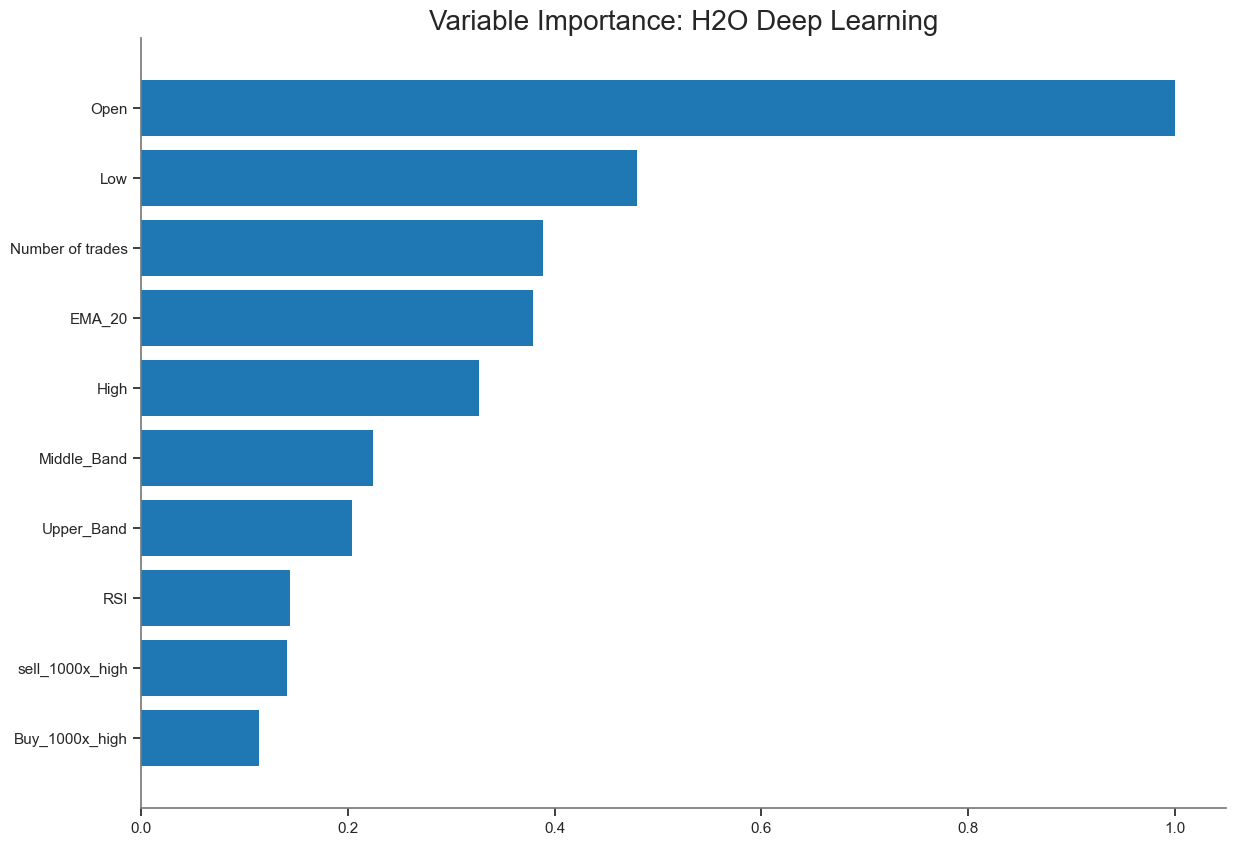

<Figure size 640x480 with 0 Axes>

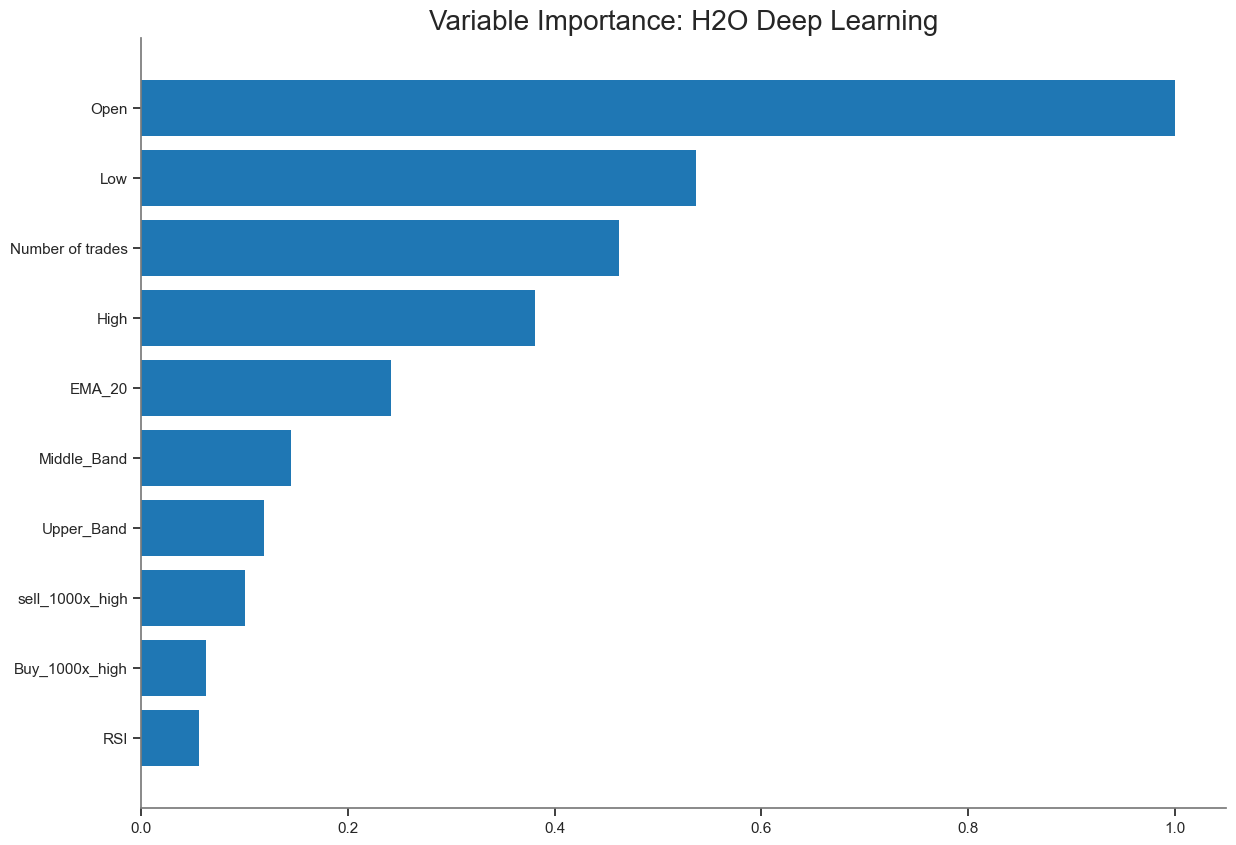

<Figure size 640x480 with 0 Axes>

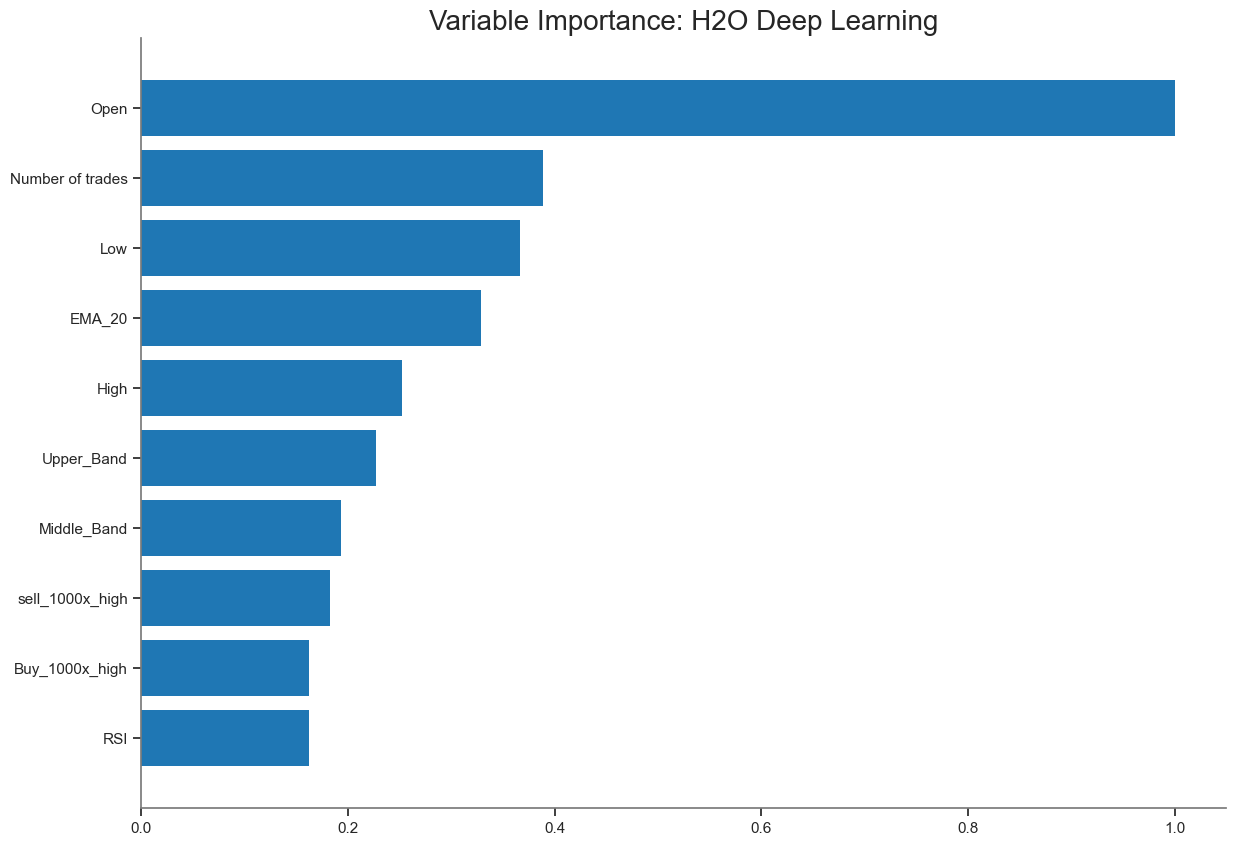

<Figure size 640x480 with 0 Axes>

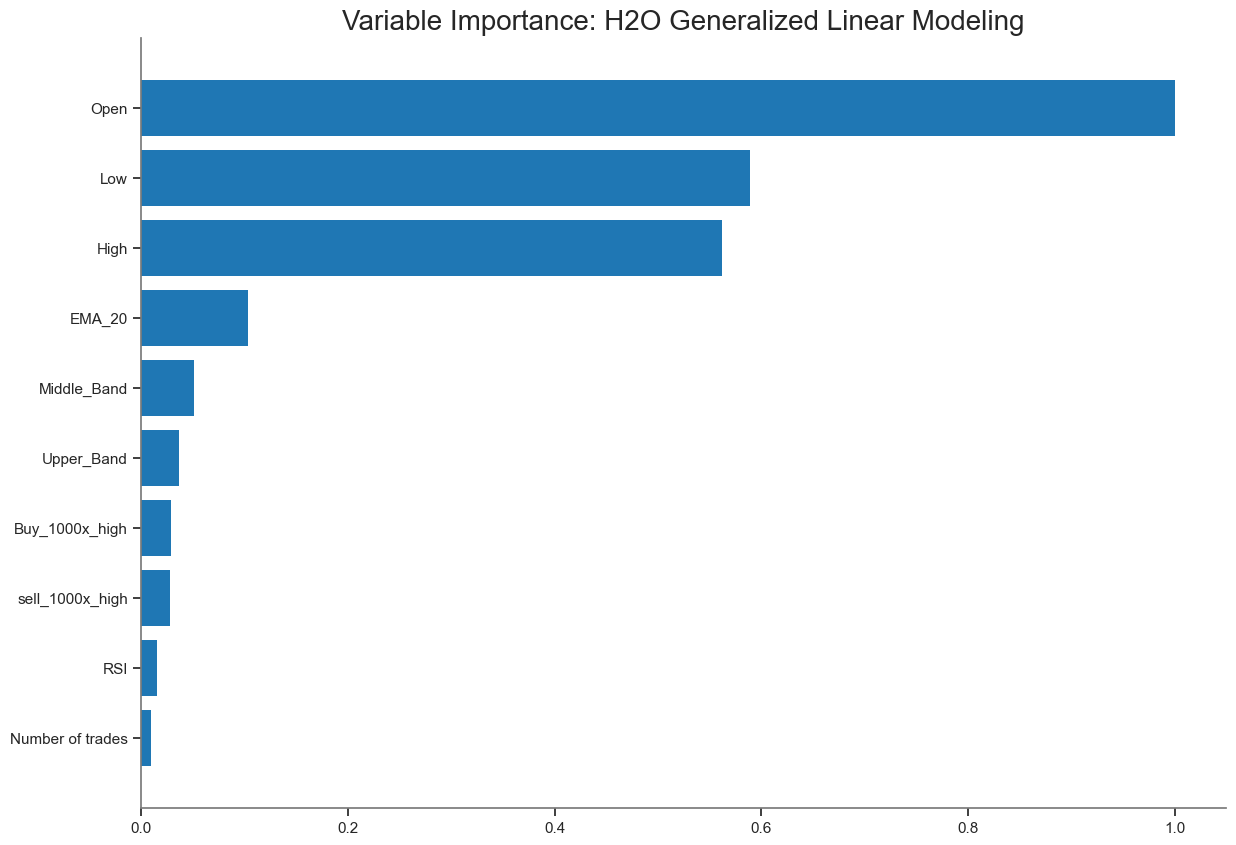

<Figure size 640x480 with 0 Axes>

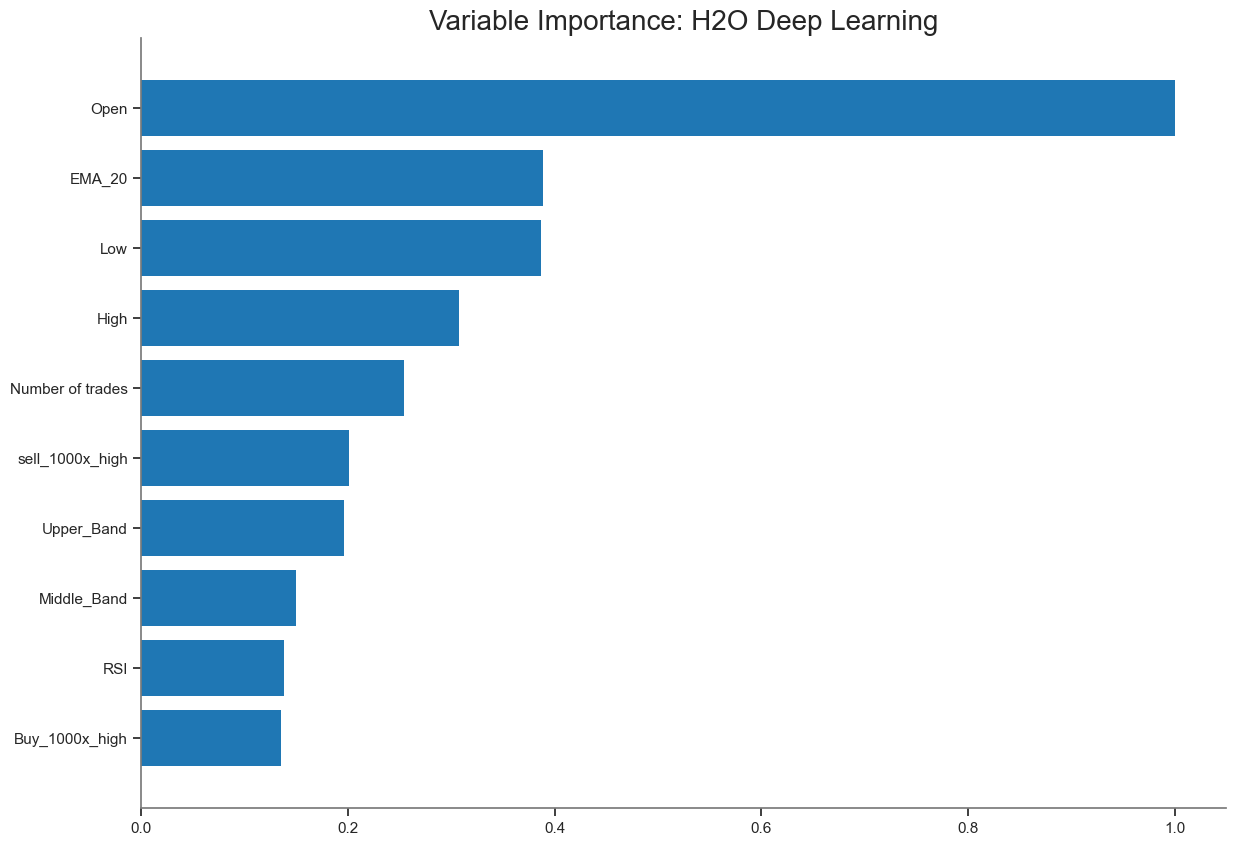

<Figure size 640x480 with 0 Axes>

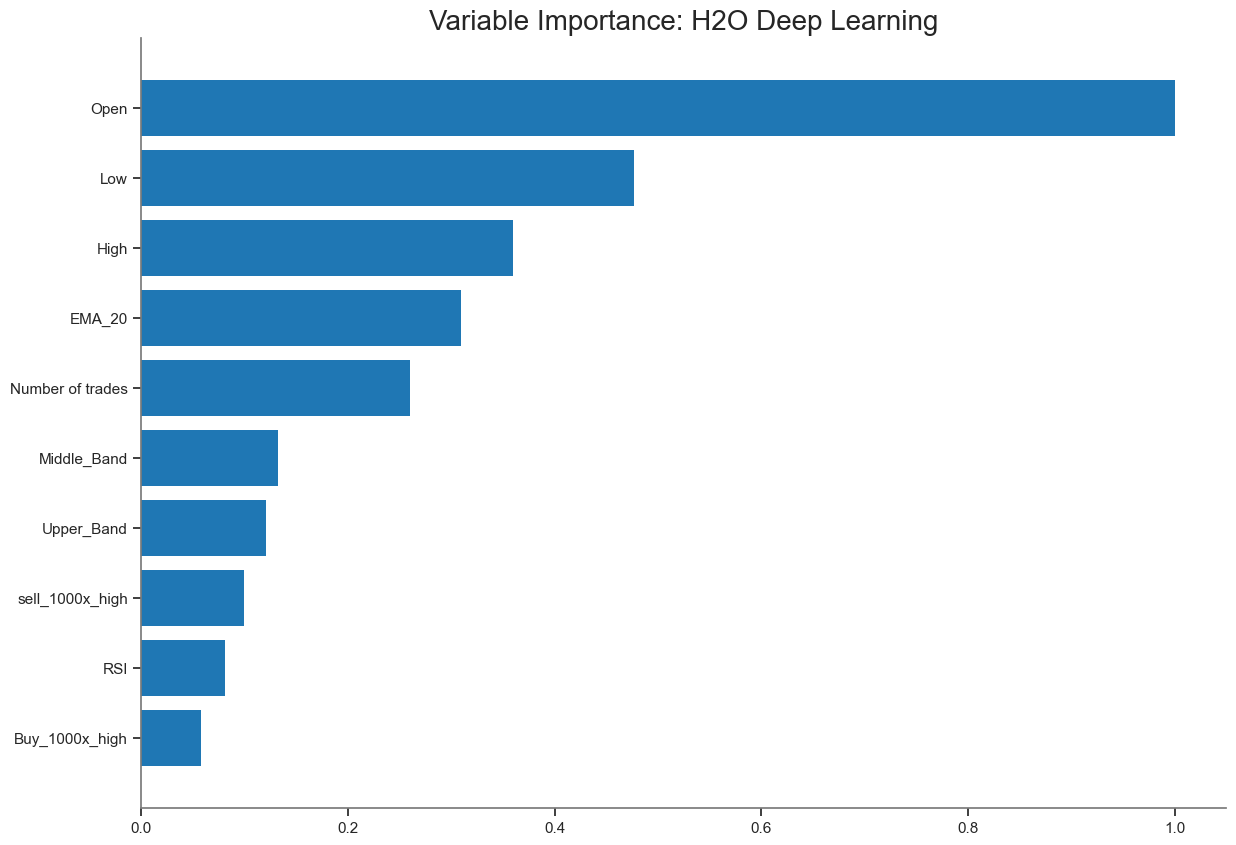

<Figure size 640x480 with 0 Axes>

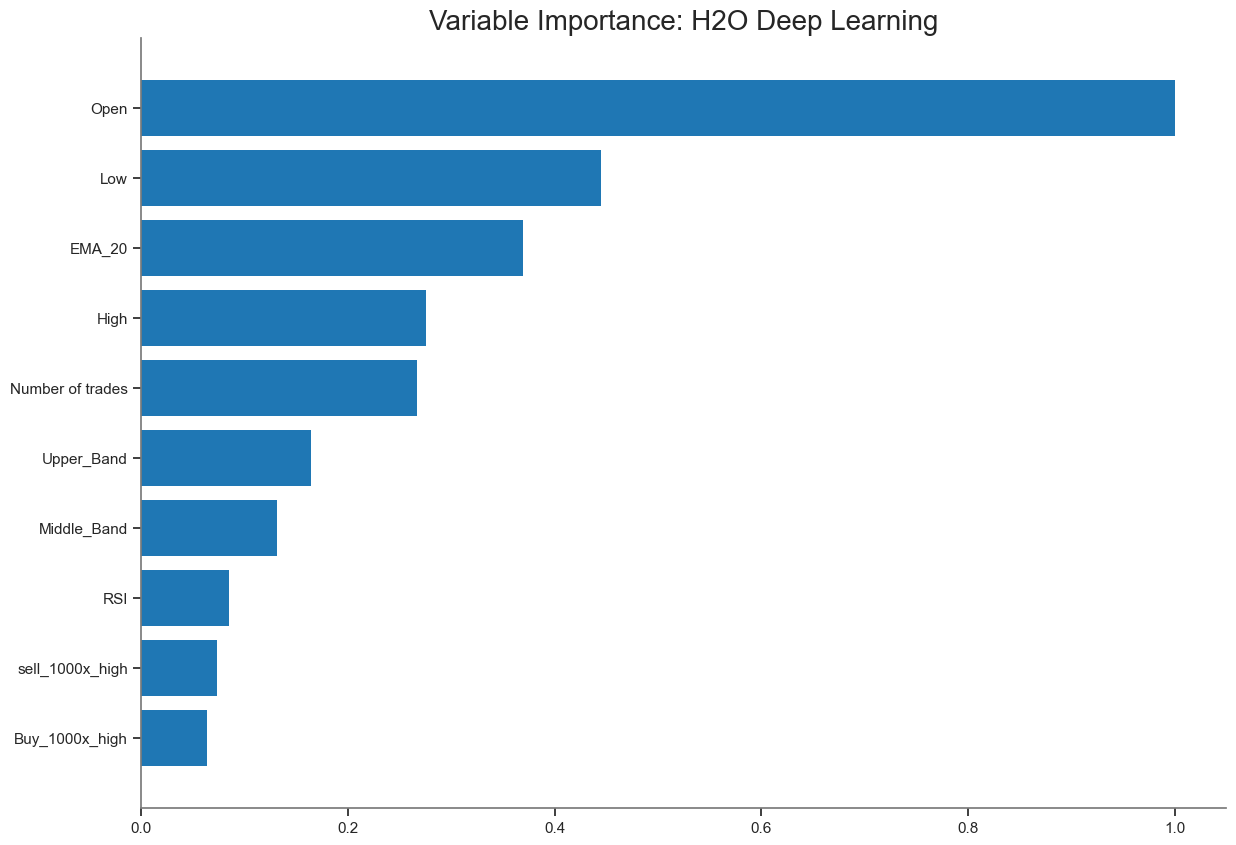

<Figure size 640x480 with 0 Axes>

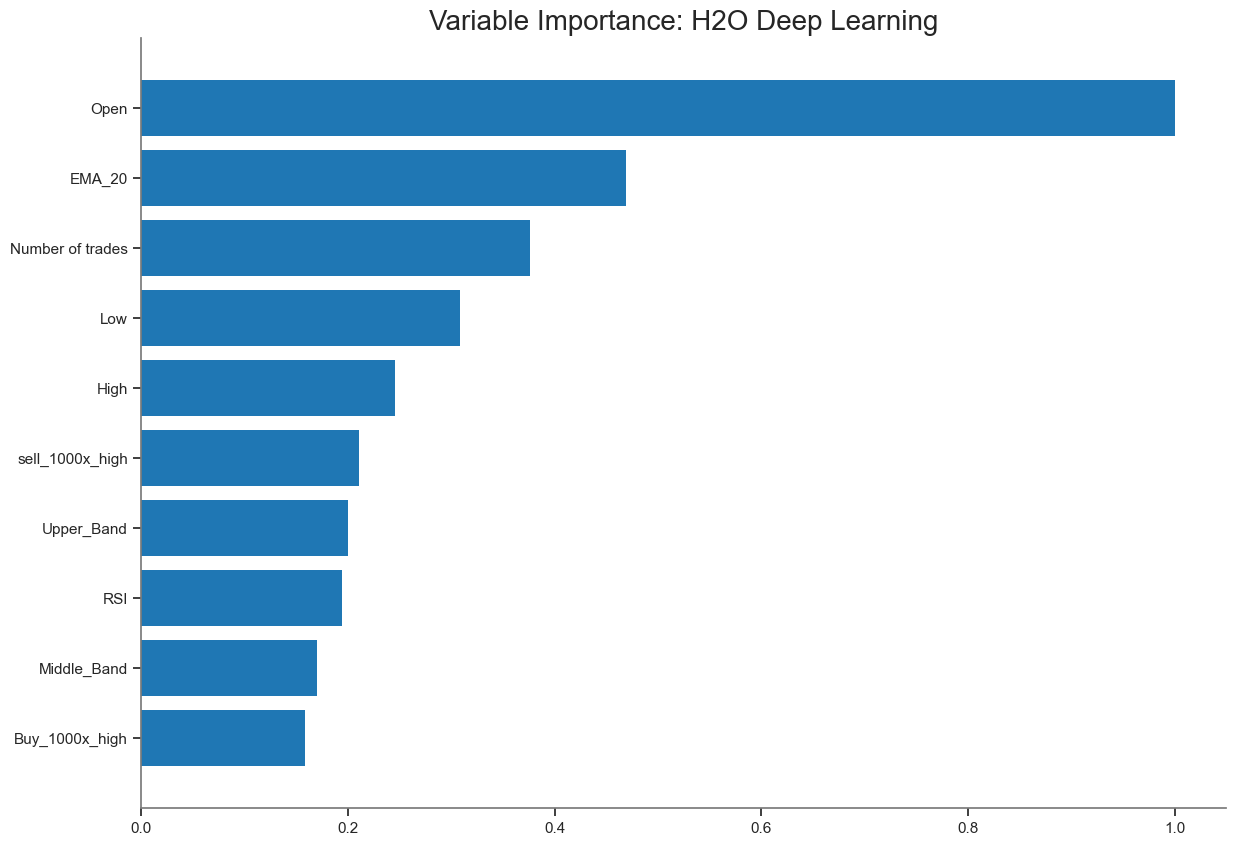

<Figure size 640x480 with 0 Axes>

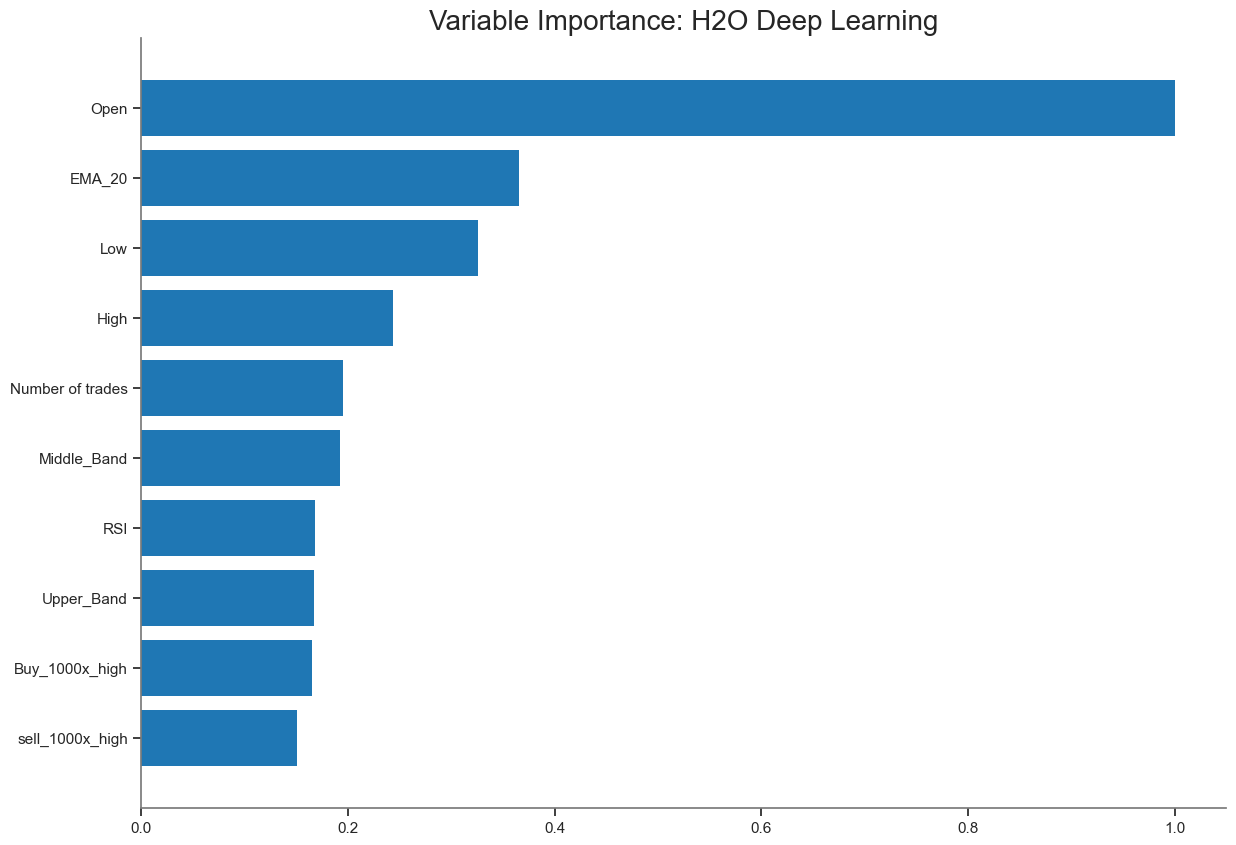

<Figure size 640x480 with 0 Axes>

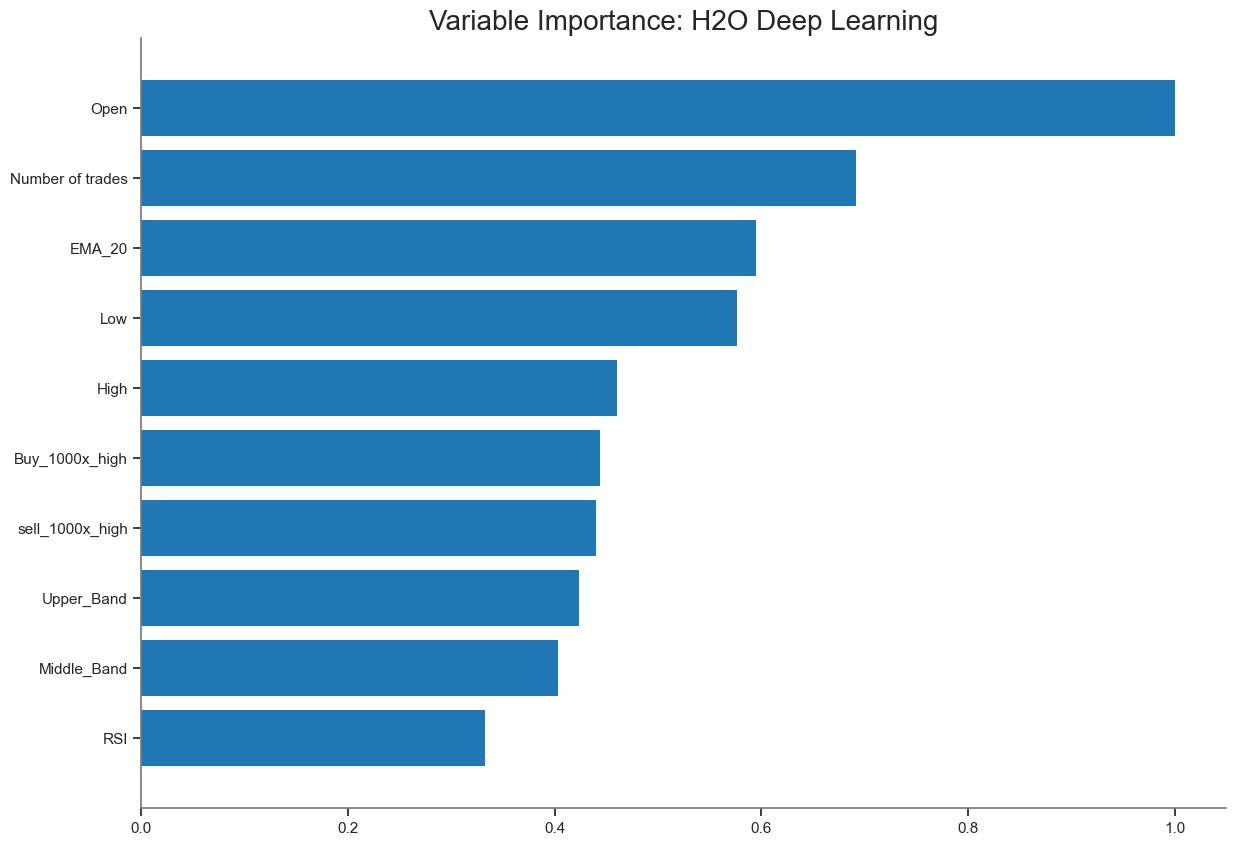

<Figure size 640x480 with 0 Axes>

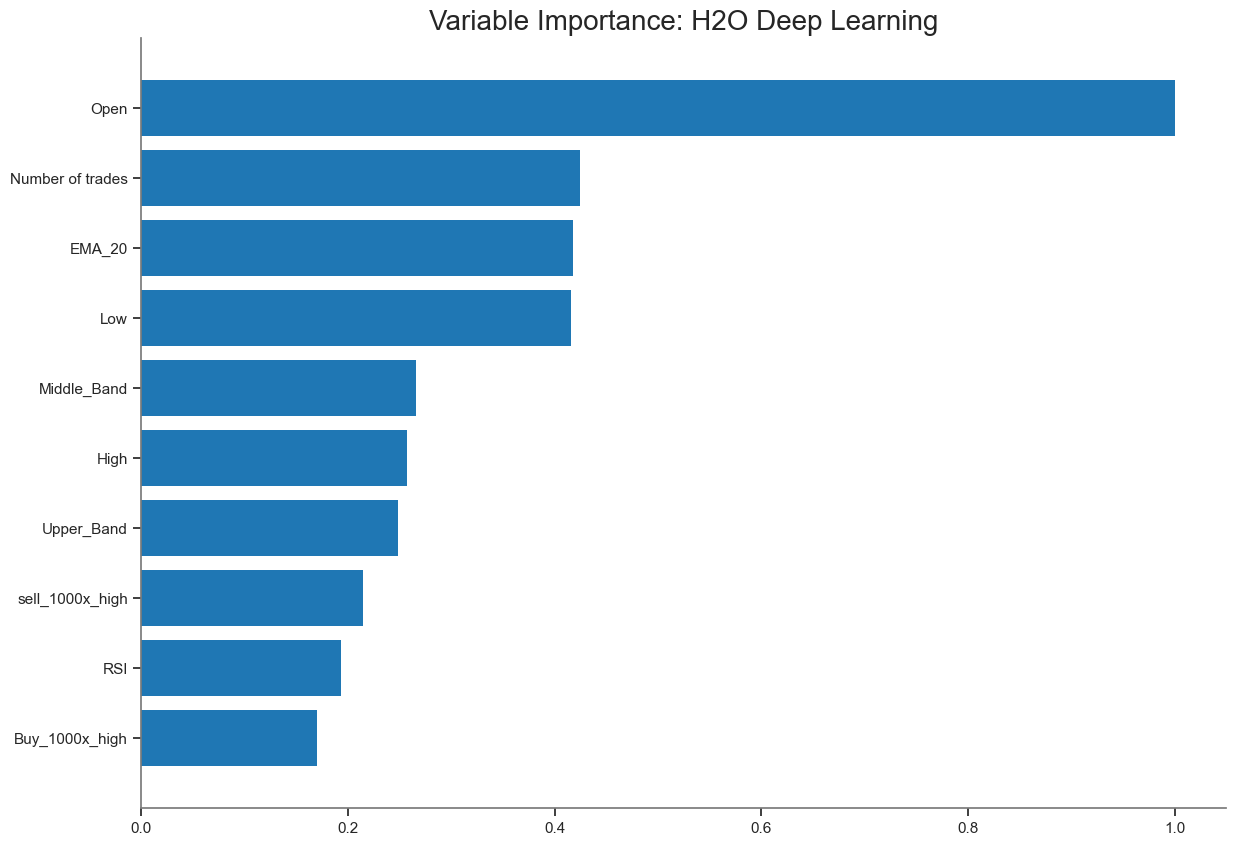

<Figure size 640x480 with 0 Axes>

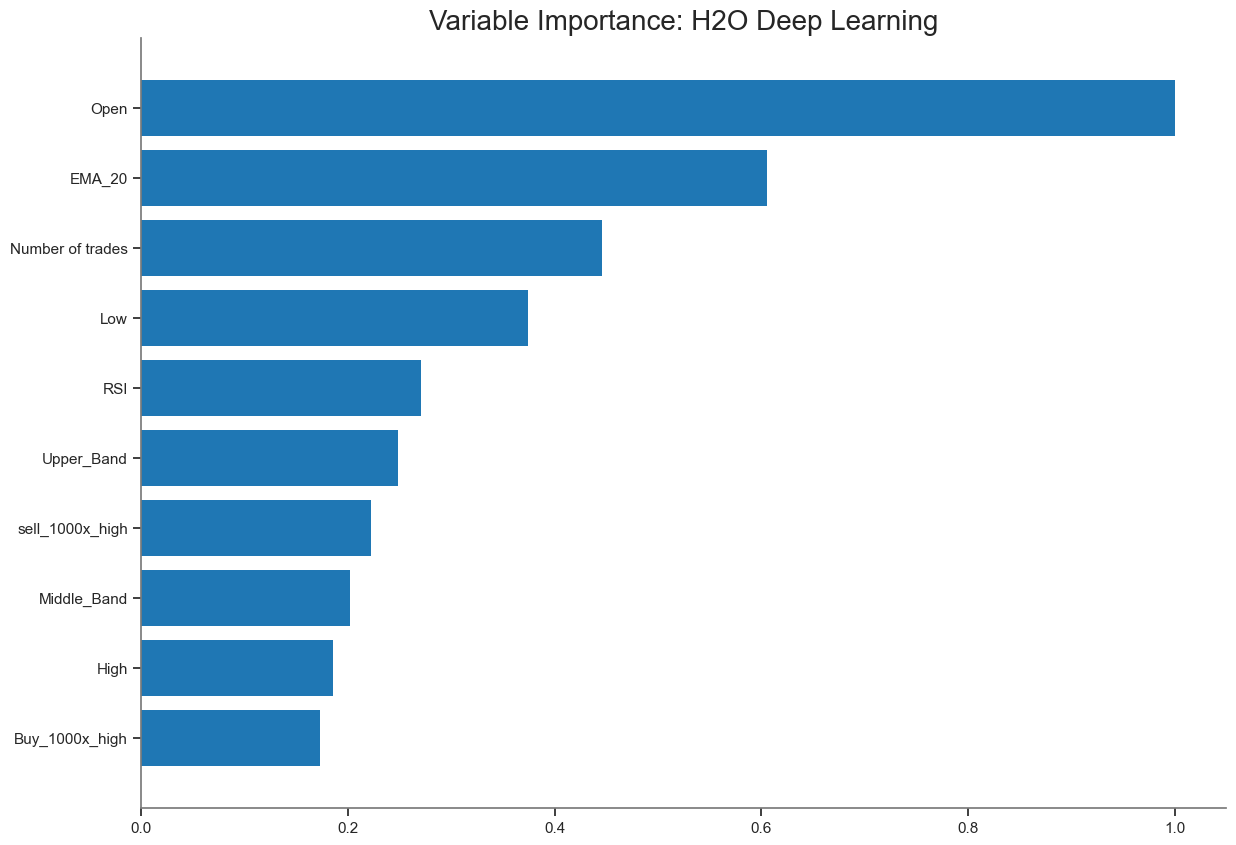

<Figure size 640x480 with 0 Axes>

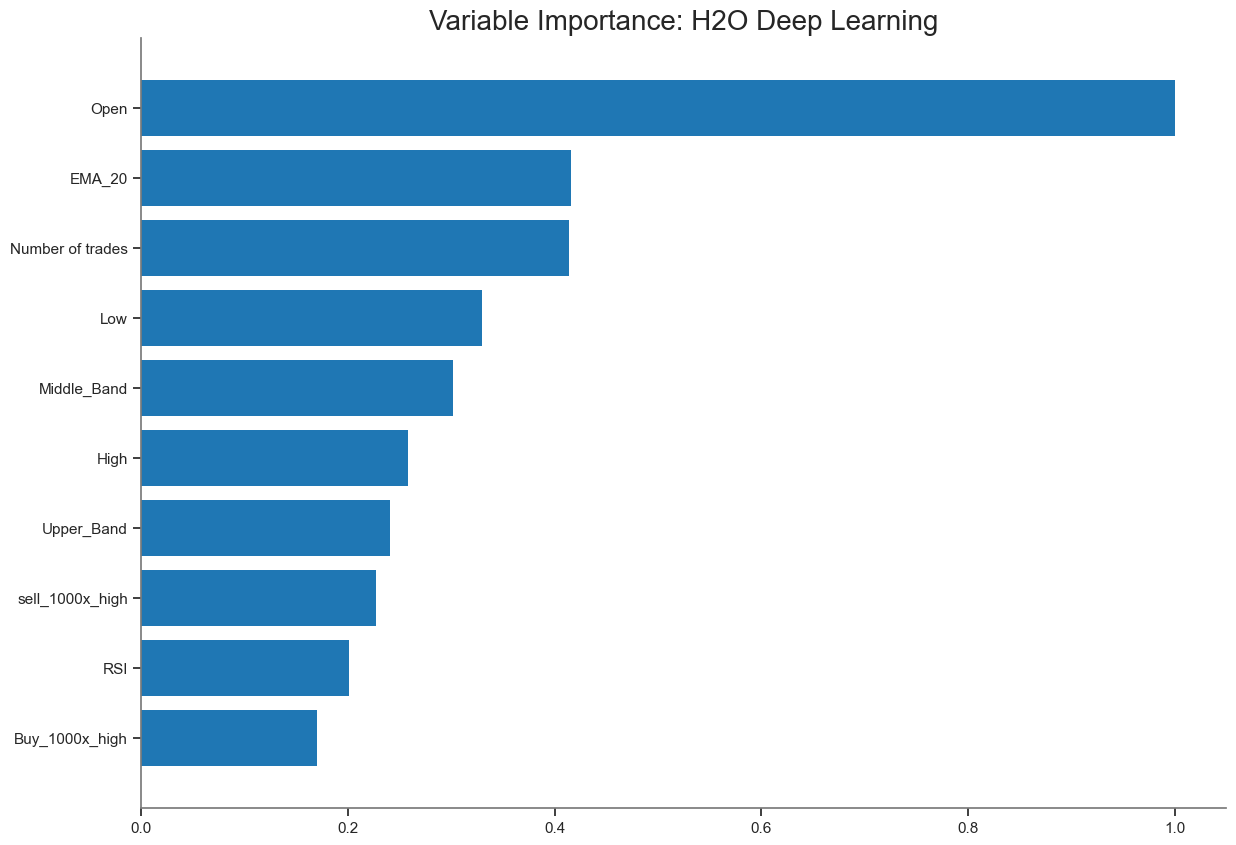

<Figure size 640x480 with 0 Axes>

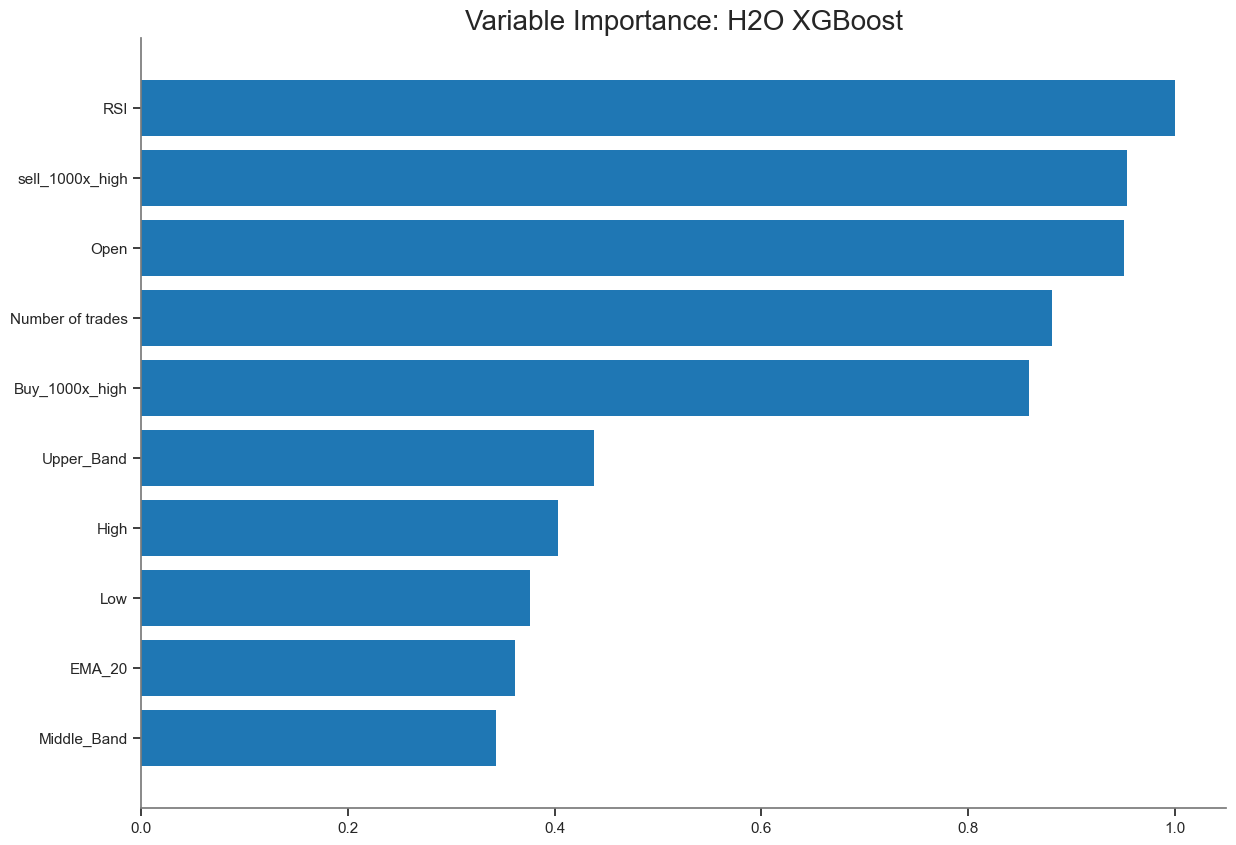

<Figure size 640x480 with 0 Axes>

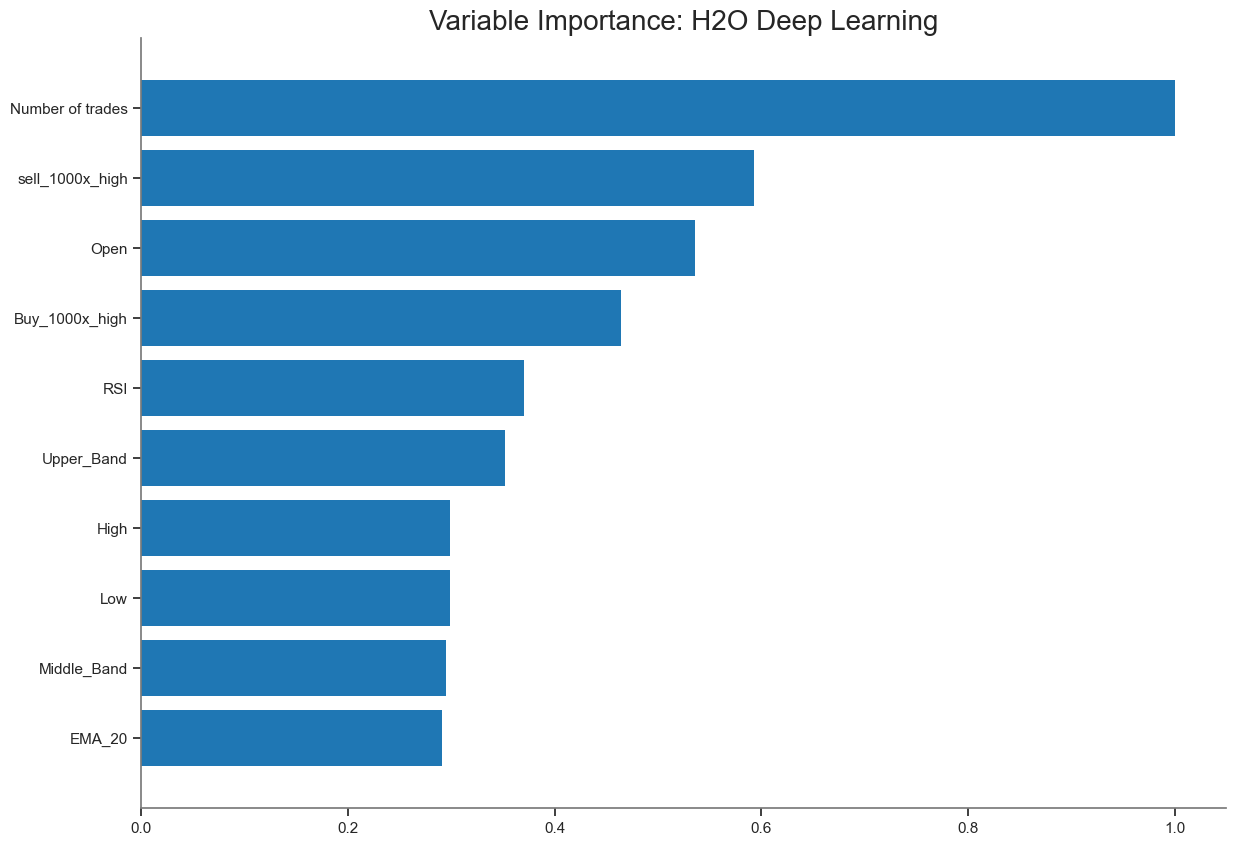

<Figure size 640x480 with 0 Axes>

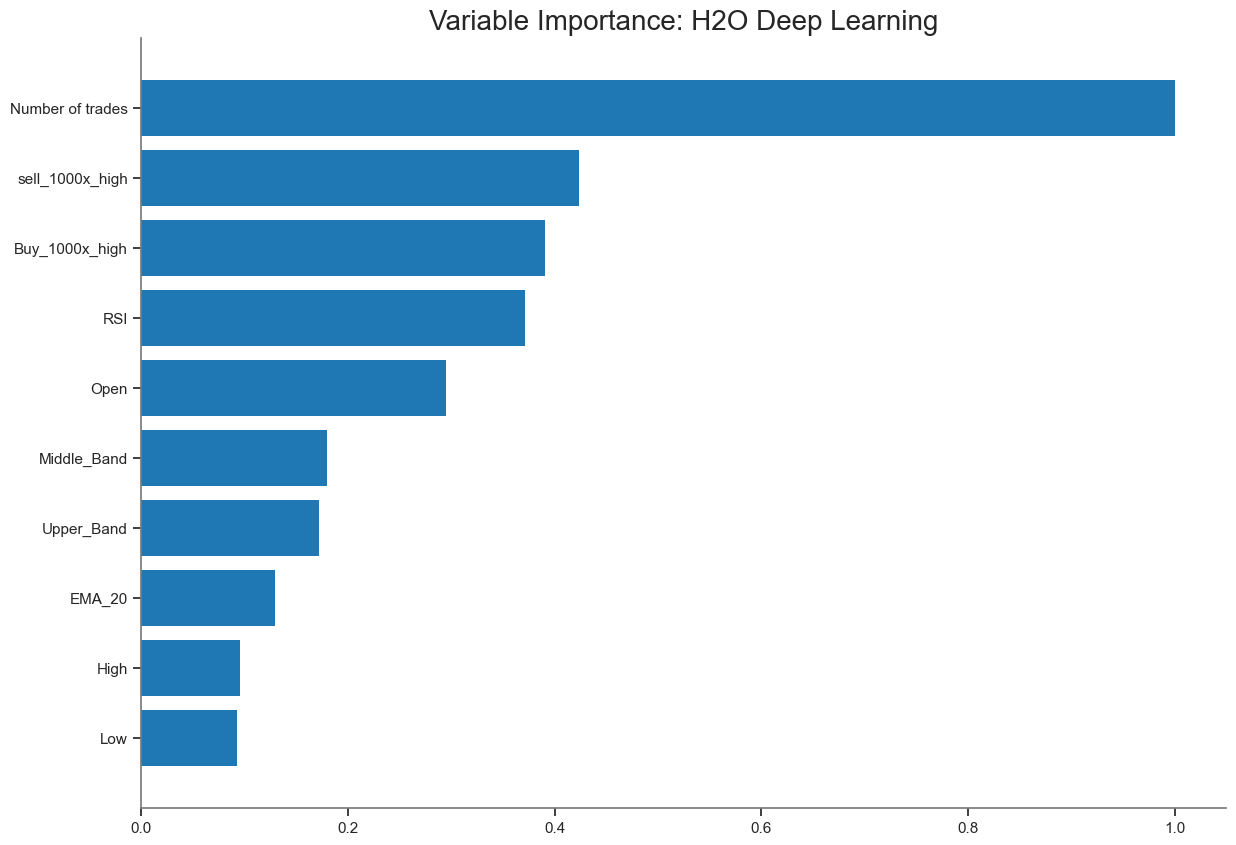

<Figure size 640x480 with 0 Axes>

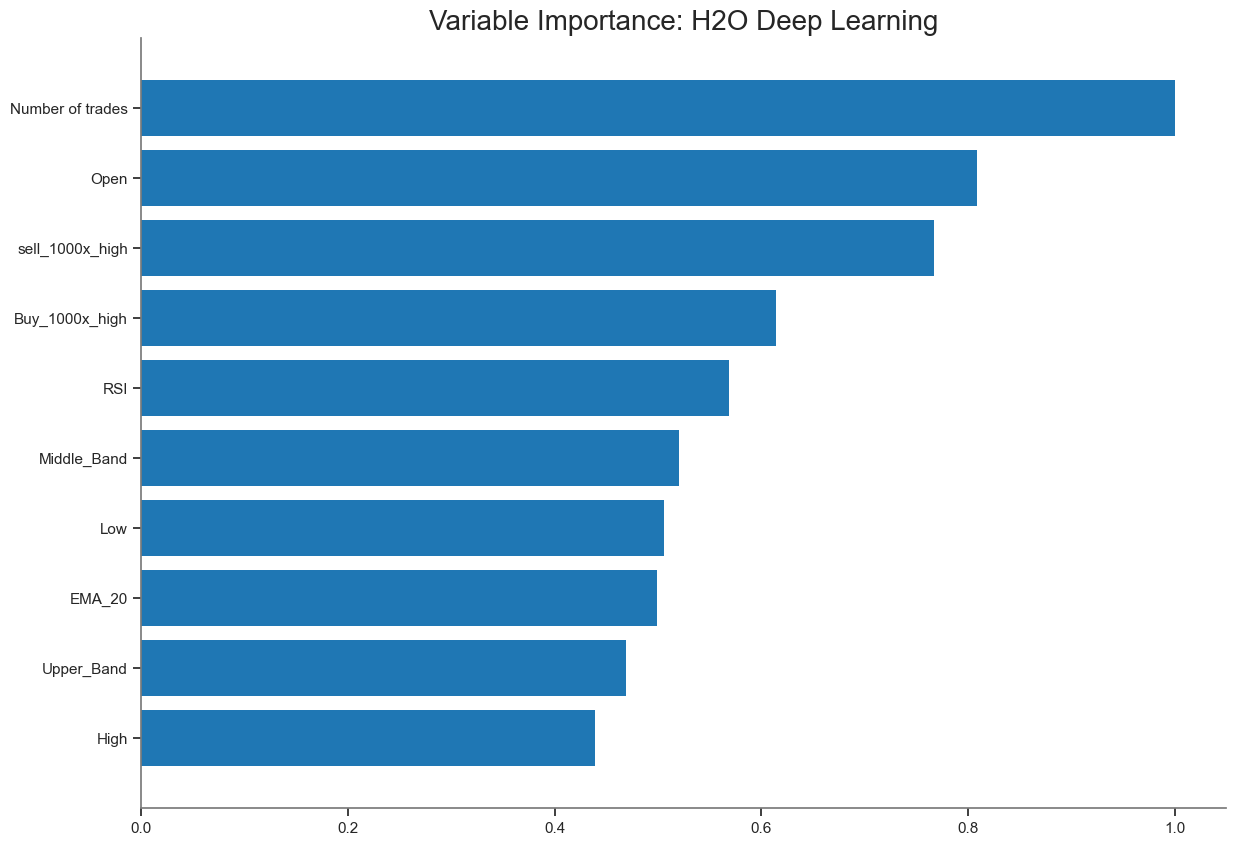

<Figure size 640x480 with 0 Axes>

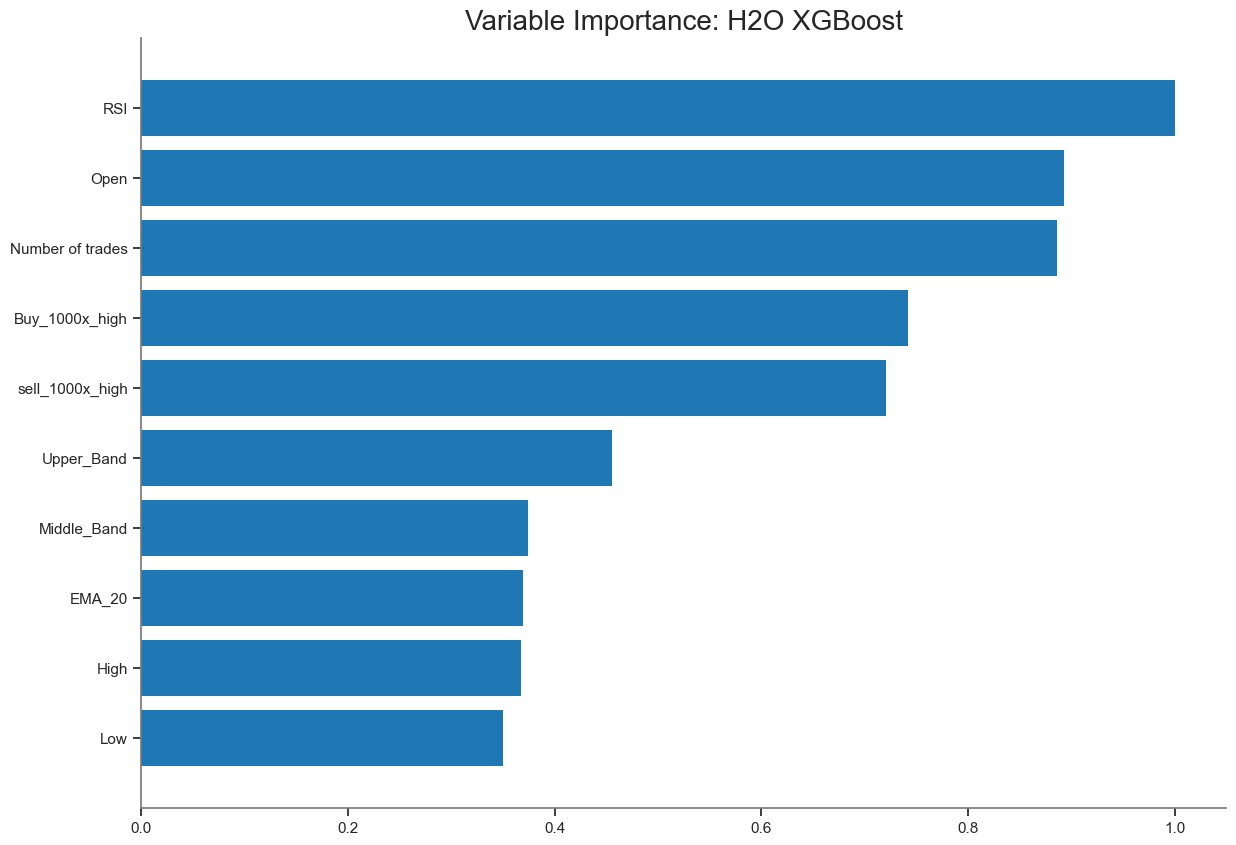

<Figure size 640x480 with 0 Axes>

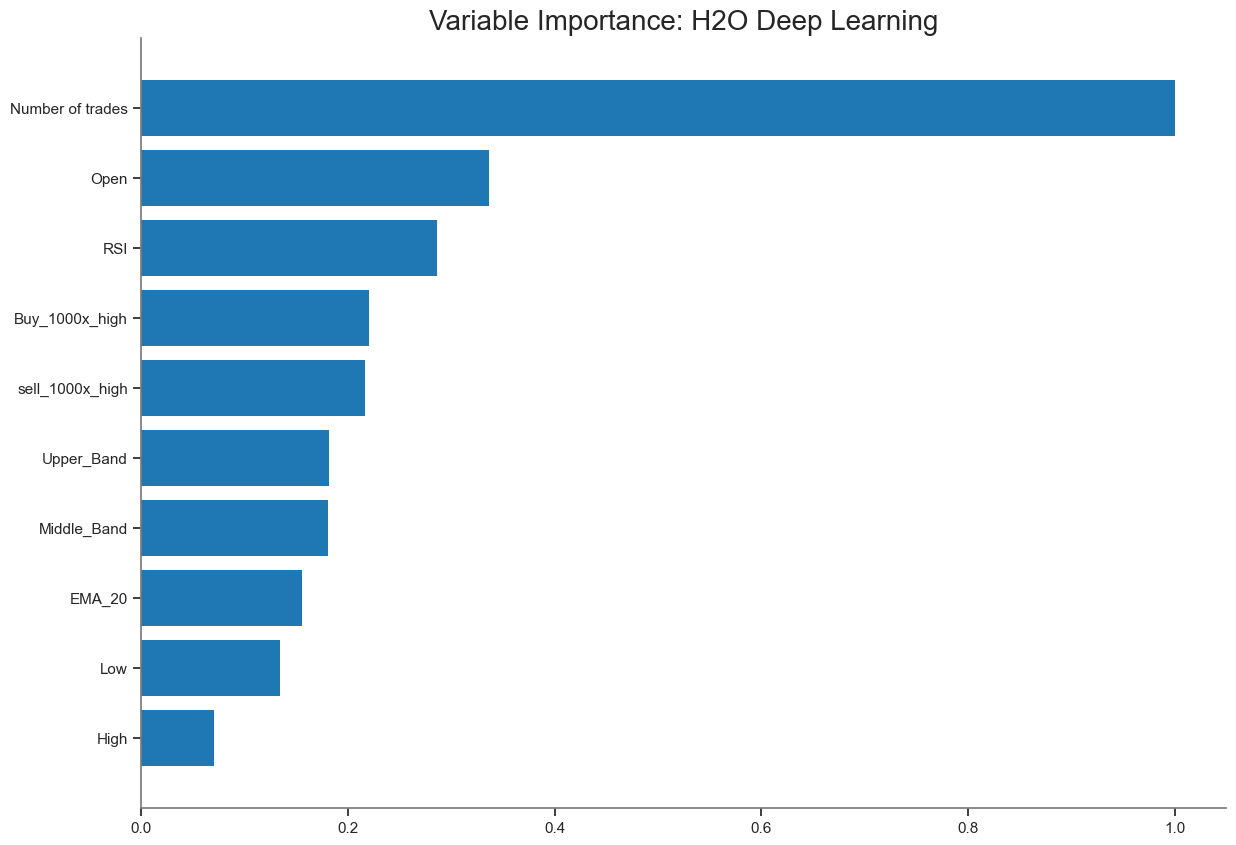

<Figure size 640x480 with 0 Axes>

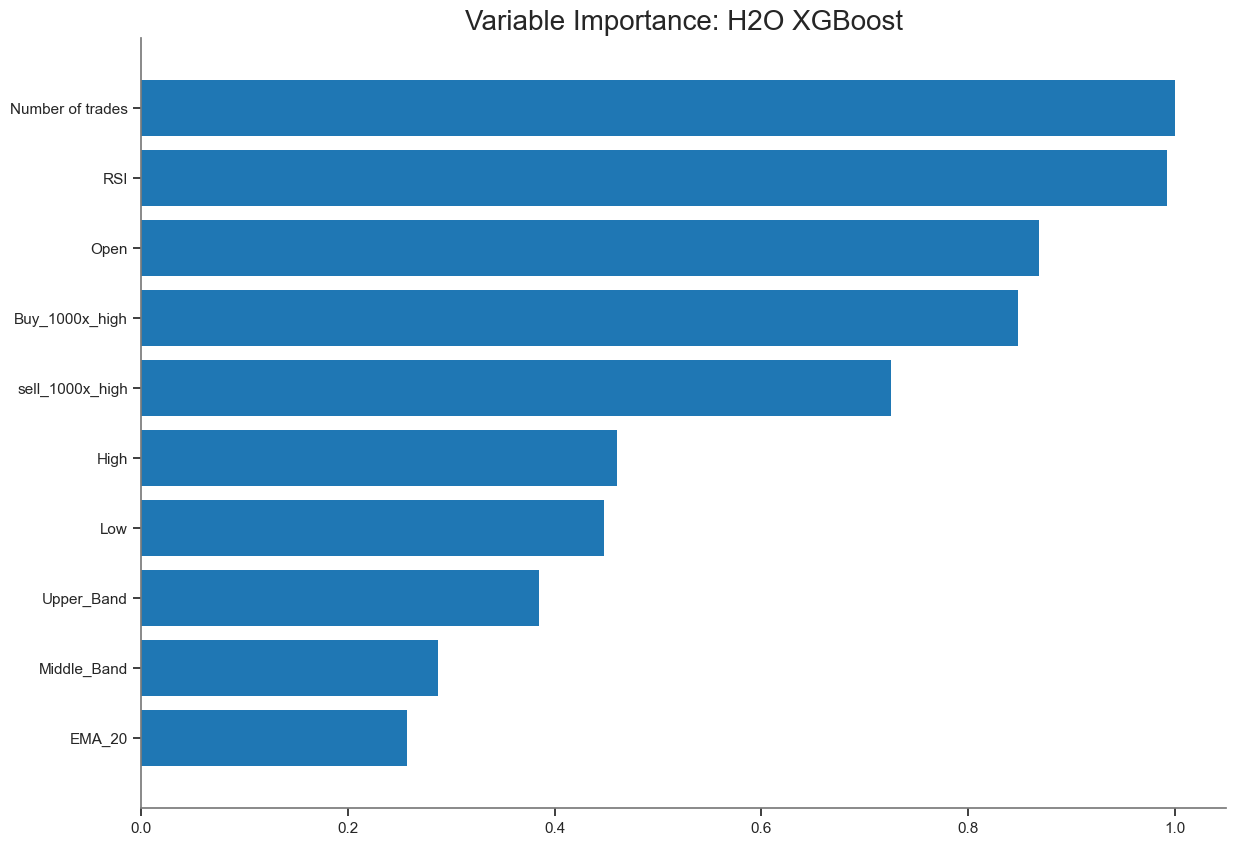

<Figure size 640x480 with 0 Axes>

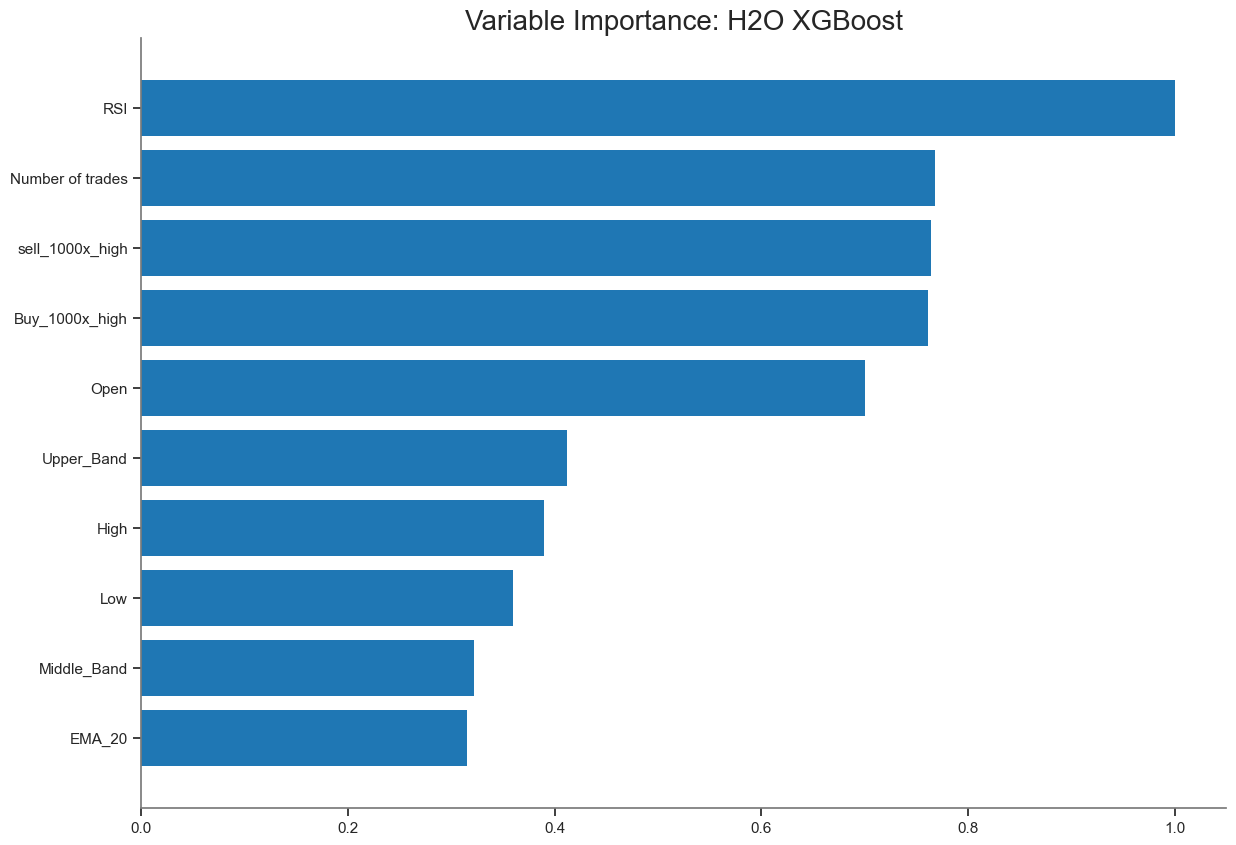

<Figure size 640x480 with 0 Axes>

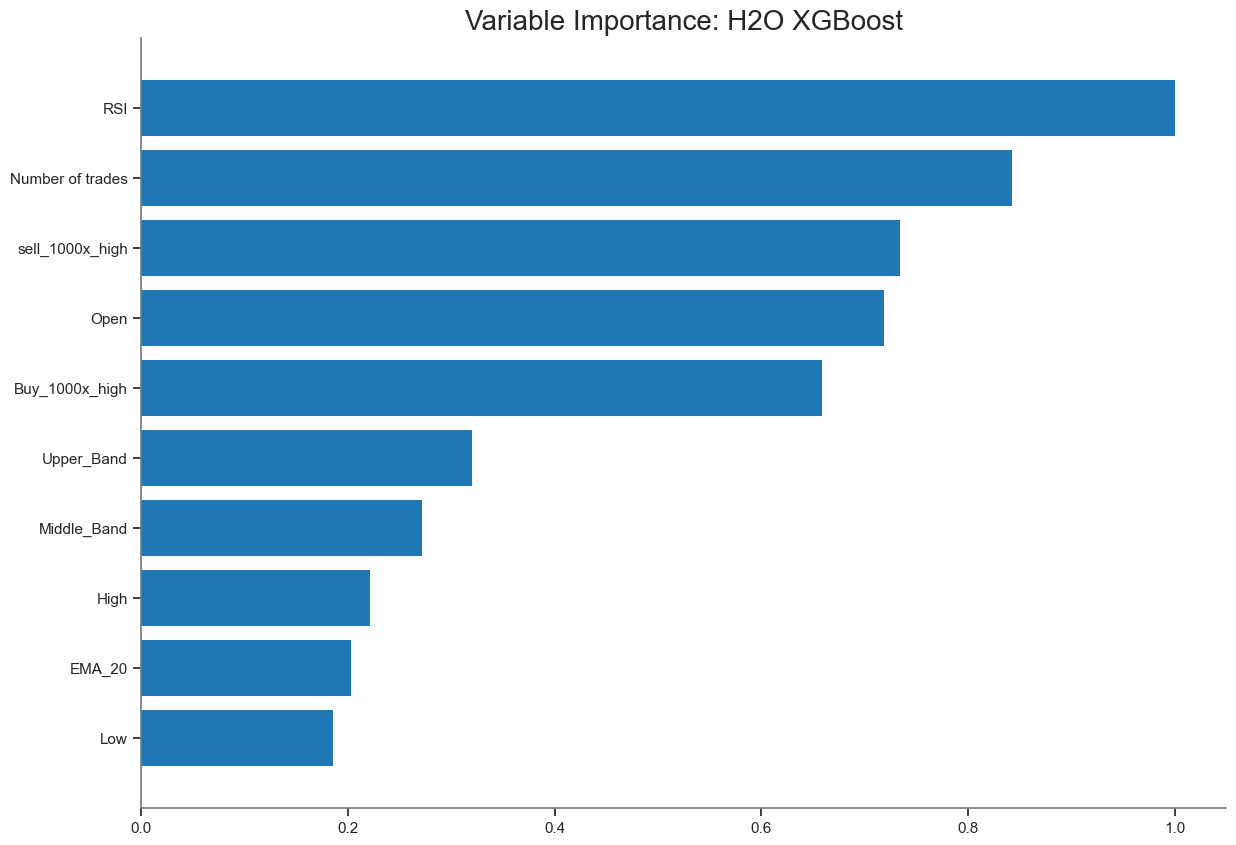

<Figure size 640x480 with 0 Axes>

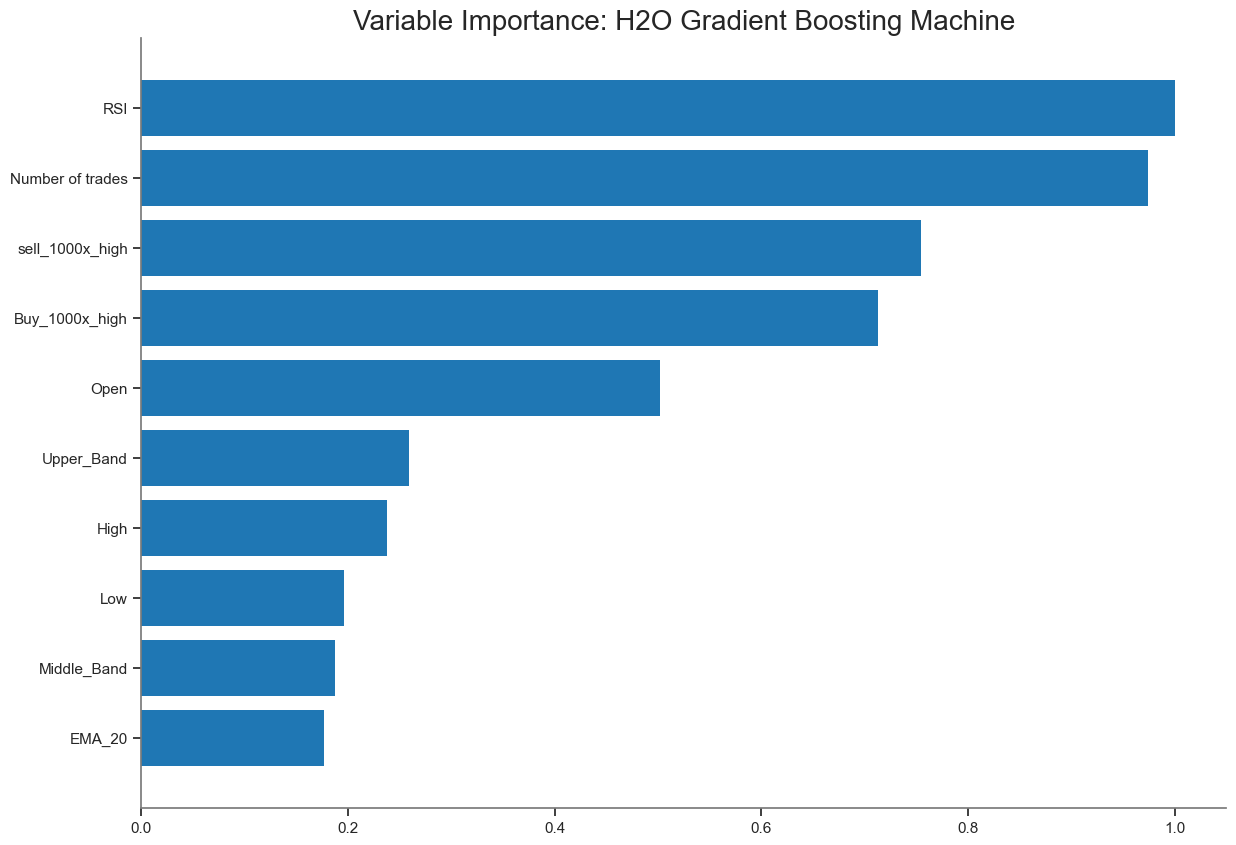

<Figure size 640x480 with 0 Axes>

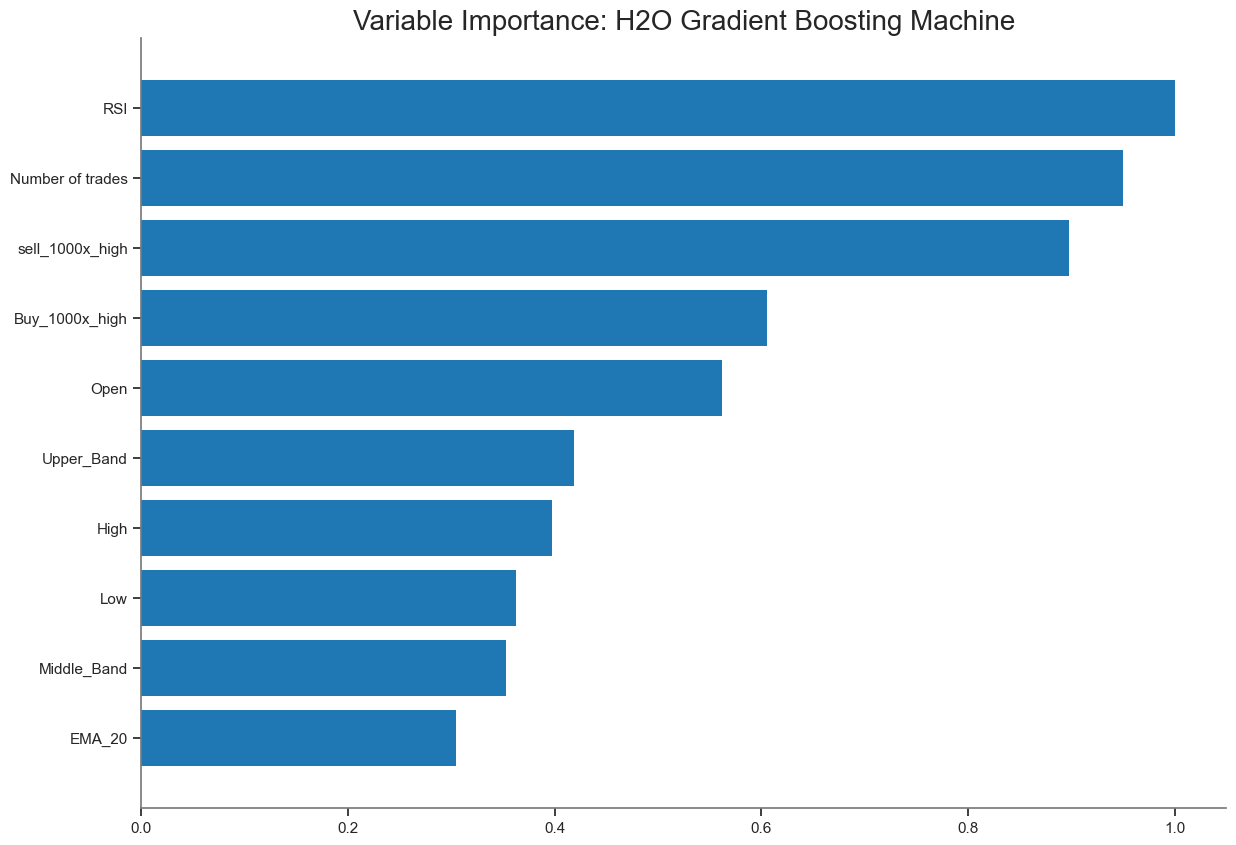

<Figure size 640x480 with 0 Axes>

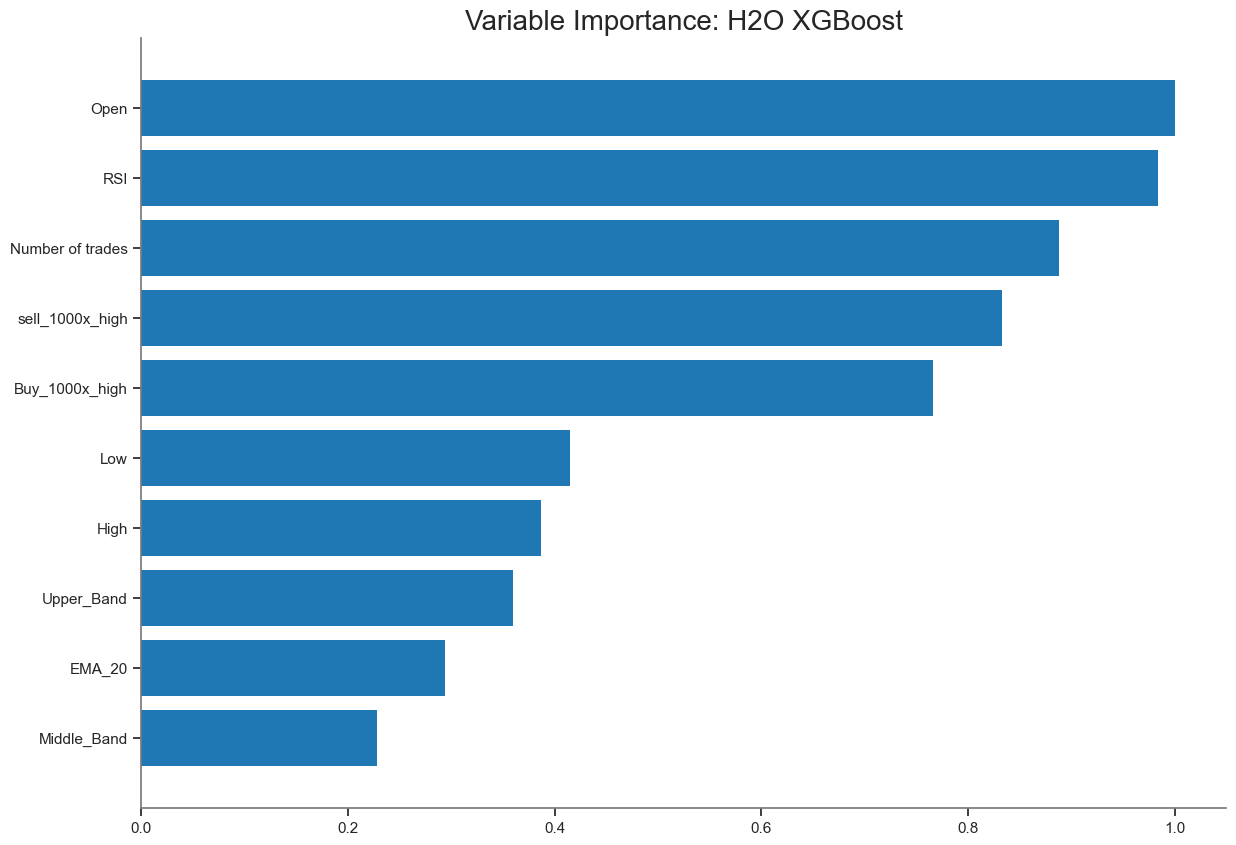

<Figure size 640x480 with 0 Axes>

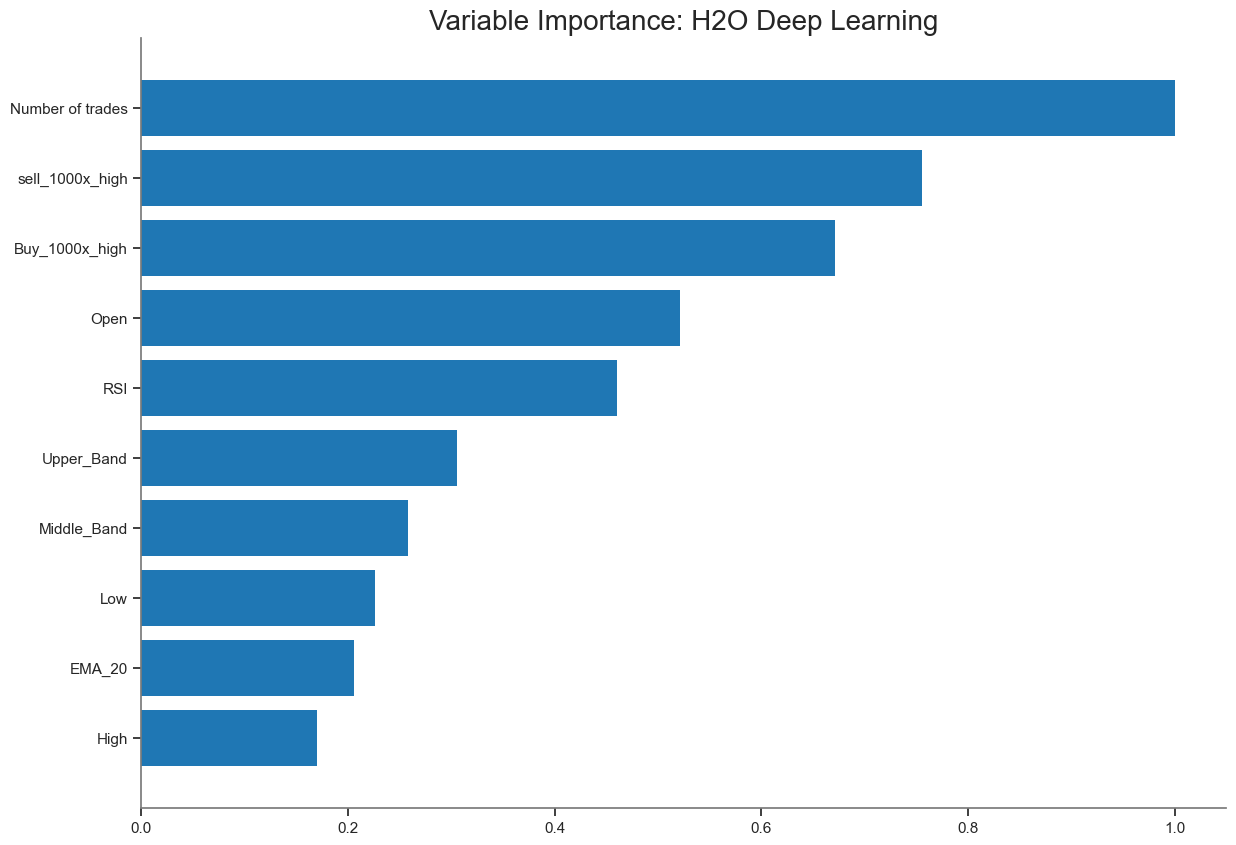

<Figure size 640x480 with 0 Axes>

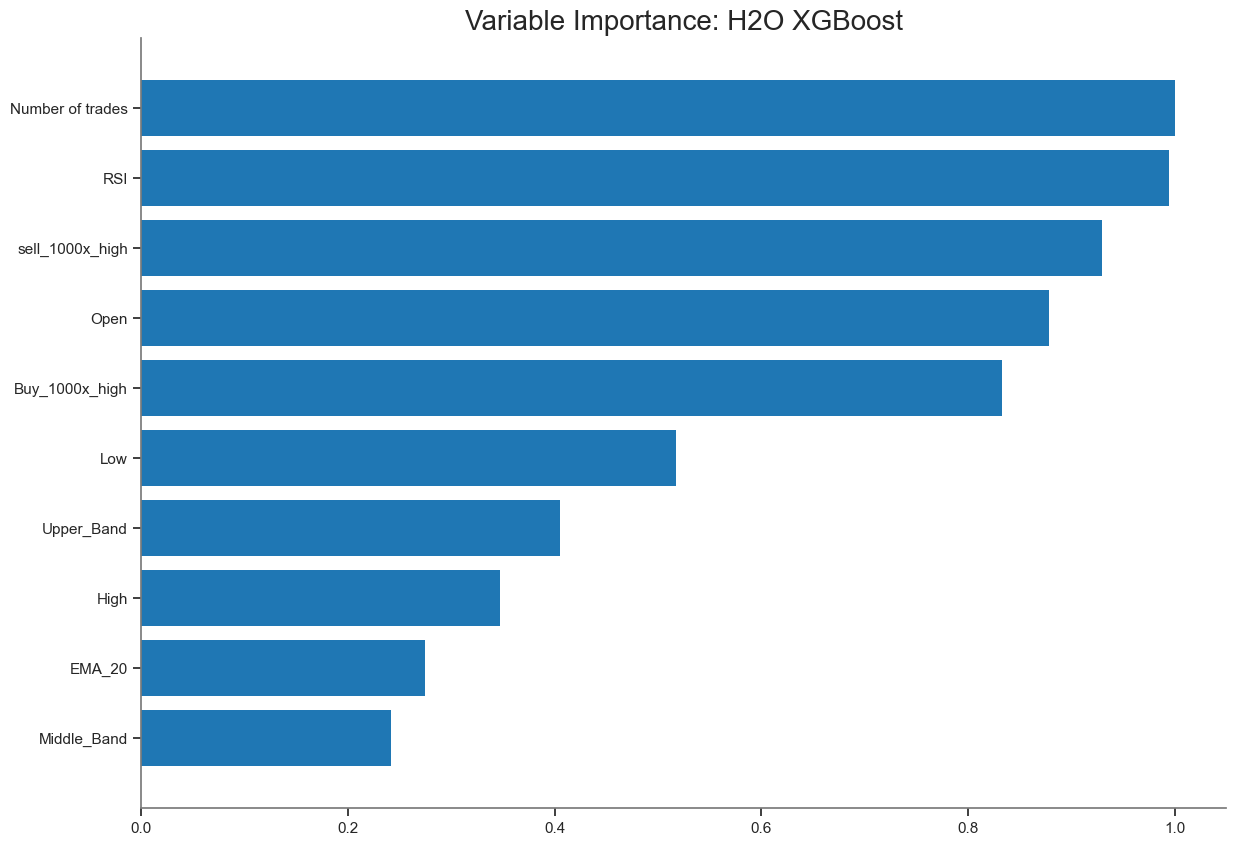

<Figure size 640x480 with 0 Axes>

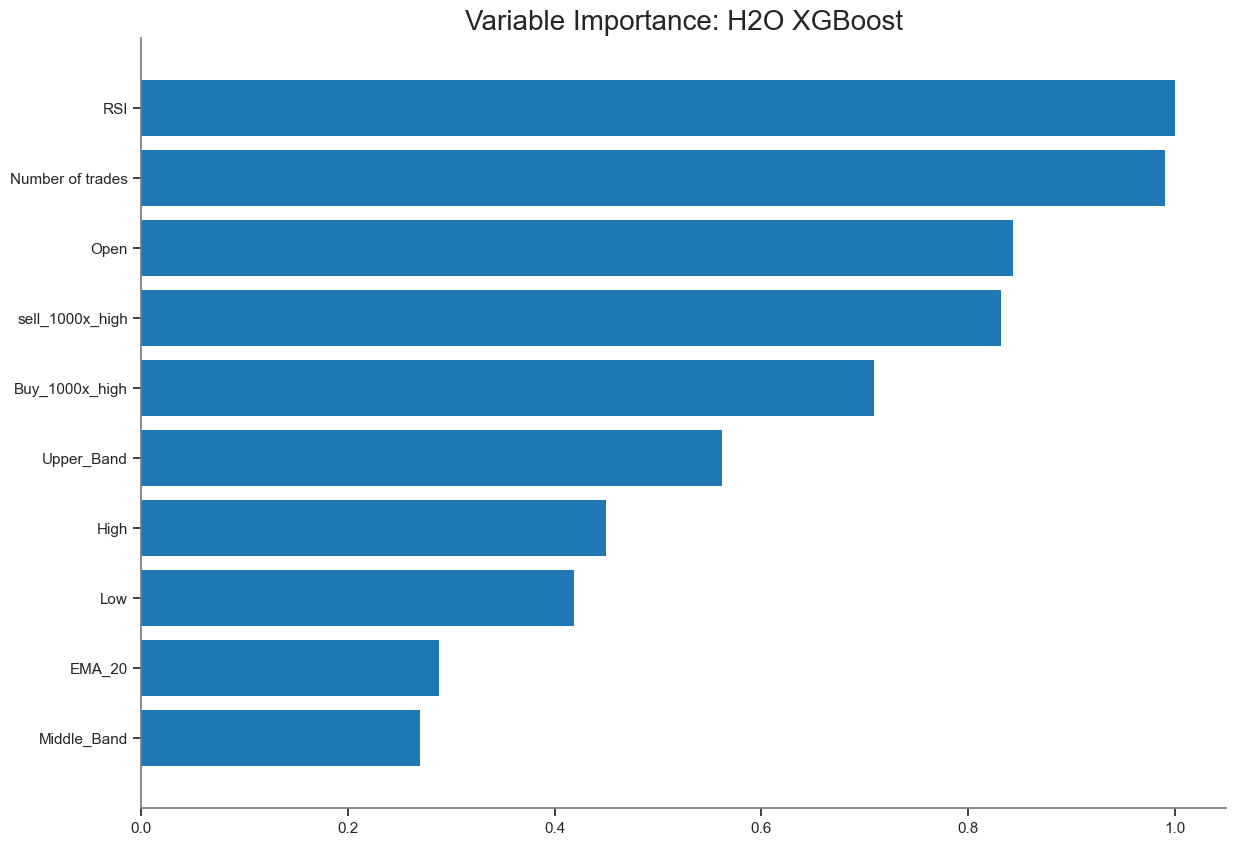

<Figure size 640x480 with 0 Axes>

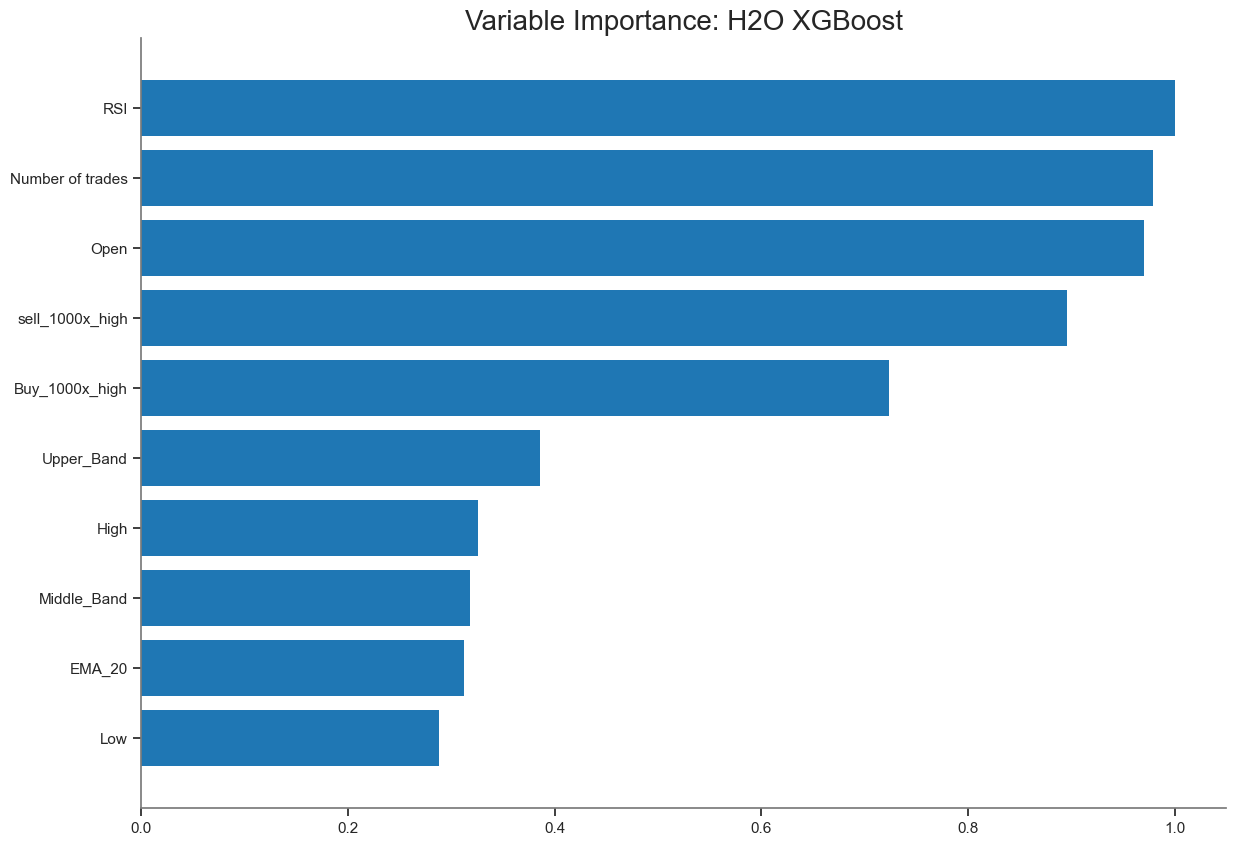

<Figure size 640x480 with 0 Axes>

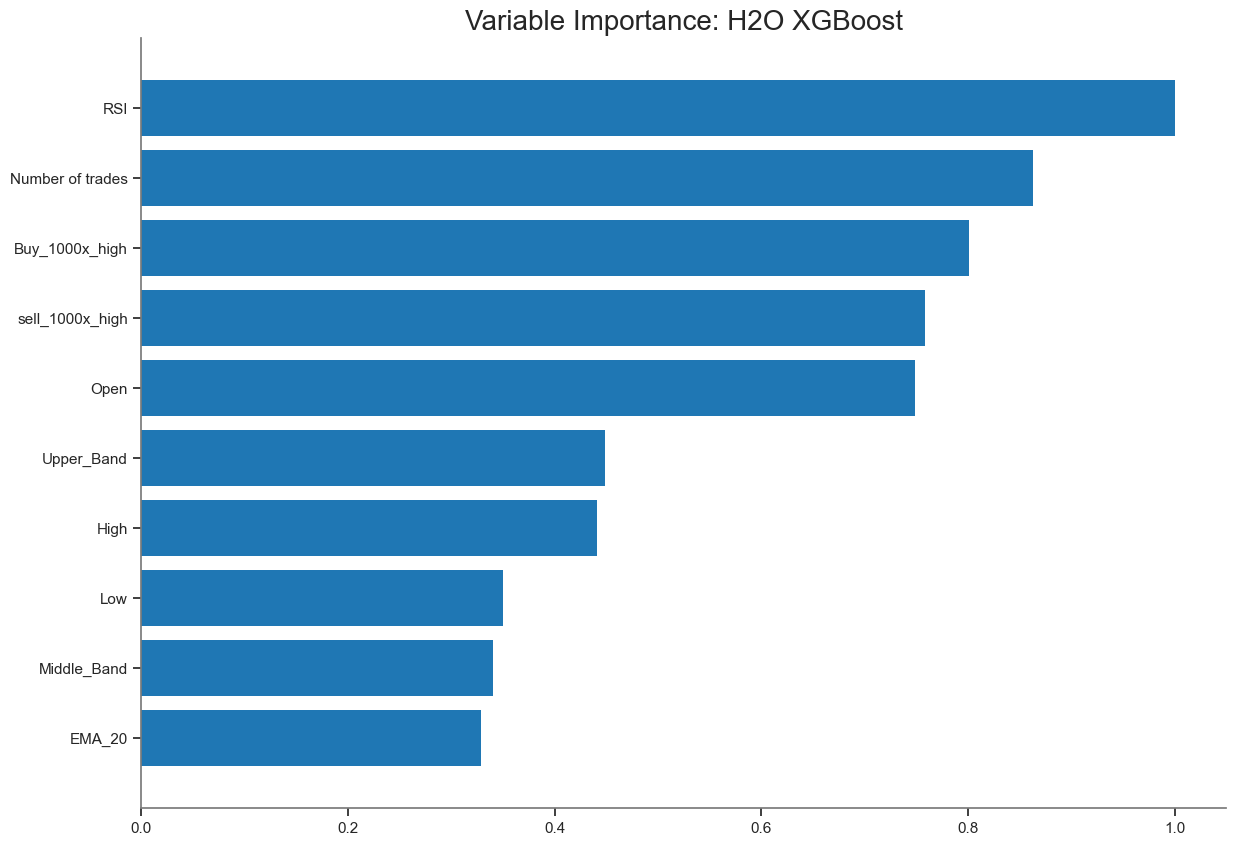

<Figure size 640x480 with 0 Axes>

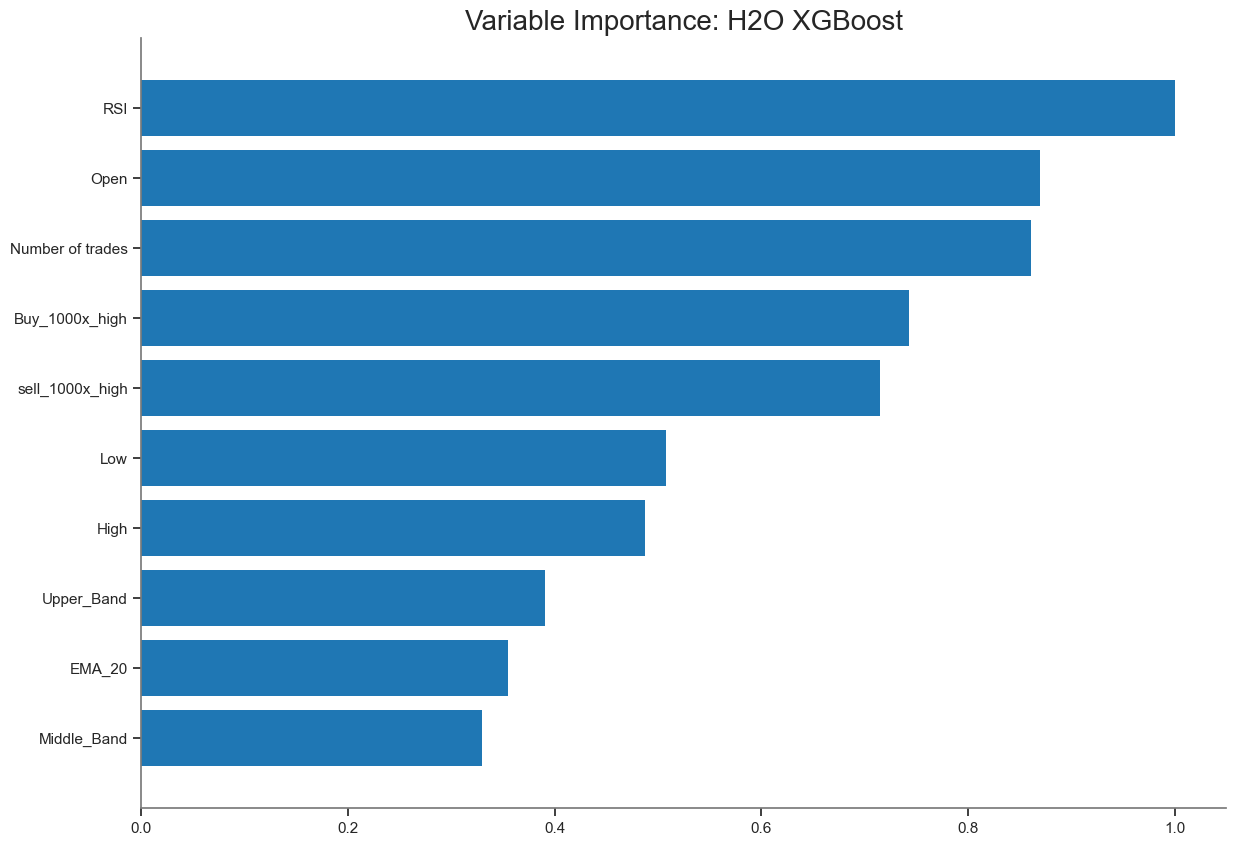

<Figure size 640x480 with 0 Axes>

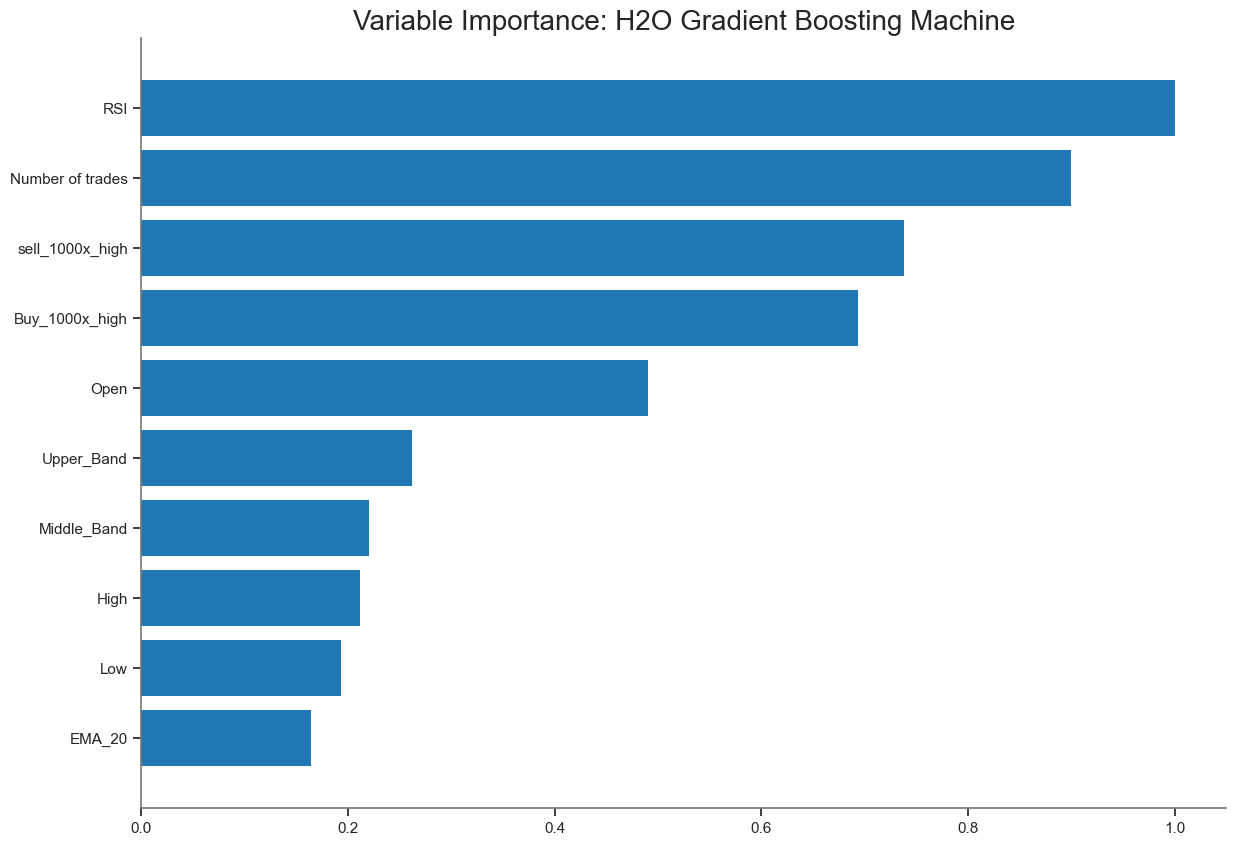

<Figure size 640x480 with 0 Axes>

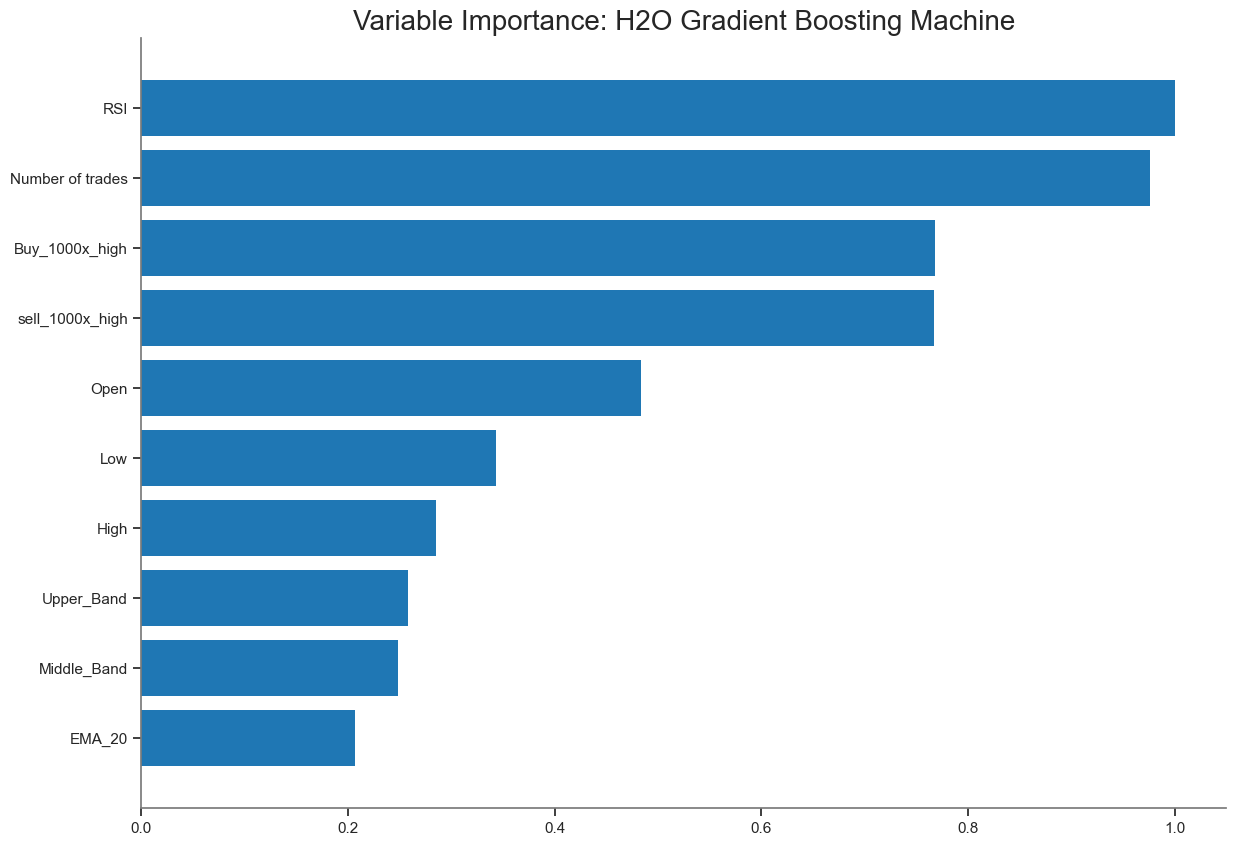

<Figure size 640x480 with 0 Axes>

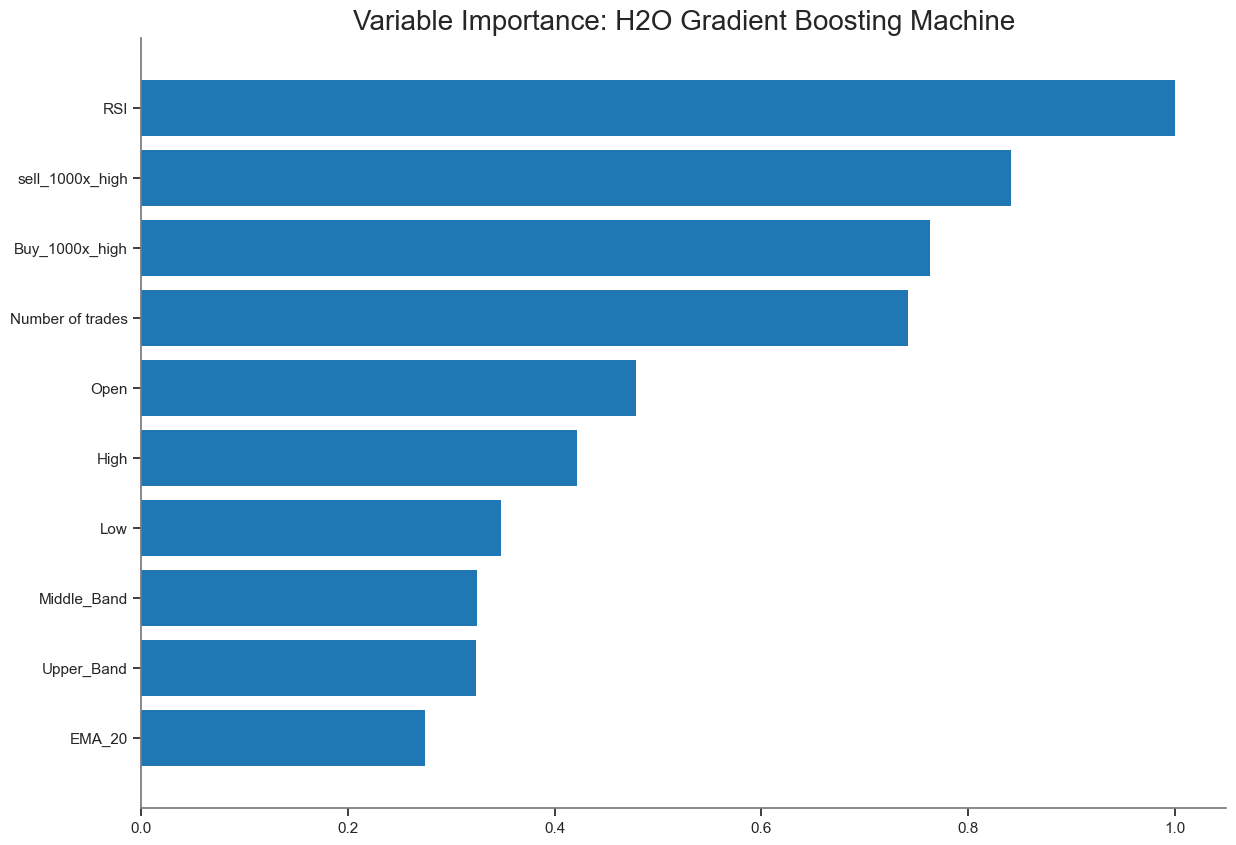

<Figure size 640x480 with 0 Axes>

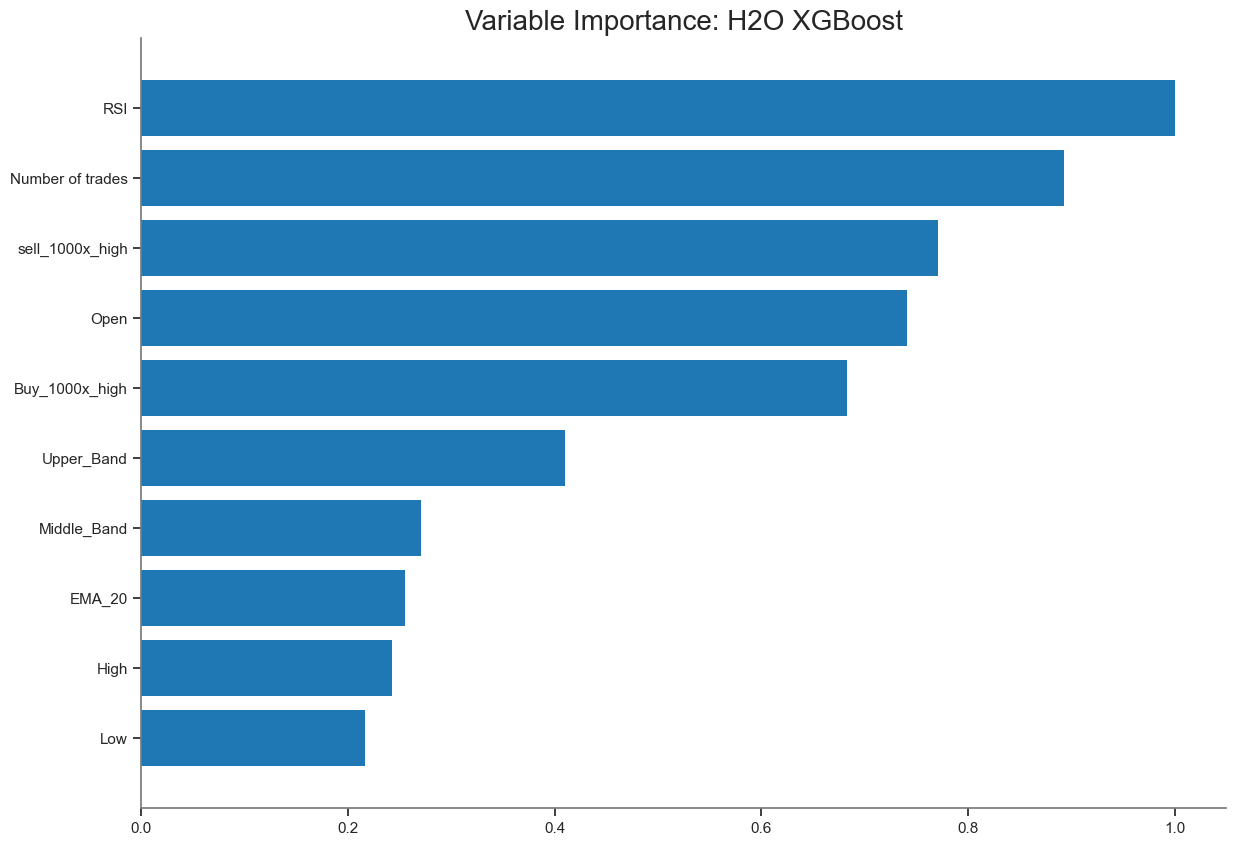

<Figure size 640x480 with 0 Axes>

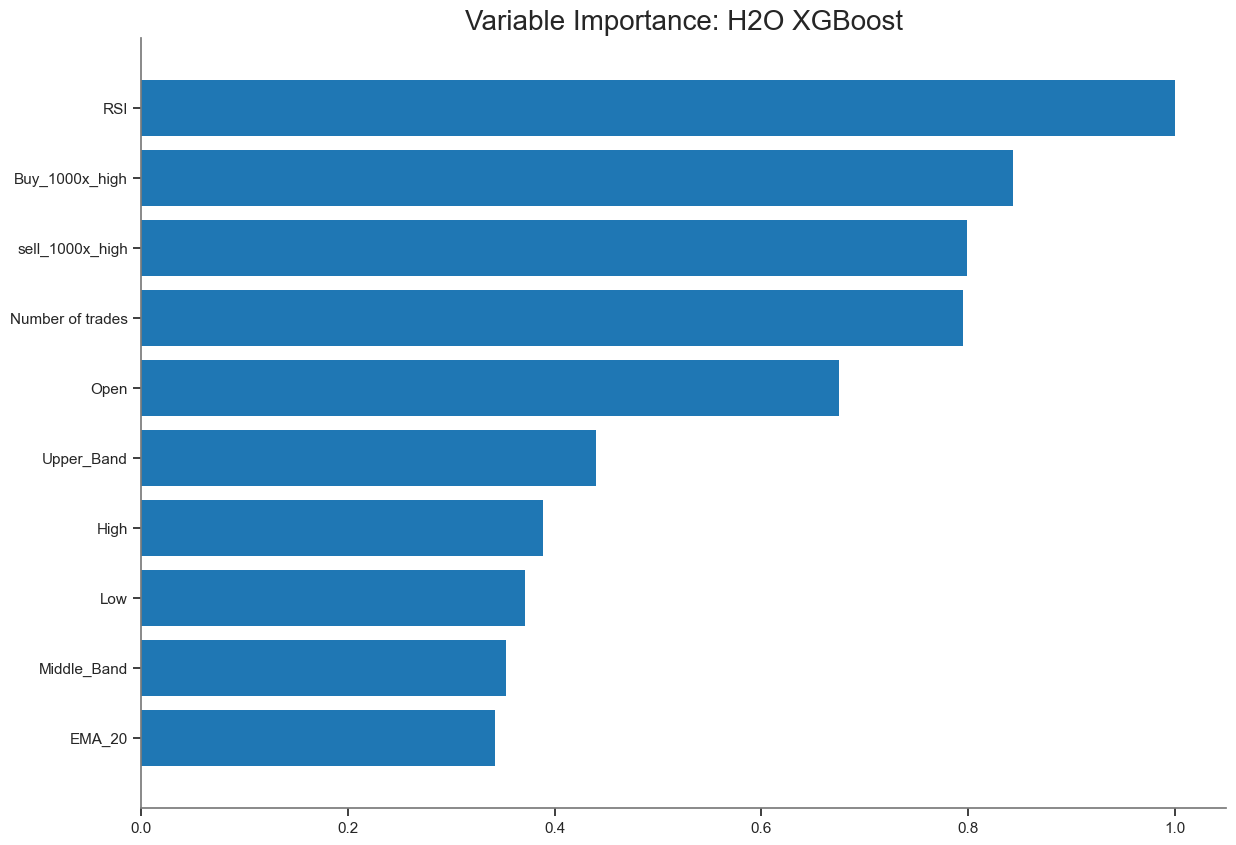

<Figure size 640x480 with 0 Axes>

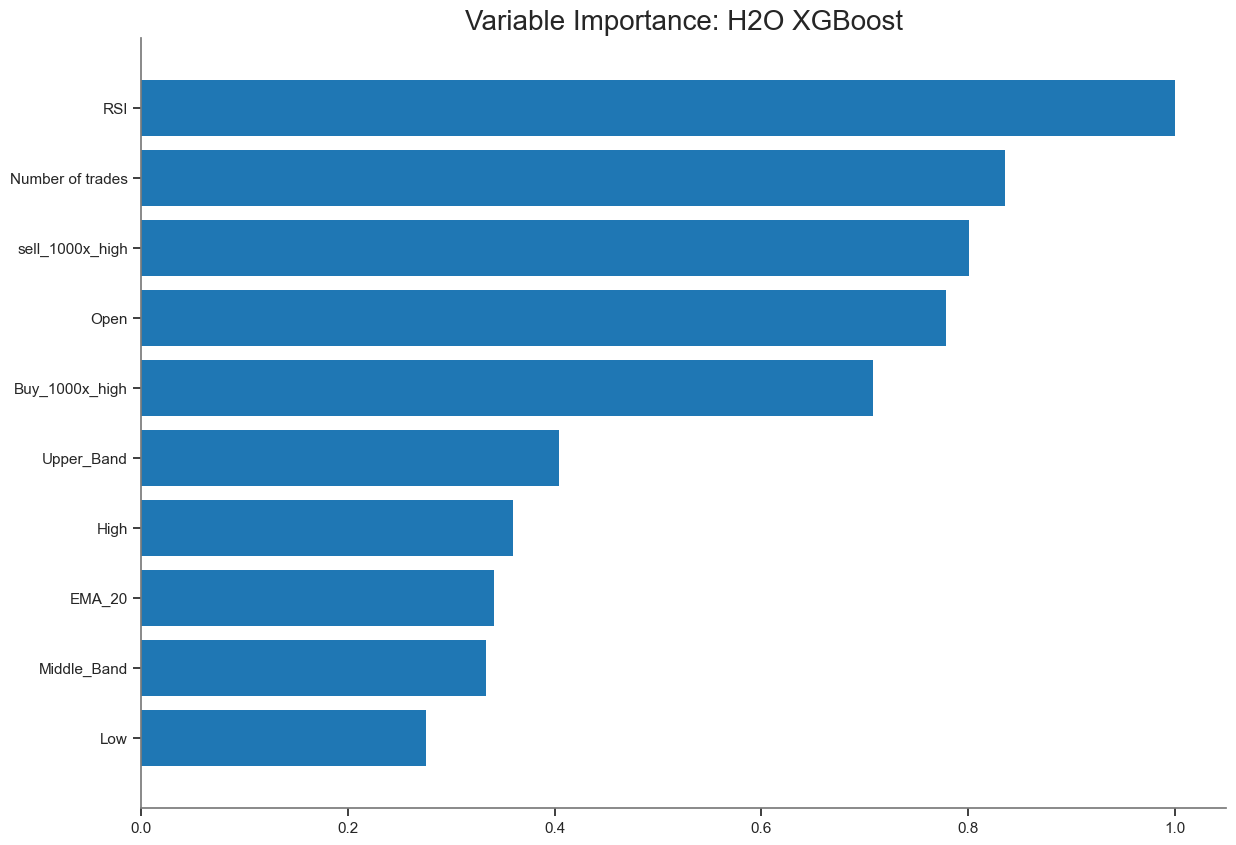

<Figure size 640x480 with 0 Axes>

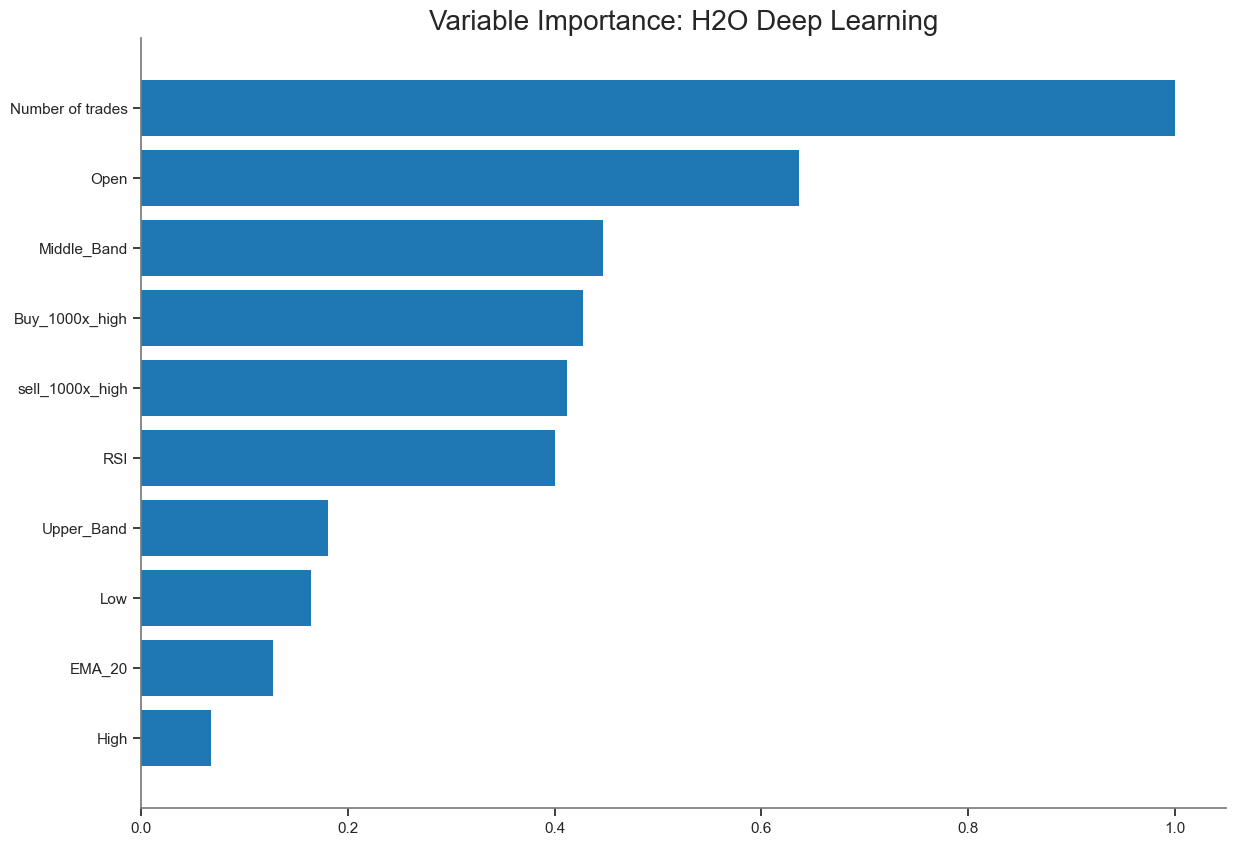

<Figure size 640x480 with 0 Axes>

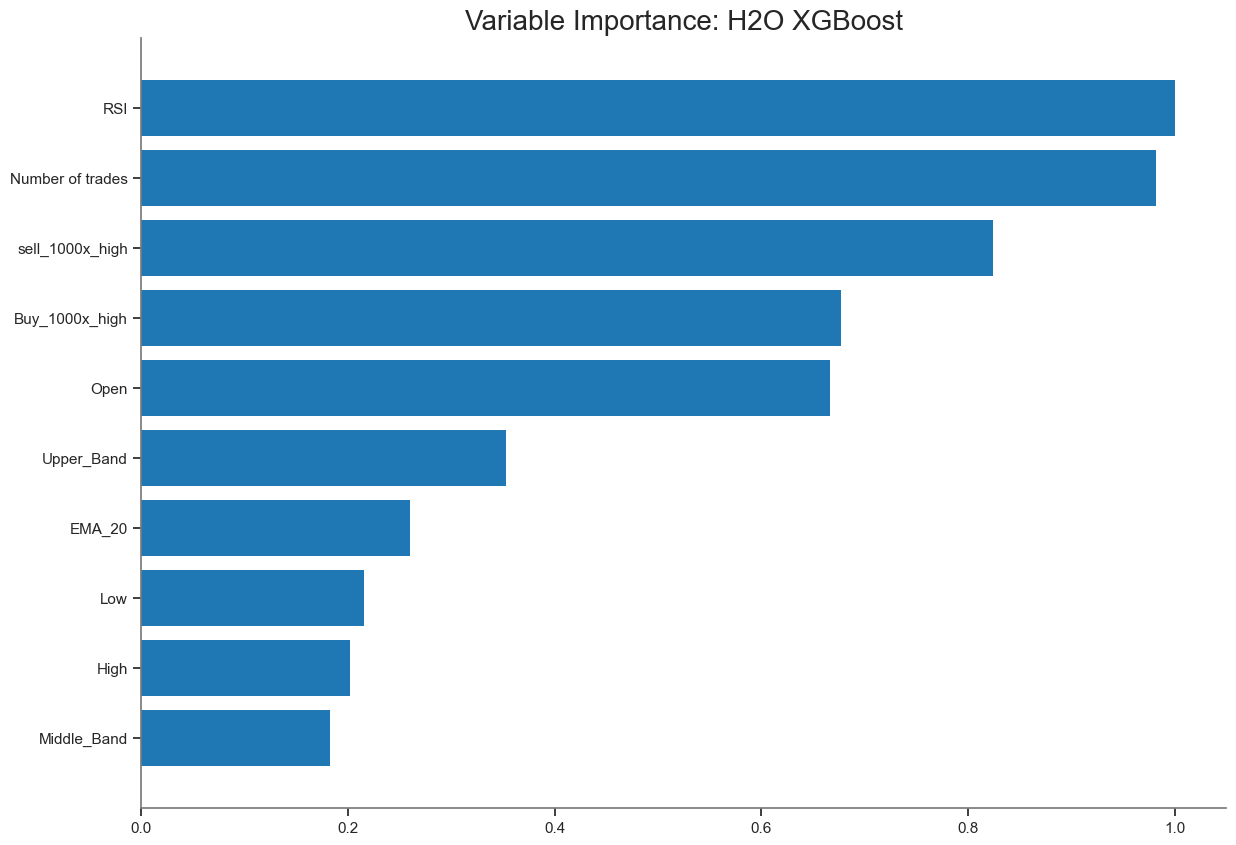

<Figure size 640x480 with 0 Axes>

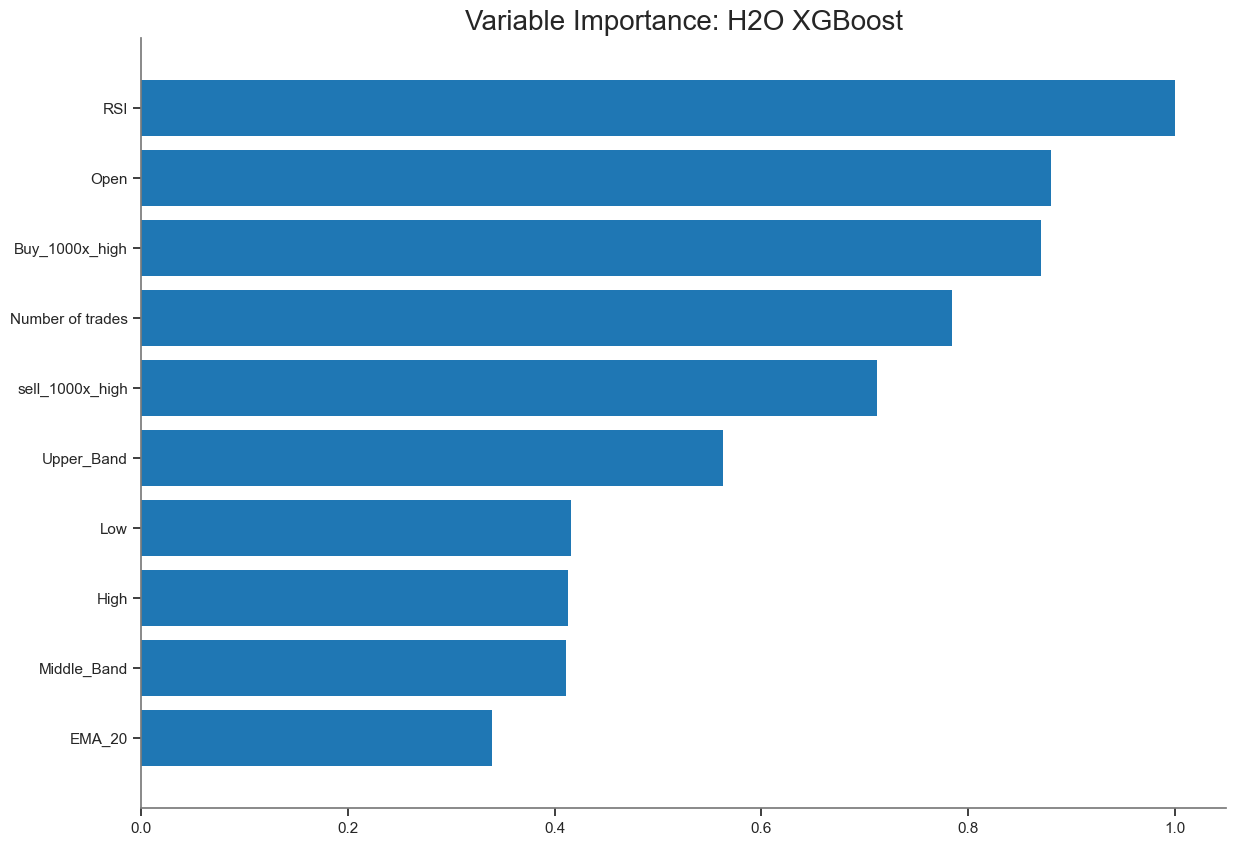

<Figure size 640x480 with 0 Axes>

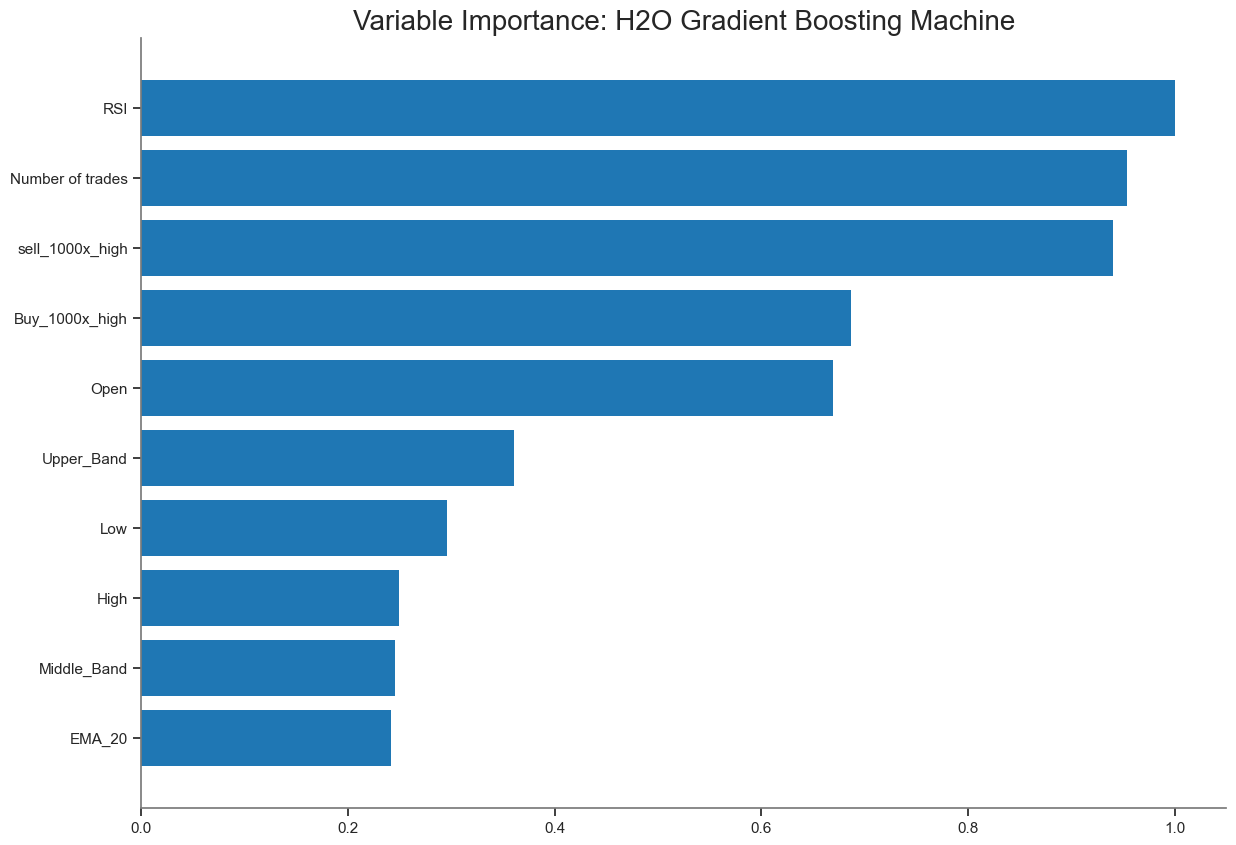

<Figure size 640x480 with 0 Axes>

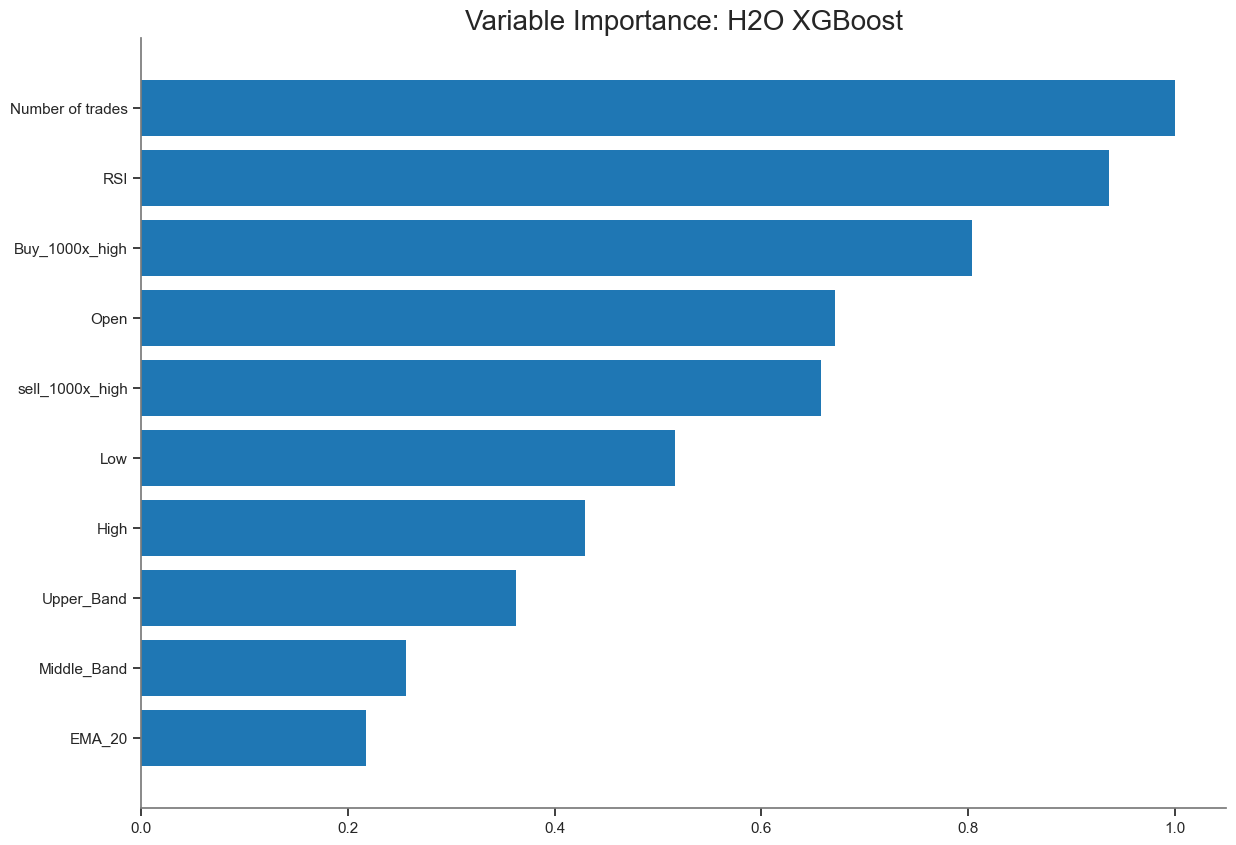

<Figure size 640x480 with 0 Axes>

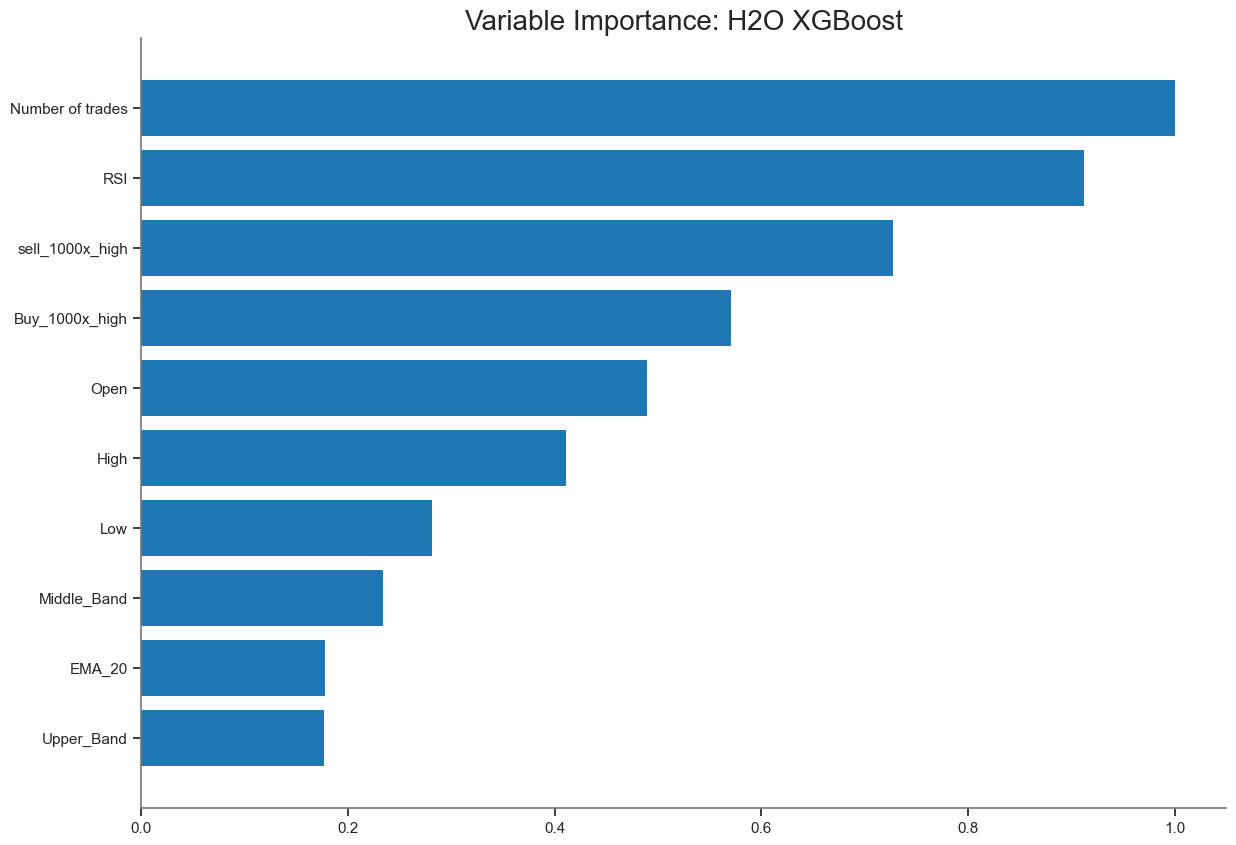

<Figure size 640x480 with 0 Axes>

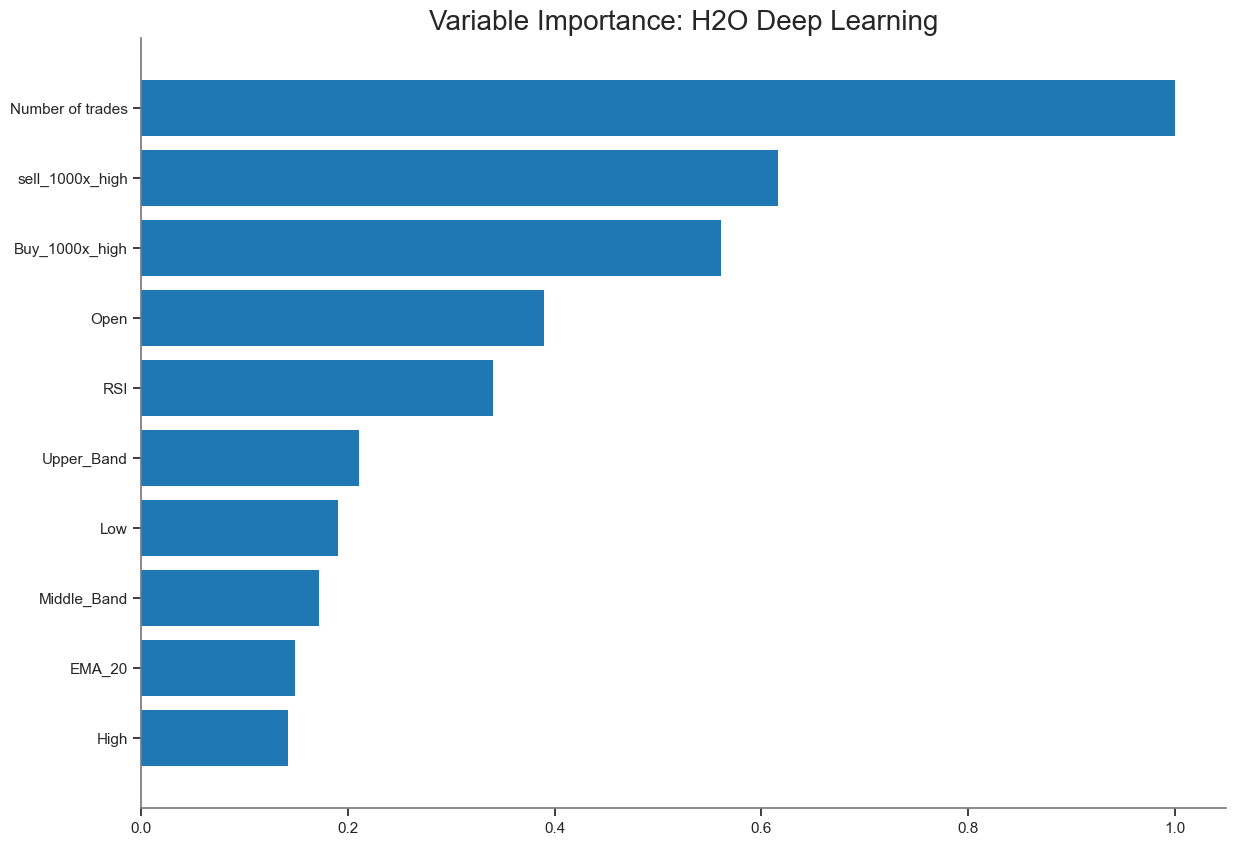

<Figure size 640x480 with 0 Axes>

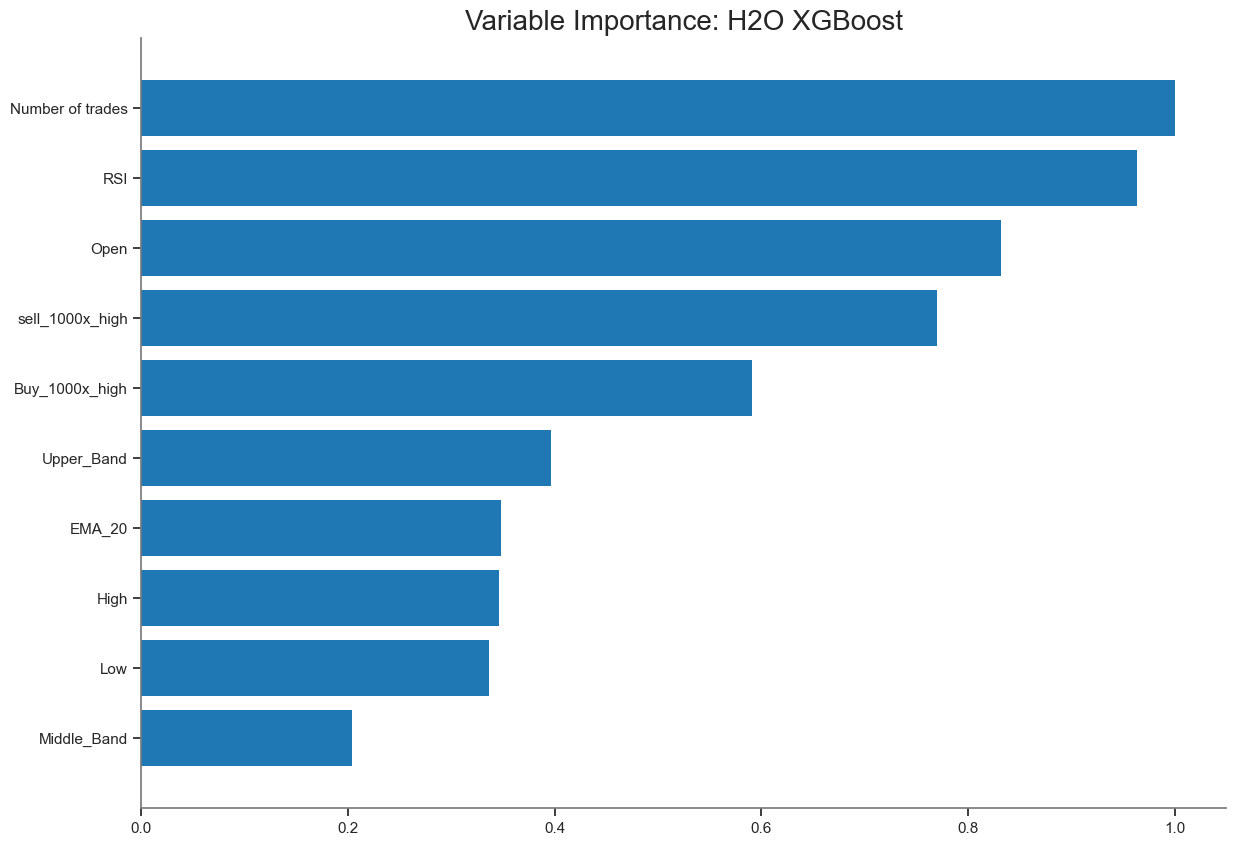

<Figure size 640x480 with 0 Axes>

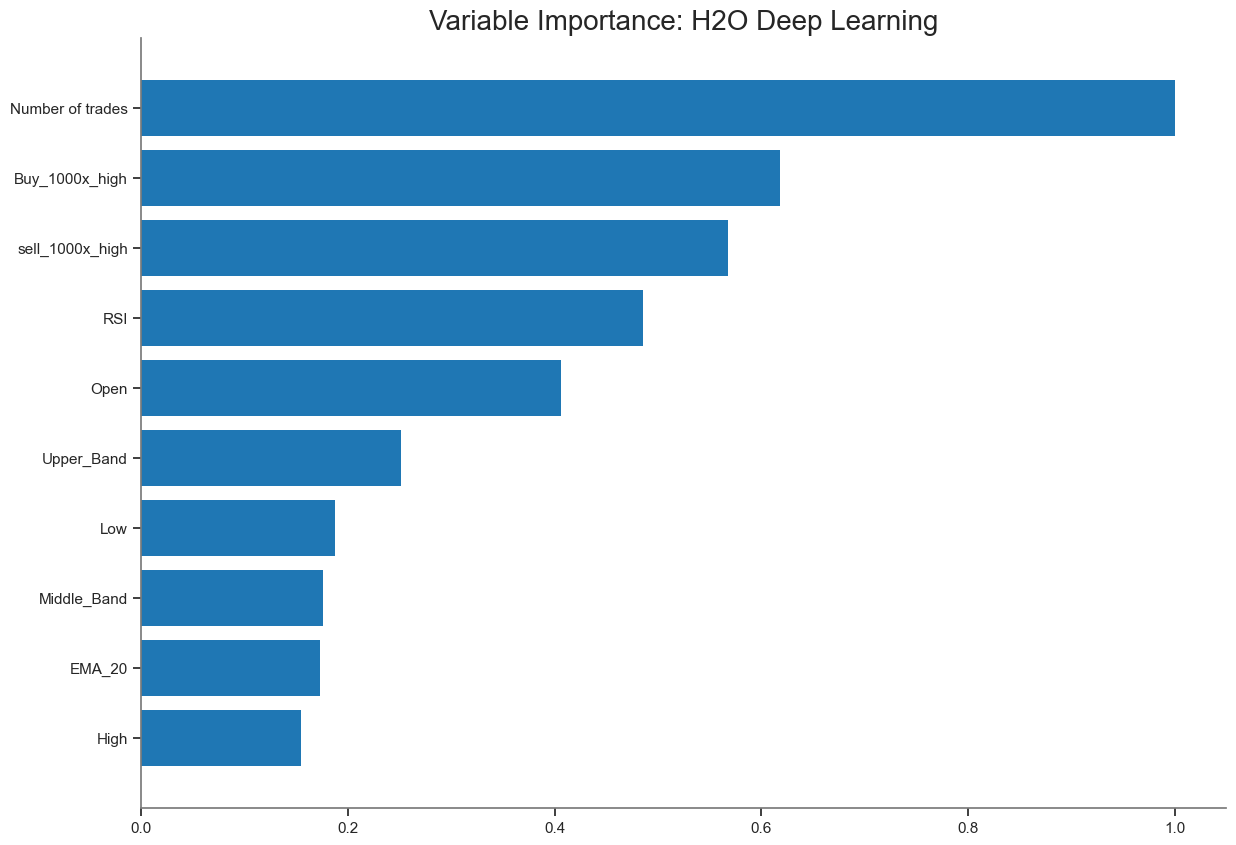

<Figure size 640x480 with 0 Axes>

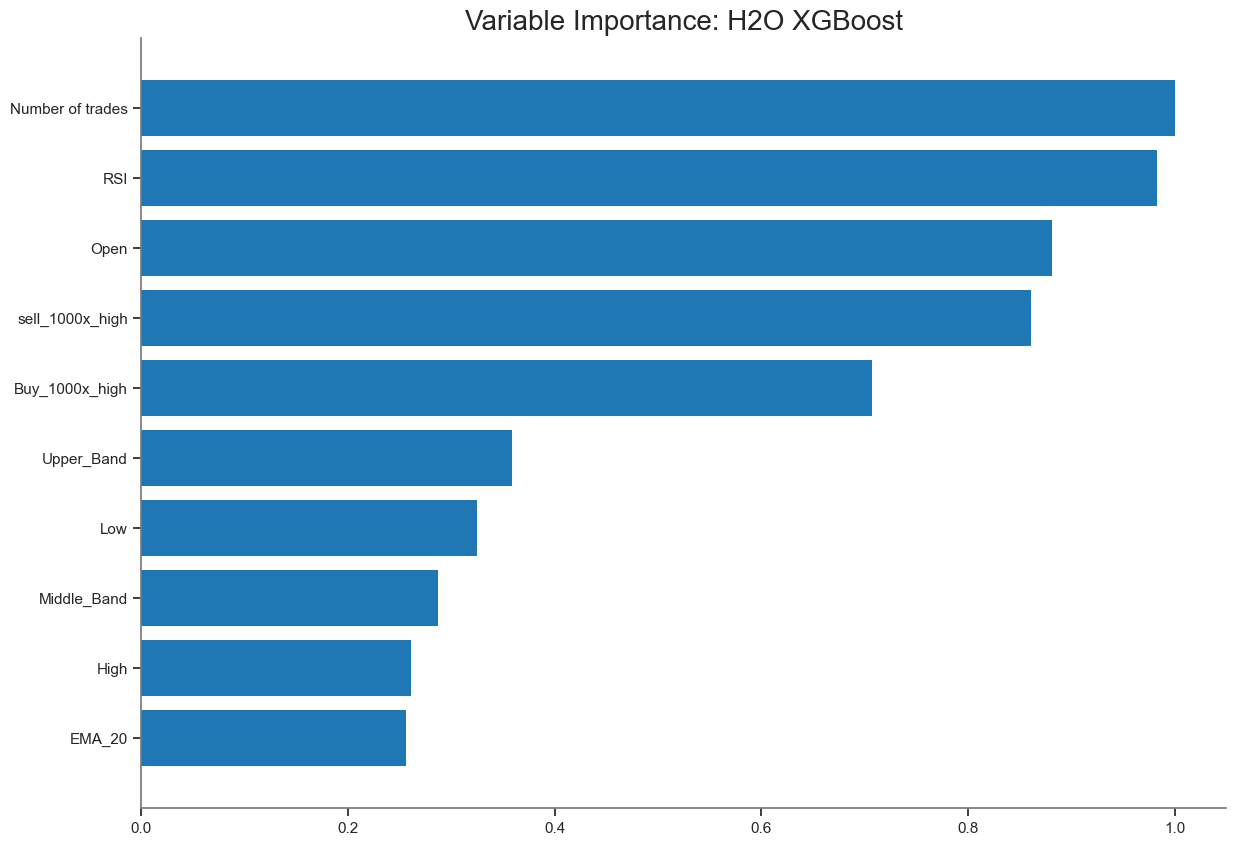

<Figure size 640x480 with 0 Axes>

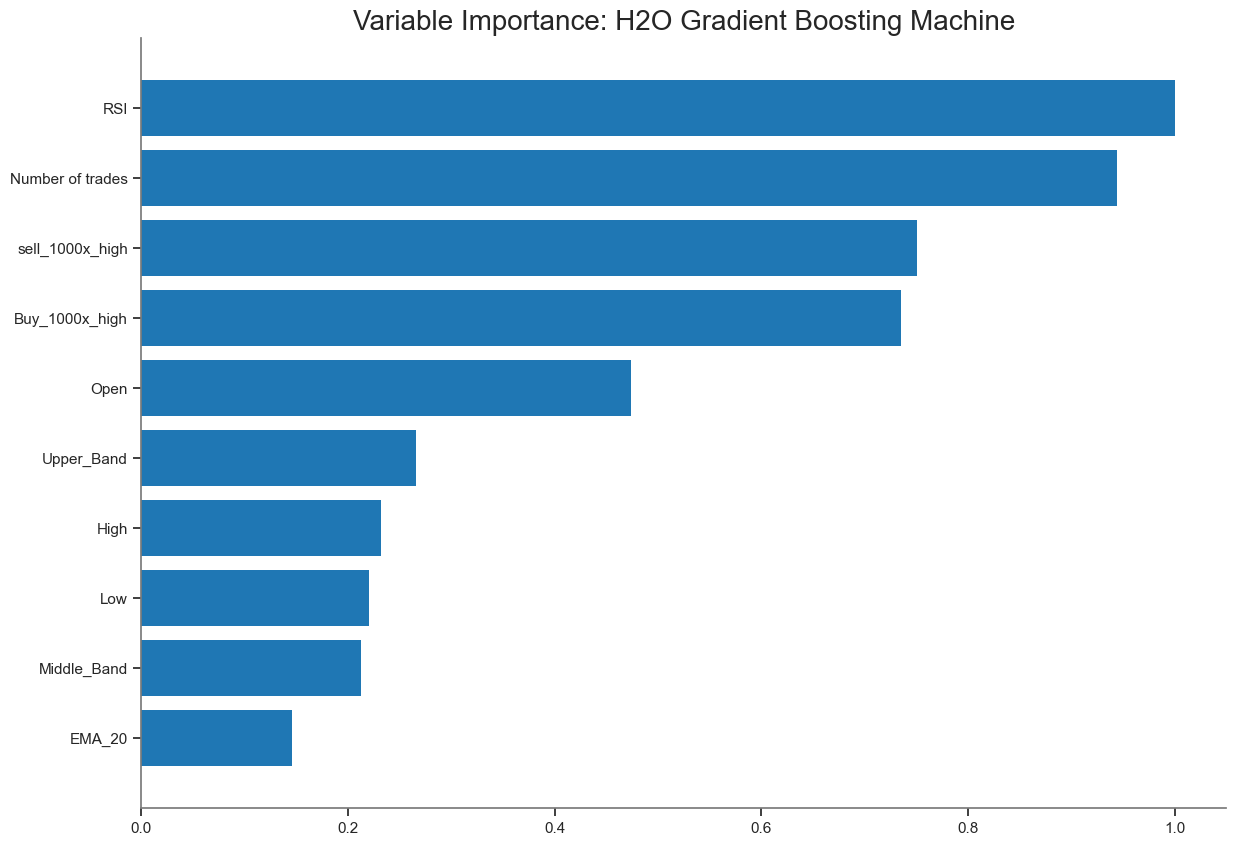

<Figure size 640x480 with 0 Axes>

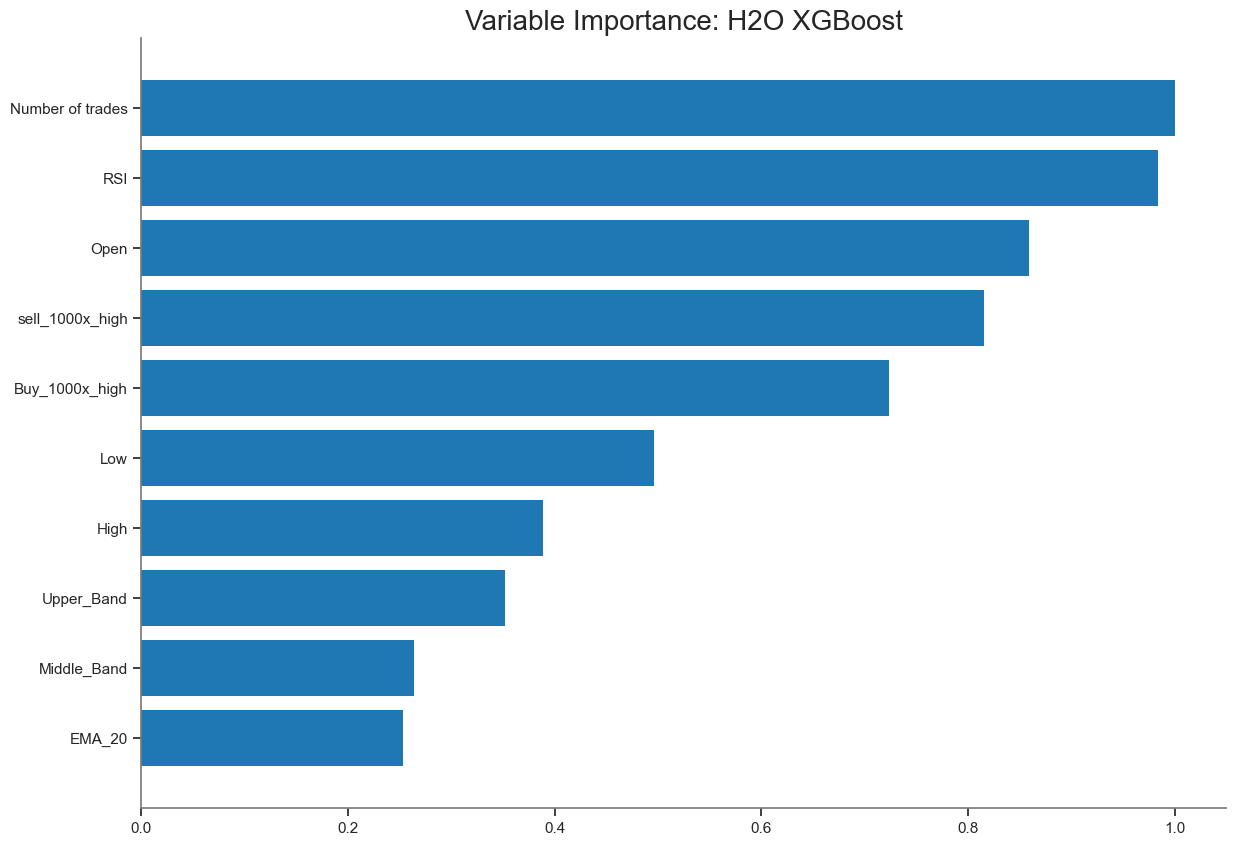

<Figure size 640x480 with 0 Axes>

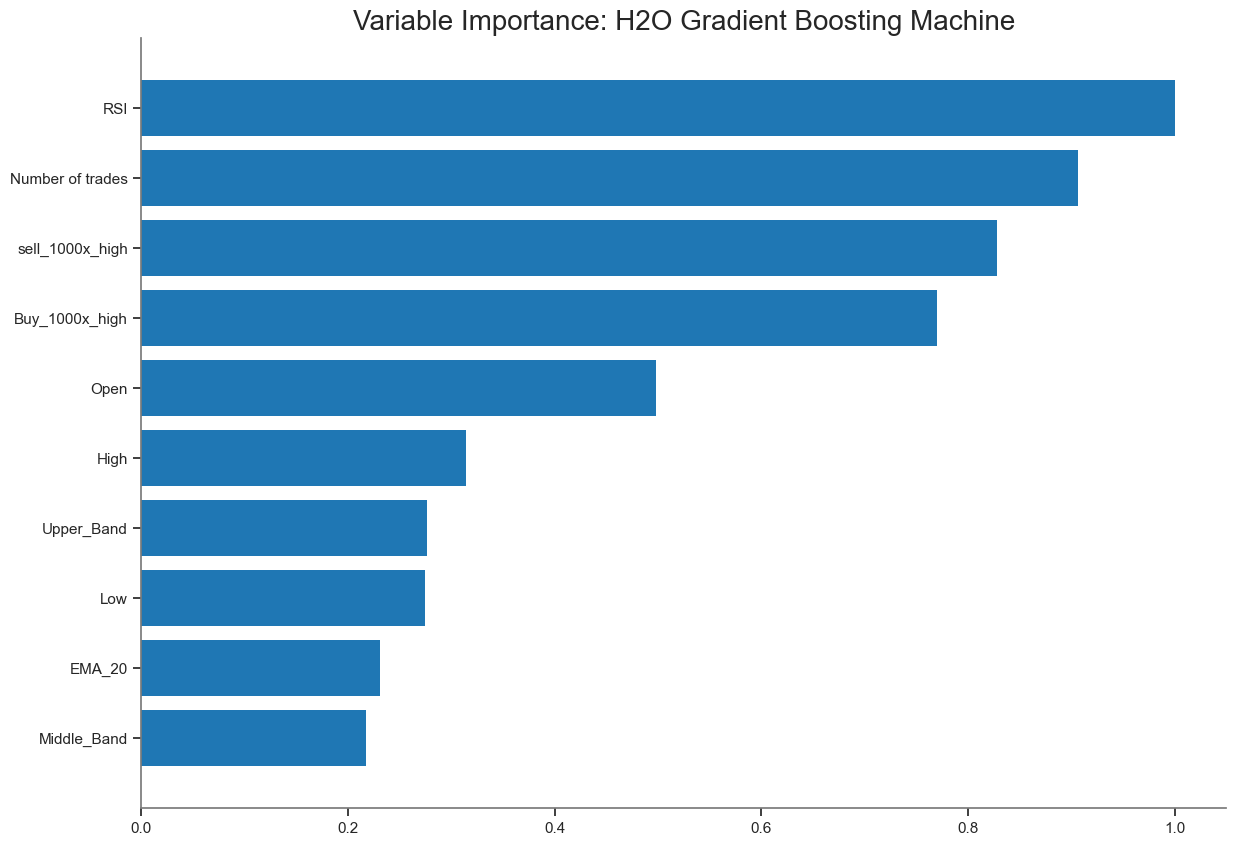

<Figure size 640x480 with 0 Axes>

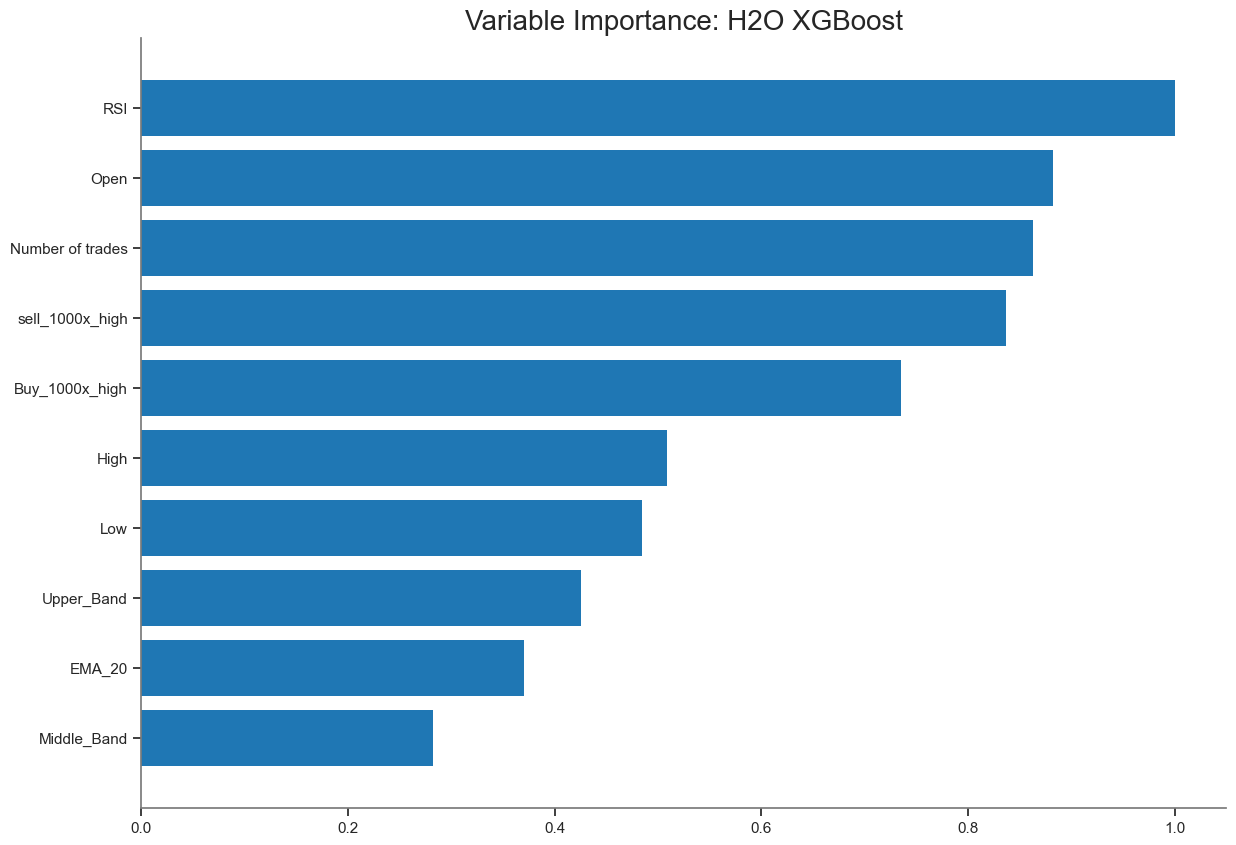

<Figure size 640x480 with 0 Axes>

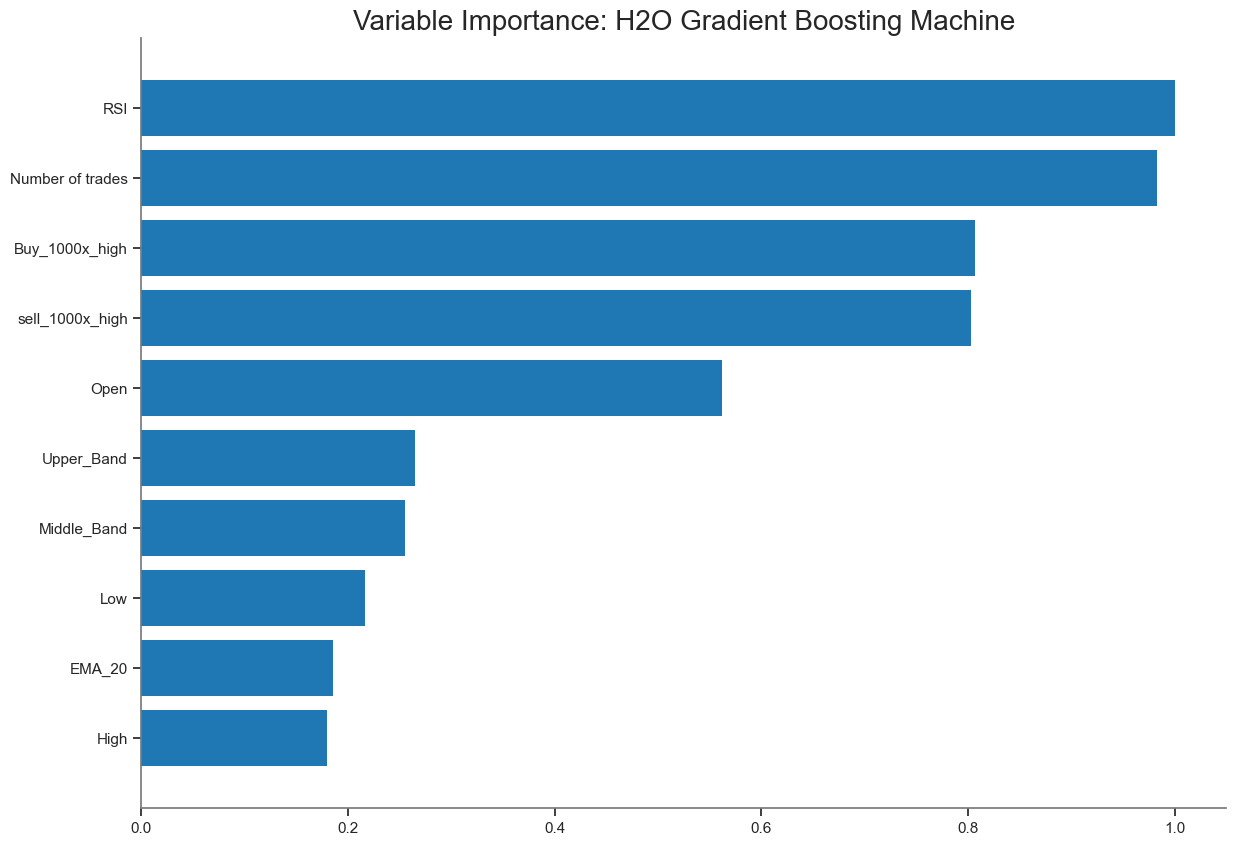

<Figure size 640x480 with 0 Axes>

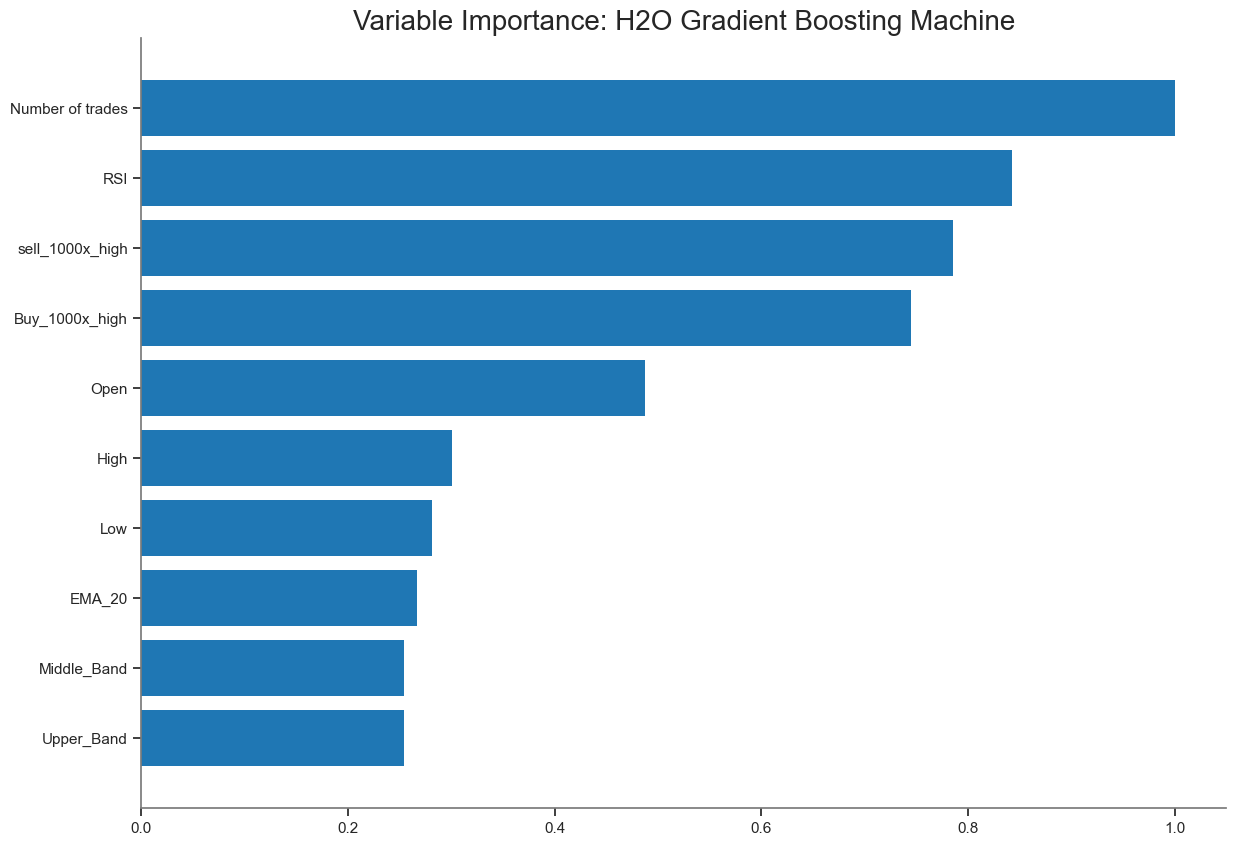

<Figure size 640x480 with 0 Axes>

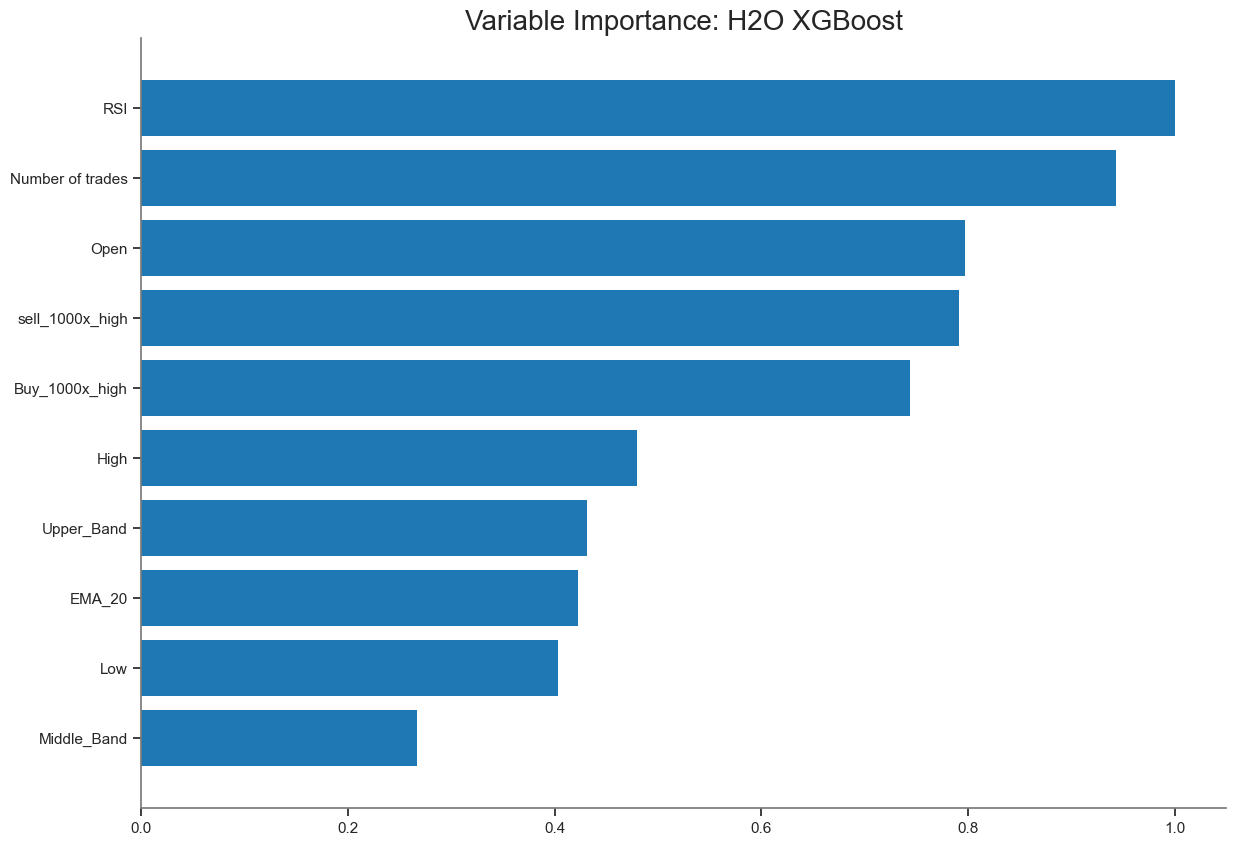

<Figure size 640x480 with 0 Axes>

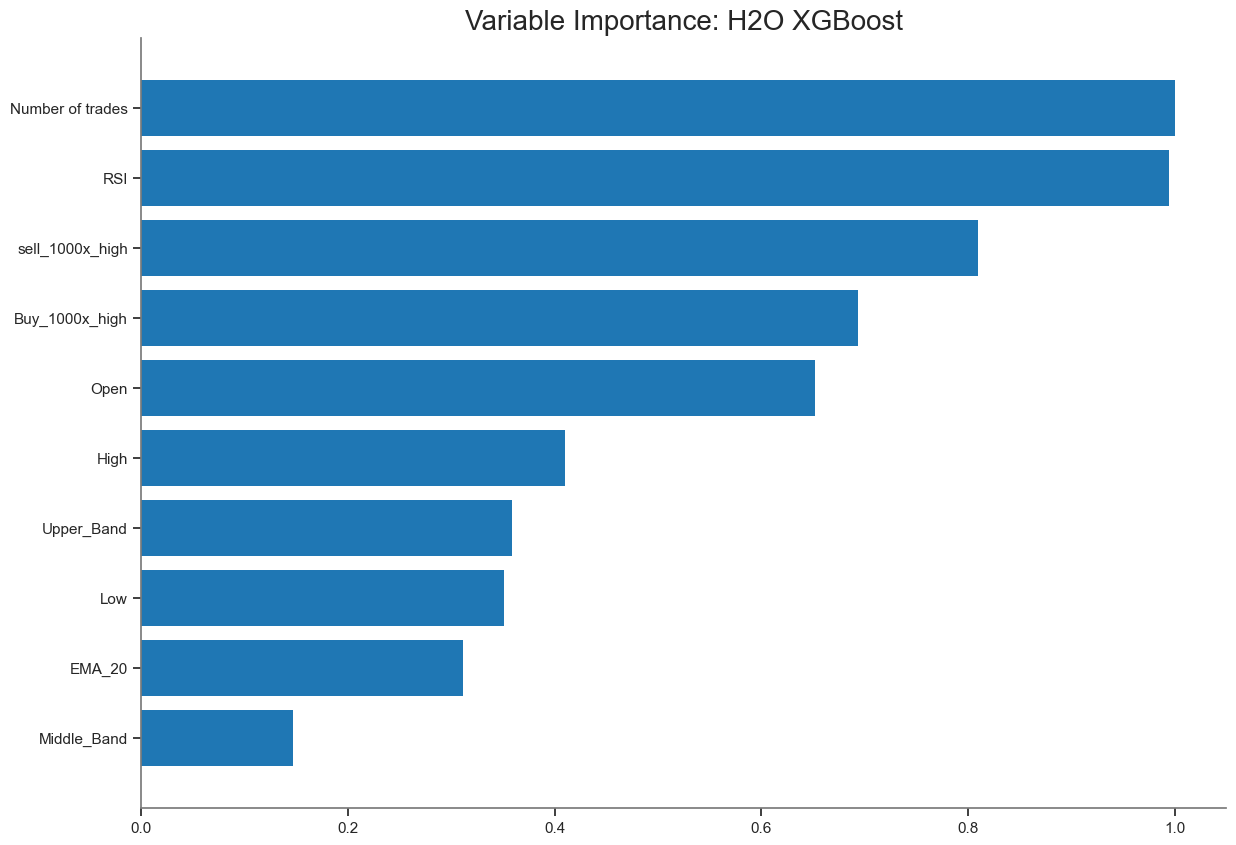

<Figure size 640x480 with 0 Axes>

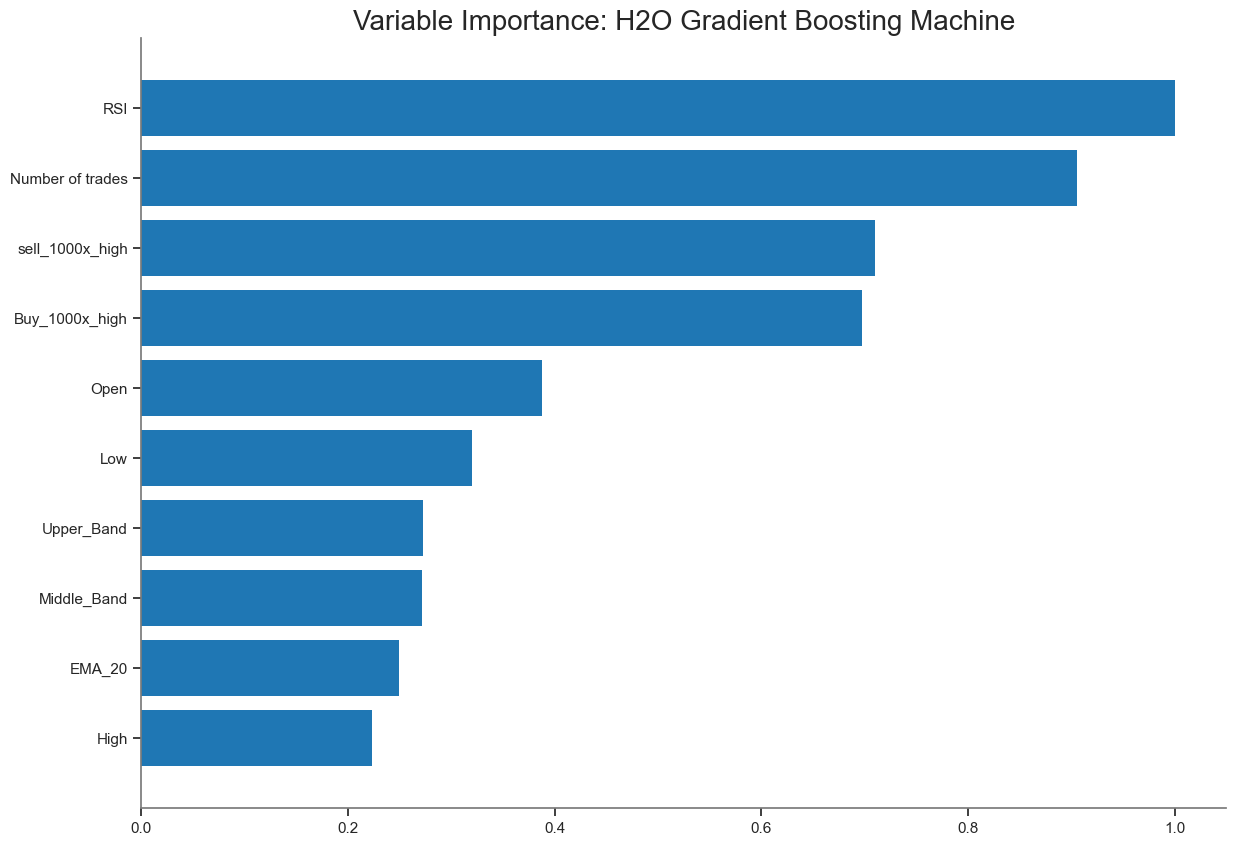

<Figure size 640x480 with 0 Axes>

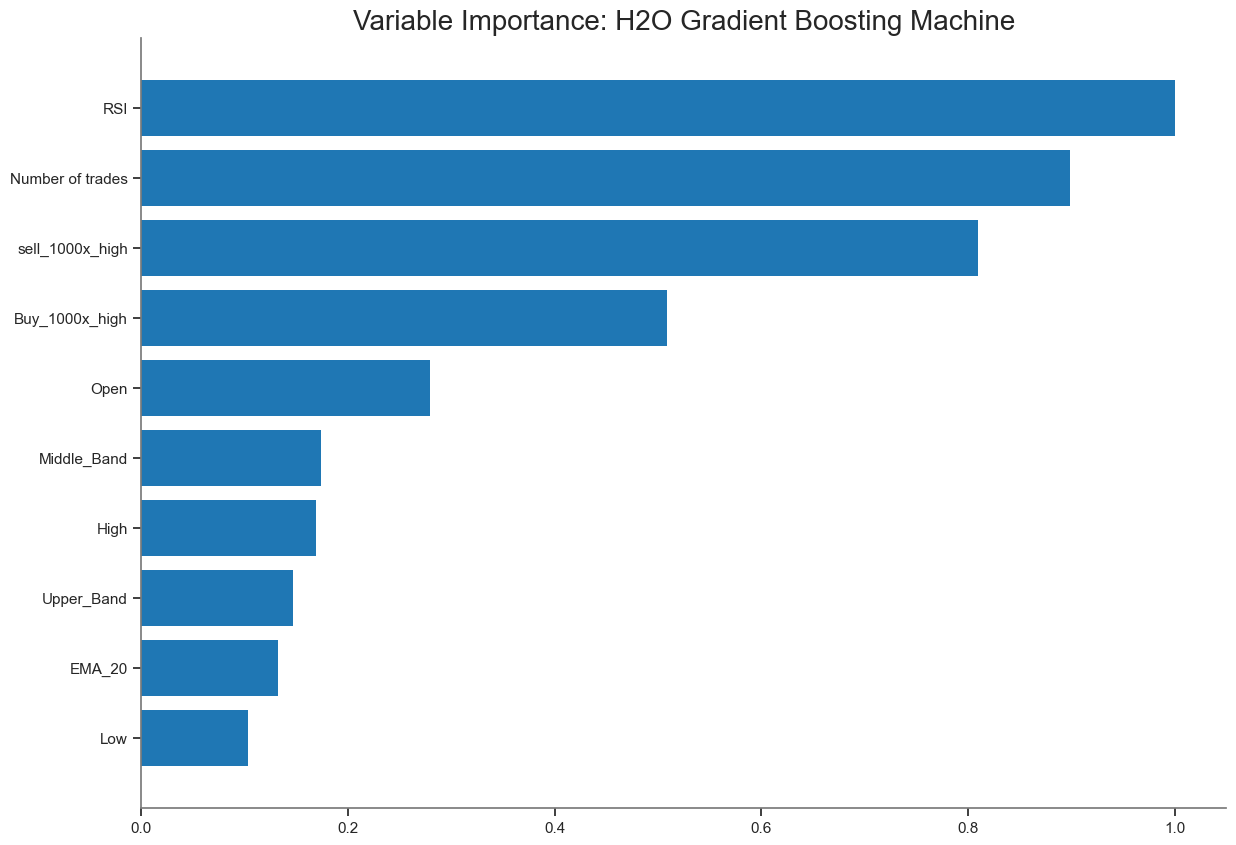

<Figure size 640x480 with 0 Axes>

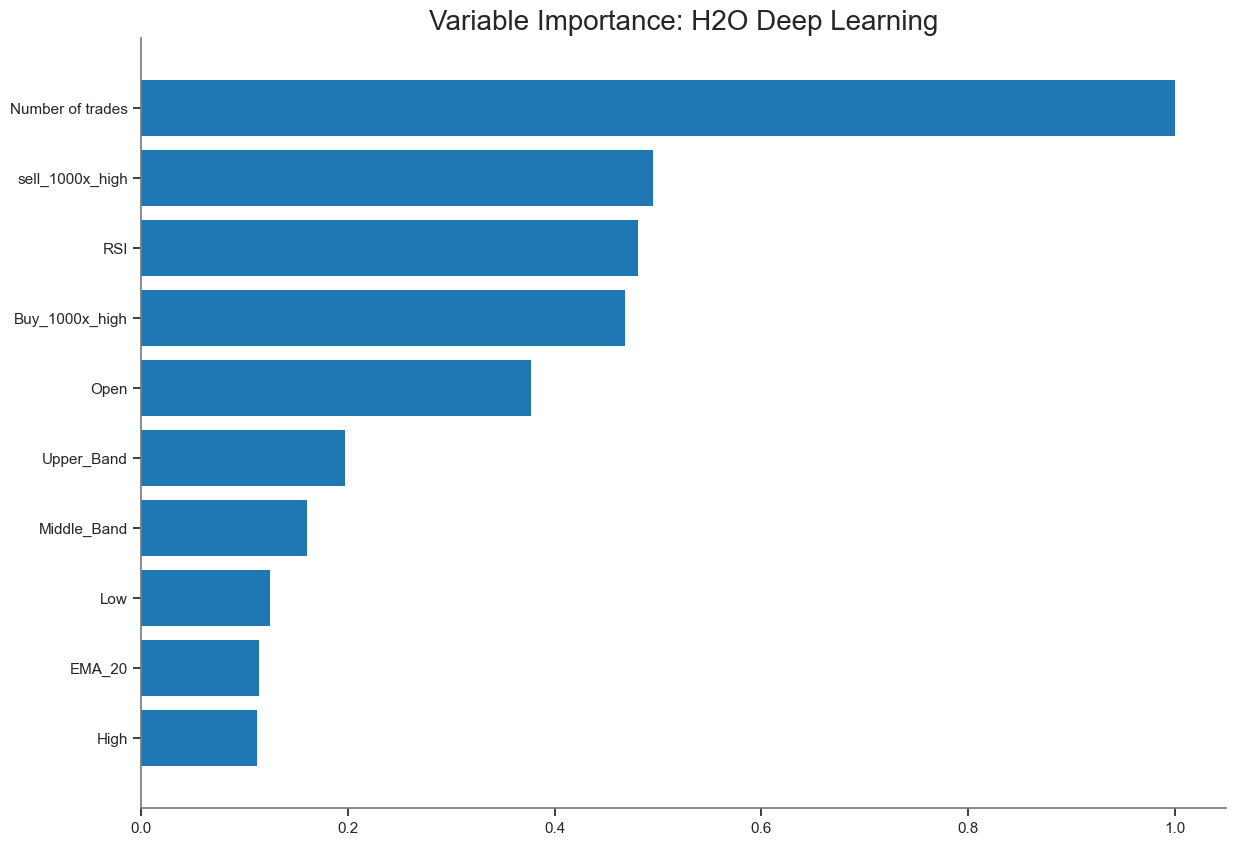

<Figure size 640x480 with 0 Axes>

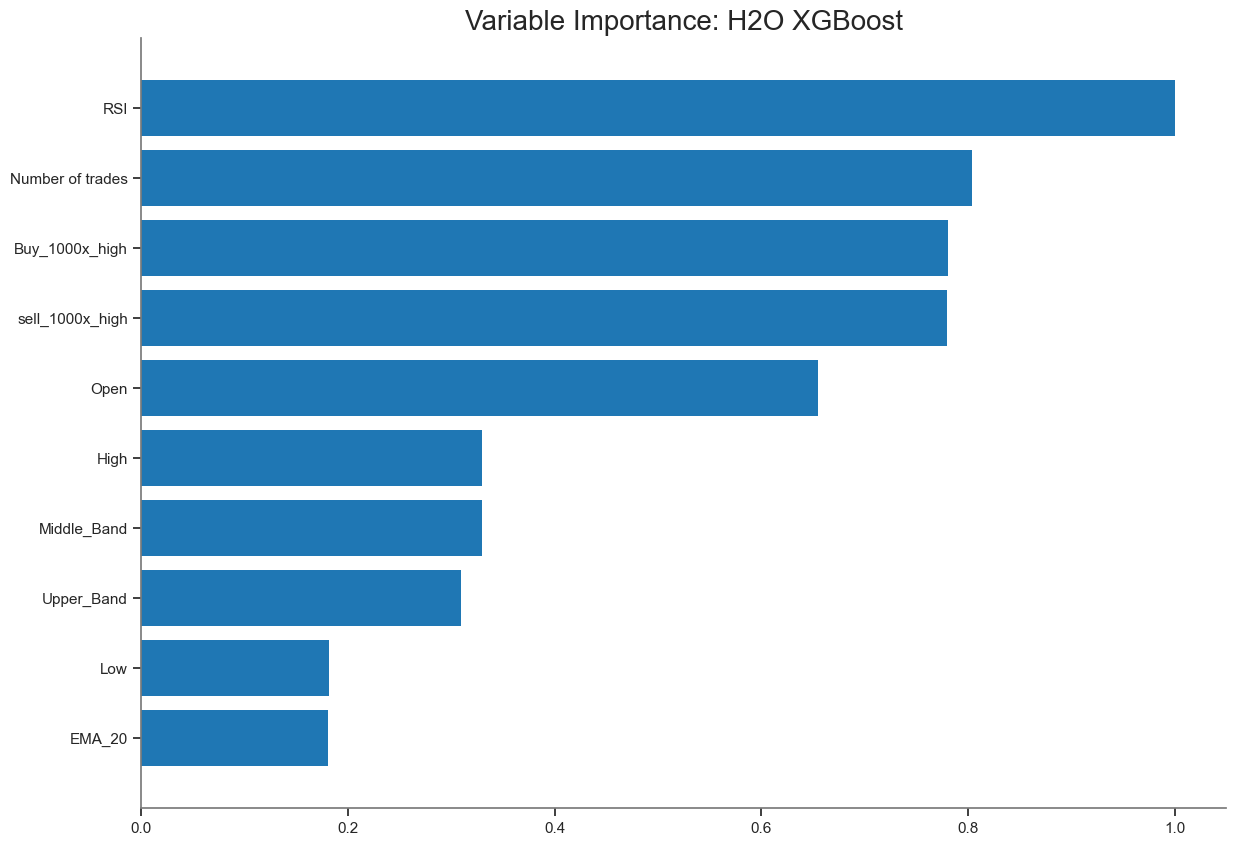

<Figure size 640x480 with 0 Axes>

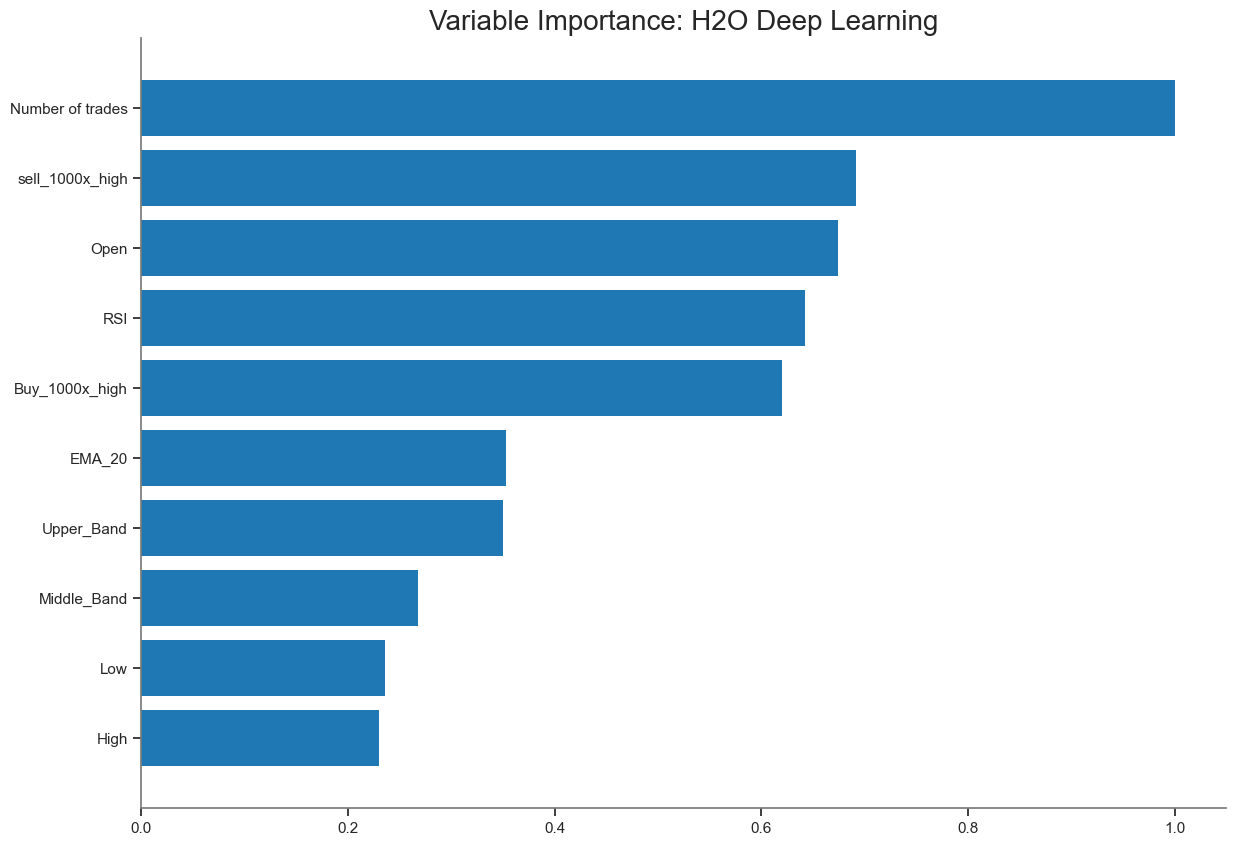

<Figure size 640x480 with 0 Axes>

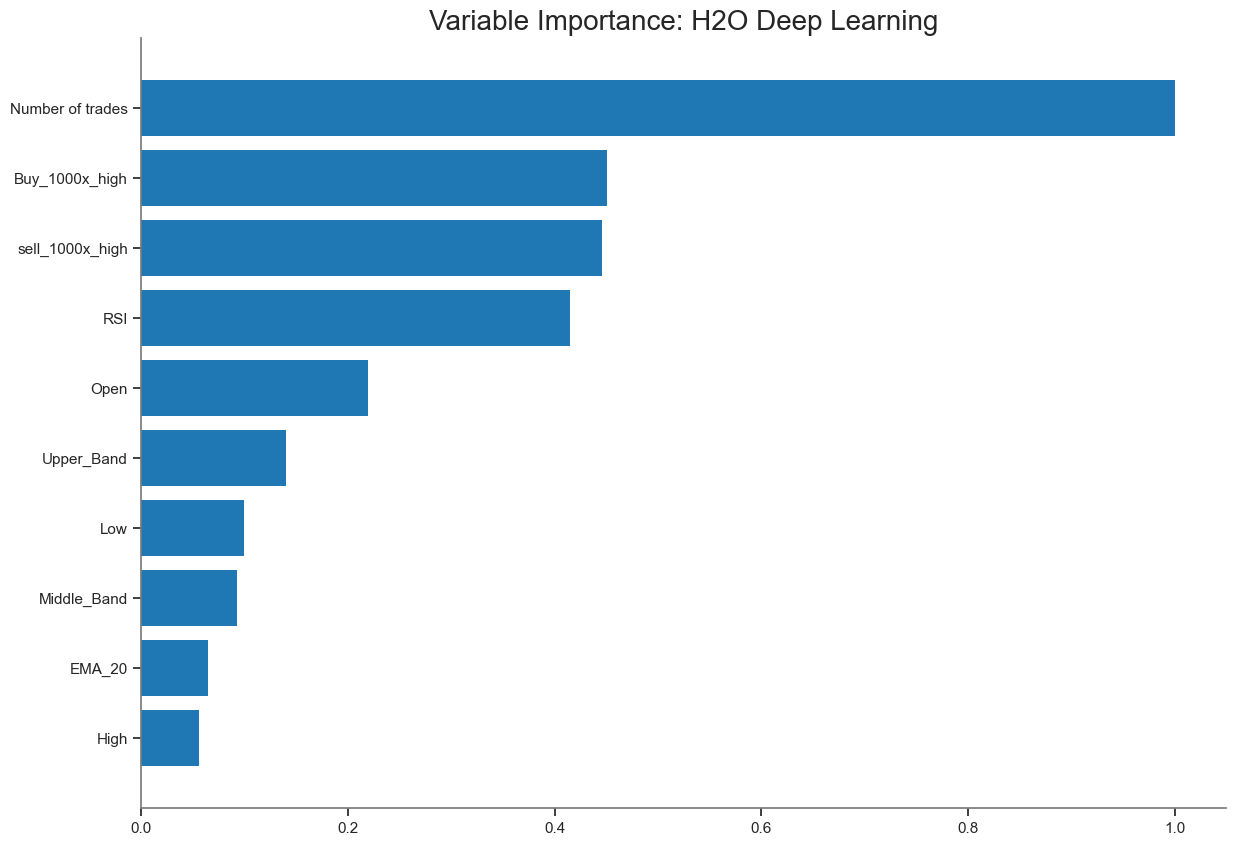

<Figure size 640x480 with 0 Axes>

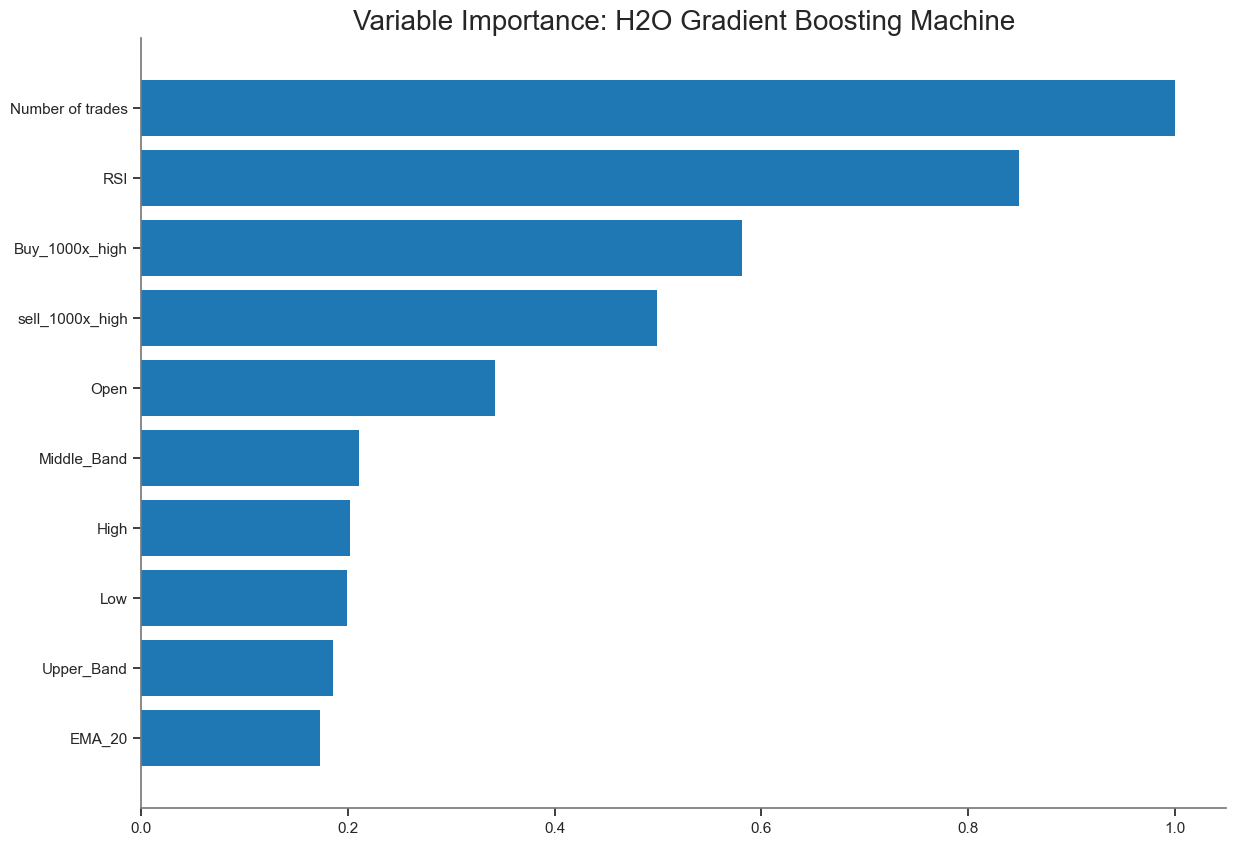

<Figure size 640x480 with 0 Axes>

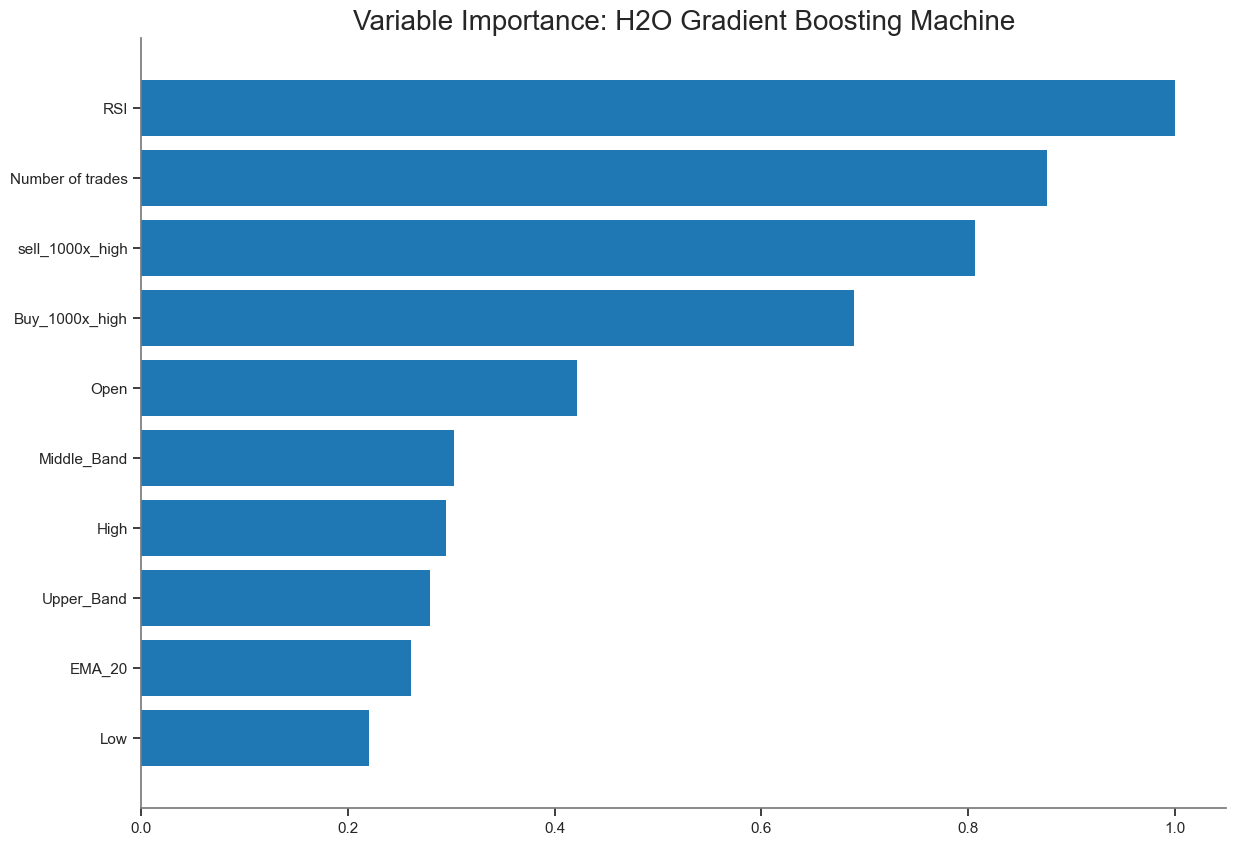

<Figure size 640x480 with 0 Axes>

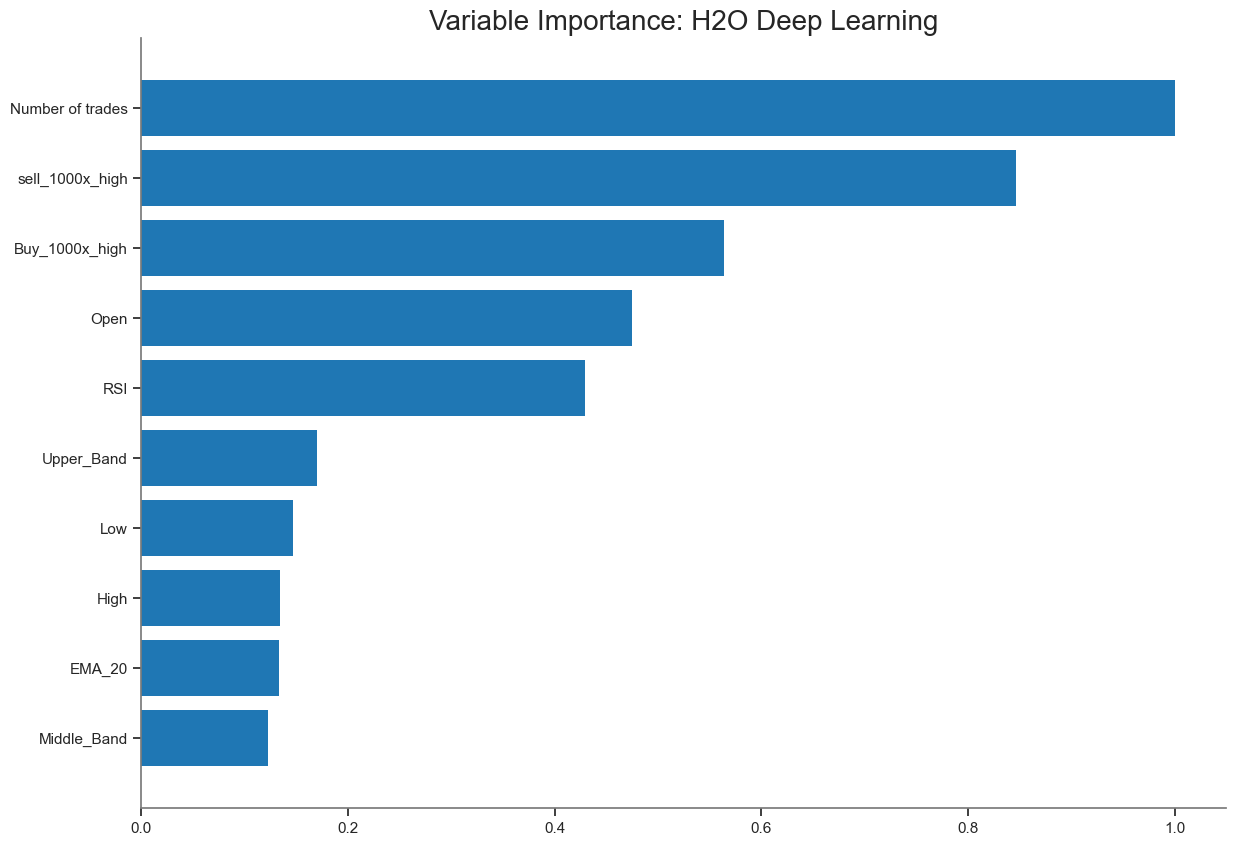

<Figure size 640x480 with 0 Axes>

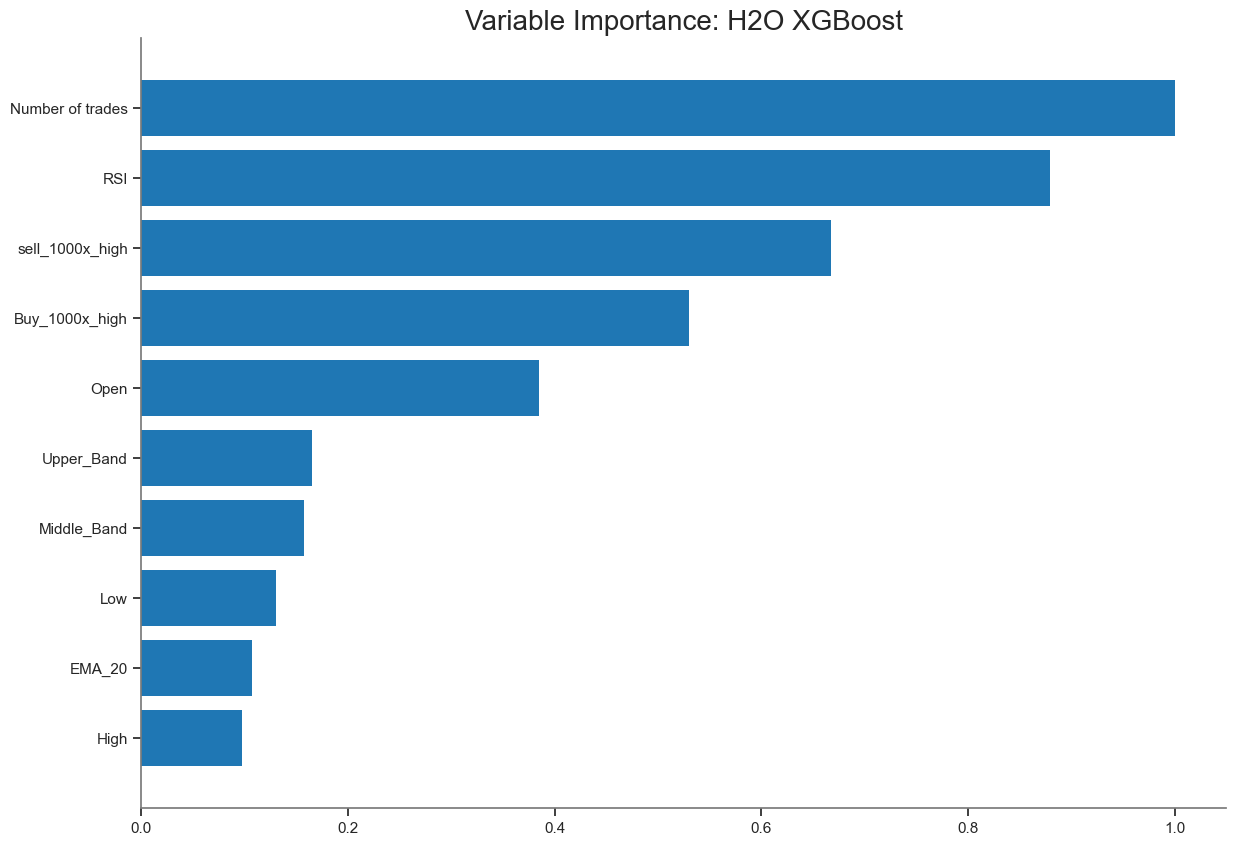

<Figure size 640x480 with 0 Axes>

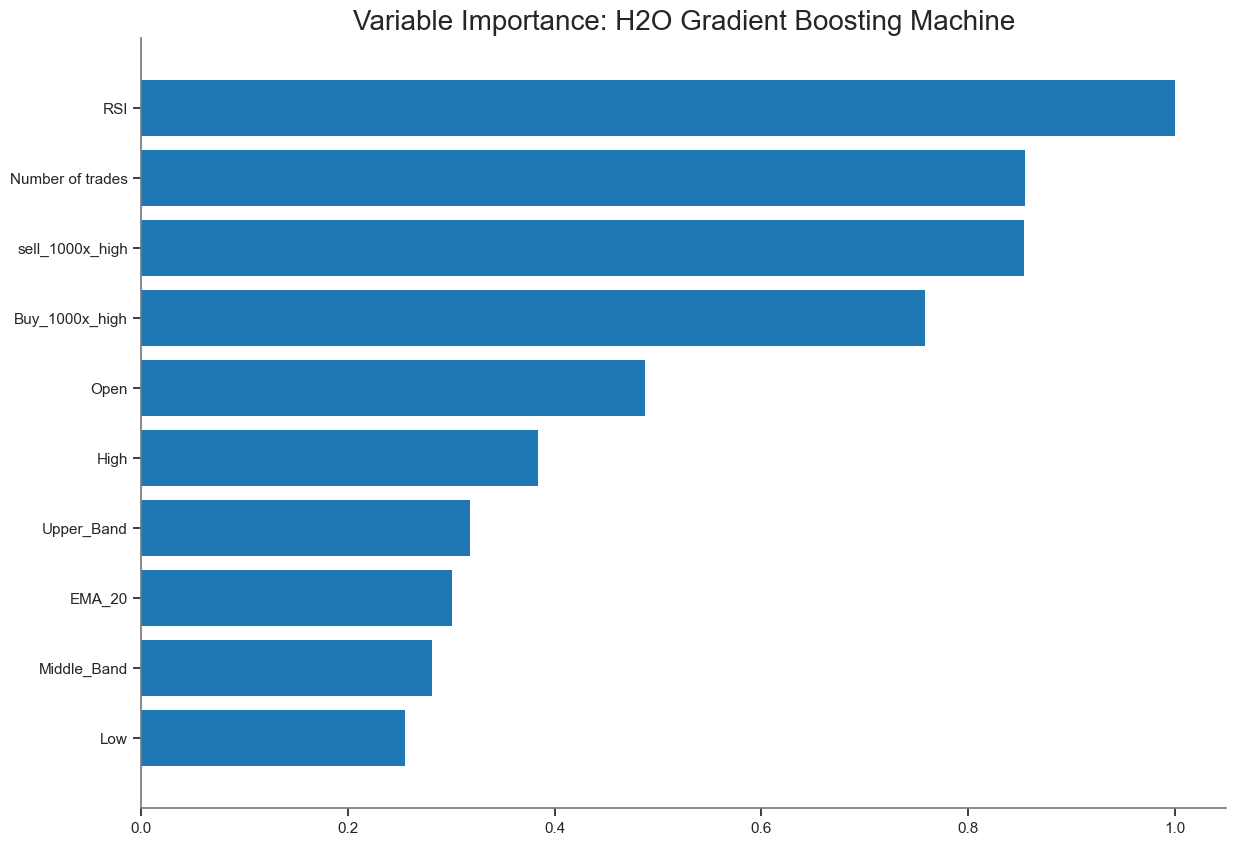

<Figure size 640x480 with 0 Axes>

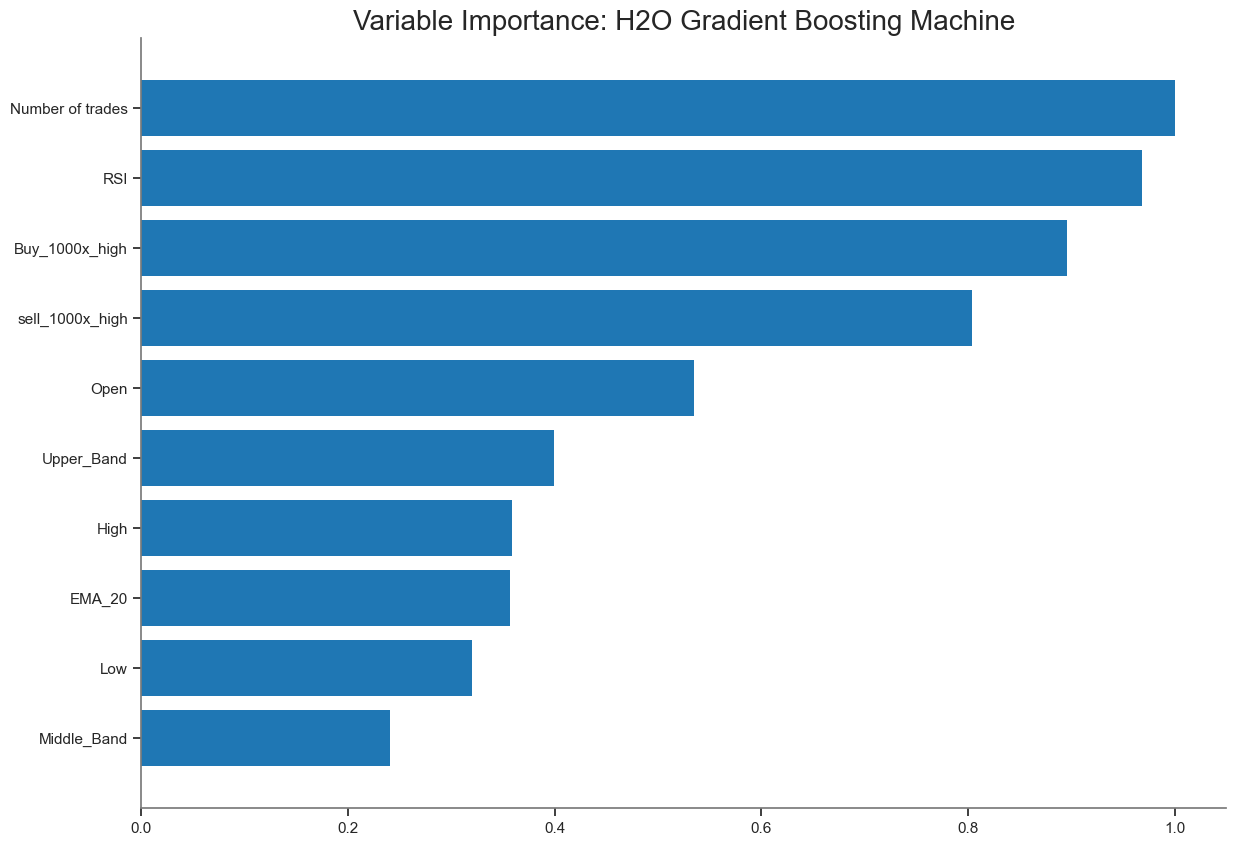

<Figure size 640x480 with 0 Axes>

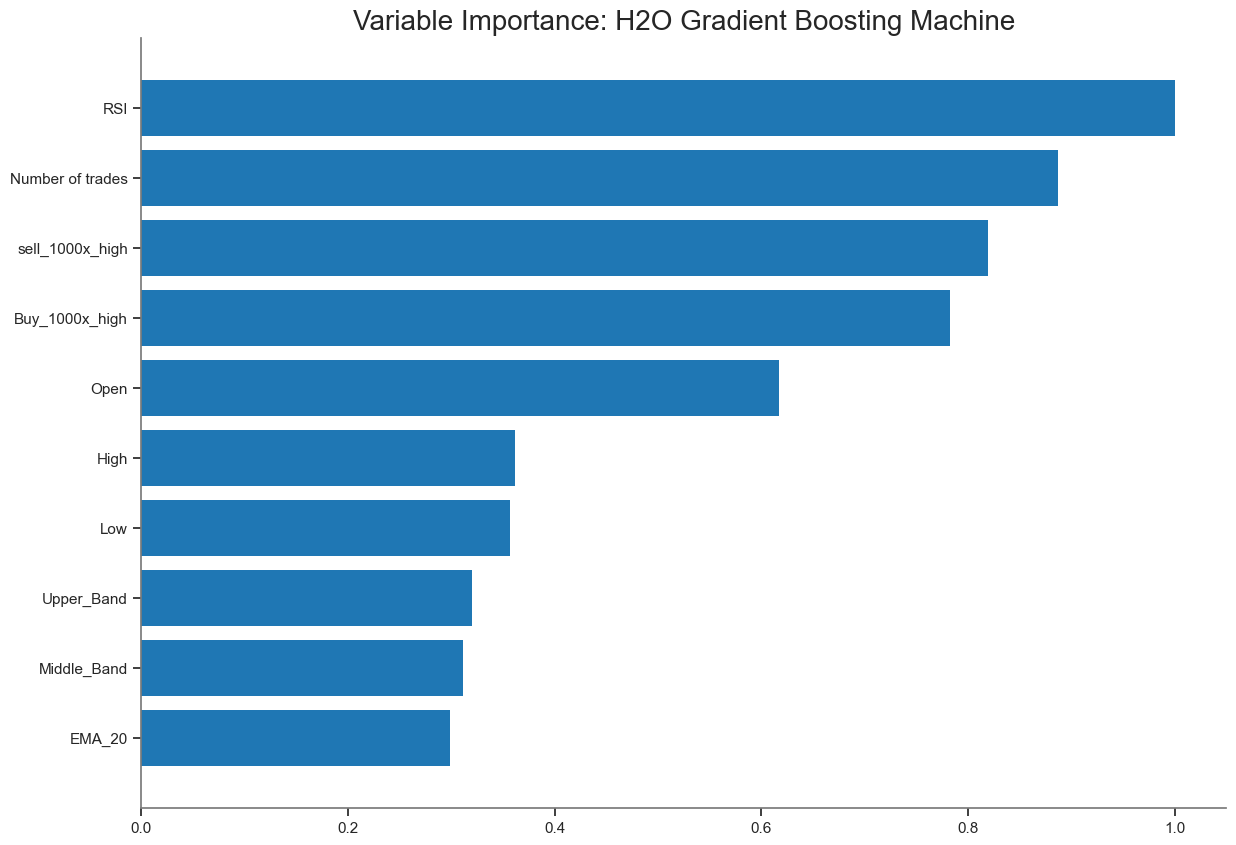

<Figure size 640x480 with 0 Axes>

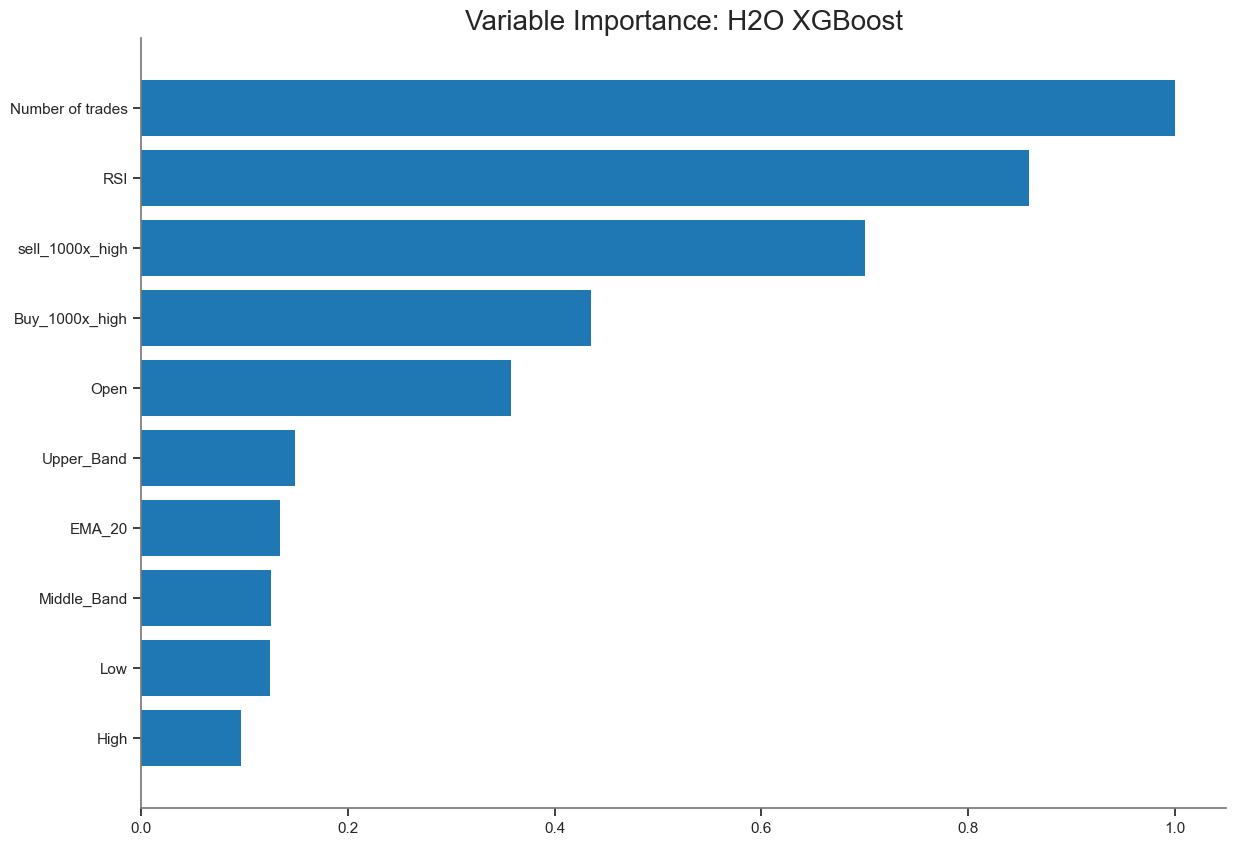

<Figure size 640x480 with 0 Axes>

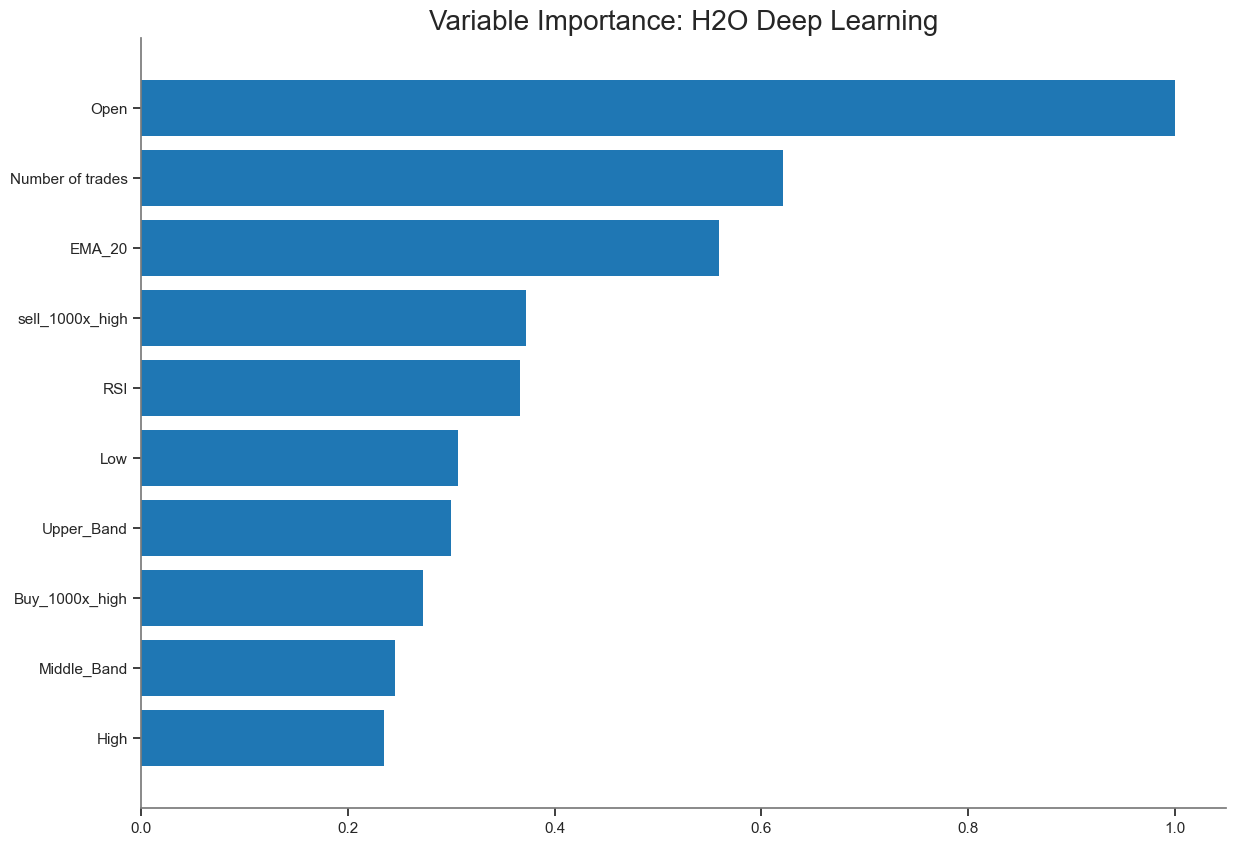

<Figure size 640x480 with 0 Axes>

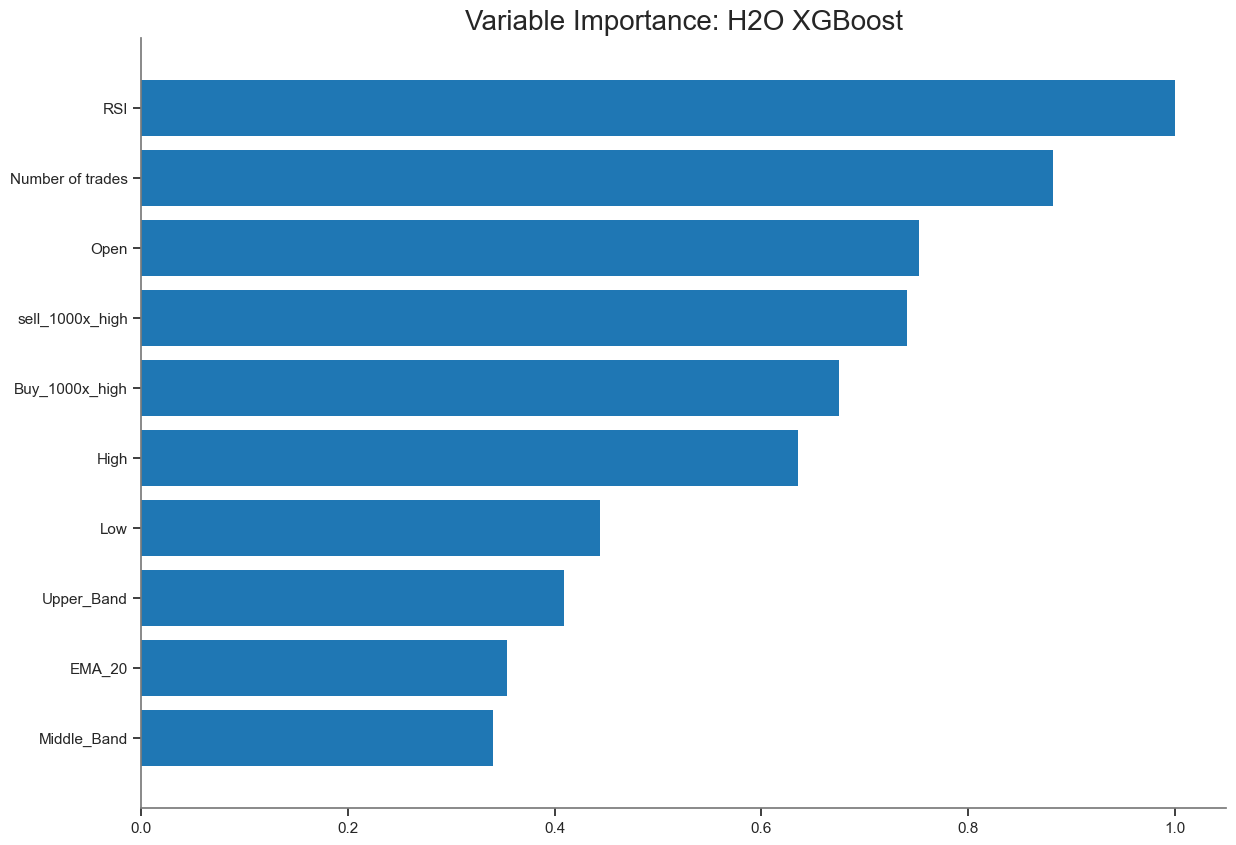

<Figure size 640x480 with 0 Axes>

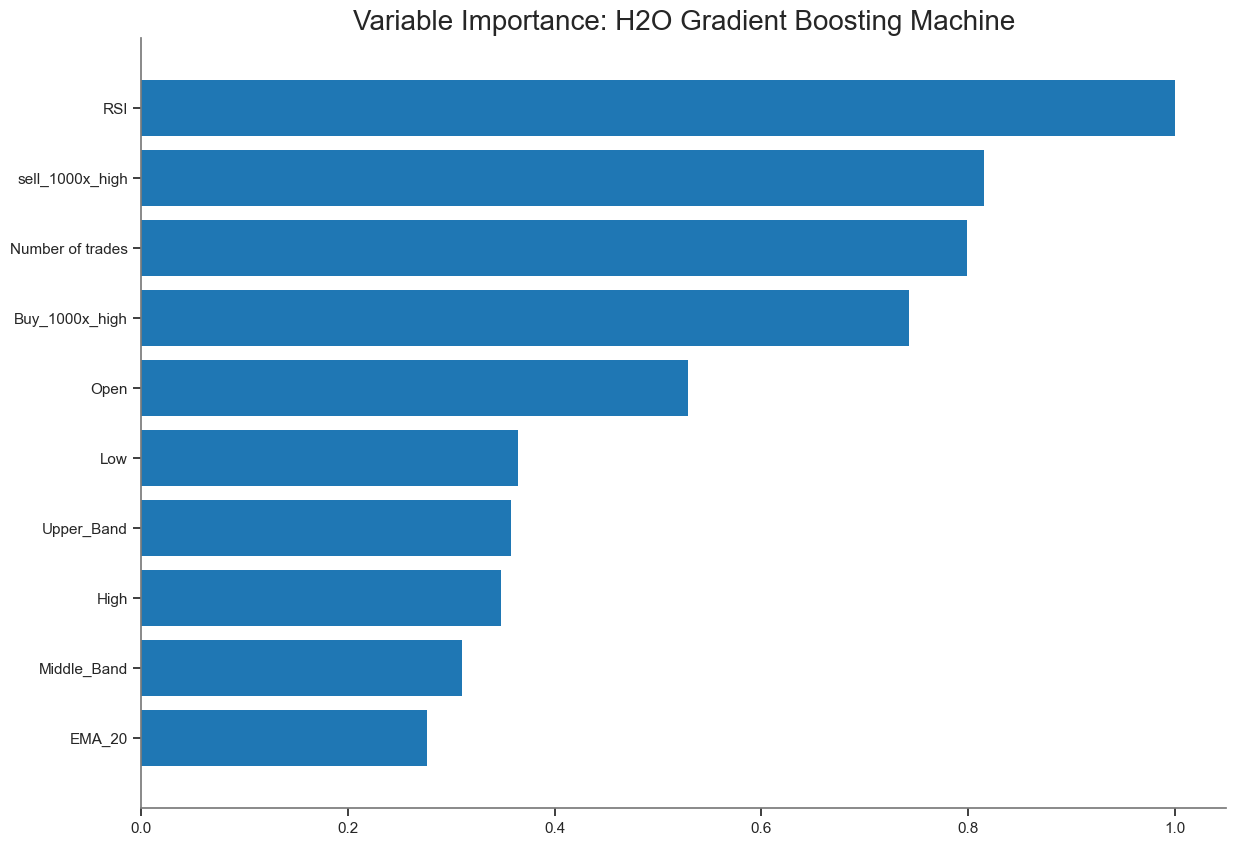

<Figure size 640x480 with 0 Axes>

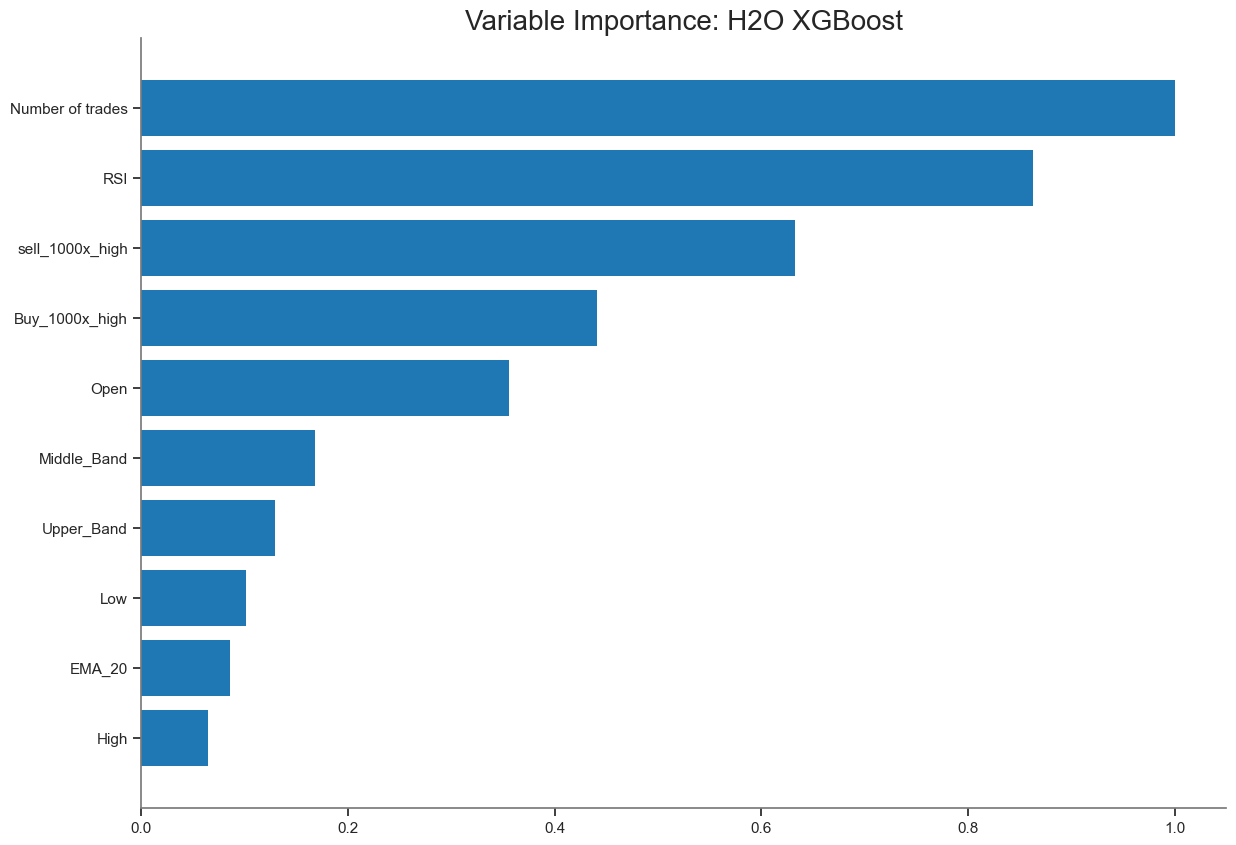

<Figure size 640x480 with 0 Axes>

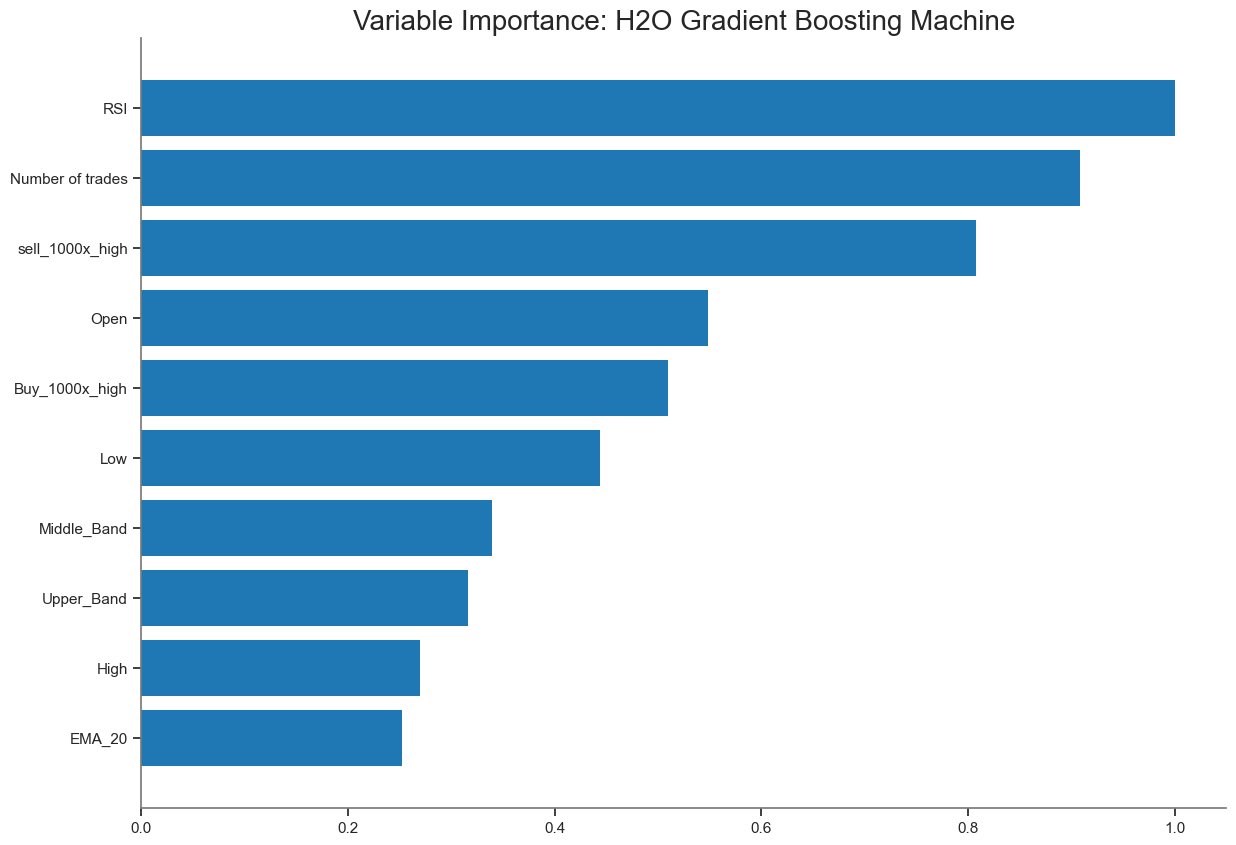

<Figure size 640x480 with 0 Axes>

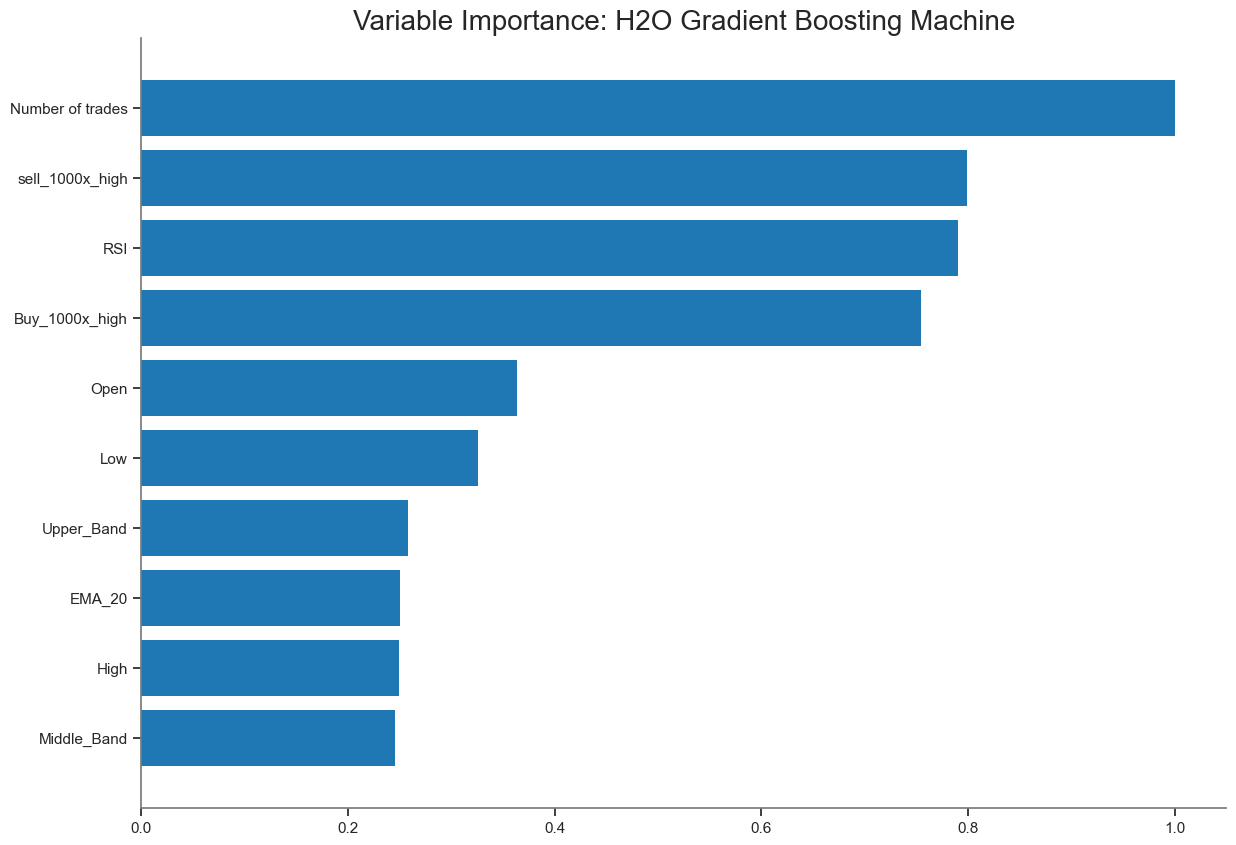

<Figure size 640x480 with 0 Axes>

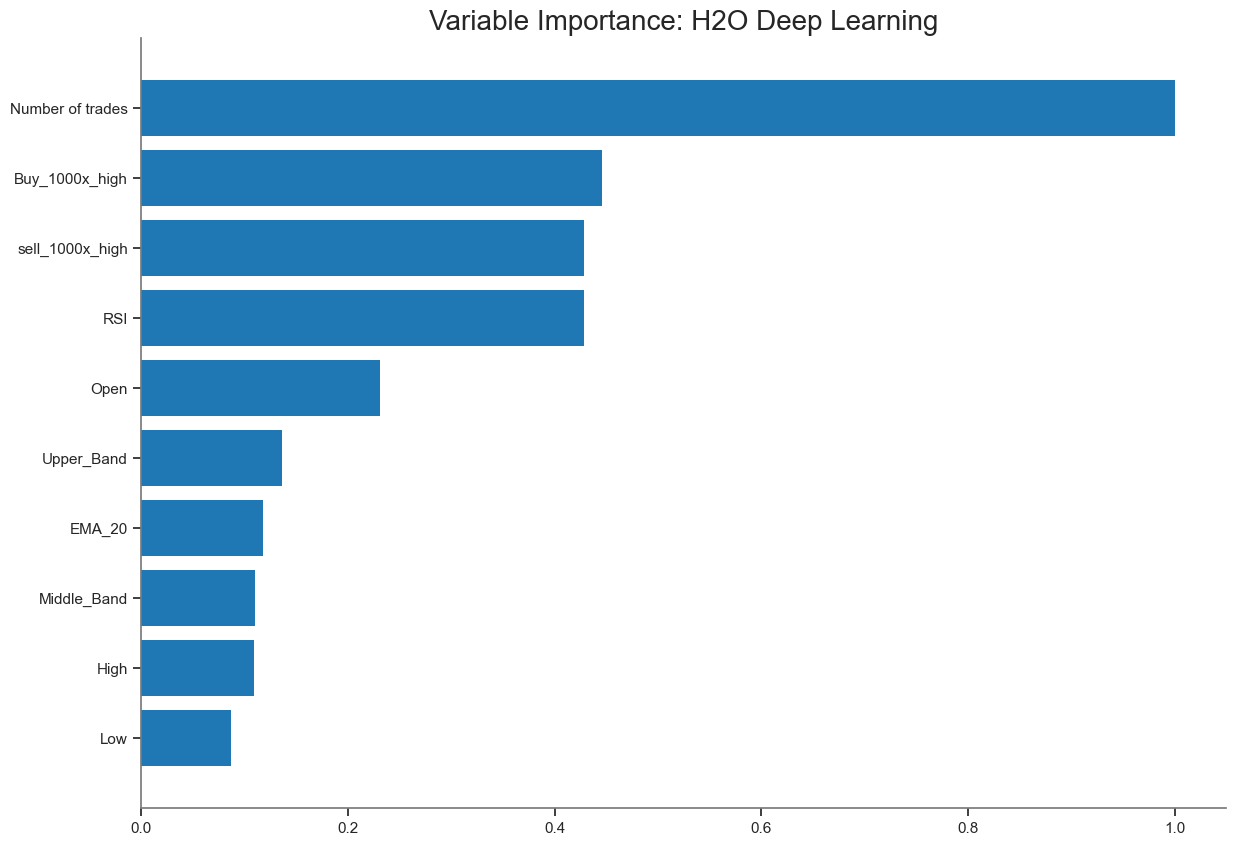

<Figure size 640x480 with 0 Axes>

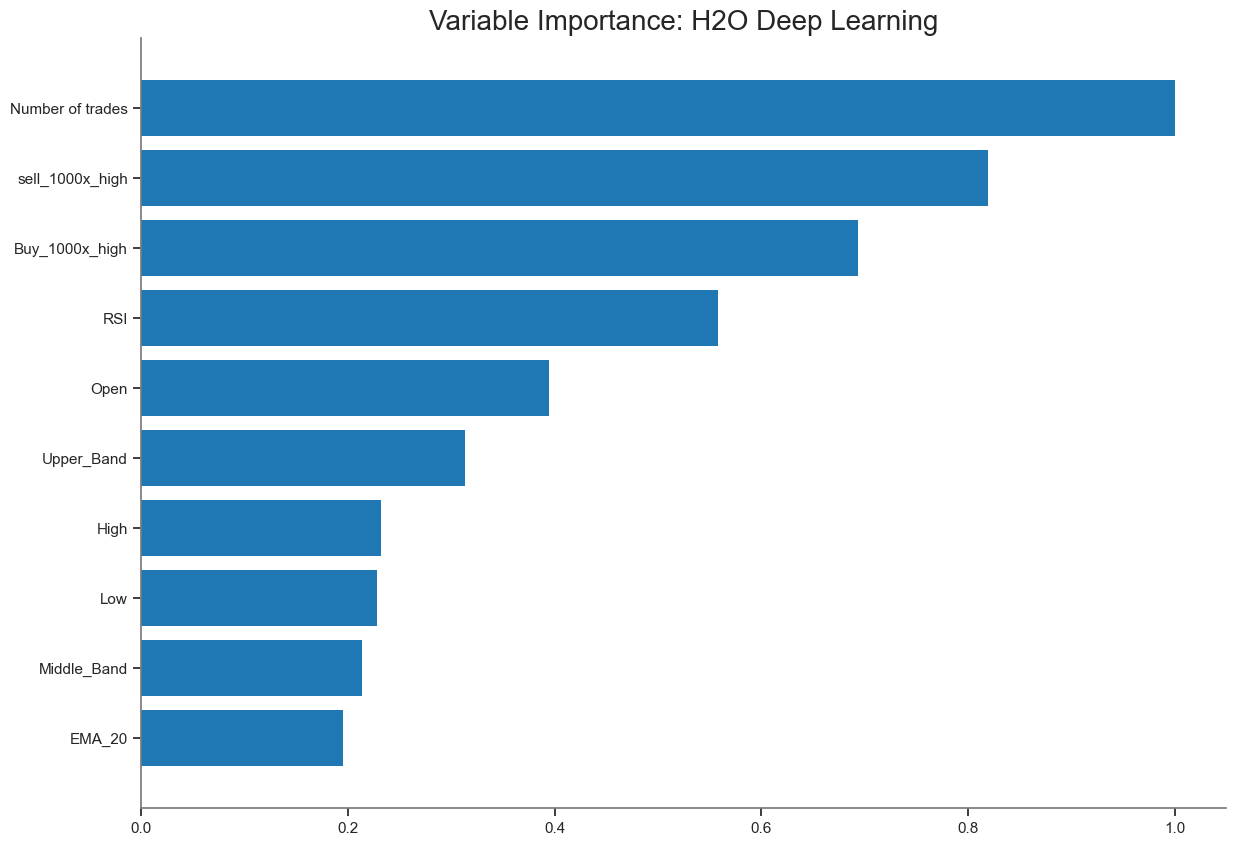

<Figure size 640x480 with 0 Axes>

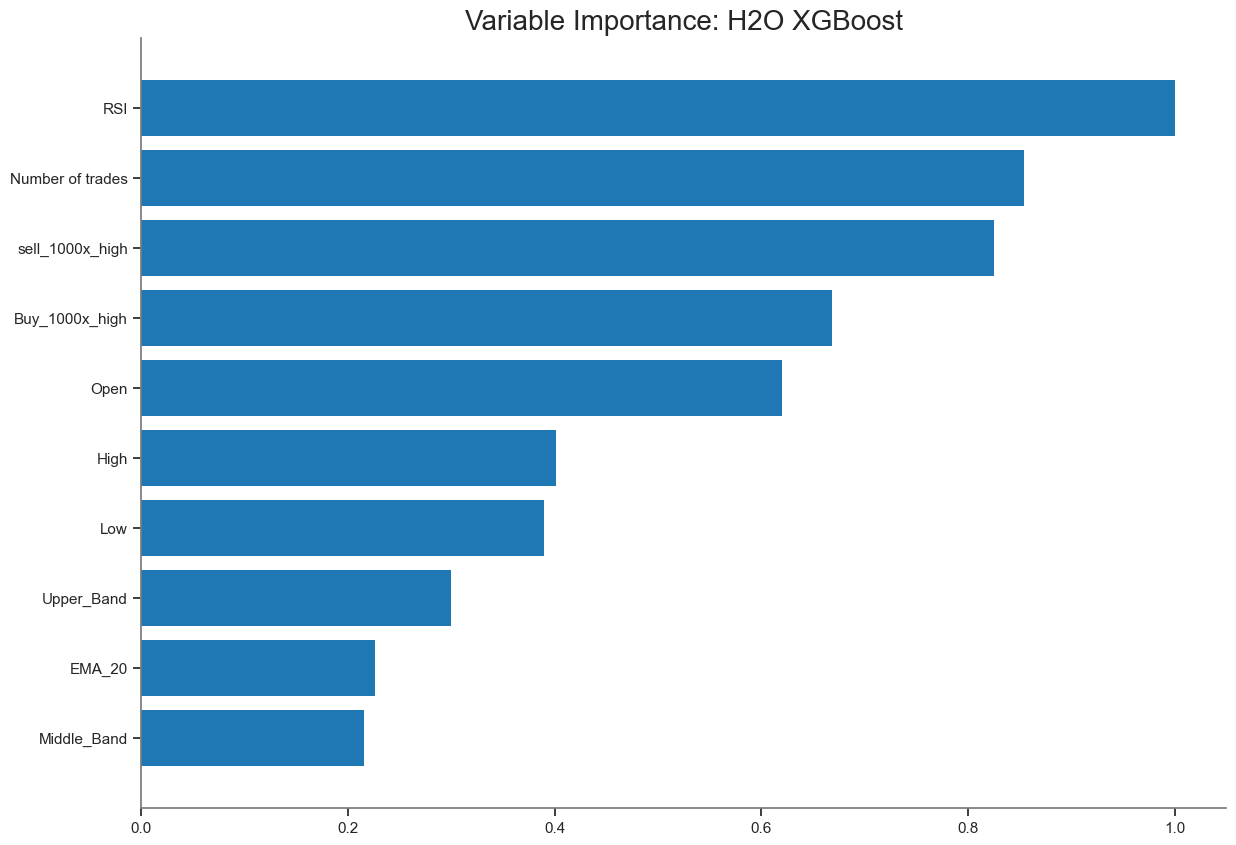

<Figure size 640x480 with 0 Axes>

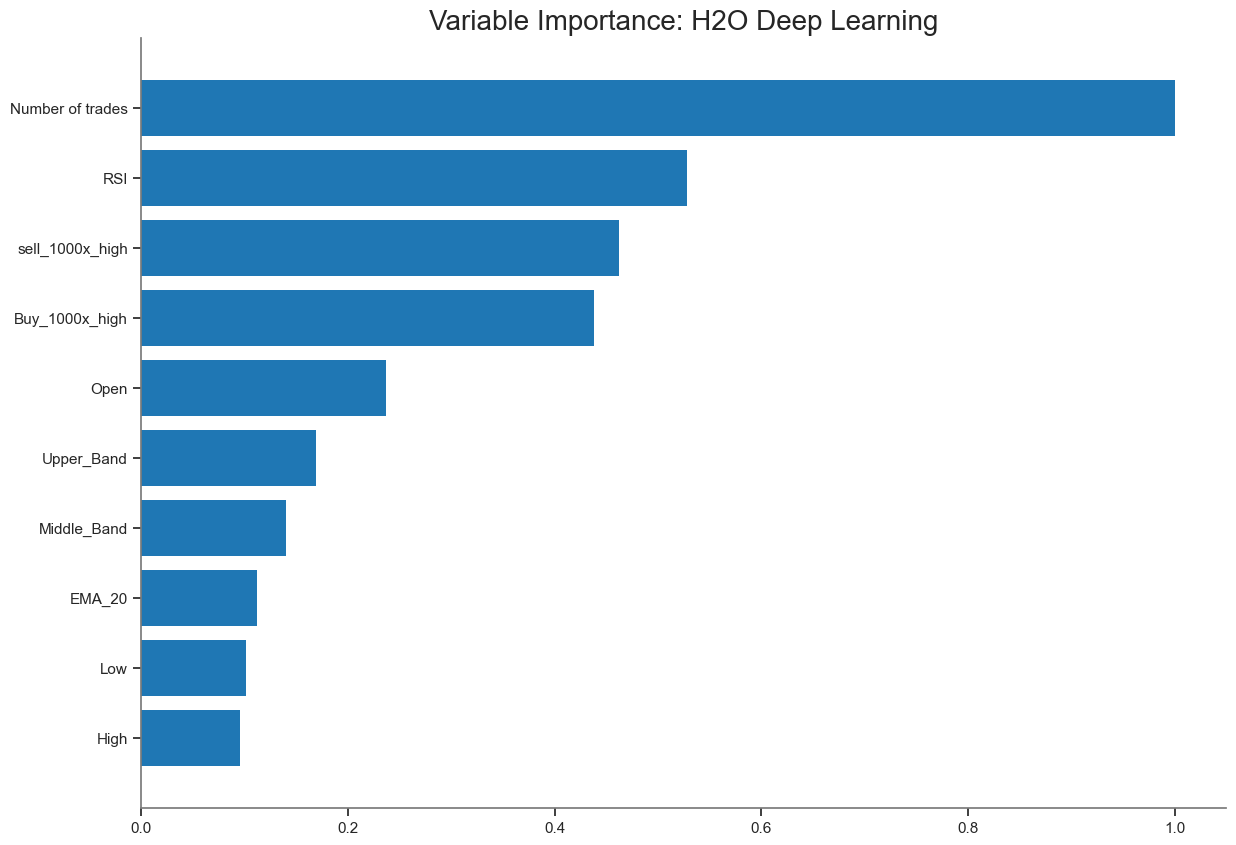

<Figure size 640x480 with 0 Axes>

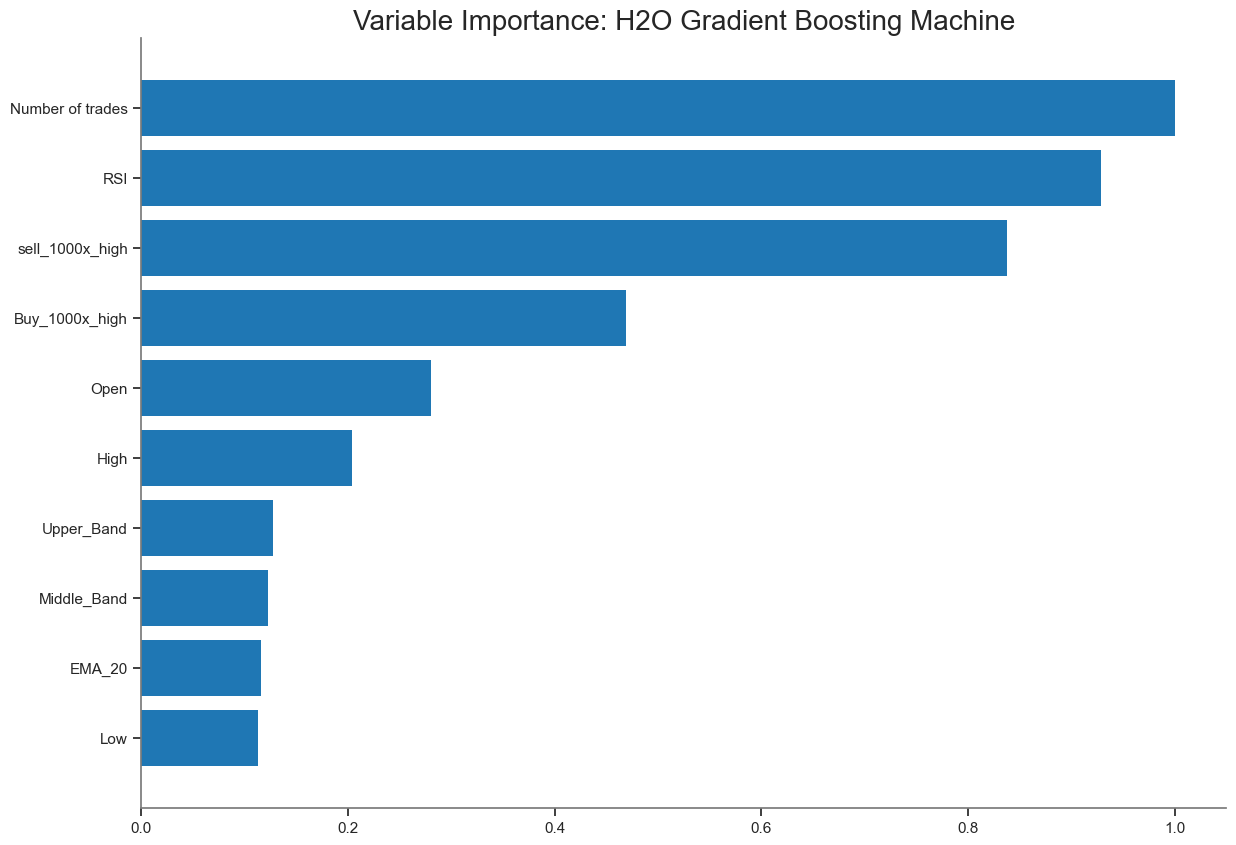

<Figure size 640x480 with 0 Axes>

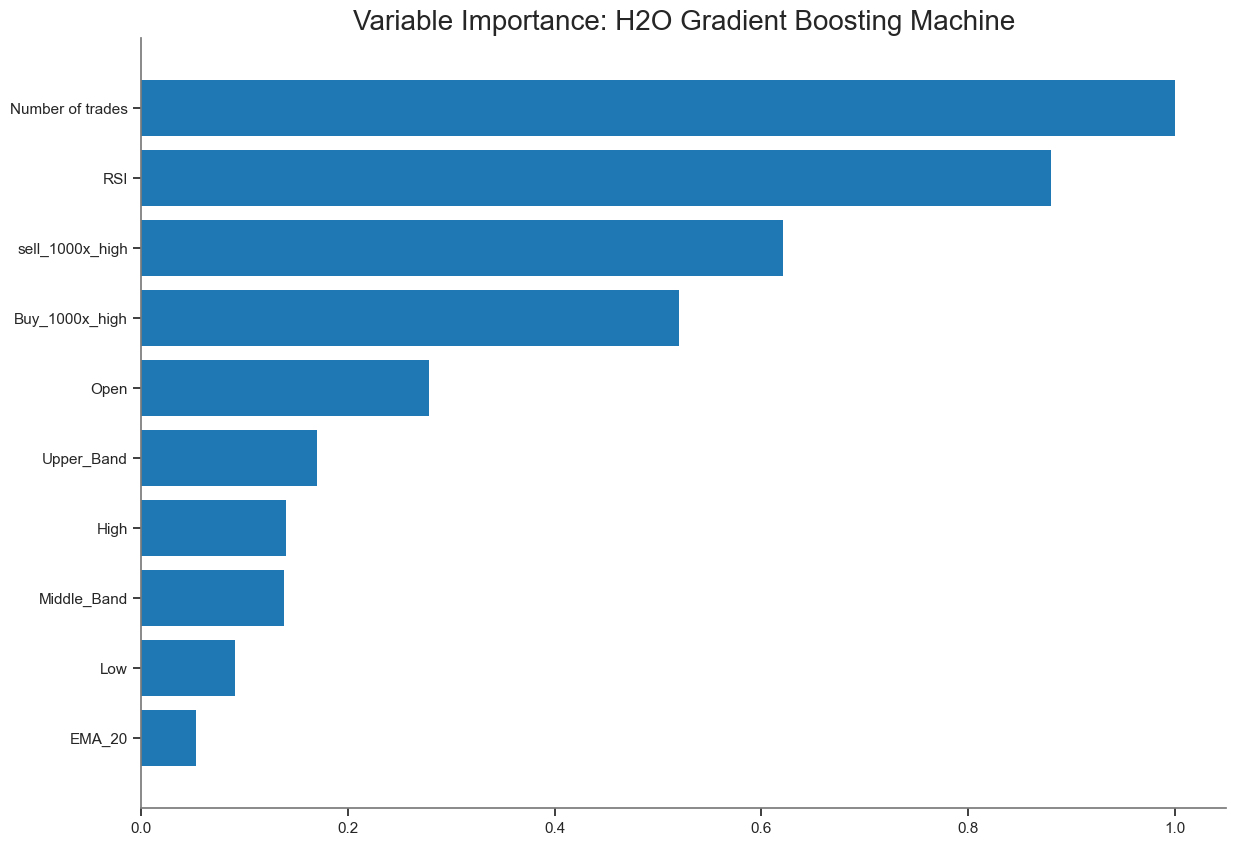

<Figure size 640x480 with 0 Axes>

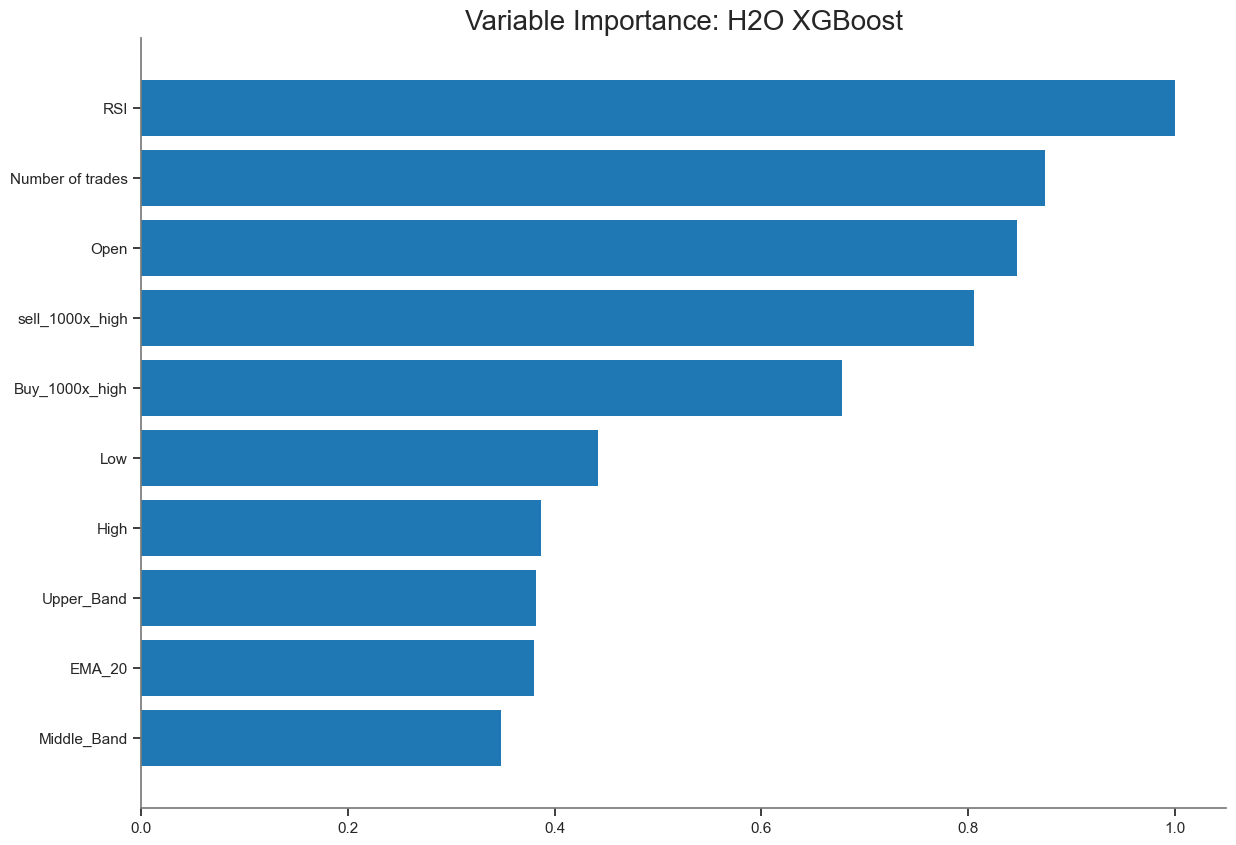

<Figure size 640x480 with 0 Axes>

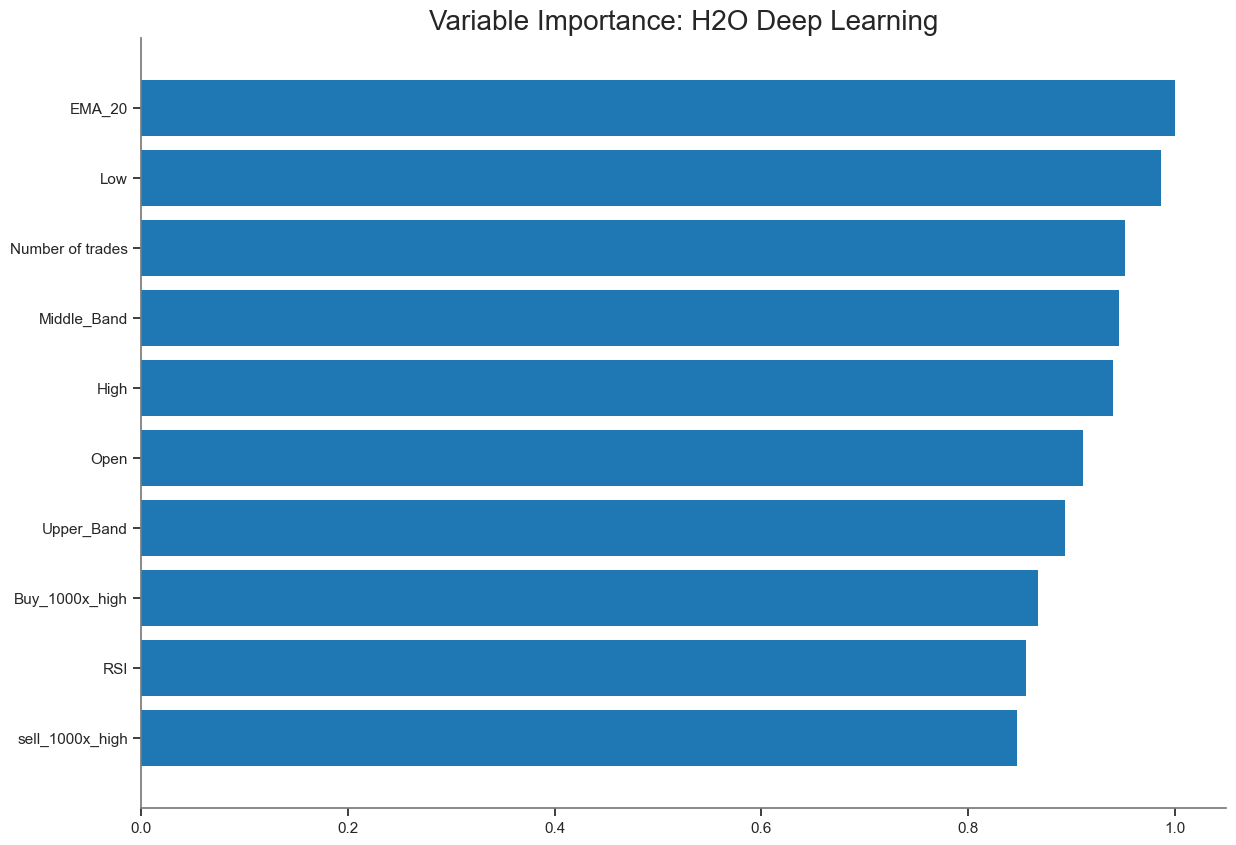

<Figure size 640x480 with 0 Axes>

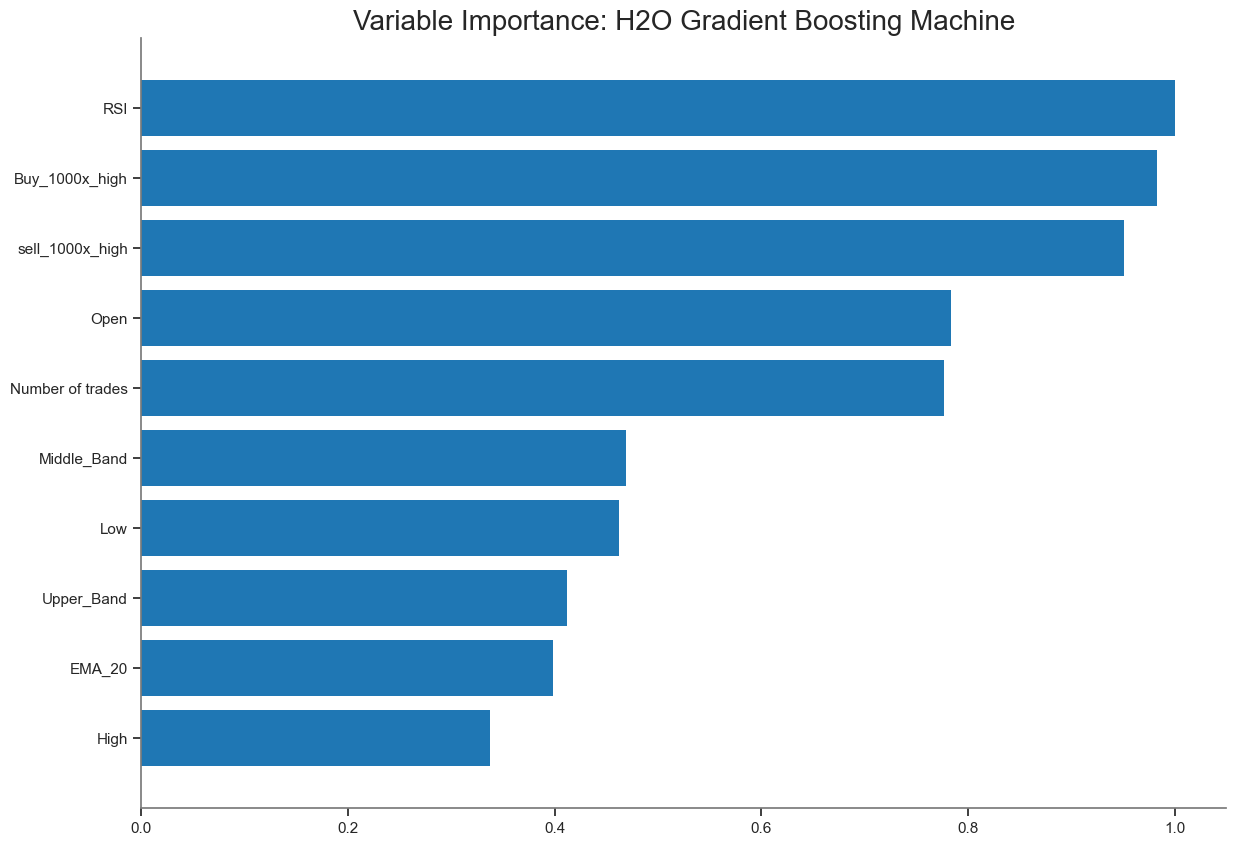

<Figure size 640x480 with 0 Axes>

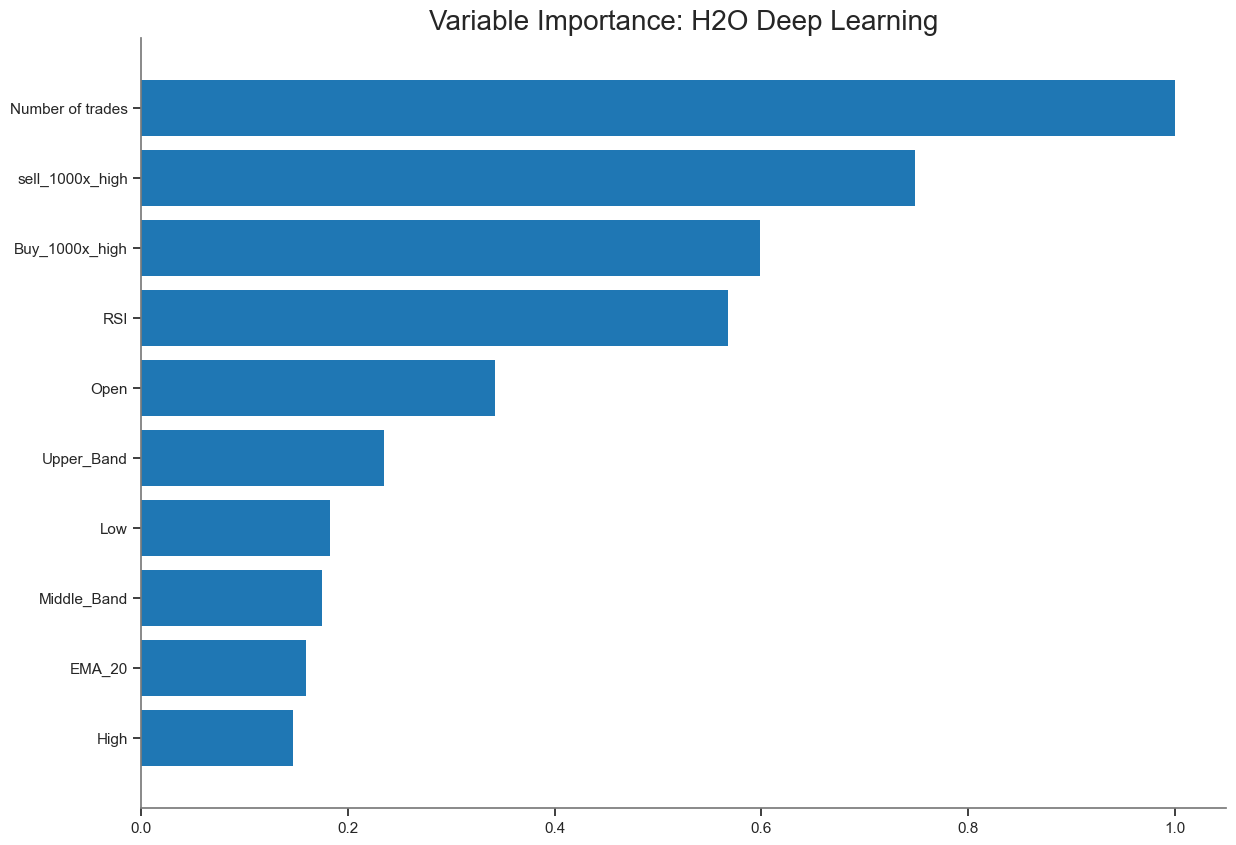

<Figure size 640x480 with 0 Axes>

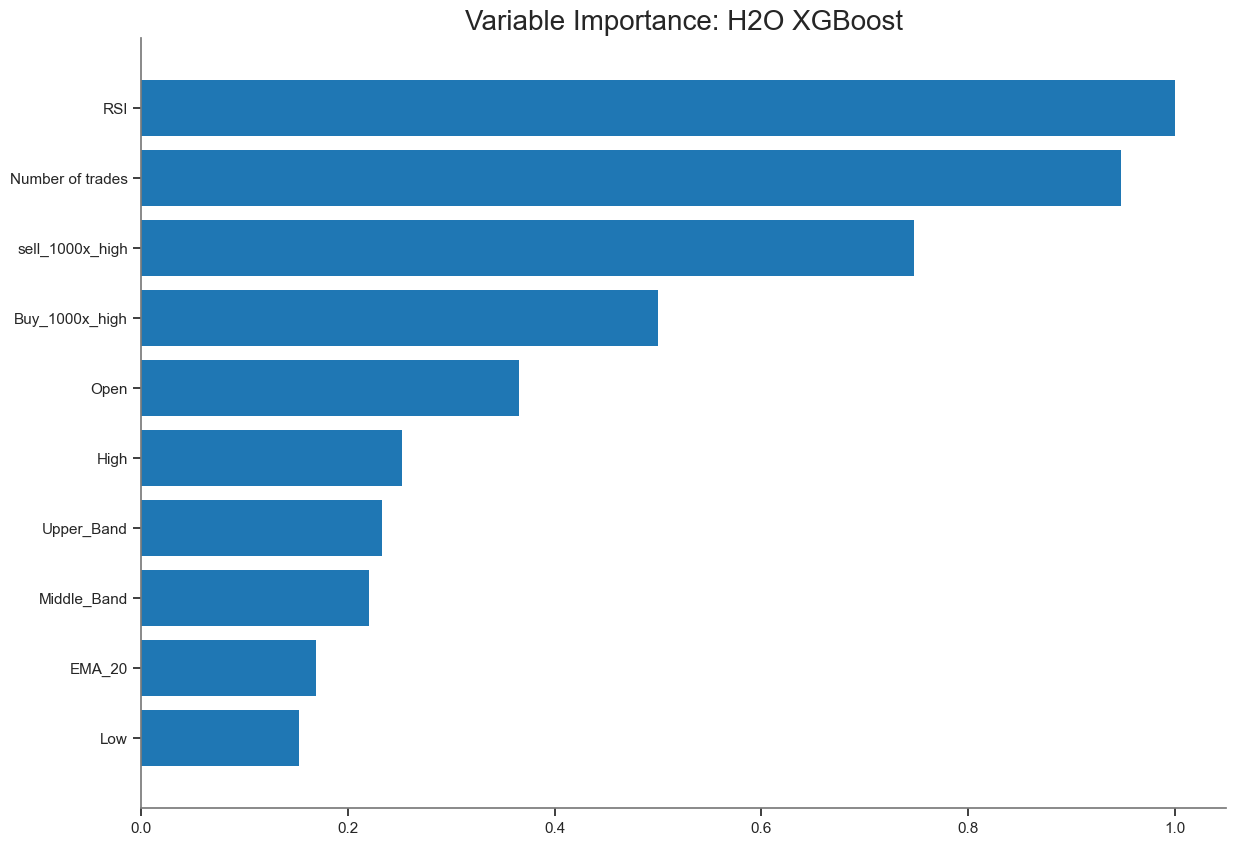

<Figure size 640x480 with 0 Axes>

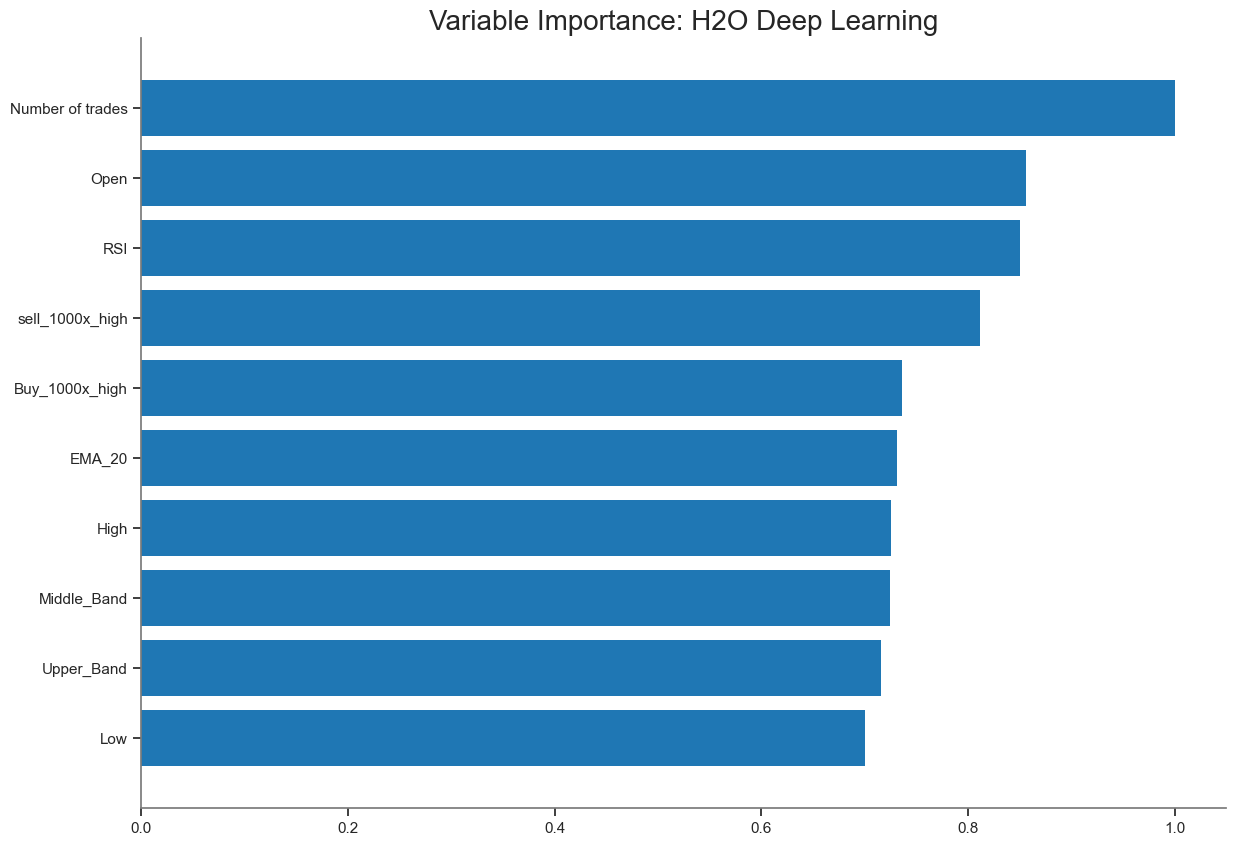

<Figure size 640x480 with 0 Axes>

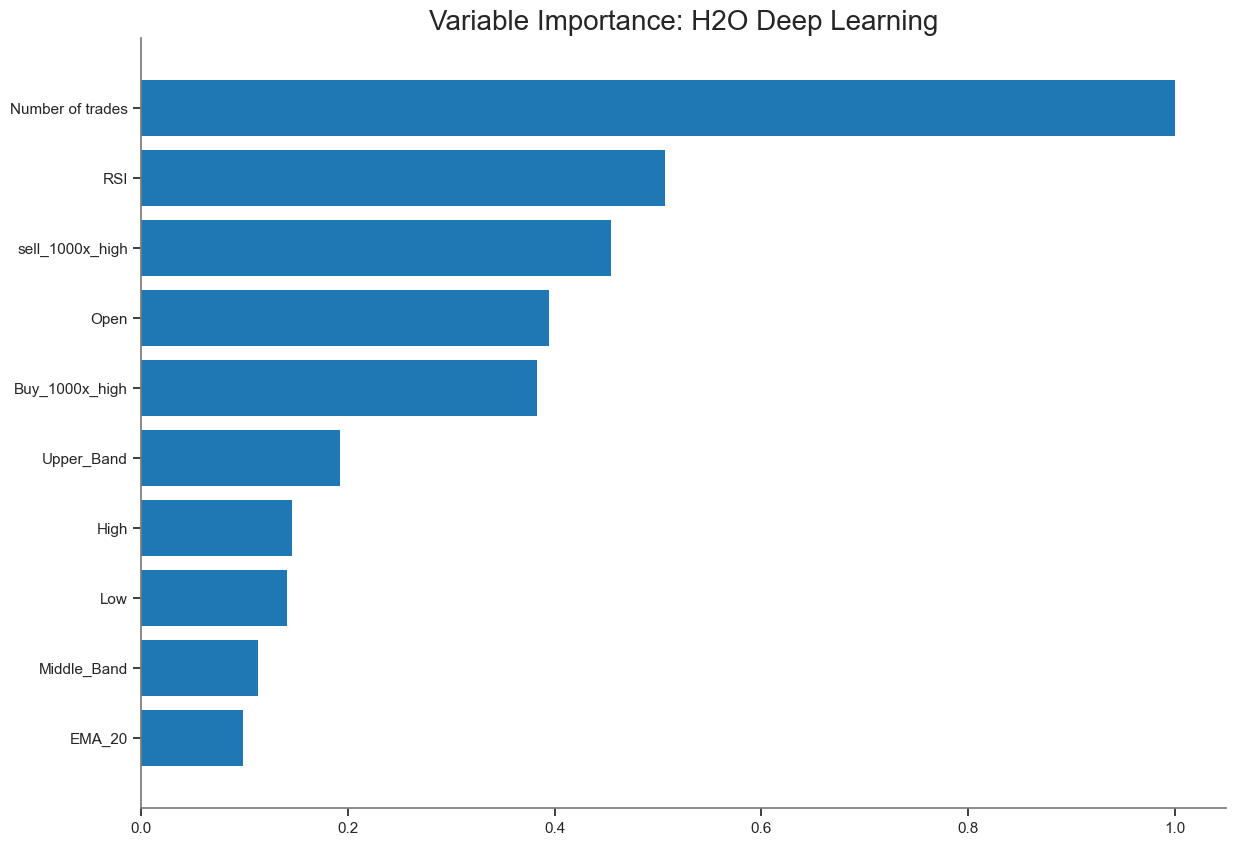

<Figure size 640x480 with 0 Axes>

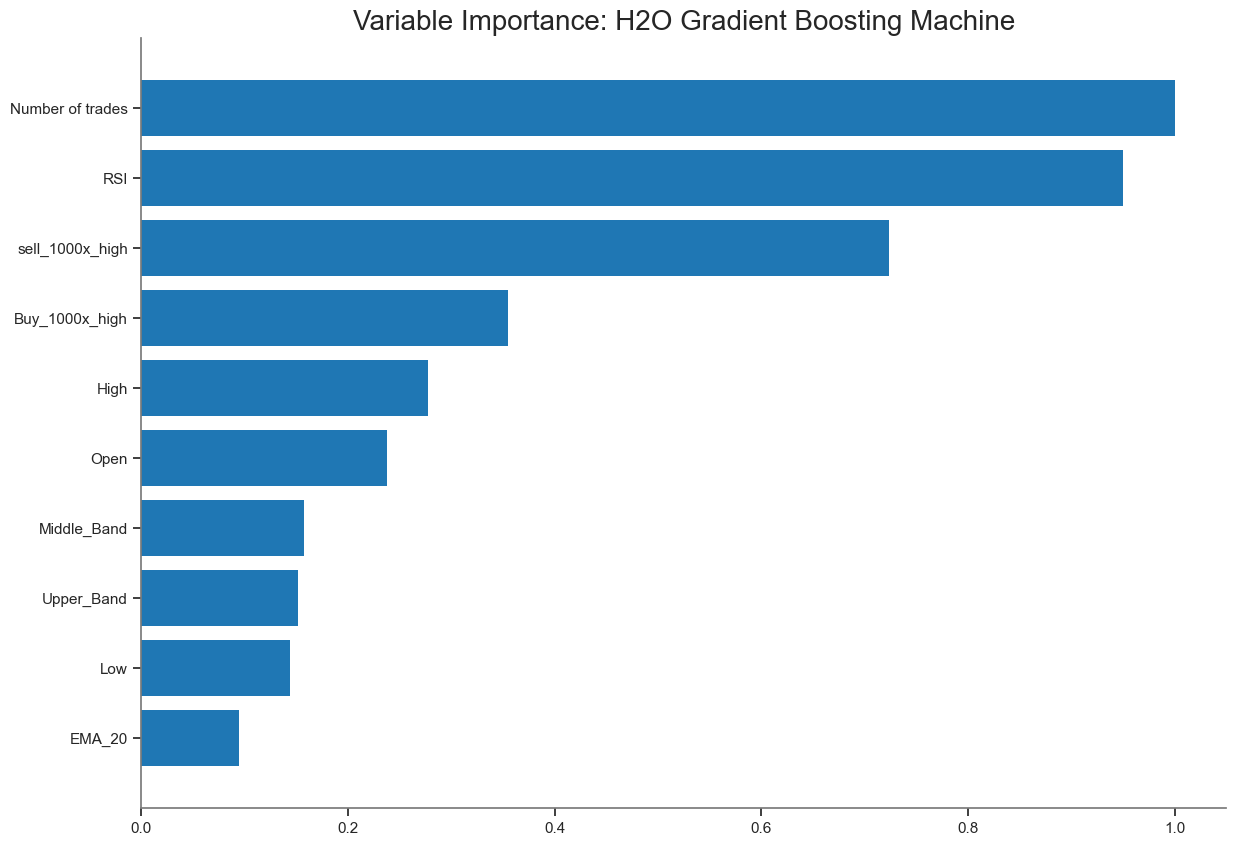

<Figure size 640x480 with 0 Axes>

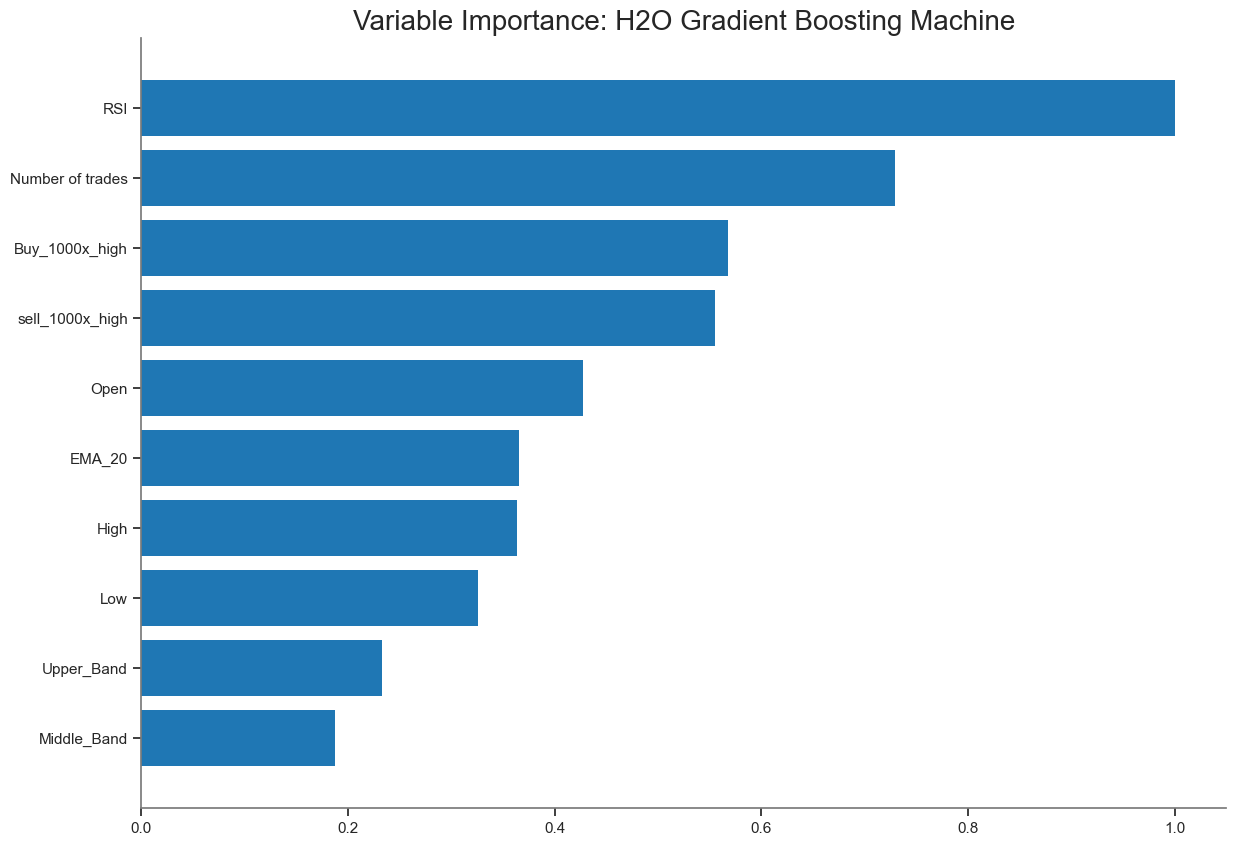

<Figure size 640x480 with 0 Axes>

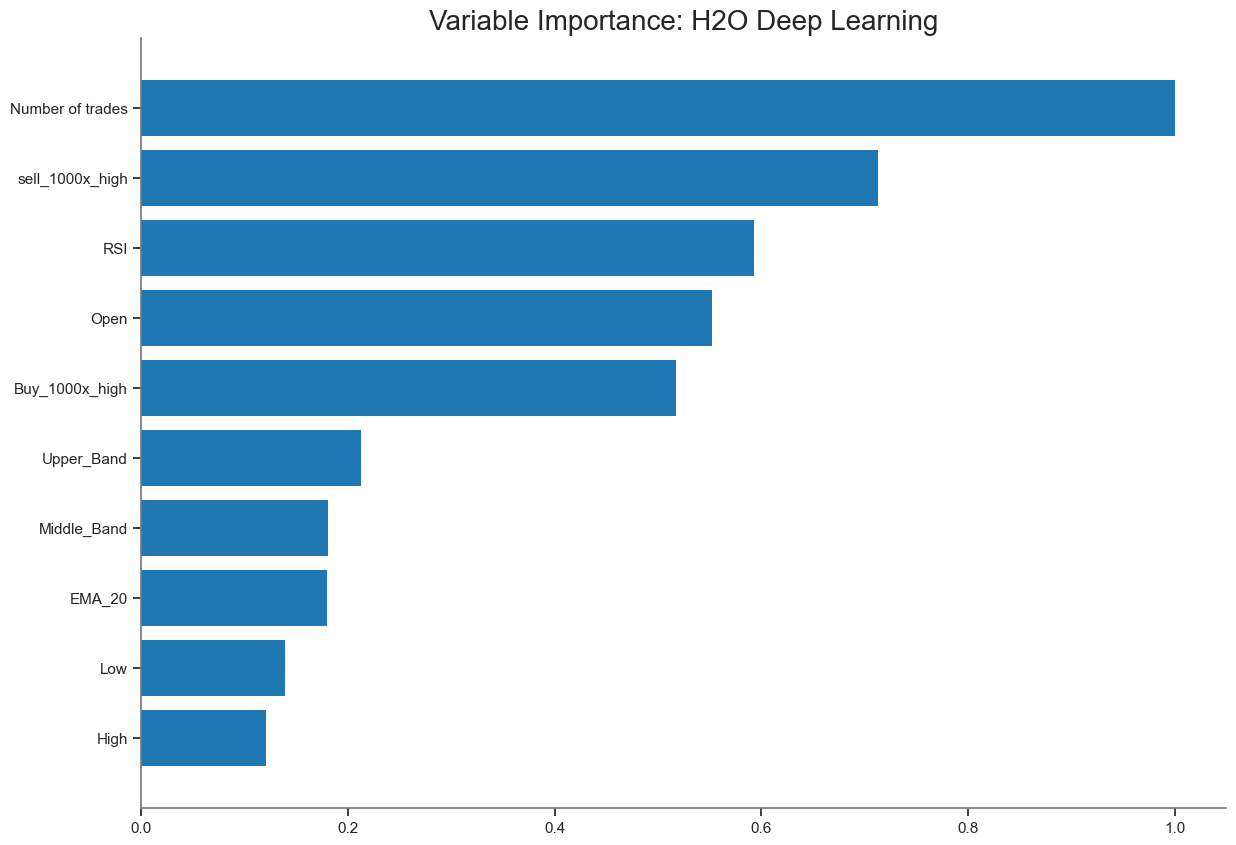

<Figure size 640x480 with 0 Axes>

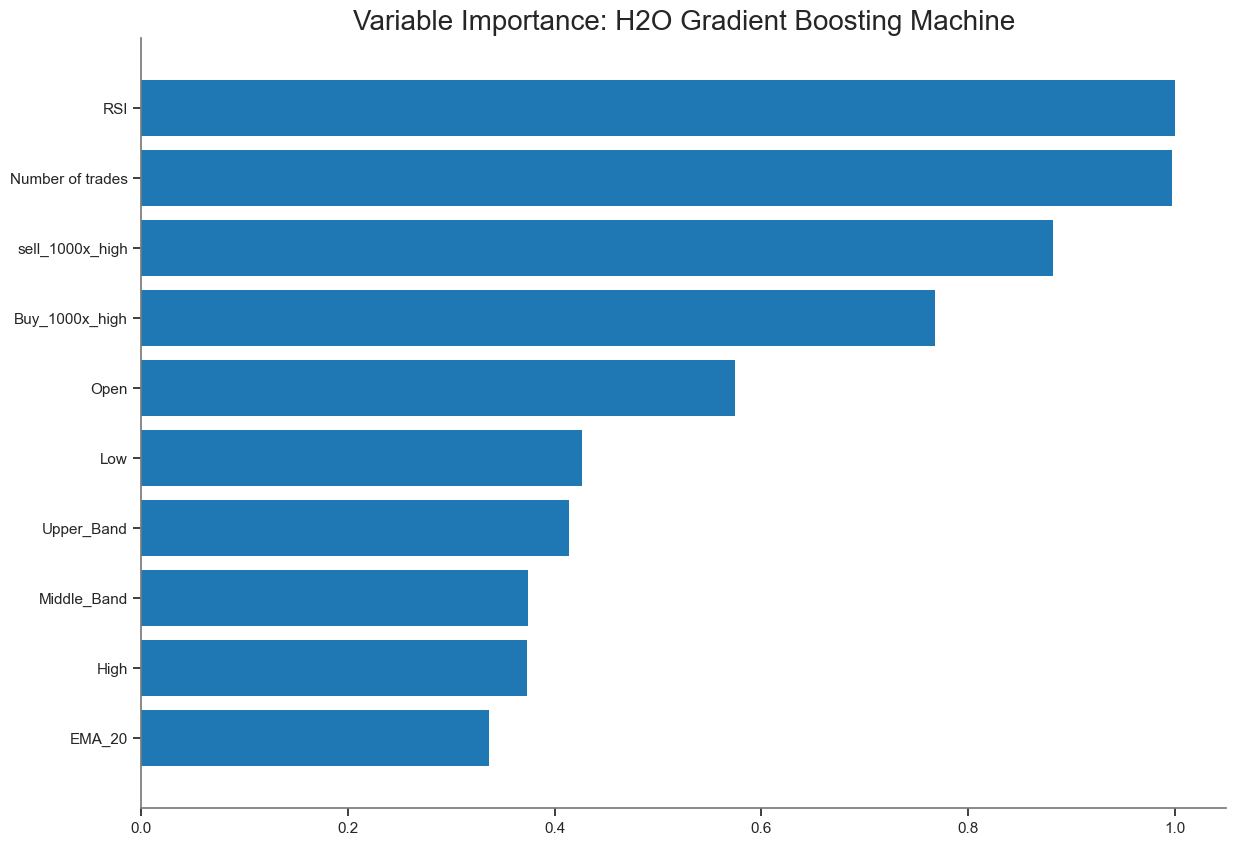

<Figure size 640x480 with 0 Axes>

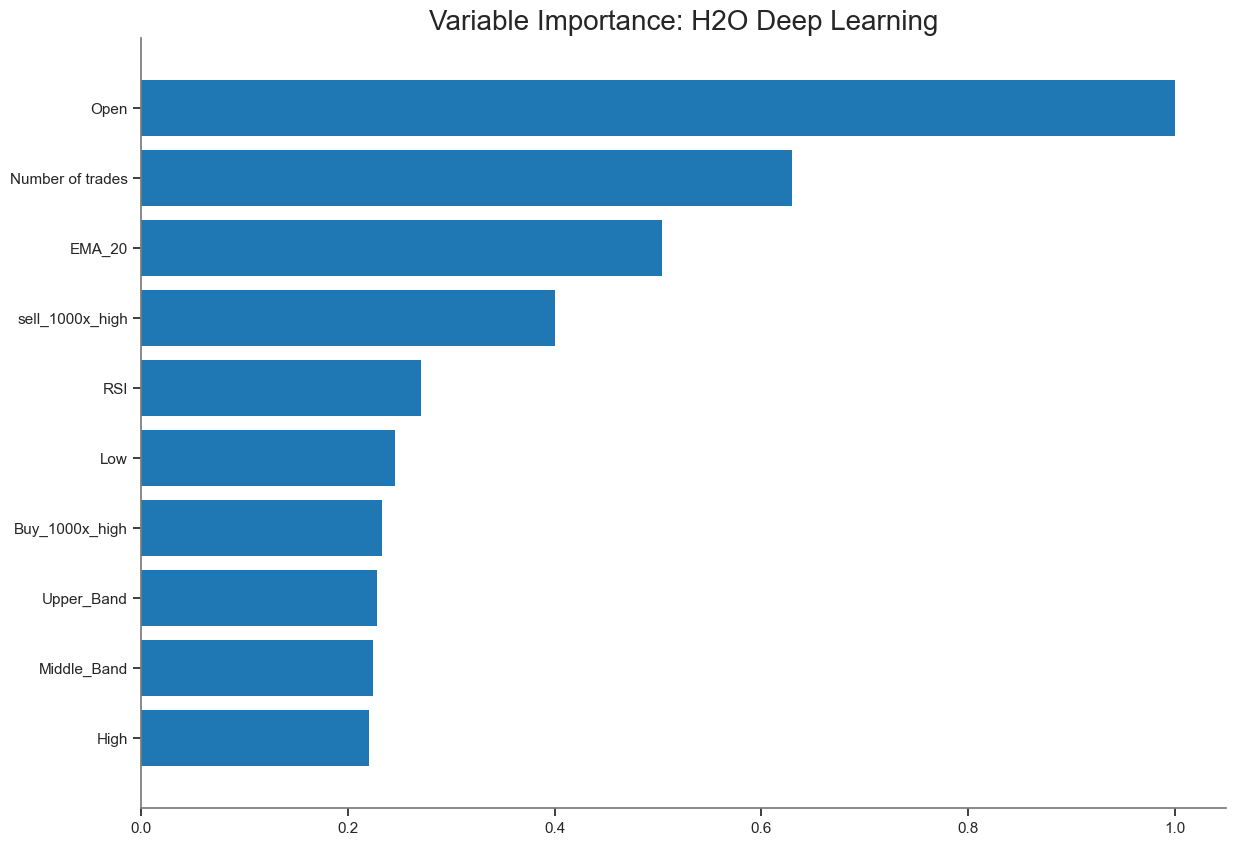

<Figure size 640x480 with 0 Axes>

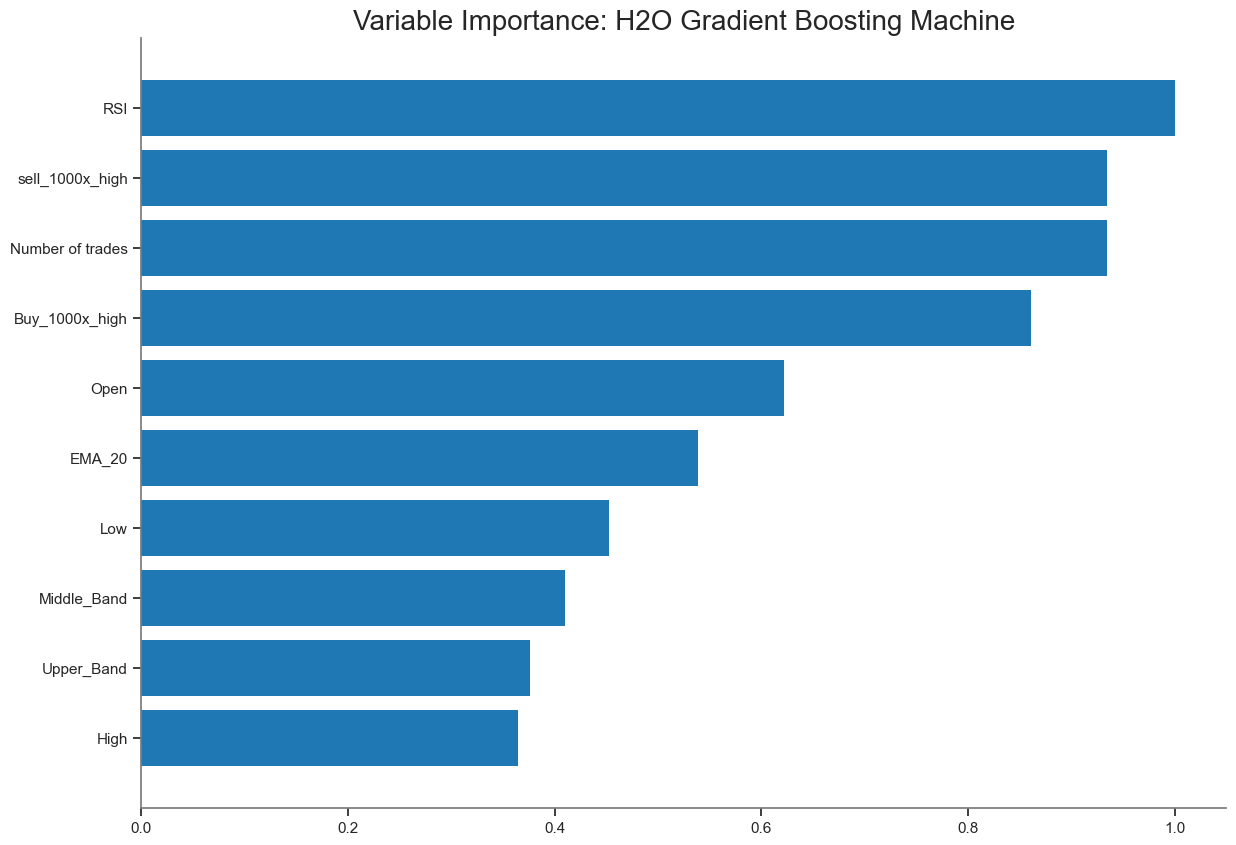

<Figure size 640x480 with 0 Axes>

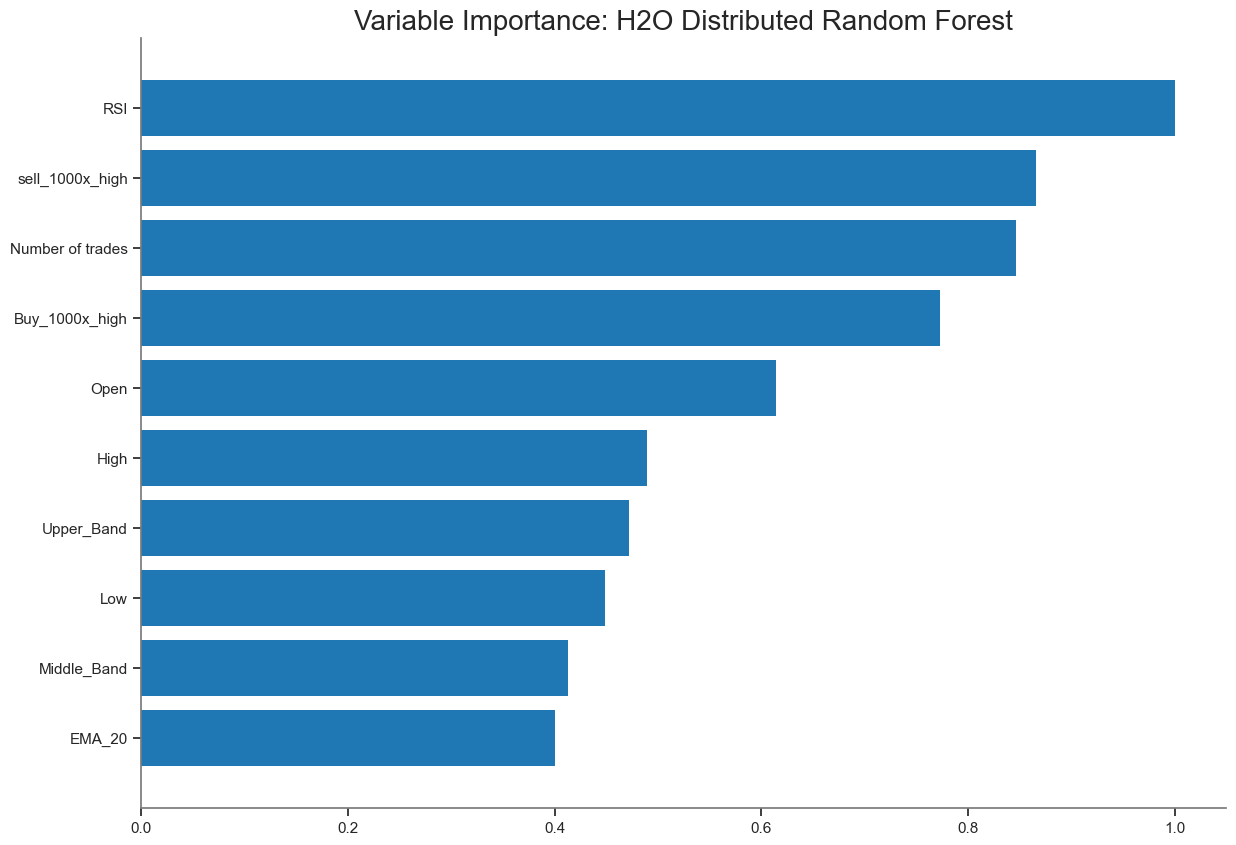

<Figure size 640x480 with 0 Axes>

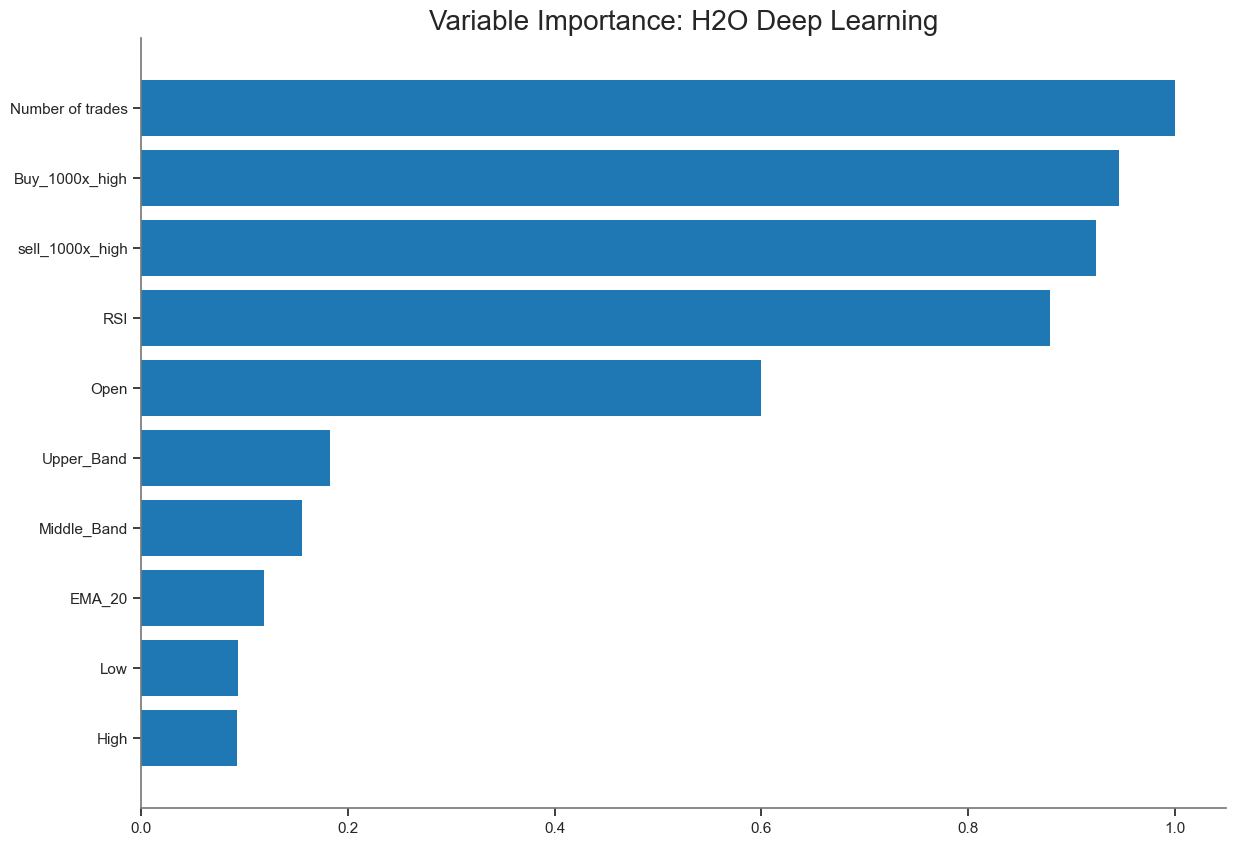

<Figure size 640x480 with 0 Axes>

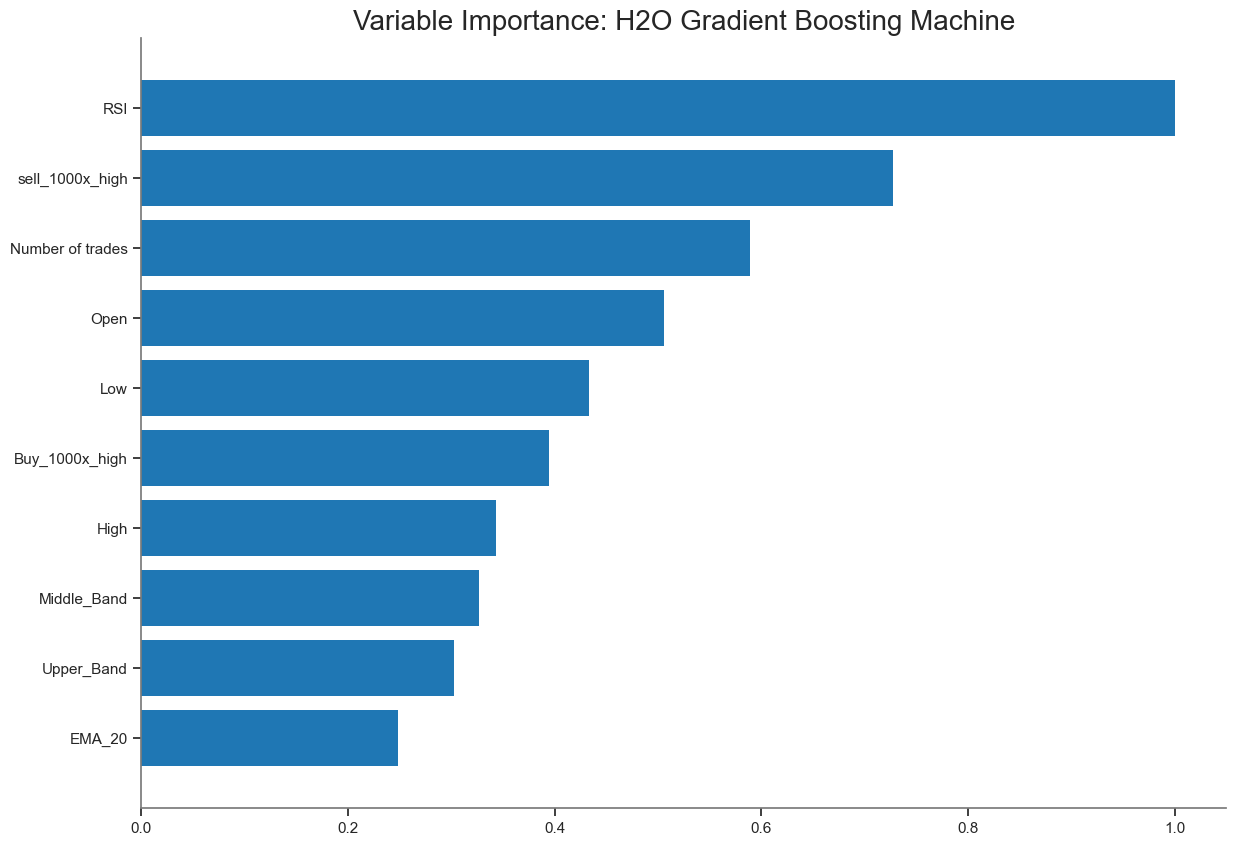

<Figure size 640x480 with 0 Axes>

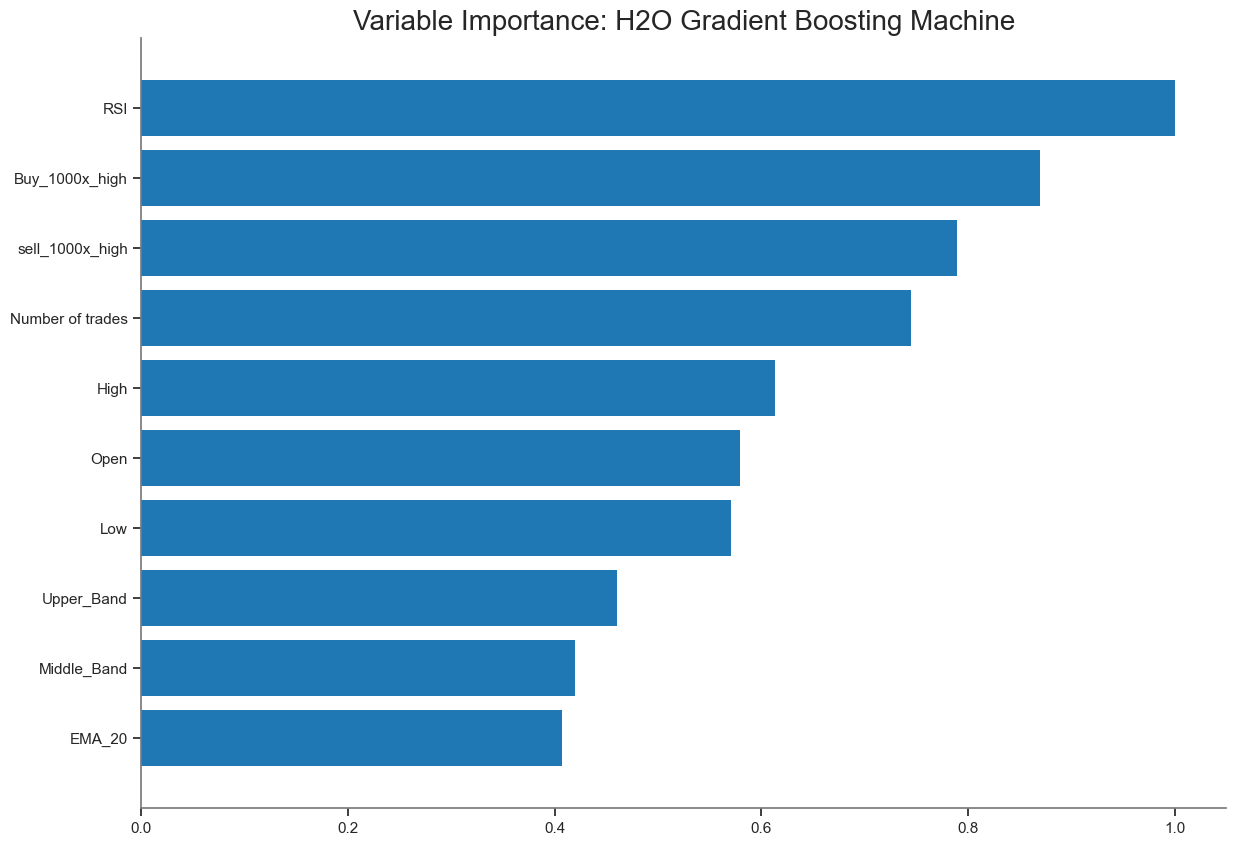

<Figure size 640x480 with 0 Axes>

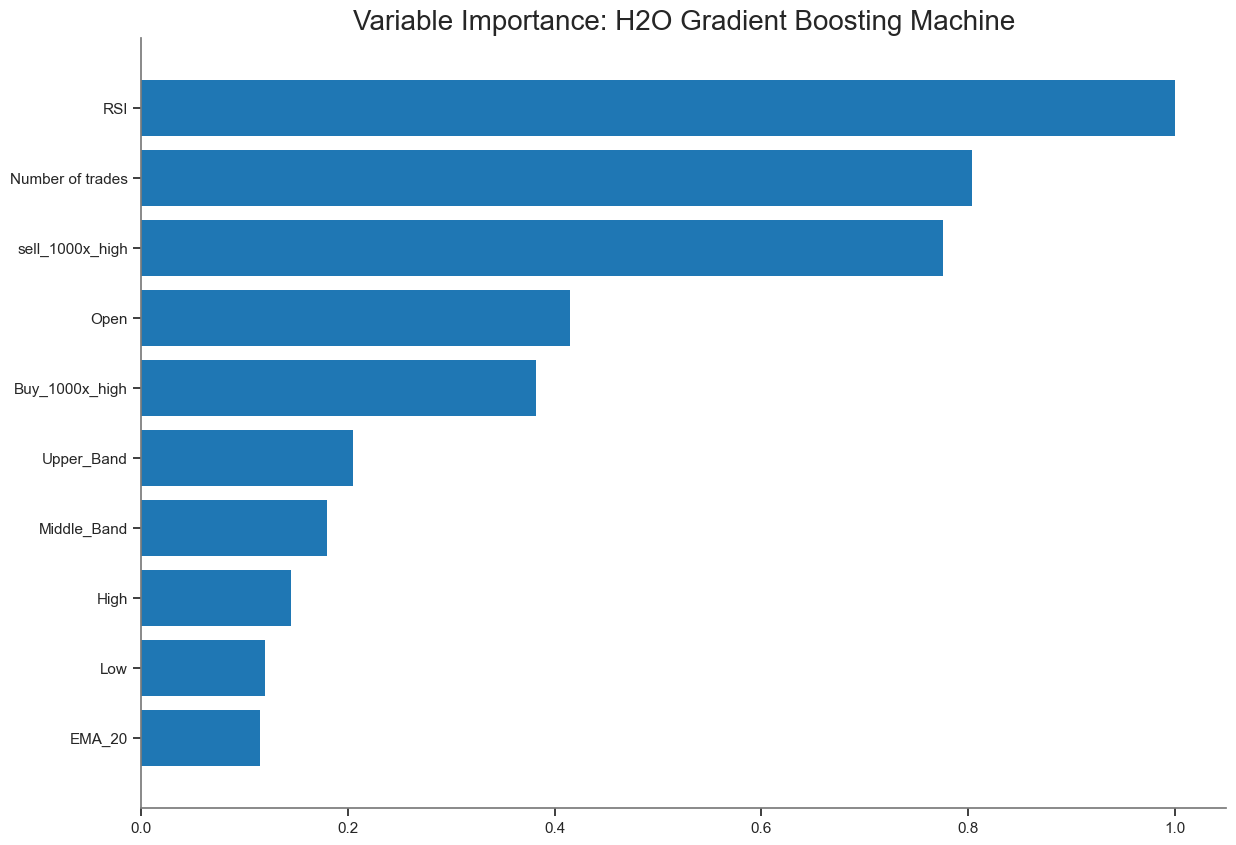

<Figure size 640x480 with 0 Axes>

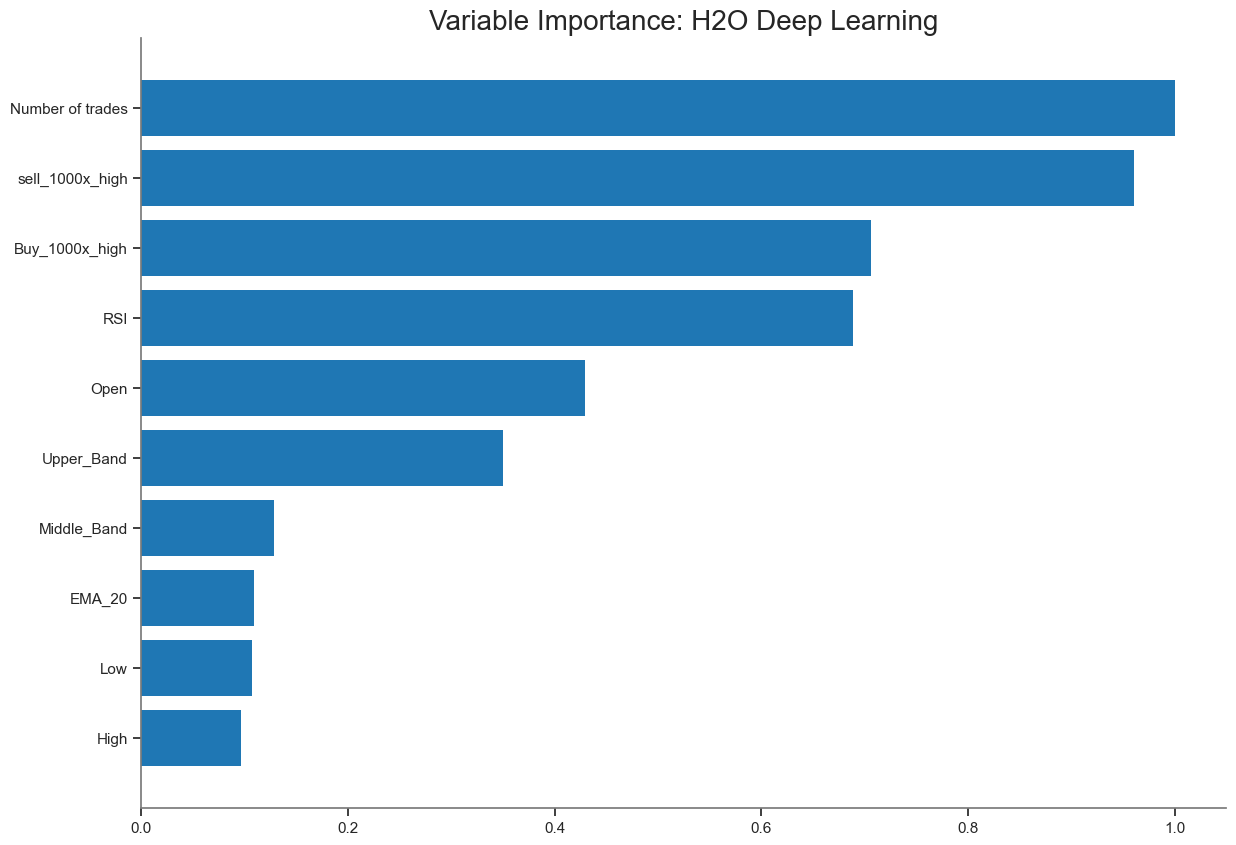

<Figure size 640x480 with 0 Axes>

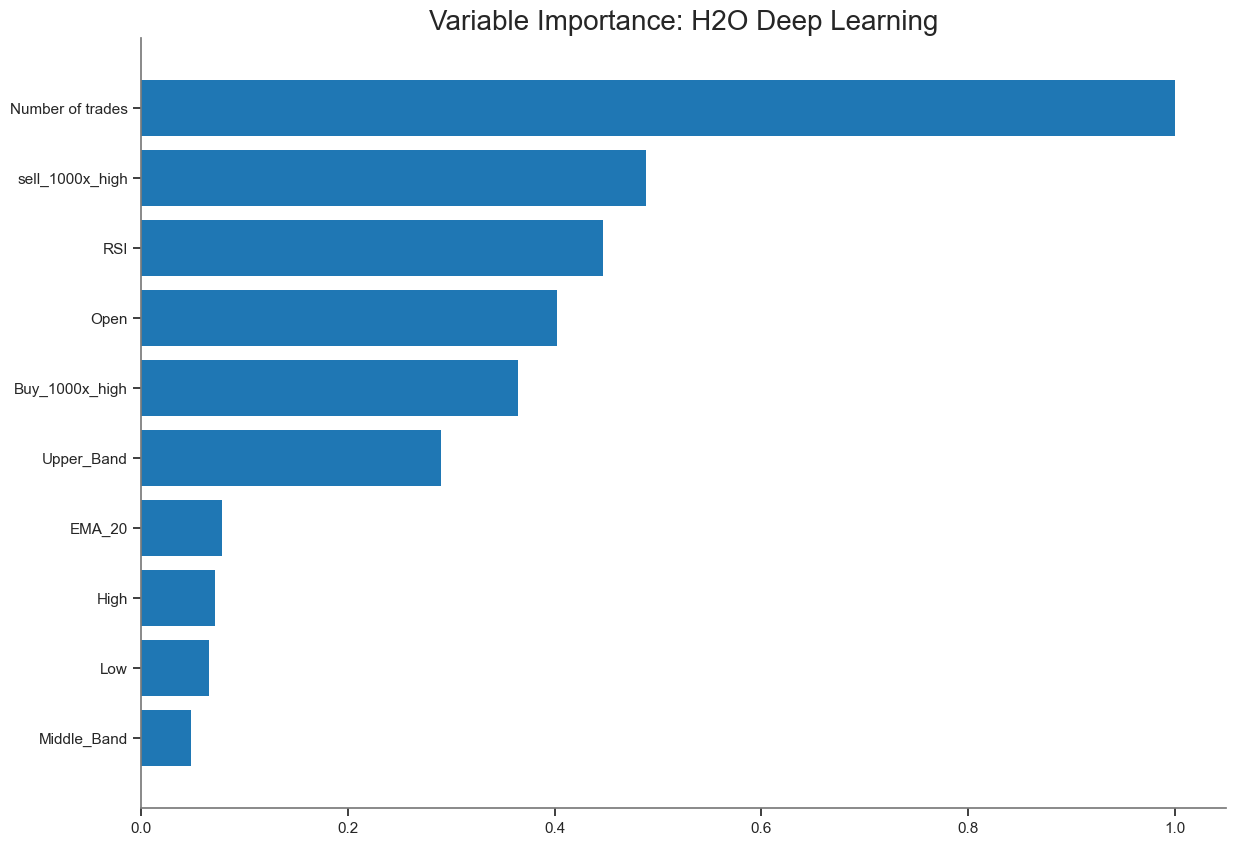

<Figure size 640x480 with 0 Axes>

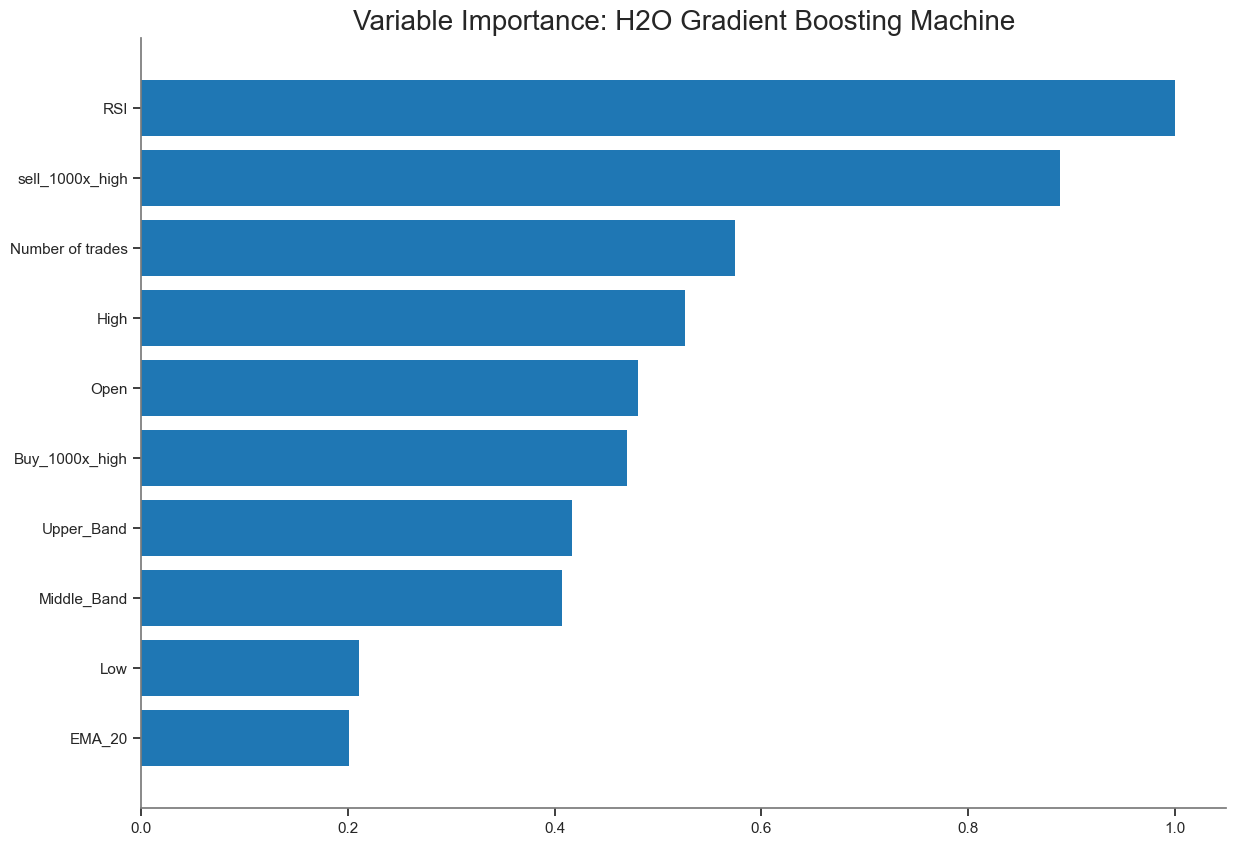

<Figure size 640x480 with 0 Axes>

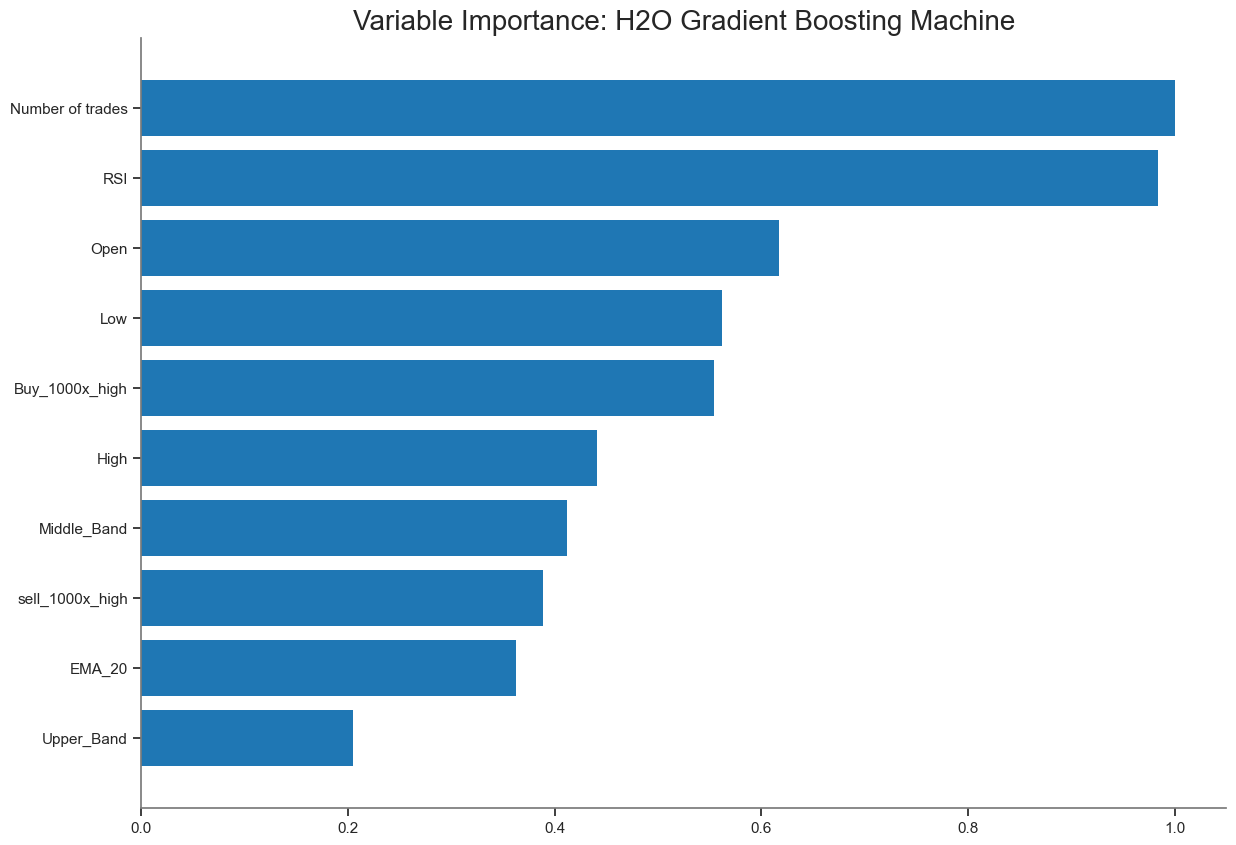

<Figure size 640x480 with 0 Axes>

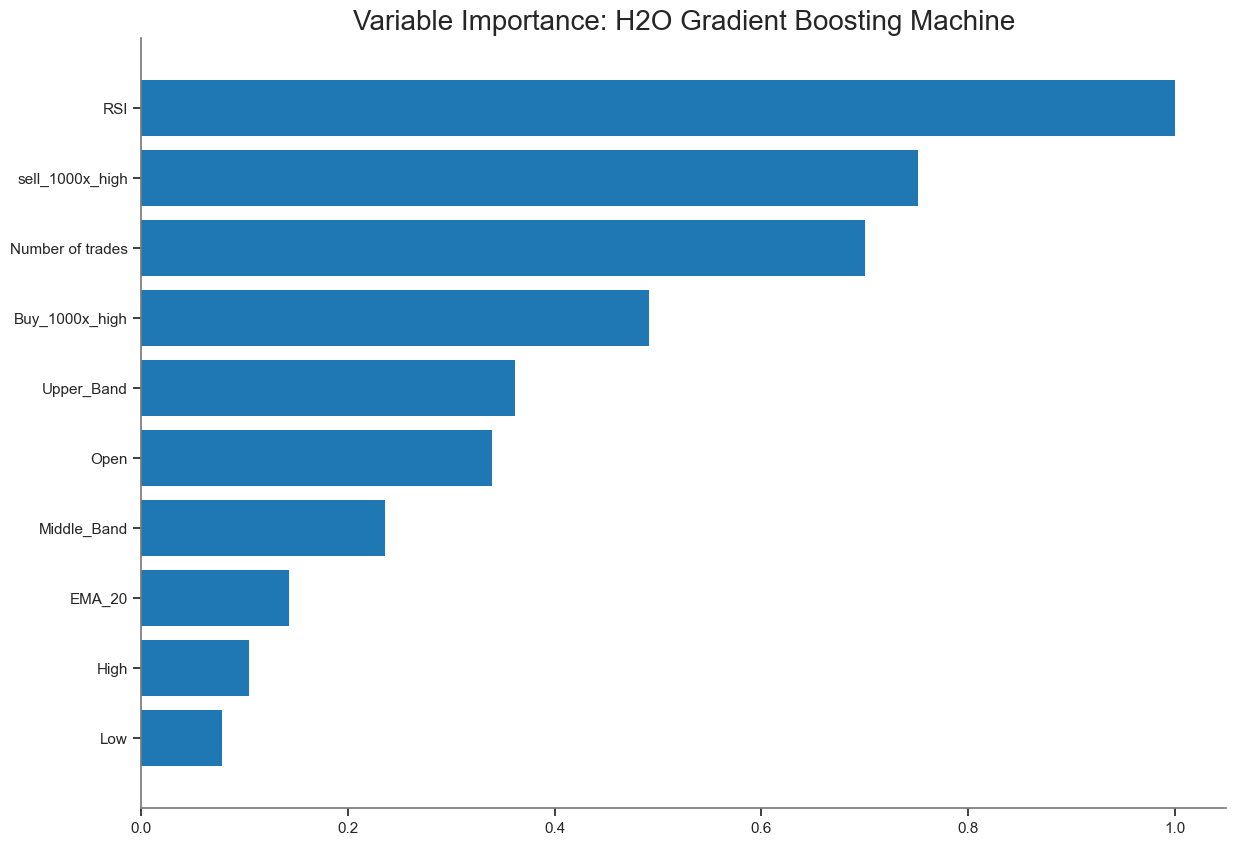

<Figure size 640x480 with 0 Axes>

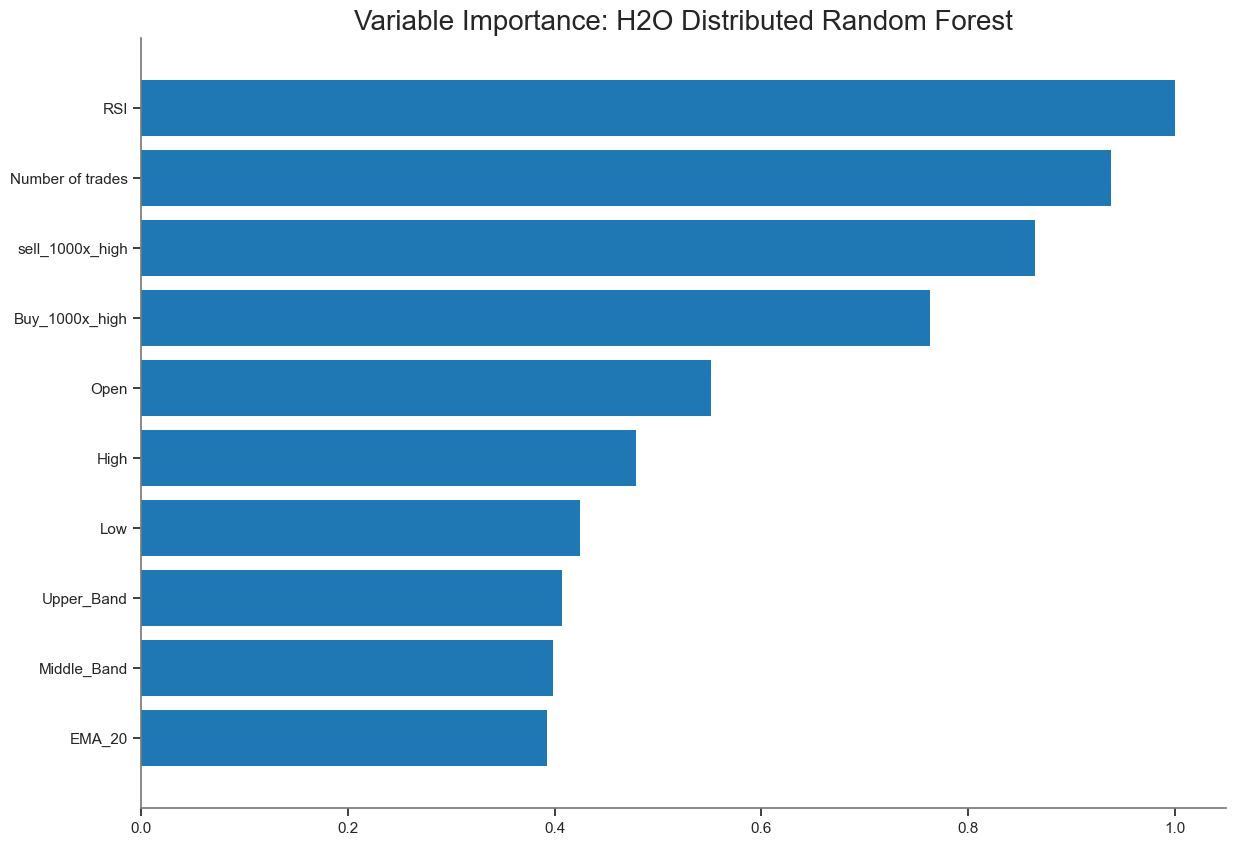

<Figure size 640x480 with 0 Axes>

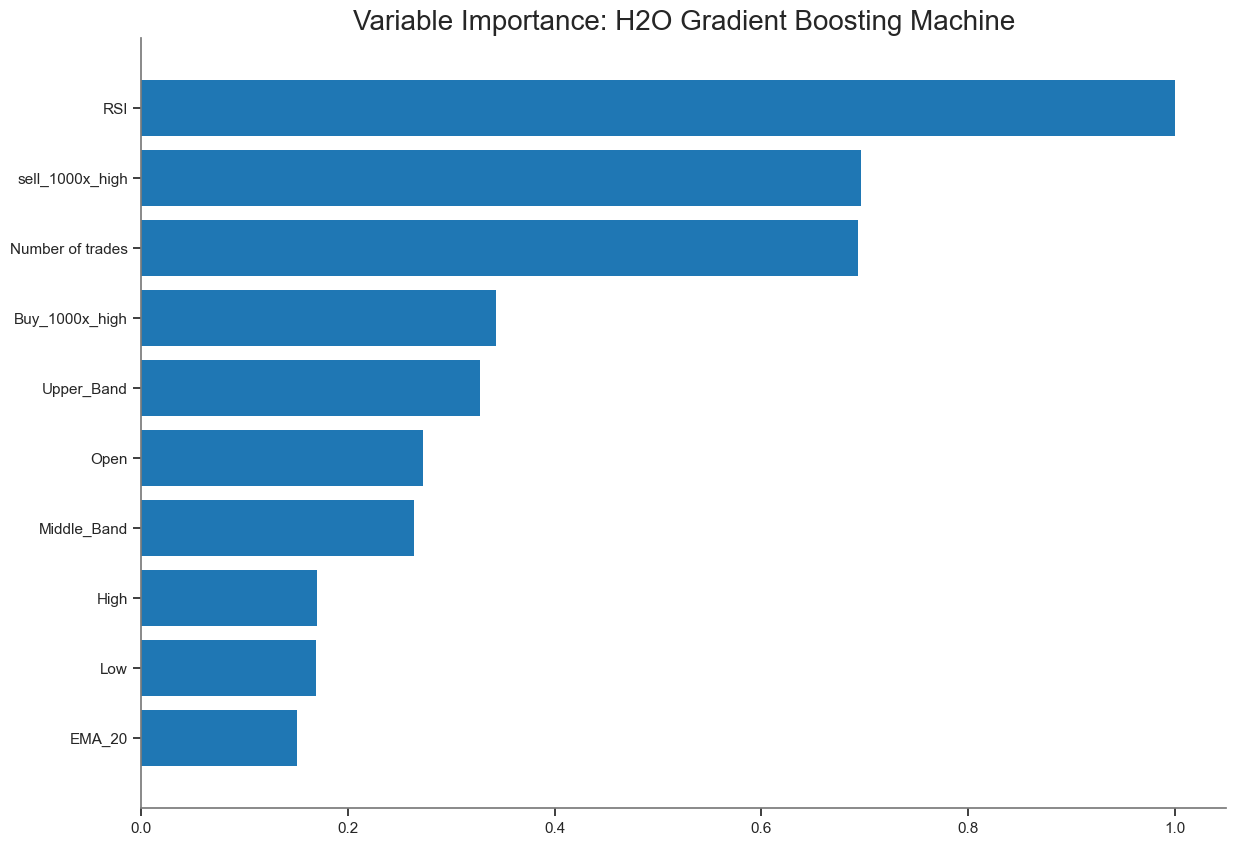

<Figure size 640x480 with 0 Axes>

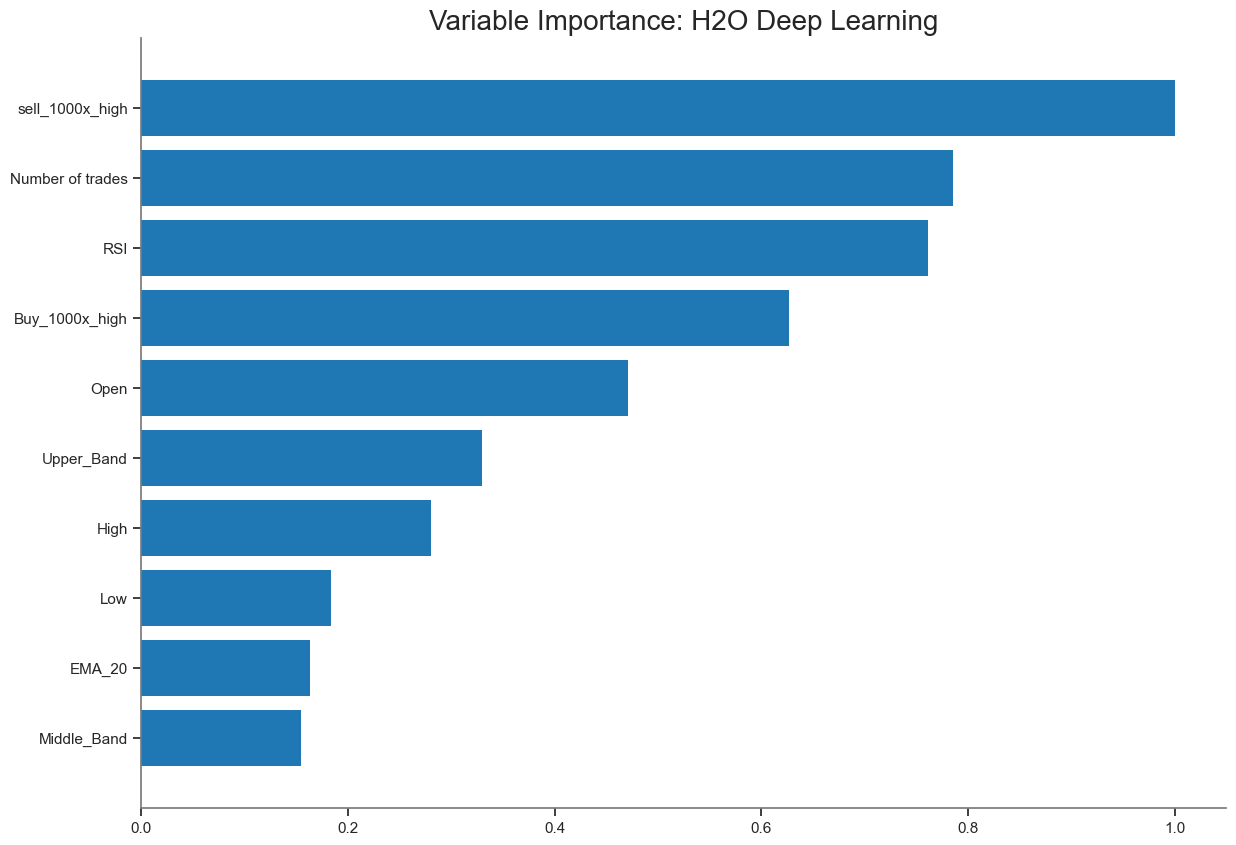

<Figure size 640x480 with 0 Axes>

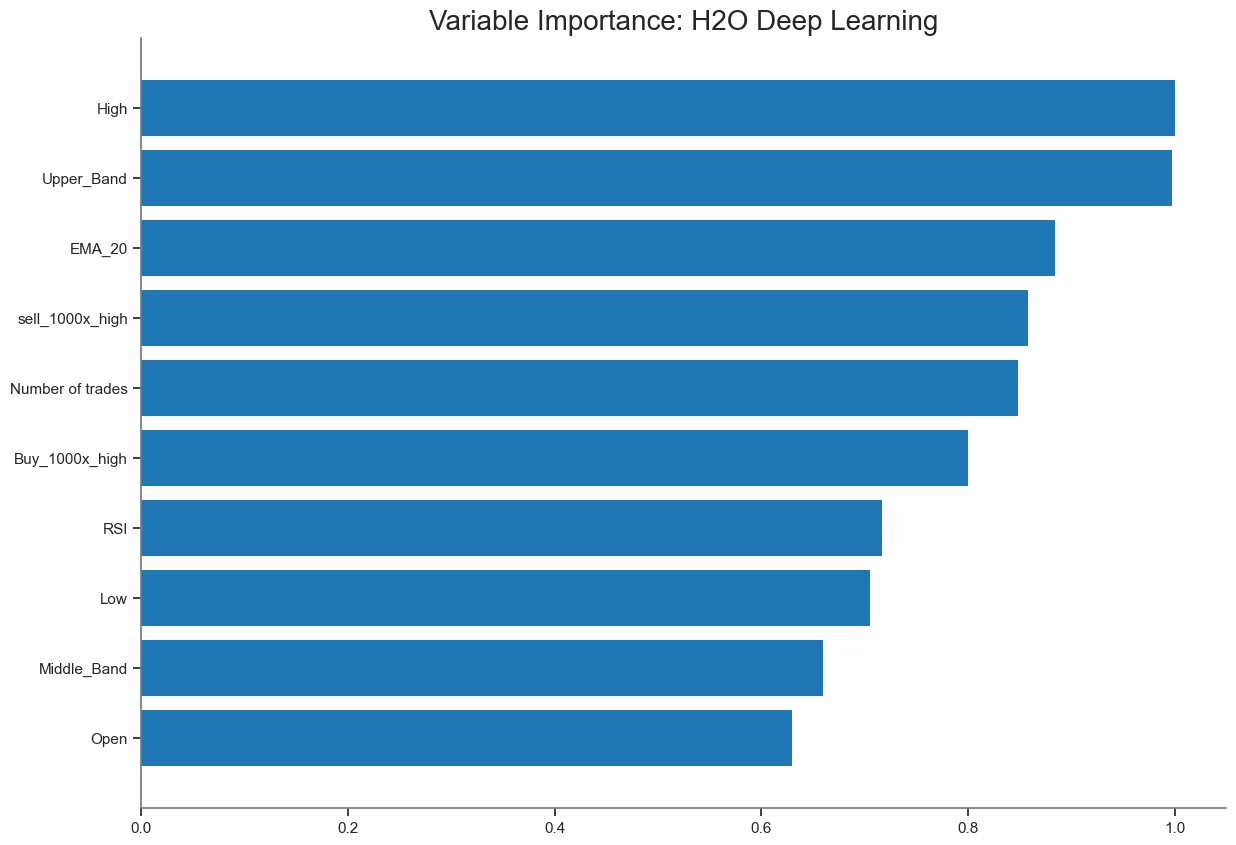

<Figure size 640x480 with 0 Axes>

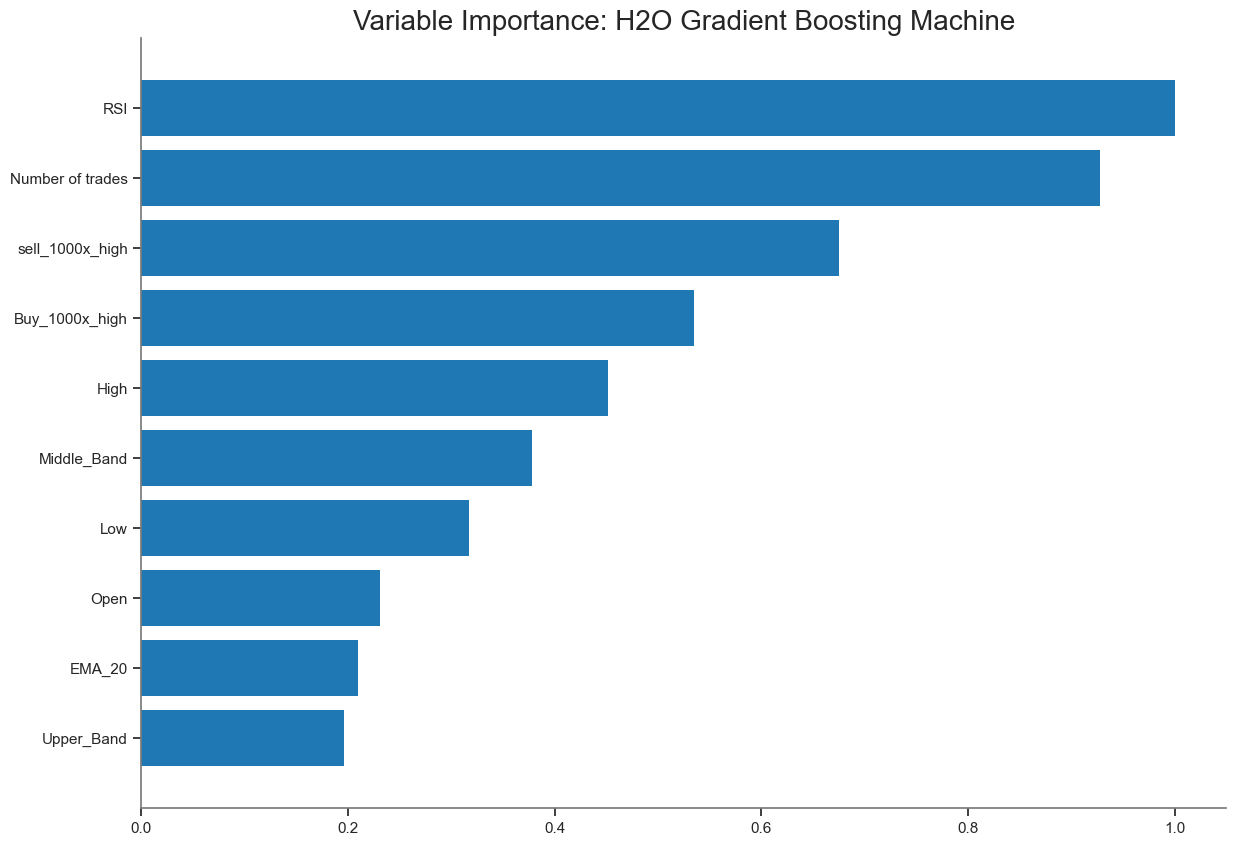

<Figure size 640x480 with 0 Axes>

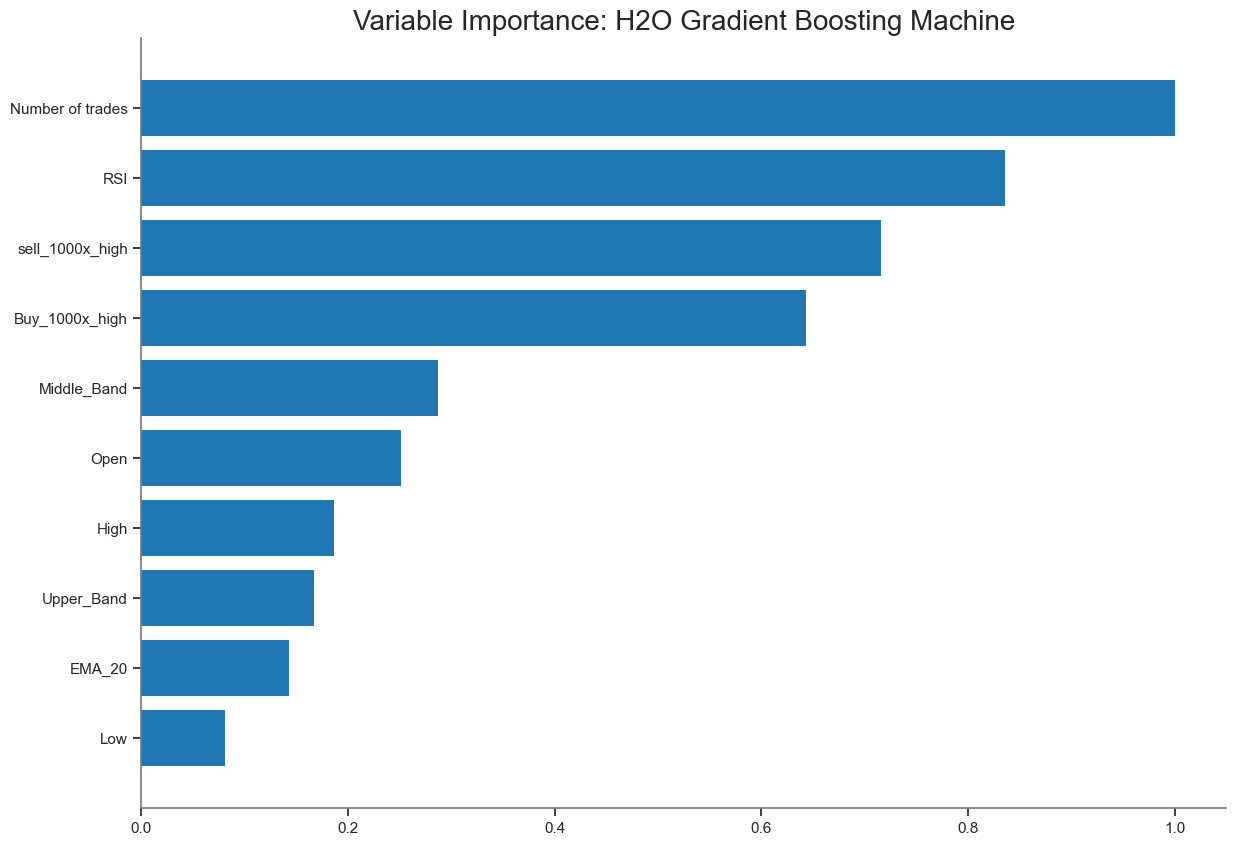

<Figure size 640x480 with 0 Axes>

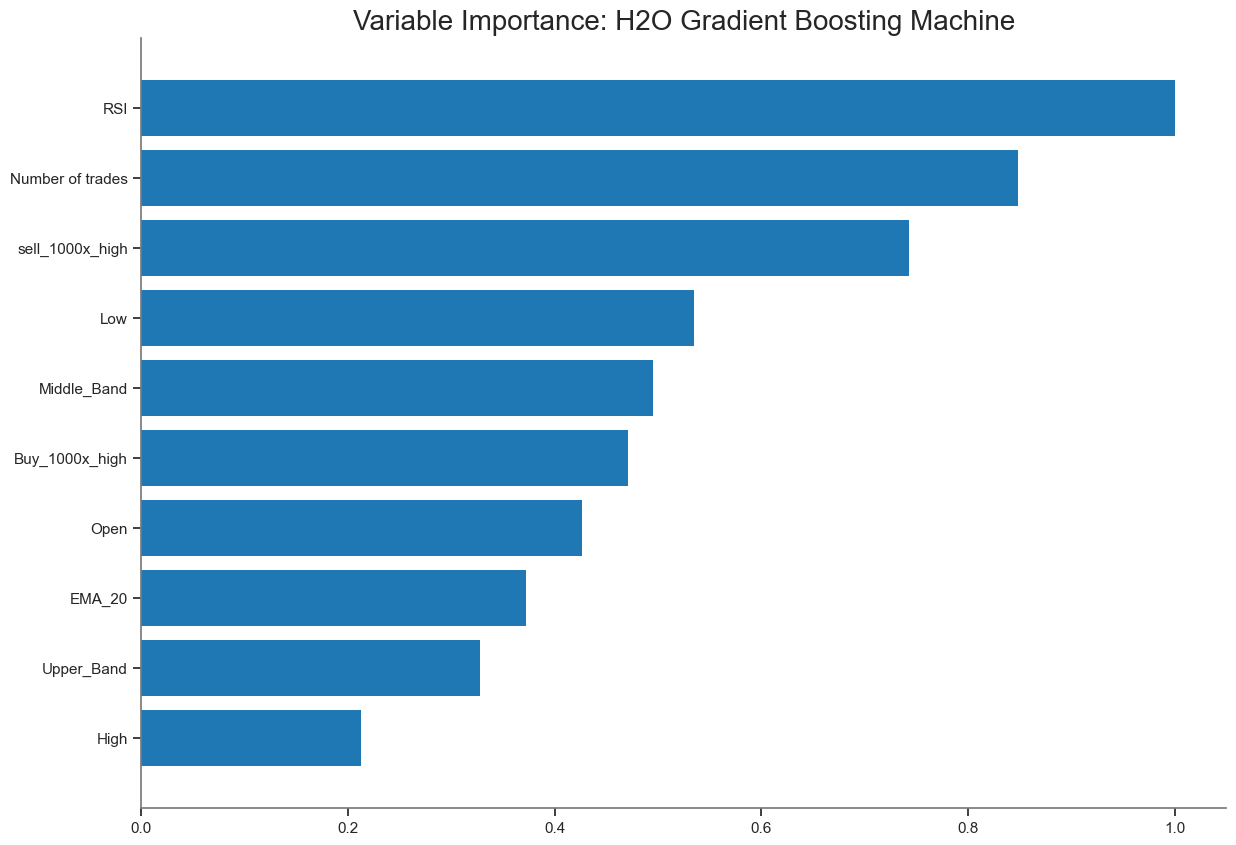

<Figure size 640x480 with 0 Axes>

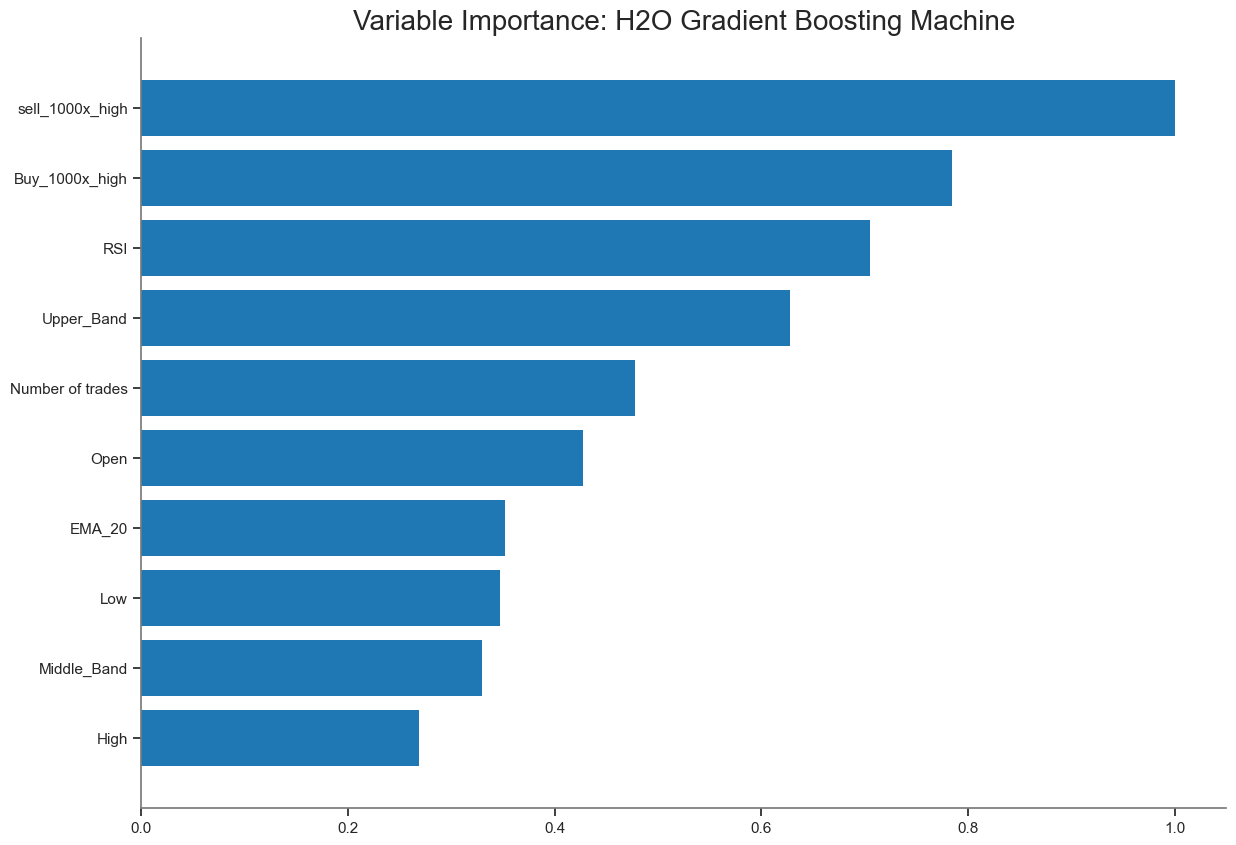

<Figure size 640x480 with 0 Axes>

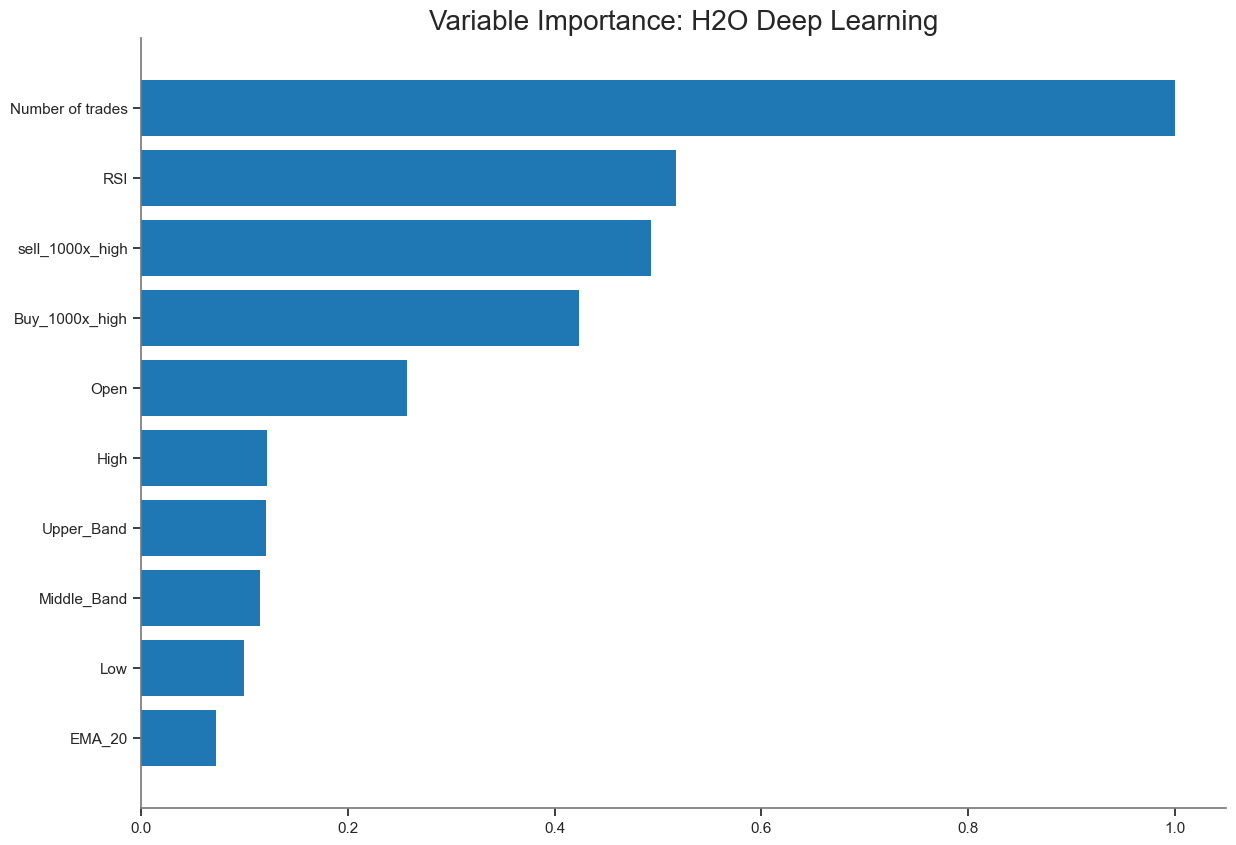

<Figure size 640x480 with 0 Axes>

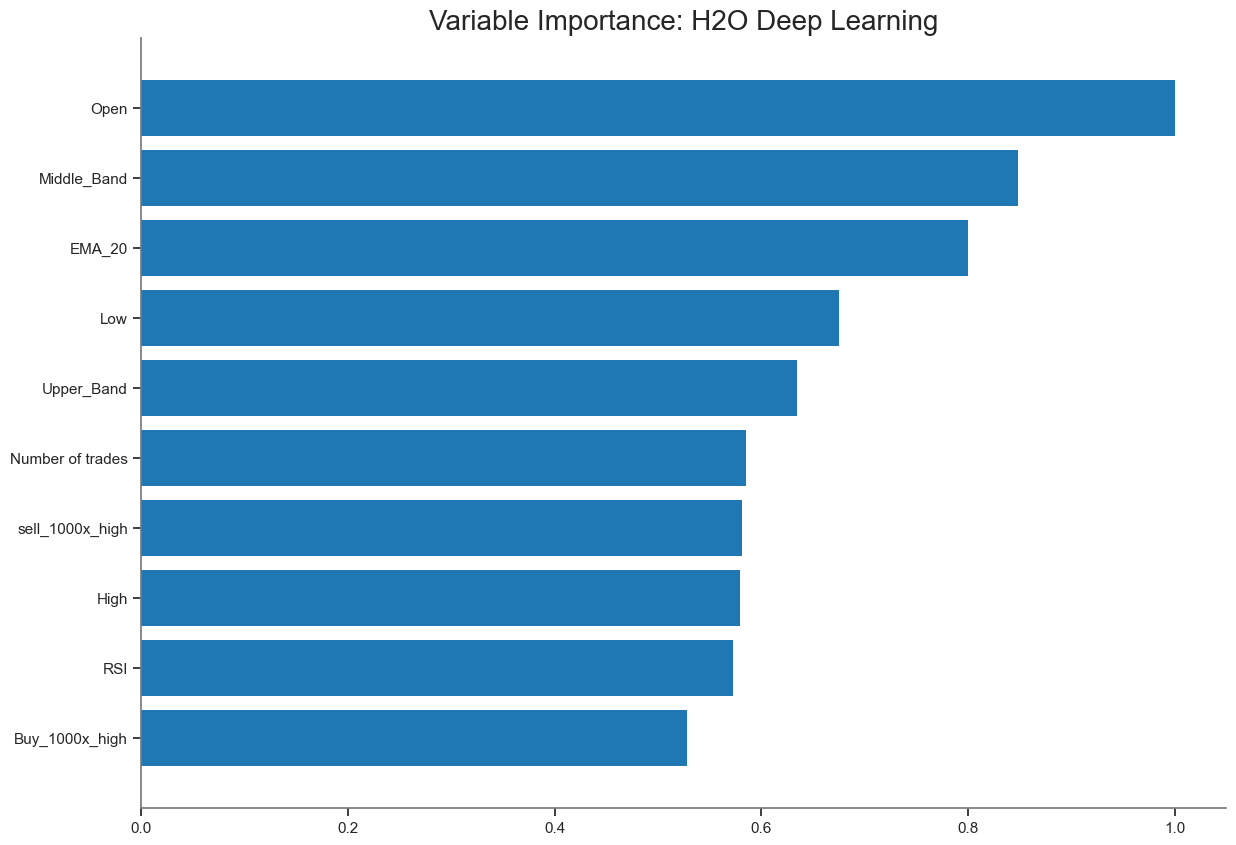

<Figure size 640x480 with 0 Axes>

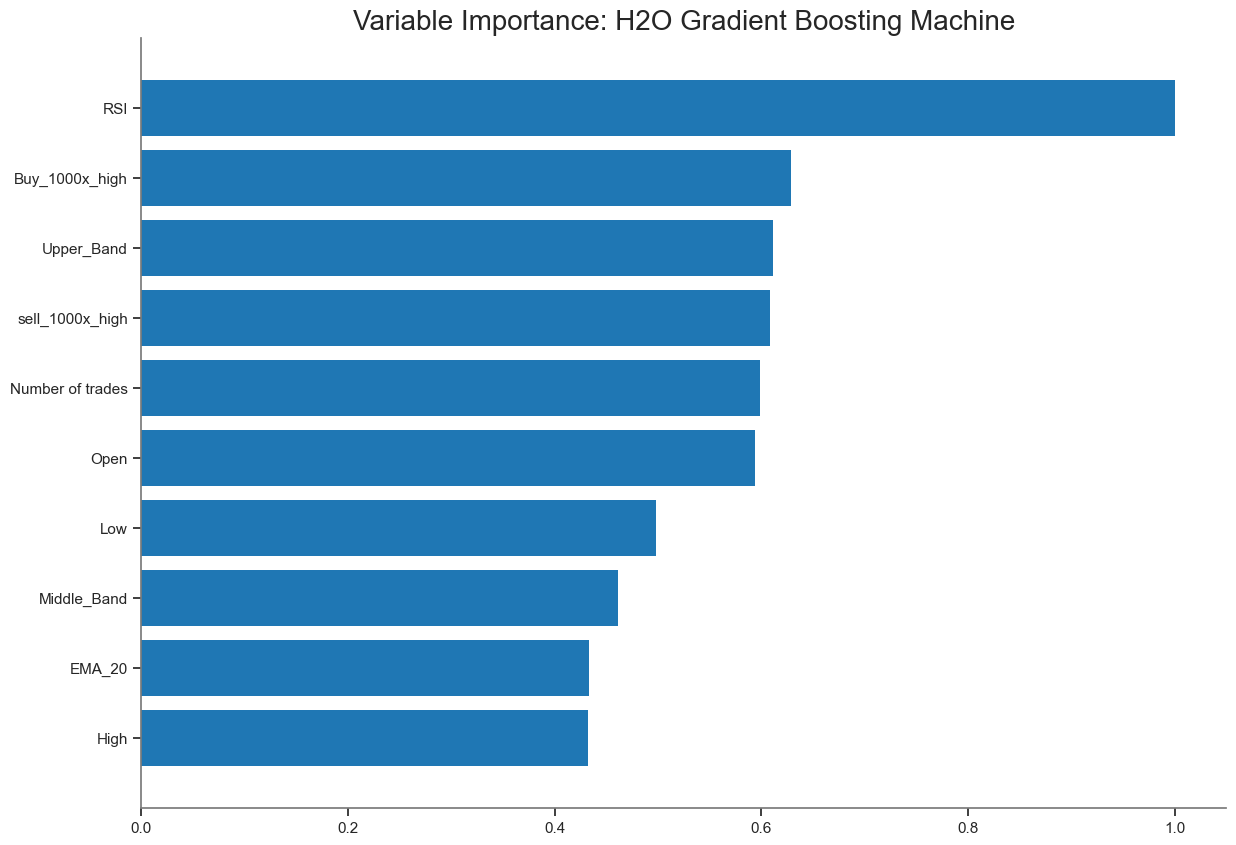

<Figure size 640x480 with 0 Axes>

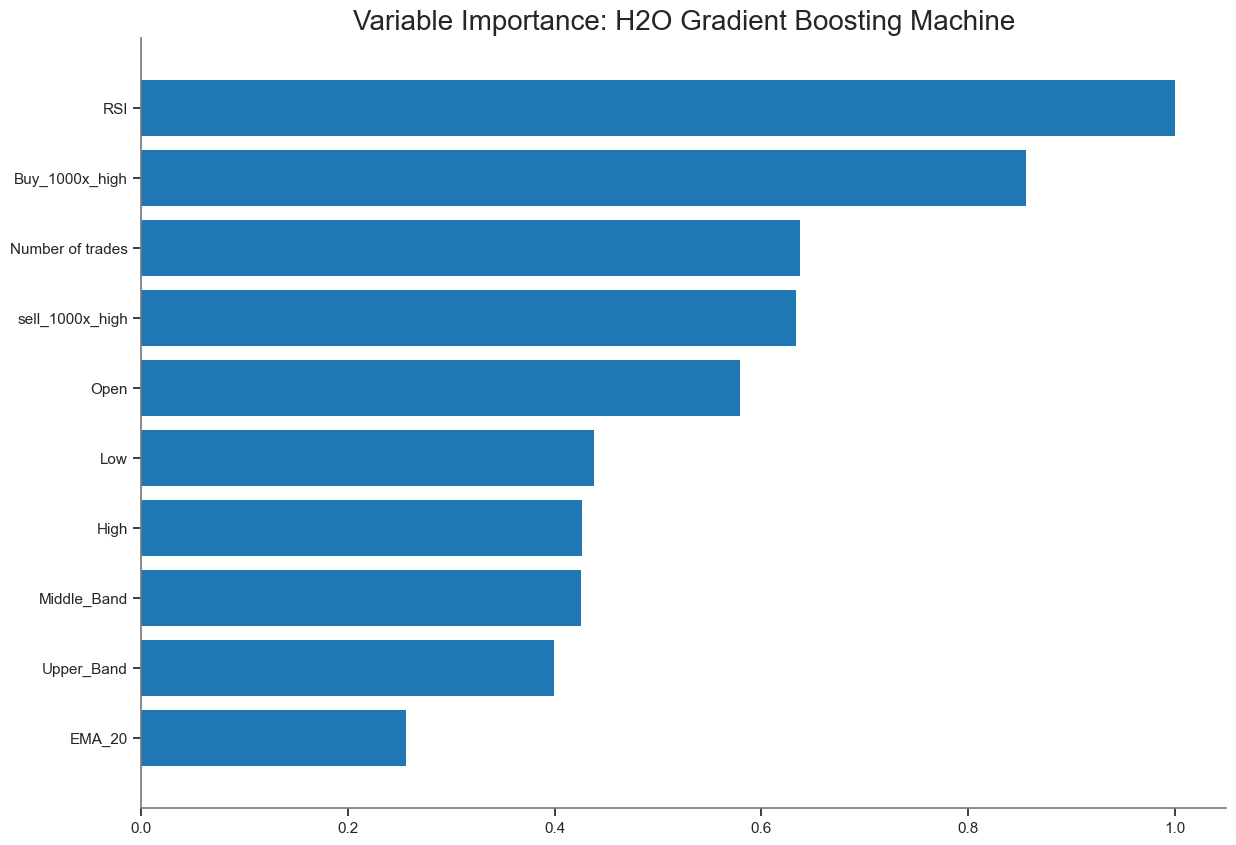

<Figure size 640x480 with 0 Axes>

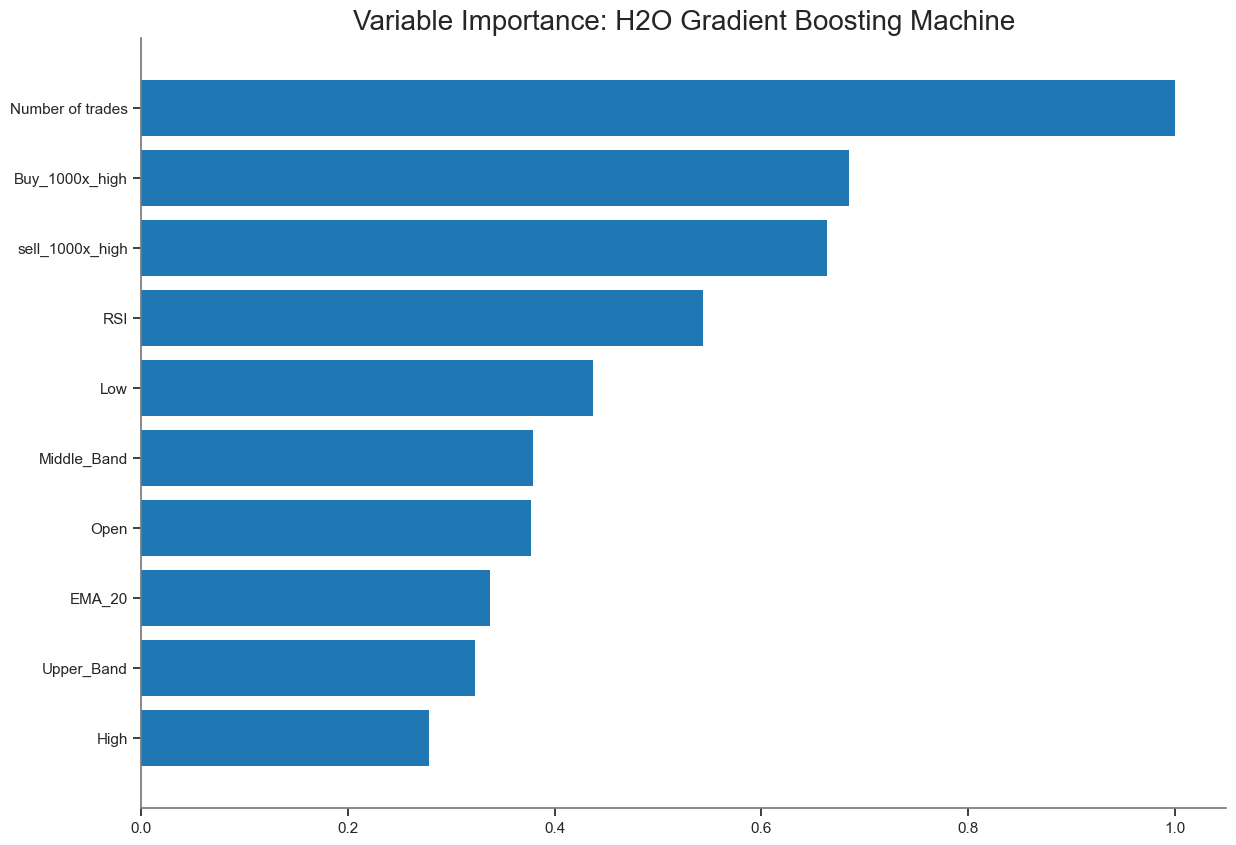

<Figure size 640x480 with 0 Axes>

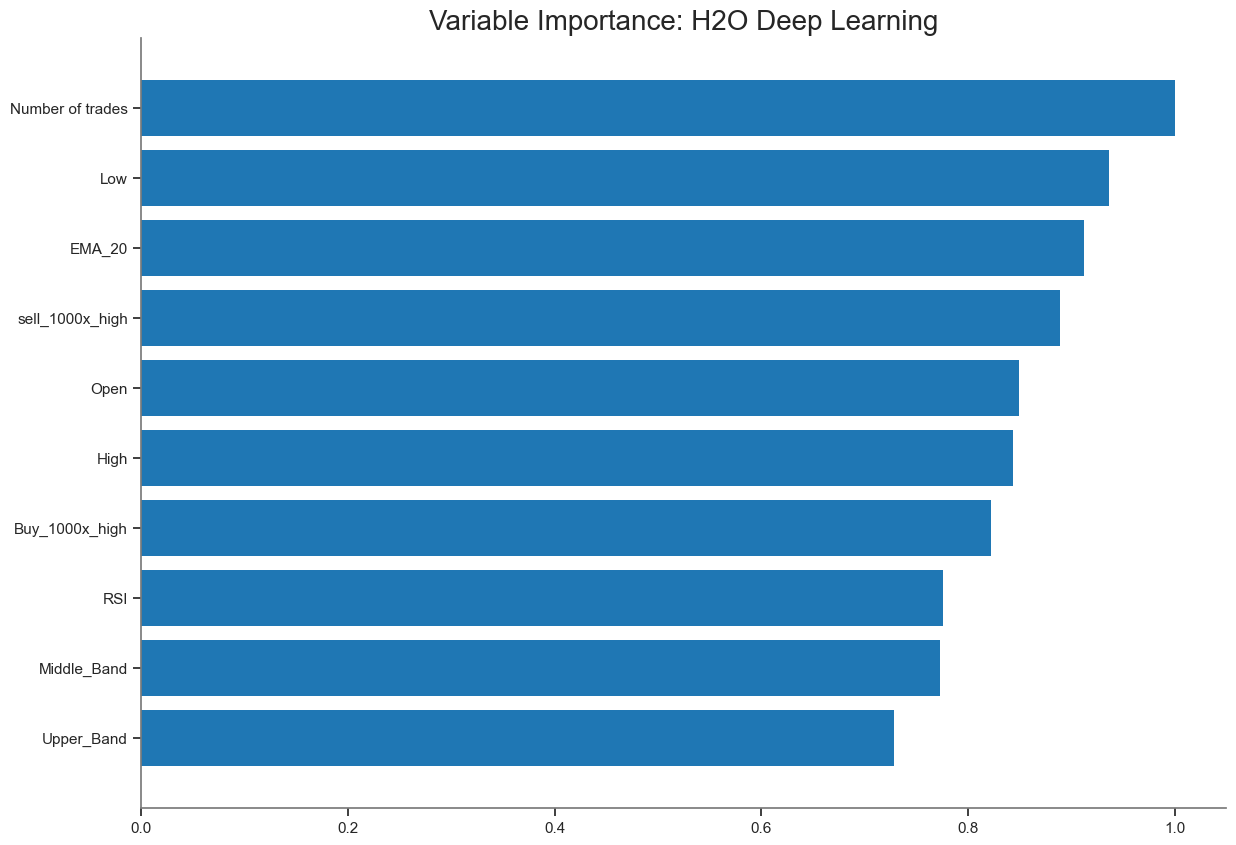

<Figure size 640x480 with 0 Axes>

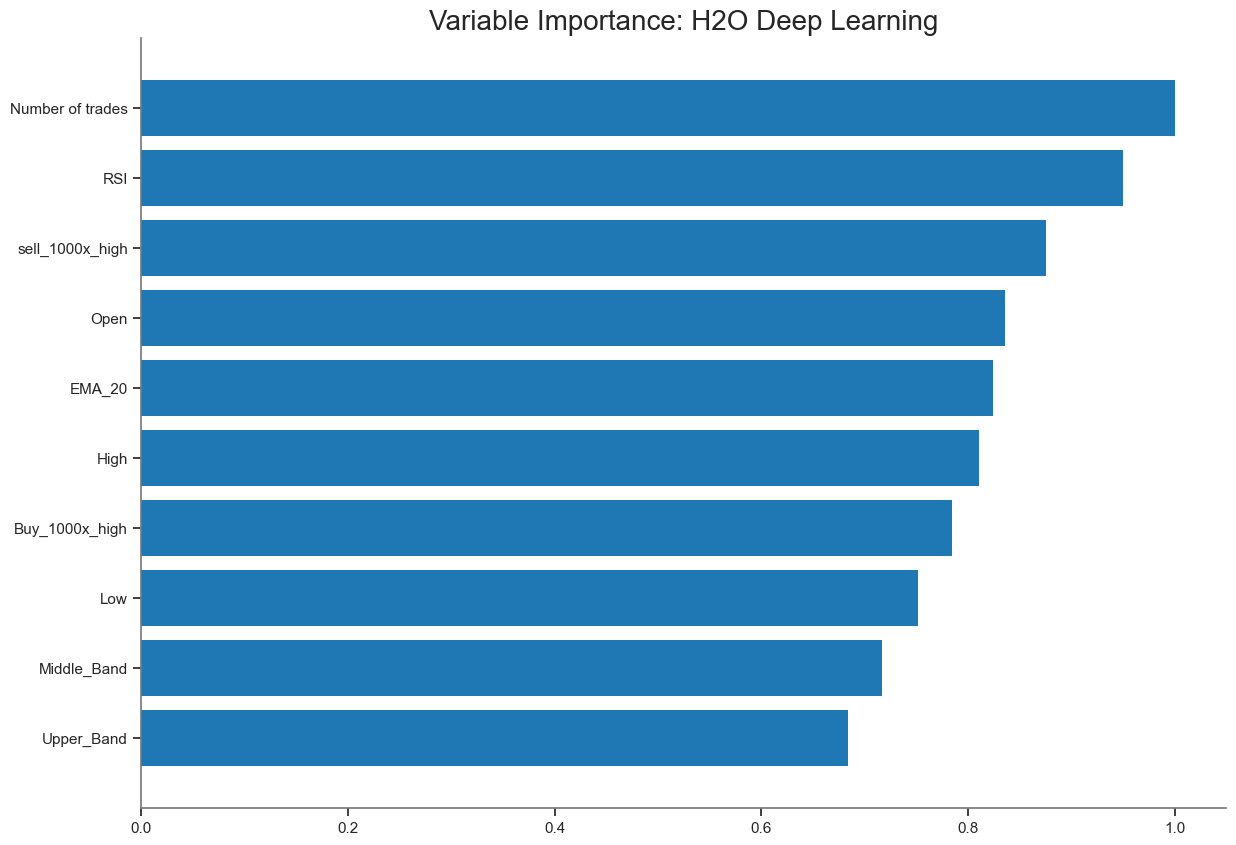

<Figure size 640x480 with 0 Axes>

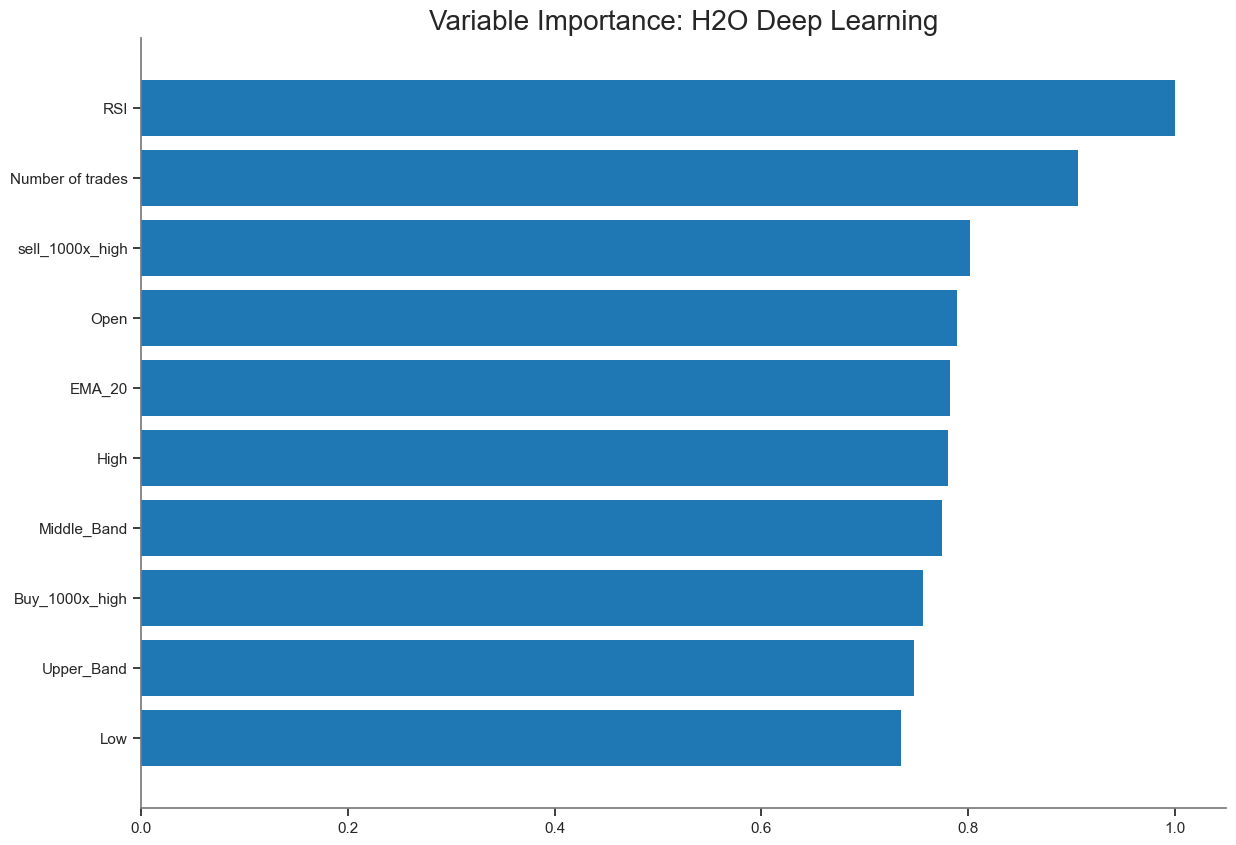

<Figure size 640x480 with 0 Axes>

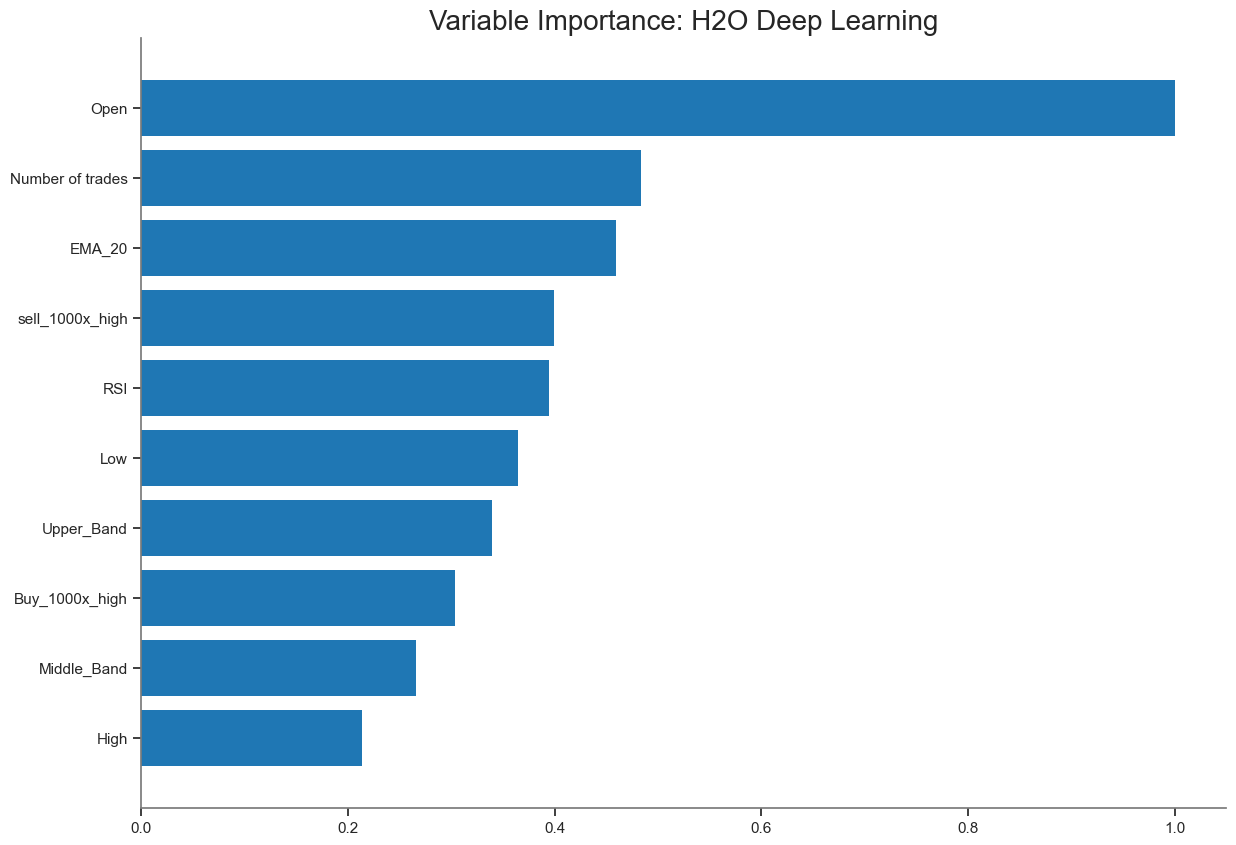

<Figure size 640x480 with 0 Axes>

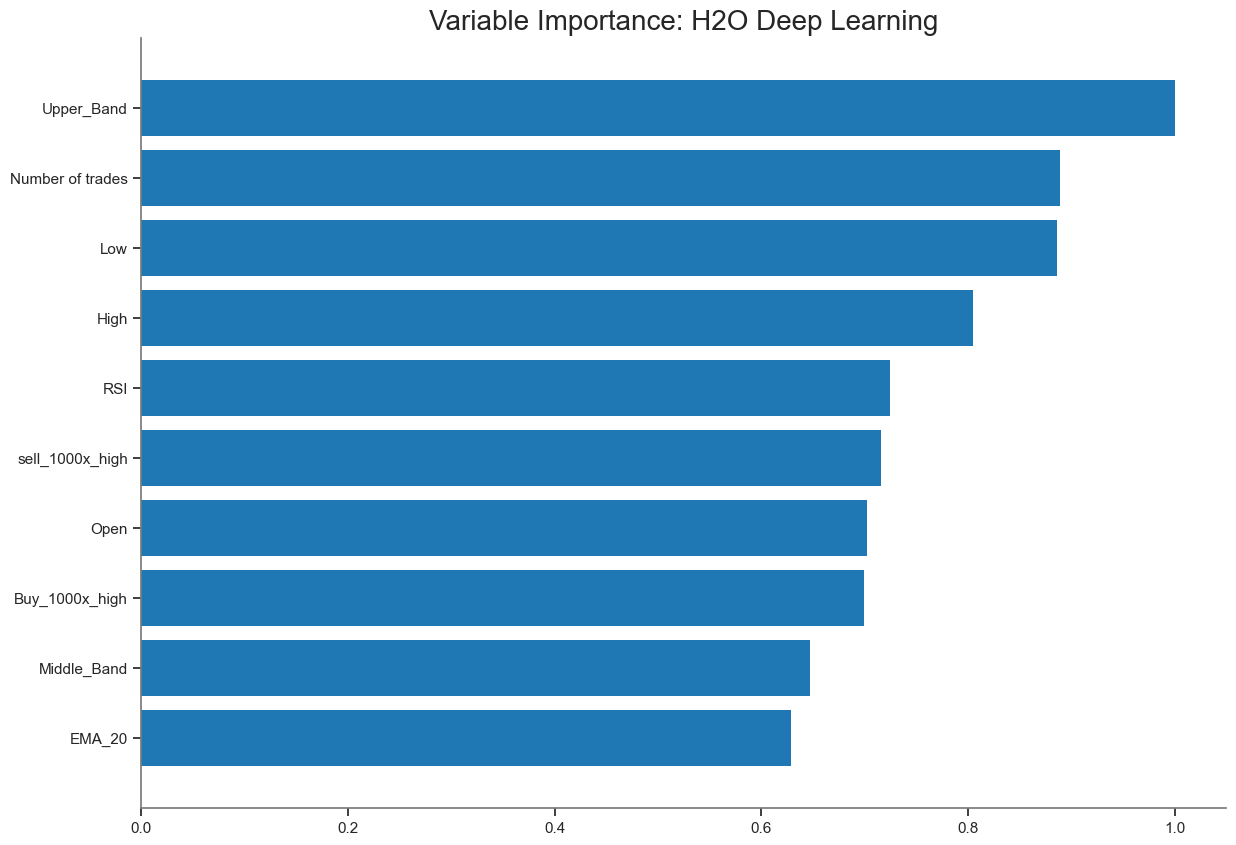

<Figure size 640x480 with 0 Axes>

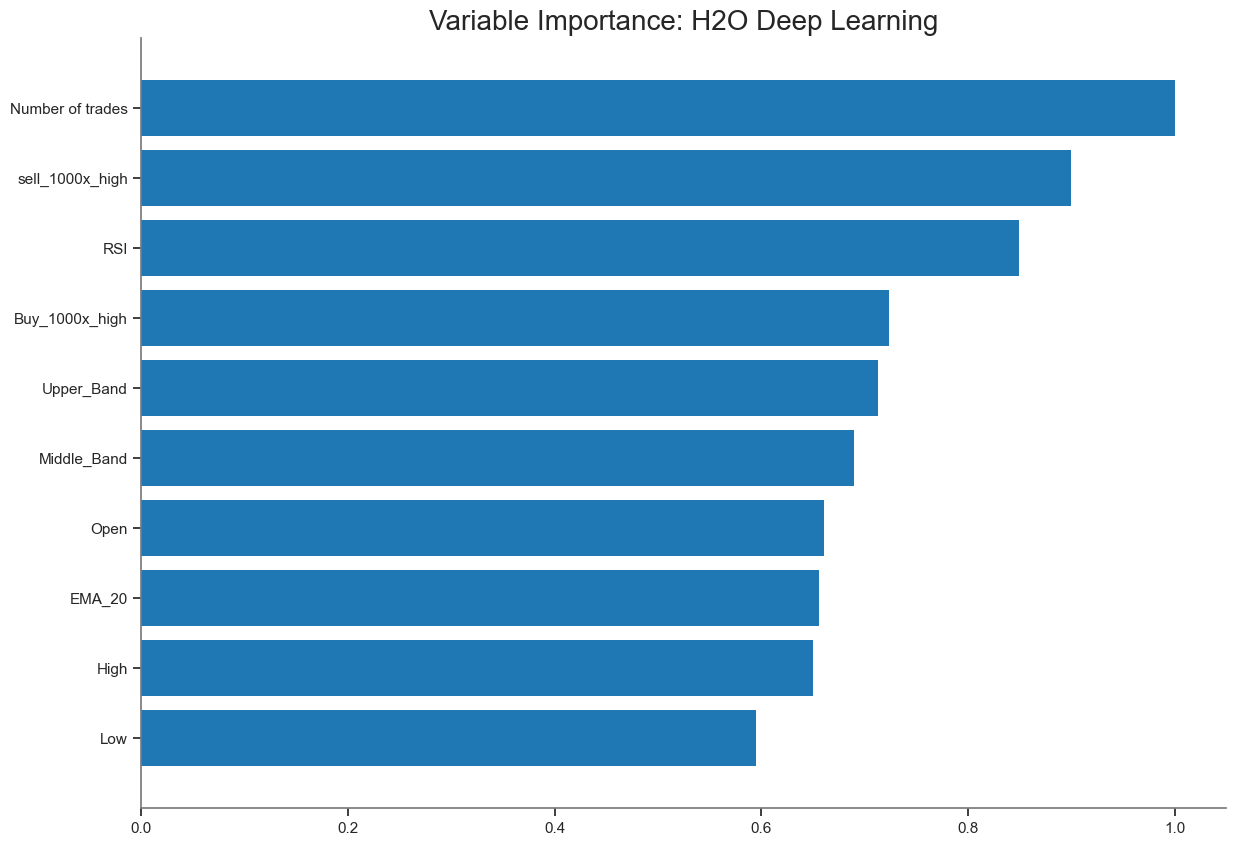

<Figure size 640x480 with 0 Axes>

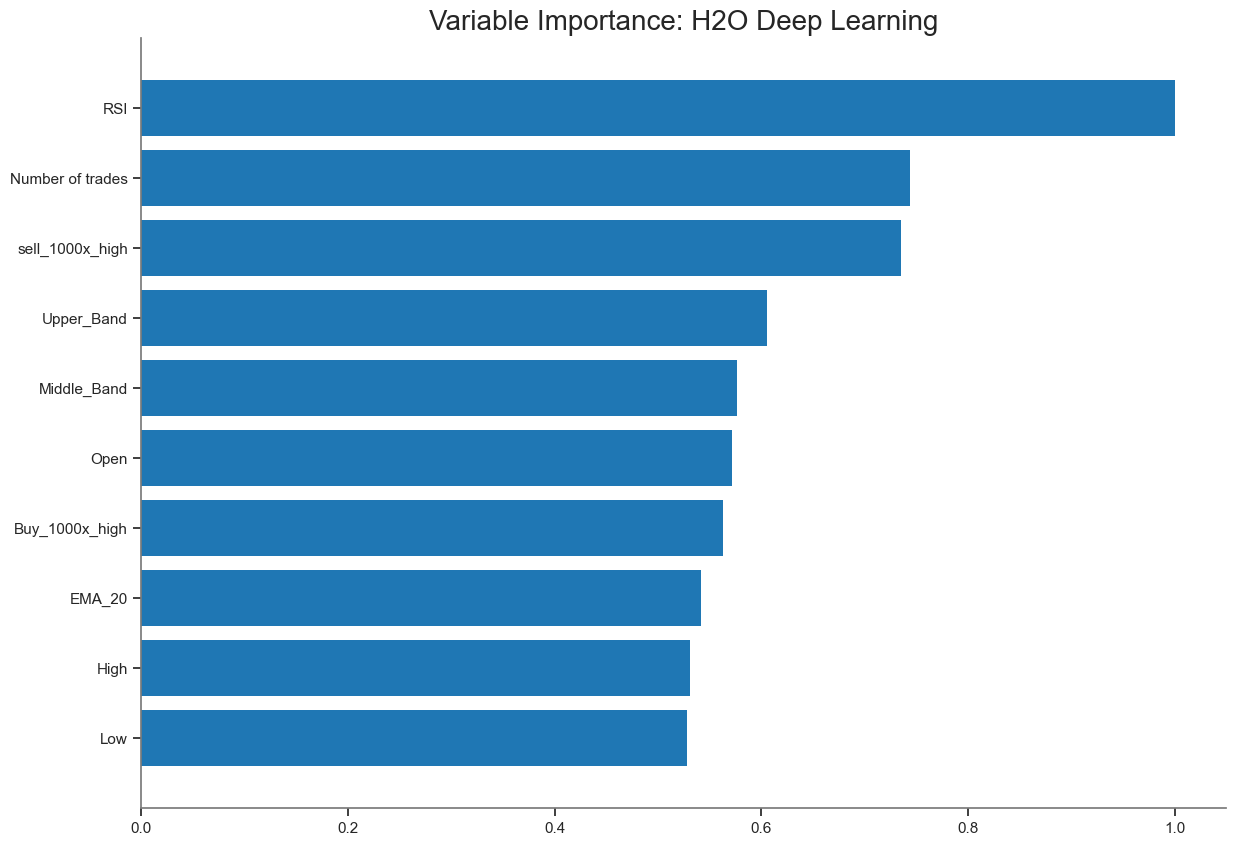

<Figure size 640x480 with 0 Axes>

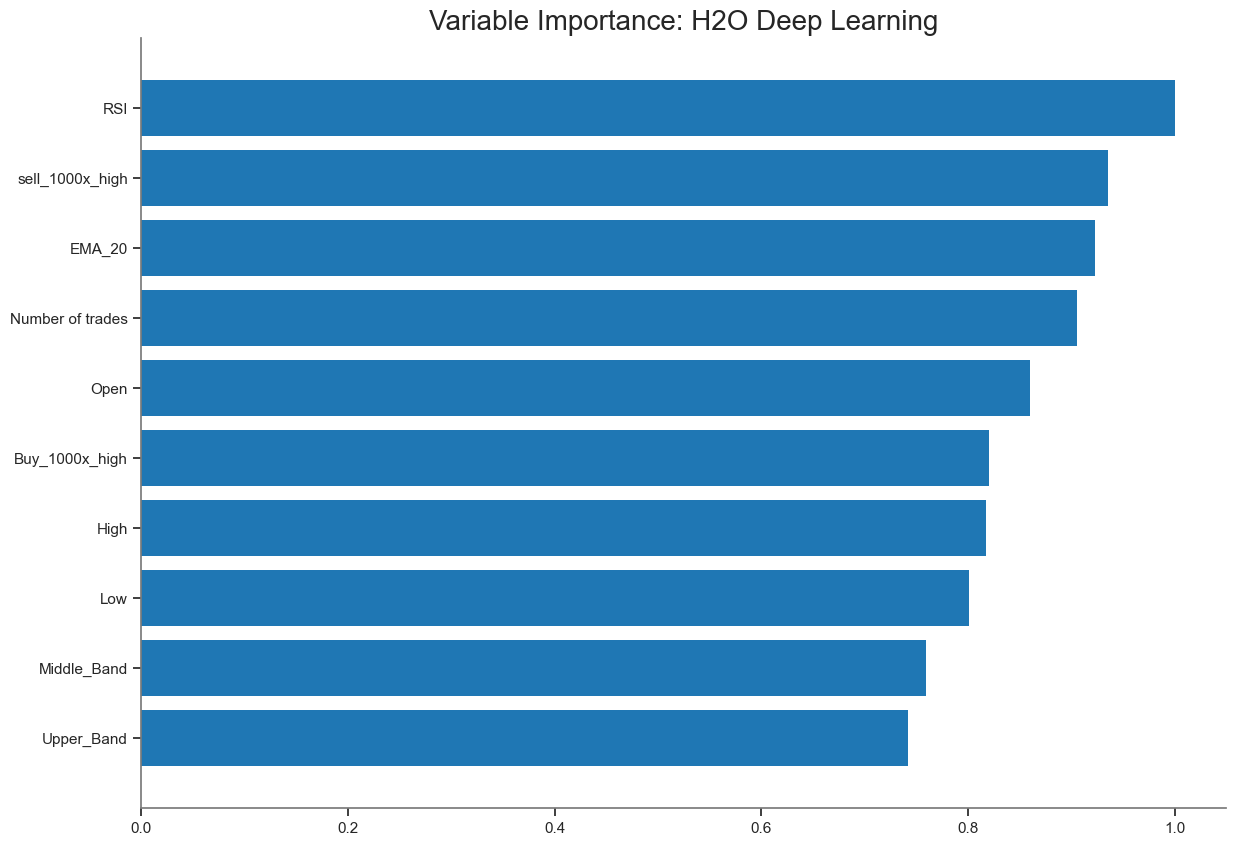

<Figure size 640x480 with 0 Axes>

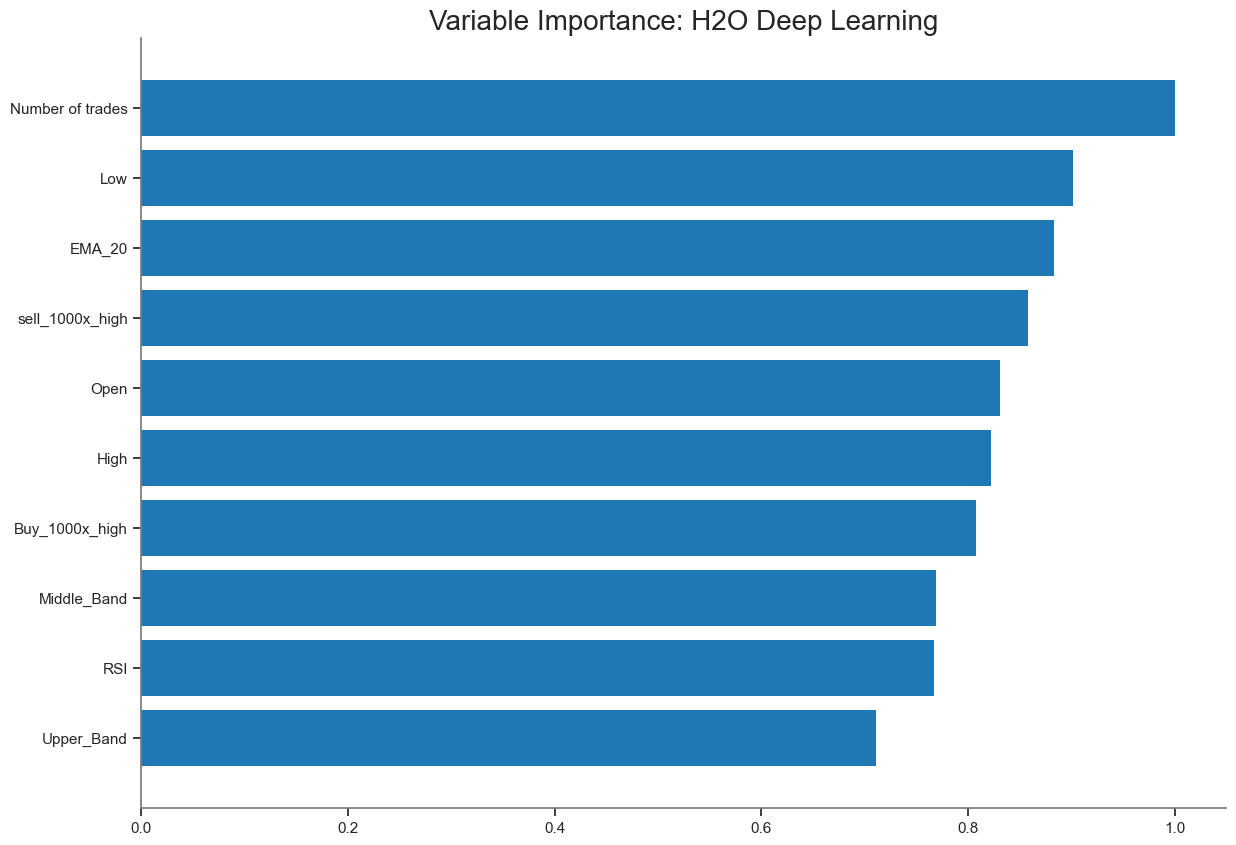

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt


ensemble_model = stack_models[0]

# Obtener los modelos base del ensemble
base_models_ids = ensemble_model.base_models

# Visualizar la importancia de características para cada modelo base
for model_id in base_models_ids:
    base_model = h2o.get_model(model_id)
    try:
        # Generar y mostrar el gráfico de importancia de características
        base_model.varimp_plot()
        plt.show()
    except:
        print(f"No se puede generar la importancia de características para el modelo {model_id} de tipo {base_model.algo}")
